<a href="https://colab.research.google.com/github/gi3265/-DACON-Bit_Trader/blob/main/%5BDacon%5DBit_Trader_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Library Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape, Flatten
import numpy as np
import pandas as pd
# import os.path
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# 2. 데이터 가공

## 2.1 read_csv

In [3]:
data_path = '/content/drive/MyDrive/Dacon_Data/[DACON]BIt_Trader/data'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

## 2.2 numpy array로 변환

In [4]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [5]:
train_x_array = df2d_to_array3d(train_x_df)   #(7362, 1380, 10)
train_y_array = df2d_to_array3d(train_y_df)   #(7362, 120, 10)
test_x_array = df2d_to_array3d(test_x_df)     #(529, 1380, 10)

# 3. 모델 훈련하기

## 3.1 훈련 층 쌓기(모델 구성)

In [7]:
#제출 결과는 더 좋았지만 그래프가 너무 이상함
model = Sequential()
model.add(LSTM(64, input_shape = [1380, 1]))
model.add(Dense(240))
model.add(Dense(120))   #여기 activation = relu넣어본 결과 실패
model.add(Reshape([120,1]))

In [8]:
# model=Sequential([
# LSTM(units = 32, input_shape=[1380, 1]),   #activation = 'relu'넣으니 학습 제대로 안 됐음.
# Dense(120 * 1),
# Reshape([120, 1])
# ])

In [9]:
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(patience = 5)

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_1 (Dense)              (None, 240)               15600     
_________________________________________________________________
dense_2 (Dense)              (None, 120)               28920     
_________________________________________________________________
reshape (Reshape)            (None, 120, 1)            0         
Total params: 61,416
Trainable params: 61,416
Non-trainable params: 0
_________________________________________________________________


## 3.2 validation set 훈련(sample_id: 0~529)

### 3.2.1 validation 데이터 생성하기

In [11]:
# train 데이터 상단의 300개 샘플로 validation set를 구성하여 학습 및 추론
valid_x_df = train_x_df[train_x_df.sample_id < 529]
valid_y_df = train_y_df[train_y_df.sample_id < 529]

valid_x_array = df2d_to_array3d(valid_x_df)
valid_y_array = df2d_to_array3d(valid_y_df)
valid_pred_array = np.zeros([len(valid_x_array), 120, 1])

### 3.2.2 학습 및 test_x 예측하고 해당 내용 test_pred_array에 기록

In [12]:
test_pred_array = np.zeros([529, 120, 1])

for idx in tqdm(range(valid_x_array.shape[0])):
    #학습
    x_series = np.reshape(valid_x_array[idx,:,1], (1, 1380,1))
    y_series = np.reshape(valid_y_array[idx,:,1], (1, 120, 1))
    test_x_series = np.reshape(test_x_array[idx,:,1], (1, 1380,1)) #각 open 값의 3차원형

    preds = model.predict(test_x_series)
    test_pred_array[idx,:] = preds

    history = model.fit(x_series, y_series, epochs = 30, batch_size = 128) #callbacks = [earlystopping]

    #여기서 predict를 바로 해야 함
    preds = model.predict(test_x_series)
    test_pred_array[idx,:] = preds

  0%|          | 0/529 [00:00<?, ?it/s]

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 1.0022 - mse: 1.0022
Epoch 2/30
1/1 [==============================] - 0s 113ms/step - loss: 0.9545 - mse: 0.9545
Epoch 3/30
1/1 [==============================] - 0s 115ms/step - loss: 0.9065 - mse: 0.9065
Epoch 4/30
1/1 [==============================] - 0s 109ms/step - loss: 0.8550 - mse: 0.8550
Epoch 5/30
1/1 [==============================] - 0s 116ms/step - loss: 0.7973 - mse: 0.7973
Epoch 6/30
1/1 [==============================] - 0s 111ms/step - loss: 0.7313 - mse: 0.7313
Epoch 7/30
1/1 [==============================] - 0s 109ms/step - loss: 0.6548 - mse: 0.6548
Epoch 8/30
1/1 [==============================] - 0s 114ms/step - loss: 0.5660 - mse: 0.5660
Epoch 9/30
1/1 [==============================] - 0s 119ms/step - loss: 0.4636 - mse: 0.4636
Epoch 10/30
1/1 [==============================] - 0s 117ms/step - loss: 0.3494 - mse: 0.3494
Epoch 11/30
1/1 [==============================] - 0s 113ms/step - loss:

  0%|          | 1/529 [00:34<4:59:58, 34.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 0.0160 - mse: 0.0160
Epoch 2/30
1/1 [==============================] - 0s 110ms/step - loss: 0.0158 - mse: 0.0158
Epoch 3/30
1/1 [==============================] - 0s 109ms/step - loss: 0.0160 - mse: 0.0160
Epoch 4/30
1/1 [==============================] - 0s 110ms/step - loss: 0.0155 - mse: 0.0155
Epoch 5/30
1/1 [==============================] - 0s 118ms/step - loss: 0.0137 - mse: 0.0137
Epoch 6/30
1/1 [==============================] - 0s 113ms/step - loss: 0.0108 - mse: 0.0108
Epoch 7/30
1/1 [==============================] - 0s 111ms/step - loss: 0.0075 - mse: 0.0075
Epoch 8/30
1/1 [==============================] - 0s 118ms/step - loss: 0.0046 - mse: 0.0046
Epoch 9/30
1/1 [==============================] - 0s 123ms/step - loss: 0.0026 - mse: 0.0026
Epoch 10/30
1/1 [==============================] - 0s 116ms/step - loss: 0.0019 - mse: 0.0019
Epoch 11/30
1/1 [==============================] - 0s 112ms/step - lo

  0%|          | 2/529 [00:38<3:39:59, 25.05s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 5.6628e-04 - mse: 5.6628e-04
Epoch 2/30
1/1 [==============================] - 0s 117ms/step - loss: 5.8019e-04 - mse: 5.8019e-04
Epoch 3/30
1/1 [==============================] - 0s 113ms/step - loss: 5.7627e-04 - mse: 5.7627e-04
Epoch 4/30
1/1 [==============================] - 0s 110ms/step - loss: 5.3203e-04 - mse: 5.3203e-04
Epoch 5/30
1/1 [==============================] - 0s 113ms/step - loss: 4.4940e-04 - mse: 4.4940e-04
Epoch 6/30
1/1 [==============================] - 0s 112ms/step - loss: 3.4959e-04 - mse: 3.4959e-04
Epoch 7/30
1/1 [==============================] - 0s 114ms/step - loss: 2.6086e-04 - mse: 2.6086e-04
Epoch 8/30
1/1 [==============================] - 0s 113ms/step - loss: 2.0504e-04 - mse: 2.0504e-04
Epoch 9/30
1/1 [==============================] - 0s 111ms/step - loss: 1.8862e-04 - mse: 1.8862e-04
Epoch 10/30
1/1 [==============================] - 0s 111ms/step - loss: 2.0169e-04 - mse: 

  1%|          | 3/529 [00:41<2:44:01, 18.71s/it]

Epoch 1/30
1/1 [==============================] - 0s 122ms/step - loss: 4.4936e-05 - mse: 4.4936e-05
Epoch 2/30
1/1 [==============================] - 0s 115ms/step - loss: 3.5398e-05 - mse: 3.5398e-05
Epoch 3/30
1/1 [==============================] - 0s 112ms/step - loss: 2.6640e-05 - mse: 2.6640e-05
Epoch 4/30
1/1 [==============================] - 0s 112ms/step - loss: 2.1788e-05 - mse: 2.1788e-05
Epoch 5/30
1/1 [==============================] - 0s 116ms/step - loss: 2.1324e-05 - mse: 2.1324e-05
Epoch 6/30
1/1 [==============================] - 0s 111ms/step - loss: 2.3349e-05 - mse: 2.3349e-05
Epoch 7/30
1/1 [==============================] - 0s 111ms/step - loss: 2.5040e-05 - mse: 2.5040e-05
Epoch 8/30
1/1 [==============================] - 0s 112ms/step - loss: 2.4330e-05 - mse: 2.4330e-05
Epoch 9/30
1/1 [==============================] - 0s 114ms/step - loss: 2.0885e-05 - mse: 2.0885e-05
Epoch 10/30
1/1 [==============================] - 0s 114ms/step - loss: 1.5986e-05 - mse: 

  1%|          | 4/529 [00:45<2:05:01, 14.29s/it]

Epoch 1/30
1/1 [==============================] - 0s 116ms/step - loss: 1.7910e-05 - mse: 1.7910e-05
Epoch 2/30
1/1 [==============================] - 0s 110ms/step - loss: 1.5683e-05 - mse: 1.5683e-05
Epoch 3/30
1/1 [==============================] - 0s 110ms/step - loss: 1.1841e-05 - mse: 1.1841e-05
Epoch 4/30
1/1 [==============================] - 0s 112ms/step - loss: 7.8803e-06 - mse: 7.8803e-06
Epoch 5/30
1/1 [==============================] - 0s 126ms/step - loss: 4.9704e-06 - mse: 4.9704e-06
Epoch 6/30
1/1 [==============================] - 0s 115ms/step - loss: 3.4797e-06 - mse: 3.4797e-06
Epoch 7/30
1/1 [==============================] - 0s 112ms/step - loss: 3.0332e-06 - mse: 3.0332e-06
Epoch 8/30
1/1 [==============================] - 0s 116ms/step - loss: 2.9560e-06 - mse: 2.9560e-06
Epoch 9/30
1/1 [==============================] - 0s 114ms/step - loss: 2.7599e-06 - mse: 2.7599e-06
Epoch 10/30
1/1 [==============================] - 0s 112ms/step - loss: 2.3777e-06 - mse: 

  1%|          | 5/529 [00:49<1:37:46, 11.19s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 6.2243e-04 - mse: 6.2243e-04
Epoch 2/30
1/1 [==============================] - 0s 110ms/step - loss: 4.3322e-04 - mse: 4.3322e-04
Epoch 3/30
1/1 [==============================] - 0s 111ms/step - loss: 1.9115e-04 - mse: 1.9115e-04
Epoch 4/30
1/1 [==============================] - 0s 113ms/step - loss: 4.5407e-05 - mse: 4.5407e-05
Epoch 5/30
1/1 [==============================] - 0s 113ms/step - loss: 5.6925e-05 - mse: 5.6925e-05
Epoch 6/30
1/1 [==============================] - 0s 118ms/step - loss: 1.6973e-04 - mse: 1.6973e-04
Epoch 7/30
1/1 [==============================] - 0s 119ms/step - loss: 2.6775e-04 - mse: 2.6775e-04
Epoch 8/30
1/1 [==============================] - 0s 115ms/step - loss: 2.6812e-04 - mse: 2.6812e-04
Epoch 9/30
1/1 [==============================] - 0s 112ms/step - loss: 1.7629e-04 - mse: 1.7629e-04
Epoch 10/30
1/1 [==============================] - 0s 115ms/step - loss: 6.6053e-05 - mse: 

  1%|          | 6/529 [00:53<1:18:46,  9.04s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 4.6440e-04 - mse: 4.6440e-04
Epoch 2/30
1/1 [==============================] - 0s 127ms/step - loss: 3.7676e-04 - mse: 3.7676e-04
Epoch 3/30
1/1 [==============================] - 0s 112ms/step - loss: 1.9534e-04 - mse: 1.9534e-04
Epoch 4/30
1/1 [==============================] - 0s 112ms/step - loss: 5.4313e-05 - mse: 5.4313e-05
Epoch 5/30
1/1 [==============================] - 0s 114ms/step - loss: 3.0684e-05 - mse: 3.0684e-05
Epoch 6/30
1/1 [==============================] - 0s 117ms/step - loss: 1.0107e-04 - mse: 1.0107e-04
Epoch 7/30
1/1 [==============================] - 0s 110ms/step - loss: 1.8116e-04 - mse: 1.8116e-04
Epoch 8/30
1/1 [==============================] - 0s 110ms/step - loss: 1.9919e-04 - mse: 1.9919e-04
Epoch 9/30
1/1 [==============================] - 0s 121ms/step - loss: 1.4430e-04 - mse: 1.4430e-04
Epoch 10/30
1/1 [==============================] - 0s 113ms/step - loss: 6.2544e-05 - mse: 

  1%|▏         | 7/529 [00:57<1:05:37,  7.54s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 8.4826e-06 - mse: 8.4826e-06
Epoch 2/30
1/1 [==============================] - 0s 114ms/step - loss: 6.3682e-06 - mse: 6.3682e-06
Epoch 3/30
1/1 [==============================] - 0s 113ms/step - loss: 1.1126e-05 - mse: 1.1126e-05
Epoch 4/30
1/1 [==============================] - 0s 112ms/step - loss: 1.6415e-05 - mse: 1.6415e-05
Epoch 5/30
1/1 [==============================] - 0s 113ms/step - loss: 1.6638e-05 - mse: 1.6638e-05
Epoch 6/30
1/1 [==============================] - 0s 120ms/step - loss: 1.1273e-05 - mse: 1.1273e-05
Epoch 7/30
1/1 [==============================] - 0s 111ms/step - loss: 4.4555e-06 - mse: 4.4555e-06
Epoch 8/30
1/1 [==============================] - 0s 112ms/step - loss: 9.5134e-07 - mse: 9.5134e-07
Epoch 9/30
1/1 [==============================] - 0s 113ms/step - loss: 2.2918e-06 - mse: 2.2918e-06
Epoch 10/30
1/1 [==============================] - 0s 118ms/step - loss: 6.0832e-06 - mse: 

  2%|▏         | 8/529 [01:01<56:15,  6.48s/it]  

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 2.5297e-05 - mse: 2.5297e-05
Epoch 2/30
1/1 [==============================] - 0s 110ms/step - loss: 1.7345e-05 - mse: 1.7345e-05
Epoch 3/30
1/1 [==============================] - 0s 113ms/step - loss: 7.8326e-06 - mse: 7.8326e-06
Epoch 4/30
1/1 [==============================] - 0s 113ms/step - loss: 3.3540e-06 - mse: 3.3540e-06
Epoch 5/30
1/1 [==============================] - 0s 116ms/step - loss: 4.9983e-06 - mse: 4.9983e-06
Epoch 6/30
1/1 [==============================] - 0s 112ms/step - loss: 8.7246e-06 - mse: 8.7246e-06
Epoch 7/30
1/1 [==============================] - 0s 120ms/step - loss: 9.8636e-06 - mse: 9.8636e-06
Epoch 8/30
1/1 [==============================] - 0s 113ms/step - loss: 7.1795e-06 - mse: 7.1795e-06
Epoch 9/30
1/1 [==============================] - 0s 112ms/step - loss: 3.2271e-06 - mse: 3.2271e-06
Epoch 10/30
1/1 [==============================] - 0s 110ms/step - loss: 1.4104e-06 - mse: 

  2%|▏         | 9/529 [01:05<49:40,  5.73s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 2.3901e-04 - mse: 2.3901e-04
Epoch 2/30
1/1 [==============================] - 0s 110ms/step - loss: 1.9365e-04 - mse: 1.9365e-04
Epoch 3/30
1/1 [==============================] - 0s 122ms/step - loss: 1.2727e-04 - mse: 1.2727e-04
Epoch 4/30
1/1 [==============================] - 0s 112ms/step - loss: 7.3022e-05 - mse: 7.3022e-05
Epoch 5/30
1/1 [==============================] - 0s 114ms/step - loss: 4.5472e-05 - mse: 4.5472e-05
Epoch 6/30
1/1 [==============================] - 0s 112ms/step - loss: 3.7747e-05 - mse: 3.7747e-05
Epoch 7/30
1/1 [==============================] - 0s 111ms/step - loss: 3.5716e-05 - mse: 3.5716e-05
Epoch 8/30
1/1 [==============================] - 0s 121ms/step - loss: 3.2912e-05 - mse: 3.2912e-05
Epoch 9/30
1/1 [==============================] - 0s 116ms/step - loss: 3.2853e-05 - mse: 3.2853e-05
Epoch 10/30
1/1 [==============================] - 0s 110ms/step - loss: 4.0136e-05 - mse: 

  2%|▏         | 10/529 [01:09<45:07,  5.22s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 3.9446e-04 - mse: 3.9446e-04
Epoch 2/30
1/1 [==============================] - 0s 110ms/step - loss: 2.8134e-04 - mse: 2.8134e-04
Epoch 3/30
1/1 [==============================] - 0s 113ms/step - loss: 1.4879e-04 - mse: 1.4879e-04
Epoch 4/30
1/1 [==============================] - 0s 114ms/step - loss: 8.4668e-05 - mse: 8.4668e-05
Epoch 5/30
1/1 [==============================] - 0s 116ms/step - loss: 9.3548e-05 - mse: 9.3548e-05
Epoch 6/30
1/1 [==============================] - 0s 114ms/step - loss: 1.1882e-04 - mse: 1.1882e-04
Epoch 7/30
1/1 [==============================] - 0s 111ms/step - loss: 1.1191e-04 - mse: 1.1191e-04
Epoch 8/30
1/1 [==============================] - 0s 111ms/step - loss: 7.5190e-05 - mse: 7.5190e-05
Epoch 9/30
1/1 [==============================] - 0s 112ms/step - loss: 4.7002e-05 - mse: 4.7002e-05
Epoch 10/30
1/1 [==============================] - 0s 112ms/step - loss: 5.5012e-05 - mse: 

  2%|▏         | 11/529 [01:13<41:56,  4.86s/it]

Epoch 1/30
1/1 [==============================] - 0s 118ms/step - loss: 1.4723e-04 - mse: 1.4723e-04
Epoch 2/30
1/1 [==============================] - 0s 112ms/step - loss: 8.1508e-05 - mse: 8.1508e-05
Epoch 3/30
1/1 [==============================] - 0s 110ms/step - loss: 2.6497e-05 - mse: 2.6497e-05
Epoch 4/30
1/1 [==============================] - 0s 114ms/step - loss: 2.3721e-05 - mse: 2.3721e-05
Epoch 5/30
1/1 [==============================] - 0s 115ms/step - loss: 5.6086e-05 - mse: 5.6086e-05
Epoch 6/30
1/1 [==============================] - 0s 117ms/step - loss: 7.5828e-05 - mse: 7.5828e-05
Epoch 7/30
1/1 [==============================] - 0s 113ms/step - loss: 5.8637e-05 - mse: 5.8637e-05
Epoch 8/30
1/1 [==============================] - 0s 120ms/step - loss: 2.4163e-05 - mse: 2.4163e-05
Epoch 9/30
1/1 [==============================] - 0s 115ms/step - loss: 7.3760e-06 - mse: 7.3760e-06
Epoch 10/30
1/1 [==============================] - 0s 111ms/step - loss: 1.9679e-05 - mse: 

  2%|▏         | 12/529 [01:18<39:49,  4.62s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 6.8000e-05 - mse: 6.8000e-05
Epoch 2/30
1/1 [==============================] - 0s 112ms/step - loss: 5.8354e-05 - mse: 5.8354e-05
Epoch 3/30
1/1 [==============================] - 0s 117ms/step - loss: 3.6525e-05 - mse: 3.6525e-05
Epoch 4/30
1/1 [==============================] - 0s 111ms/step - loss: 1.7718e-05 - mse: 1.7718e-05
Epoch 5/30
1/1 [==============================] - 0s 112ms/step - loss: 1.0761e-05 - mse: 1.0761e-05
Epoch 6/30
1/1 [==============================] - 0s 112ms/step - loss: 1.2408e-05 - mse: 1.2408e-05
Epoch 7/30
1/1 [==============================] - 0s 115ms/step - loss: 1.4216e-05 - mse: 1.4216e-05
Epoch 8/30
1/1 [==============================] - 0s 117ms/step - loss: 1.2480e-05 - mse: 1.2480e-05
Epoch 9/30
1/1 [==============================] - 0s 115ms/step - loss: 1.0378e-05 - mse: 1.0378e-05
Epoch 10/30
1/1 [==============================] - 0s 115ms/step - loss: 1.1946e-05 - mse: 

  2%|▏         | 13/529 [01:22<38:15,  4.45s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 1.6399e-04 - mse: 1.6399e-04
Epoch 2/30
1/1 [==============================] - 0s 119ms/step - loss: 8.4173e-05 - mse: 8.4173e-05
Epoch 3/30
1/1 [==============================] - 0s 126ms/step - loss: 2.2971e-05 - mse: 2.2971e-05
Epoch 4/30
1/1 [==============================] - 0s 113ms/step - loss: 2.9452e-05 - mse: 2.9452e-05
Epoch 5/30
1/1 [==============================] - 0s 116ms/step - loss: 7.0895e-05 - mse: 7.0895e-05
Epoch 6/30
1/1 [==============================] - 0s 116ms/step - loss: 8.6096e-05 - mse: 8.6096e-05
Epoch 7/30
1/1 [==============================] - 0s 117ms/step - loss: 5.6234e-05 - mse: 5.6234e-05
Epoch 8/30
1/1 [==============================] - 0s 117ms/step - loss: 1.6476e-05 - mse: 1.6476e-05
Epoch 9/30
1/1 [==============================] - 0s 116ms/step - loss: 8.2749e-06 - mse: 8.2749e-06
Epoch 10/30
1/1 [==============================] - 0s 113ms/step - loss: 3.2758e-05 - mse: 

  3%|▎         | 14/529 [01:26<37:14,  4.34s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 1.1943e-04 - mse: 1.1943e-04
Epoch 2/30
1/1 [==============================] - 0s 112ms/step - loss: 9.9571e-05 - mse: 9.9571e-05
Epoch 3/30
1/1 [==============================] - 0s 115ms/step - loss: 6.9711e-05 - mse: 6.9711e-05
Epoch 4/30
1/1 [==============================] - 0s 112ms/step - loss: 3.8544e-05 - mse: 3.8544e-05
Epoch 5/30
1/1 [==============================] - 0s 117ms/step - loss: 1.5150e-05 - mse: 1.5150e-05
Epoch 6/30
1/1 [==============================] - 0s 115ms/step - loss: 5.7623e-06 - mse: 5.7623e-06
Epoch 7/30
1/1 [==============================] - 0s 128ms/step - loss: 1.0226e-05 - mse: 1.0226e-05
Epoch 8/30
1/1 [==============================] - 0s 140ms/step - loss: 2.2039e-05 - mse: 2.2039e-05
Epoch 9/30
1/1 [==============================] - 0s 123ms/step - loss: 3.2711e-05 - mse: 3.2711e-05
Epoch 10/30
1/1 [==============================] - 0s 116ms/step - loss: 3.6933e-05 - mse: 

  3%|▎         | 15/529 [01:30<36:34,  4.27s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 0.0013 - mse: 0.0013
Epoch 2/30
1/1 [==============================] - 0s 115ms/step - loss: 7.8826e-04 - mse: 7.8826e-04
Epoch 3/30
1/1 [==============================] - 0s 113ms/step - loss: 3.3357e-04 - mse: 3.3357e-04
Epoch 4/30
1/1 [==============================] - 0s 115ms/step - loss: 2.5186e-04 - mse: 2.5186e-04
Epoch 5/30
1/1 [==============================] - 0s 117ms/step - loss: 3.9958e-04 - mse: 3.9958e-04
Epoch 6/30
1/1 [==============================] - 0s 123ms/step - loss: 4.5616e-04 - mse: 4.5616e-04
Epoch 7/30
1/1 [==============================] - 0s 108ms/step - loss: 3.1713e-04 - mse: 3.1713e-04
Epoch 8/30
1/1 [==============================] - 0s 112ms/step - loss: 1.5433e-04 - mse: 1.5433e-04
Epoch 9/30
1/1 [==============================] - 0s 122ms/step - loss: 1.6201e-04 - mse: 1.6201e-04
Epoch 10/30
1/1 [==============================] - 0s 116ms/step - loss: 3.1423e-04 - mse: 3.1423e-

  3%|▎         | 16/529 [01:34<35:58,  4.21s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 0.0010 - mse: 0.0010
Epoch 2/30
1/1 [==============================] - 0s 112ms/step - loss: 4.8995e-04 - mse: 4.8995e-04
Epoch 3/30
1/1 [==============================] - 0s 118ms/step - loss: 1.8561e-04 - mse: 1.8561e-04
Epoch 4/30
1/1 [==============================] - 0s 110ms/step - loss: 3.0396e-04 - mse: 3.0396e-04
Epoch 5/30
1/1 [==============================] - 0s 122ms/step - loss: 5.1229e-04 - mse: 5.1229e-04
Epoch 6/30
1/1 [==============================] - 0s 118ms/step - loss: 4.4926e-04 - mse: 4.4926e-04
Epoch 7/30
1/1 [==============================] - 0s 122ms/step - loss: 1.9303e-04 - mse: 1.9303e-04
Epoch 8/30
1/1 [==============================] - 0s 117ms/step - loss: 7.3450e-05 - mse: 7.3450e-05
Epoch 9/30
1/1 [==============================] - 0s 110ms/step - loss: 1.9960e-04 - mse: 1.9960e-04
Epoch 10/30
1/1 [==============================] - 0s 115ms/step - loss: 3.6610e-04 - mse: 3.6610e-

  3%|▎         | 17/529 [01:38<35:34,  4.17s/it]

Epoch 1/30
1/1 [==============================] - 0s 110ms/step - loss: 4.4422e-05 - mse: 4.4422e-05
Epoch 2/30
1/1 [==============================] - 0s 112ms/step - loss: 2.9736e-05 - mse: 2.9736e-05
Epoch 3/30
1/1 [==============================] - 0s 115ms/step - loss: 1.1351e-05 - mse: 1.1351e-05
Epoch 4/30
1/1 [==============================] - 0s 111ms/step - loss: 8.4691e-06 - mse: 8.4691e-06
Epoch 5/30
1/1 [==============================] - 0s 114ms/step - loss: 1.8431e-05 - mse: 1.8431e-05
Epoch 6/30
1/1 [==============================] - 0s 113ms/step - loss: 2.3999e-05 - mse: 2.3999e-05
Epoch 7/30
1/1 [==============================] - 0s 116ms/step - loss: 1.7257e-05 - mse: 1.7257e-05
Epoch 8/30
1/1 [==============================] - 0s 120ms/step - loss: 7.4651e-06 - mse: 7.4651e-06
Epoch 9/30
1/1 [==============================] - 0s 117ms/step - loss: 5.9989e-06 - mse: 5.9989e-06
Epoch 10/30
1/1 [==============================] - 0s 110ms/step - loss: 1.1679e-05 - mse: 

  3%|▎         | 18/529 [01:42<35:16,  4.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 8.5732e-05 - mse: 8.5732e-05
Epoch 2/30
1/1 [==============================] - 0s 118ms/step - loss: 4.1678e-05 - mse: 4.1678e-05
Epoch 3/30
1/1 [==============================] - 0s 114ms/step - loss: 7.2698e-06 - mse: 7.2698e-06
Epoch 4/30
1/1 [==============================] - 0s 118ms/step - loss: 1.6938e-05 - mse: 1.6938e-05
Epoch 5/30
1/1 [==============================] - 0s 112ms/step - loss: 4.3028e-05 - mse: 4.3028e-05
Epoch 6/30
1/1 [==============================] - 0s 138ms/step - loss: 4.3159e-05 - mse: 4.3159e-05
Epoch 7/30
1/1 [==============================] - 0s 133ms/step - loss: 1.8388e-05 - mse: 1.8388e-05
Epoch 8/30
1/1 [==============================] - 0s 112ms/step - loss: 3.3571e-06 - mse: 3.3571e-06
Epoch 9/30
1/1 [==============================] - 0s 111ms/step - loss: 1.4080e-05 - mse: 1.4080e-05
Epoch 10/30
1/1 [==============================] - 0s 116ms/step - loss: 3.0321e-05 - mse: 

  4%|▎         | 19/529 [01:46<35:07,  4.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 110ms/step - loss: 6.9668e-05 - mse: 6.9668e-05
Epoch 2/30
1/1 [==============================] - 0s 116ms/step - loss: 3.7695e-05 - mse: 3.7695e-05
Epoch 3/30
1/1 [==============================] - 0s 119ms/step - loss: 1.0338e-05 - mse: 1.0338e-05
Epoch 4/30
1/1 [==============================] - 0s 115ms/step - loss: 1.3422e-05 - mse: 1.3422e-05
Epoch 5/30
1/1 [==============================] - 0s 113ms/step - loss: 2.9082e-05 - mse: 2.9082e-05
Epoch 6/30
1/1 [==============================] - 0s 125ms/step - loss: 2.9140e-05 - mse: 2.9140e-05
Epoch 7/30
1/1 [==============================] - 0s 117ms/step - loss: 1.3826e-05 - mse: 1.3826e-05
Epoch 8/30
1/1 [==============================] - 0s 117ms/step - loss: 5.3768e-06 - mse: 5.3768e-06
Epoch 9/30
1/1 [==============================] - 0s 111ms/step - loss: 1.3768e-05 - mse: 1.3768e-05
Epoch 10/30
1/1 [==============================] - 0s 110ms/step - loss: 2.4551e-05 - mse: 

  4%|▍         | 20/529 [01:50<35:04,  4.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 110ms/step - loss: 1.7856e-05 - mse: 1.7856e-05
Epoch 2/30
1/1 [==============================] - 0s 117ms/step - loss: 1.3228e-05 - mse: 1.3228e-05
Epoch 3/30
1/1 [==============================] - 0s 115ms/step - loss: 6.5883e-06 - mse: 6.5883e-06
Epoch 4/30
1/1 [==============================] - 0s 122ms/step - loss: 2.8980e-06 - mse: 2.8980e-06
Epoch 5/30
1/1 [==============================] - 0s 112ms/step - loss: 2.8613e-06 - mse: 2.8613e-06
Epoch 6/30
1/1 [==============================] - 0s 110ms/step - loss: 3.7590e-06 - mse: 3.7590e-06
Epoch 7/30
1/1 [==============================] - 0s 120ms/step - loss: 3.8678e-06 - mse: 3.8678e-06
Epoch 8/30
1/1 [==============================] - 0s 111ms/step - loss: 3.9691e-06 - mse: 3.9691e-06
Epoch 9/30
1/1 [==============================] - 0s 110ms/step - loss: 4.8915e-06 - mse: 4.8915e-06
Epoch 10/30
1/1 [==============================] - 0s 115ms/step - loss: 5.6576e-06 - mse: 

  4%|▍         | 21/529 [01:54<34:54,  4.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 110ms/step - loss: 6.1308e-05 - mse: 6.1308e-05
Epoch 2/30
1/1 [==============================] - 0s 116ms/step - loss: 4.3014e-05 - mse: 4.3014e-05
Epoch 3/30
1/1 [==============================] - 0s 112ms/step - loss: 2.2498e-05 - mse: 2.2498e-05
Epoch 4/30
1/1 [==============================] - 0s 113ms/step - loss: 1.1953e-05 - mse: 1.1953e-05
Epoch 5/30
1/1 [==============================] - 0s 113ms/step - loss: 9.8924e-06 - mse: 9.8924e-06
Epoch 6/30
1/1 [==============================] - 0s 120ms/step - loss: 9.8999e-06 - mse: 9.8999e-06
Epoch 7/30
1/1 [==============================] - 0s 116ms/step - loss: 1.0739e-05 - mse: 1.0739e-05
Epoch 8/30
1/1 [==============================] - 0s 113ms/step - loss: 1.4421e-05 - mse: 1.4421e-05
Epoch 9/30
1/1 [==============================] - 0s 128ms/step - loss: 1.9139e-05 - mse: 1.9139e-05
Epoch 10/30
1/1 [==============================] - 0s 129ms/step - loss: 1.9743e-05 - mse: 

  4%|▍         | 22/529 [01:59<34:53,  4.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 2.6662e-05 - mse: 2.6662e-05
Epoch 2/30
1/1 [==============================] - 0s 121ms/step - loss: 1.9283e-05 - mse: 1.9283e-05
Epoch 3/30
1/1 [==============================] - 0s 123ms/step - loss: 9.7775e-06 - mse: 9.7775e-06
Epoch 4/30
1/1 [==============================] - 0s 122ms/step - loss: 4.6087e-06 - mse: 4.6087e-06
Epoch 5/30
1/1 [==============================] - 0s 122ms/step - loss: 4.1754e-06 - mse: 4.1754e-06
Epoch 6/30
1/1 [==============================] - 0s 108ms/step - loss: 5.0546e-06 - mse: 5.0546e-06
Epoch 7/30
1/1 [==============================] - 0s 117ms/step - loss: 5.6485e-06 - mse: 5.6485e-06
Epoch 8/30
1/1 [==============================] - 0s 119ms/step - loss: 6.8612e-06 - mse: 6.8612e-06
Epoch 9/30
1/1 [==============================] - 0s 122ms/step - loss: 8.6366e-06 - mse: 8.6366e-06
Epoch 10/30
1/1 [==============================] - 0s 110ms/step - loss: 8.9809e-06 - mse: 

  4%|▍         | 23/529 [02:03<34:50,  4.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 3.3445e-04 - mse: 3.3445e-04
Epoch 2/30
1/1 [==============================] - 0s 115ms/step - loss: 1.2965e-04 - mse: 1.2965e-04
Epoch 3/30
1/1 [==============================] - 0s 114ms/step - loss: 2.9898e-05 - mse: 2.9898e-05
Epoch 4/30
1/1 [==============================] - 0s 118ms/step - loss: 1.2393e-04 - mse: 1.2393e-04
Epoch 5/30
1/1 [==============================] - 0s 110ms/step - loss: 1.9730e-04 - mse: 1.9730e-04
Epoch 6/30
1/1 [==============================] - 0s 115ms/step - loss: 1.1615e-04 - mse: 1.1615e-04
Epoch 7/30
1/1 [==============================] - 0s 118ms/step - loss: 2.0038e-05 - mse: 2.0038e-05
Epoch 8/30
1/1 [==============================] - 0s 115ms/step - loss: 5.0608e-05 - mse: 5.0608e-05
Epoch 9/30
1/1 [==============================] - 0s 111ms/step - loss: 1.3235e-04 - mse: 1.3235e-04
Epoch 10/30
1/1 [==============================] - 0s 117ms/step - loss: 1.2642e-04 - mse: 

  5%|▍         | 24/529 [02:07<34:48,  4.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 2.9468e-04 - mse: 2.9468e-04
Epoch 2/30
1/1 [==============================] - 0s 120ms/step - loss: 1.4147e-04 - mse: 1.4147e-04
Epoch 3/30
1/1 [==============================] - 0s 113ms/step - loss: 1.8819e-05 - mse: 1.8819e-05
Epoch 4/30
1/1 [==============================] - 0s 121ms/step - loss: 7.0131e-05 - mse: 7.0131e-05
Epoch 5/30
1/1 [==============================] - 0s 113ms/step - loss: 1.5523e-04 - mse: 1.5523e-04
Epoch 6/30
1/1 [==============================] - 0s 119ms/step - loss: 1.2258e-04 - mse: 1.2258e-04
Epoch 7/30
1/1 [==============================] - 0s 116ms/step - loss: 3.3073e-05 - mse: 3.3073e-05
Epoch 8/30
1/1 [==============================] - 0s 111ms/step - loss: 2.6723e-05 - mse: 2.6723e-05
Epoch 9/30
1/1 [==============================] - 0s 114ms/step - loss: 9.4083e-05 - mse: 9.4083e-05
Epoch 10/30
1/1 [==============================] - 0s 113ms/step - loss: 1.1154e-04 - mse: 

  5%|▍         | 25/529 [02:11<34:40,  4.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 110ms/step - loss: 5.0618e-05 - mse: 5.0618e-05
Epoch 2/30
1/1 [==============================] - 0s 111ms/step - loss: 4.2482e-05 - mse: 4.2482e-05
Epoch 3/30
1/1 [==============================] - 0s 117ms/step - loss: 2.0287e-05 - mse: 2.0287e-05
Epoch 4/30
1/1 [==============================] - 0s 113ms/step - loss: 5.4627e-06 - mse: 5.4627e-06
Epoch 5/30
1/1 [==============================] - 0s 120ms/step - loss: 7.3243e-06 - mse: 7.3243e-06
Epoch 6/30
1/1 [==============================] - 0s 115ms/step - loss: 1.4505e-05 - mse: 1.4505e-05
Epoch 7/30
1/1 [==============================] - 0s 118ms/step - loss: 1.5721e-05 - mse: 1.5721e-05
Epoch 8/30
1/1 [==============================] - 0s 115ms/step - loss: 1.3803e-05 - mse: 1.3803e-05
Epoch 9/30
1/1 [==============================] - 0s 120ms/step - loss: 1.4852e-05 - mse: 1.4852e-05
Epoch 10/30
1/1 [==============================] - 0s 113ms/step - loss: 1.6181e-05 - mse: 

  5%|▍         | 26/529 [02:15<34:47,  4.15s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 1.9743e-04 - mse: 1.9743e-04
Epoch 2/30
1/1 [==============================] - 0s 109ms/step - loss: 9.6770e-05 - mse: 9.6770e-05
Epoch 3/30
1/1 [==============================] - 0s 116ms/step - loss: 3.0975e-05 - mse: 3.0975e-05
Epoch 4/30
1/1 [==============================] - 0s 113ms/step - loss: 5.7127e-05 - mse: 5.7127e-05
Epoch 5/30
1/1 [==============================] - 0s 118ms/step - loss: 8.5959e-05 - mse: 8.5959e-05
Epoch 6/30
1/1 [==============================] - 0s 116ms/step - loss: 5.6384e-05 - mse: 5.6384e-05
Epoch 7/30
1/1 [==============================] - 0s 116ms/step - loss: 2.2207e-05 - mse: 2.2207e-05
Epoch 8/30
1/1 [==============================] - 0s 118ms/step - loss: 4.0994e-05 - mse: 4.0994e-05
Epoch 9/30
1/1 [==============================] - 0s 113ms/step - loss: 7.5496e-05 - mse: 7.5496e-05
Epoch 10/30
1/1 [==============================] - 0s 113ms/step - loss: 6.4299e-05 - mse: 

  5%|▌         | 27/529 [02:19<34:50,  4.16s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 7.2678e-04 - mse: 7.2678e-04
Epoch 2/30
1/1 [==============================] - 0s 115ms/step - loss: 2.8093e-04 - mse: 2.8093e-04
Epoch 3/30
1/1 [==============================] - 0s 111ms/step - loss: 6.1263e-05 - mse: 6.1263e-05
Epoch 4/30
1/1 [==============================] - 0s 116ms/step - loss: 2.8705e-04 - mse: 2.8705e-04
Epoch 5/30
1/1 [==============================] - 0s 114ms/step - loss: 4.1732e-04 - mse: 4.1732e-04
Epoch 6/30
1/1 [==============================] - 0s 119ms/step - loss: 1.9642e-04 - mse: 1.9642e-04
Epoch 7/30
1/1 [==============================] - 0s 115ms/step - loss: 3.6566e-05 - mse: 3.6566e-05
Epoch 8/30
1/1 [==============================] - 0s 113ms/step - loss: 1.7679e-04 - mse: 1.7679e-04
Epoch 9/30
1/1 [==============================] - 0s 122ms/step - loss: 3.1679e-04 - mse: 3.1679e-04
Epoch 10/30
1/1 [==============================] - 0s 112ms/step - loss: 2.0857e-04 - mse: 

  5%|▌         | 28/529 [02:23<34:46,  4.16s/it]

Epoch 1/30
1/1 [==============================] - 0s 117ms/step - loss: 4.6686e-04 - mse: 4.6686e-04
Epoch 2/30
1/1 [==============================] - 0s 120ms/step - loss: 1.3655e-04 - mse: 1.3655e-04
Epoch 3/30
1/1 [==============================] - 0s 112ms/step - loss: 4.6693e-05 - mse: 4.6693e-05
Epoch 4/30
1/1 [==============================] - 0s 112ms/step - loss: 2.3071e-04 - mse: 2.3071e-04
Epoch 5/30
1/1 [==============================] - 0s 117ms/step - loss: 2.8938e-04 - mse: 2.8938e-04
Epoch 6/30
1/1 [==============================] - 0s 112ms/step - loss: 1.2177e-04 - mse: 1.2177e-04
Epoch 7/30
1/1 [==============================] - 0s 112ms/step - loss: 2.2371e-05 - mse: 2.2371e-05
Epoch 8/30
1/1 [==============================] - 0s 115ms/step - loss: 1.3162e-04 - mse: 1.3162e-04
Epoch 9/30
1/1 [==============================] - 0s 116ms/step - loss: 2.1940e-04 - mse: 2.1940e-04
Epoch 10/30
1/1 [==============================] - 0s 115ms/step - loss: 1.2486e-04 - mse: 

  5%|▌         | 29/529 [02:28<34:49,  4.18s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 1.2800e-04 - mse: 1.2800e-04
Epoch 2/30
1/1 [==============================] - 0s 117ms/step - loss: 4.4754e-05 - mse: 4.4754e-05
Epoch 3/30
1/1 [==============================] - 0s 113ms/step - loss: 2.1304e-05 - mse: 2.1304e-05
Epoch 4/30
1/1 [==============================] - 0s 120ms/step - loss: 6.2189e-05 - mse: 6.2189e-05
Epoch 5/30
1/1 [==============================] - 0s 126ms/step - loss: 6.7733e-05 - mse: 6.7733e-05
Epoch 6/30
1/1 [==============================] - 0s 119ms/step - loss: 2.5036e-05 - mse: 2.5036e-05
Epoch 7/30
1/1 [==============================] - 0s 115ms/step - loss: 1.2486e-05 - mse: 1.2486e-05
Epoch 8/30
1/1 [==============================] - 0s 116ms/step - loss: 4.5338e-05 - mse: 4.5338e-05
Epoch 9/30
1/1 [==============================] - 0s 118ms/step - loss: 5.8838e-05 - mse: 5.8838e-05
Epoch 10/30
1/1 [==============================] - 0s 115ms/step - loss: 2.9560e-05 - mse: 

  6%|▌         | 30/529 [02:32<34:47,  4.18s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 1.3485e-04 - mse: 1.3485e-04
Epoch 2/30
1/1 [==============================] - 0s 114ms/step - loss: 5.5805e-05 - mse: 5.5805e-05
Epoch 3/30
1/1 [==============================] - 0s 120ms/step - loss: 3.1816e-05 - mse: 3.1816e-05
Epoch 4/30
1/1 [==============================] - 0s 117ms/step - loss: 5.8182e-05 - mse: 5.8182e-05
Epoch 5/30
1/1 [==============================] - 0s 116ms/step - loss: 5.4873e-05 - mse: 5.4873e-05
Epoch 6/30
1/1 [==============================] - 0s 120ms/step - loss: 2.1719e-05 - mse: 2.1719e-05
Epoch 7/30
1/1 [==============================] - 0s 114ms/step - loss: 2.1193e-05 - mse: 2.1193e-05
Epoch 8/30
1/1 [==============================] - 0s 116ms/step - loss: 5.3702e-05 - mse: 5.3702e-05
Epoch 9/30
1/1 [==============================] - 0s 115ms/step - loss: 5.9627e-05 - mse: 5.9627e-05
Epoch 10/30
1/1 [==============================] - 0s 114ms/step - loss: 2.8910e-05 - mse: 

  6%|▌         | 31/529 [02:36<34:44,  4.19s/it]

Epoch 1/30
1/1 [==============================] - 0s 110ms/step - loss: 7.5035e-06 - mse: 7.5035e-06
Epoch 2/30
1/1 [==============================] - 0s 111ms/step - loss: 4.1750e-06 - mse: 4.1750e-06
Epoch 3/30
1/1 [==============================] - 0s 115ms/step - loss: 5.0421e-06 - mse: 5.0421e-06
Epoch 4/30
1/1 [==============================] - 0s 111ms/step - loss: 5.0141e-06 - mse: 5.0141e-06
Epoch 5/30
1/1 [==============================] - 0s 116ms/step - loss: 2.2703e-06 - mse: 2.2703e-06
Epoch 6/30
1/1 [==============================] - 0s 117ms/step - loss: 1.2411e-06 - mse: 1.2411e-06
Epoch 7/30
1/1 [==============================] - 0s 128ms/step - loss: 3.5542e-06 - mse: 3.5542e-06
Epoch 8/30
1/1 [==============================] - 0s 110ms/step - loss: 5.1229e-06 - mse: 5.1229e-06
Epoch 9/30
1/1 [==============================] - 0s 122ms/step - loss: 3.6291e-06 - mse: 3.6291e-06
Epoch 10/30
1/1 [==============================] - 0s 113ms/step - loss: 1.8631e-06 - mse: 

  6%|▌         | 32/529 [02:40<34:37,  4.18s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 4.3014e-05 - mse: 4.3014e-05
Epoch 2/30
1/1 [==============================] - 0s 111ms/step - loss: 1.7839e-05 - mse: 1.7839e-05
Epoch 3/30
1/1 [==============================] - 0s 114ms/step - loss: 5.6968e-06 - mse: 5.6968e-06
Epoch 4/30
1/1 [==============================] - 0s 115ms/step - loss: 1.6911e-05 - mse: 1.6911e-05
Epoch 5/30
1/1 [==============================] - 0s 114ms/step - loss: 2.0599e-05 - mse: 2.0599e-05
Epoch 6/30
1/1 [==============================] - 0s 115ms/step - loss: 8.6843e-06 - mse: 8.6843e-06
Epoch 7/30
1/1 [==============================] - 0s 113ms/step - loss: 5.1509e-06 - mse: 5.1509e-06
Epoch 8/30
1/1 [==============================] - 0s 113ms/step - loss: 1.5036e-05 - mse: 1.5036e-05
Epoch 9/30
1/1 [==============================] - 0s 113ms/step - loss: 1.7557e-05 - mse: 1.7557e-05
Epoch 10/30
1/1 [==============================] - 0s 115ms/step - loss: 7.4864e-06 - mse: 

  6%|▌         | 33/529 [02:44<34:40,  4.19s/it]

Epoch 1/30
1/1 [==============================] - 0s 116ms/step - loss: 1.0729e-04 - mse: 1.0729e-04
Epoch 2/30
1/1 [==============================] - 0s 112ms/step - loss: 2.9639e-05 - mse: 2.9639e-05
Epoch 3/30
1/1 [==============================] - 0s 124ms/step - loss: 2.2810e-05 - mse: 2.2810e-05
Epoch 4/30
1/1 [==============================] - 0s 121ms/step - loss: 6.4205e-05 - mse: 6.4205e-05
Epoch 5/30
1/1 [==============================] - 0s 118ms/step - loss: 5.5168e-05 - mse: 5.5168e-05
Epoch 6/30
1/1 [==============================] - 0s 112ms/step - loss: 1.2860e-05 - mse: 1.2860e-05
Epoch 7/30
1/1 [==============================] - 0s 115ms/step - loss: 1.6536e-05 - mse: 1.6536e-05
Epoch 8/30
1/1 [==============================] - 0s 114ms/step - loss: 5.0775e-05 - mse: 5.0775e-05
Epoch 9/30
1/1 [==============================] - 0s 114ms/step - loss: 4.5776e-05 - mse: 4.5776e-05
Epoch 10/30
1/1 [==============================] - 0s 123ms/step - loss: 1.2479e-05 - mse: 

  6%|▋         | 34/529 [02:49<34:38,  4.20s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 2.8537e-05 - mse: 2.8537e-05
Epoch 2/30
1/1 [==============================] - 0s 118ms/step - loss: 4.9834e-06 - mse: 4.9834e-06
Epoch 3/30
1/1 [==============================] - 0s 114ms/step - loss: 1.4072e-05 - mse: 1.4072e-05
Epoch 4/30
1/1 [==============================] - 0s 114ms/step - loss: 2.6919e-05 - mse: 2.6919e-05
Epoch 5/30
1/1 [==============================] - 0s 117ms/step - loss: 1.4258e-05 - mse: 1.4258e-05
Epoch 6/30
1/1 [==============================] - 0s 118ms/step - loss: 1.3684e-06 - mse: 1.3684e-06
Epoch 7/30
1/1 [==============================] - 0s 112ms/step - loss: 1.0638e-05 - mse: 1.0638e-05
Epoch 8/30
1/1 [==============================] - 0s 114ms/step - loss: 2.0059e-05 - mse: 2.0059e-05
Epoch 9/30
1/1 [==============================] - 0s 119ms/step - loss: 1.1202e-05 - mse: 1.1202e-05
Epoch 10/30
1/1 [==============================] - 0s 115ms/step - loss: 1.8155e-06 - mse: 

  7%|▋         | 35/529 [02:53<34:45,  4.22s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 1.2439e-04 - mse: 1.2439e-04
Epoch 2/30
1/1 [==============================] - 0s 118ms/step - loss: 4.3987e-05 - mse: 4.3987e-05
Epoch 3/30
1/1 [==============================] - 0s 119ms/step - loss: 1.4959e-05 - mse: 1.4959e-05
Epoch 4/30
1/1 [==============================] - 0s 112ms/step - loss: 5.9009e-05 - mse: 5.9009e-05
Epoch 5/30
1/1 [==============================] - 0s 114ms/step - loss: 6.1195e-05 - mse: 6.1195e-05
Epoch 6/30
1/1 [==============================] - 0s 116ms/step - loss: 1.7253e-05 - mse: 1.7253e-05
Epoch 7/30
1/1 [==============================] - 0s 121ms/step - loss: 1.8215e-05 - mse: 1.8215e-05
Epoch 8/30
1/1 [==============================] - 0s 128ms/step - loss: 5.3159e-05 - mse: 5.3159e-05
Epoch 9/30
1/1 [==============================] - 0s 124ms/step - loss: 4.6252e-05 - mse: 4.6252e-05
Epoch 10/30
1/1 [==============================] - 0s 123ms/step - loss: 1.0932e-05 - mse: 

  7%|▋         | 36/529 [02:57<34:53,  4.25s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 1.2713e-04 - mse: 1.2713e-04
Epoch 2/30
1/1 [==============================] - 0s 121ms/step - loss: 3.4685e-05 - mse: 3.4685e-05
Epoch 3/30
1/1 [==============================] - 0s 120ms/step - loss: 3.6949e-05 - mse: 3.6949e-05
Epoch 4/30
1/1 [==============================] - 0s 117ms/step - loss: 8.0126e-05 - mse: 8.0126e-05
Epoch 5/30
1/1 [==============================] - 0s 113ms/step - loss: 5.3201e-05 - mse: 5.3201e-05
Epoch 6/30
1/1 [==============================] - 0s 130ms/step - loss: 1.1139e-05 - mse: 1.1139e-05
Epoch 7/30
1/1 [==============================] - 0s 119ms/step - loss: 3.6964e-05 - mse: 3.6964e-05
Epoch 8/30
1/1 [==============================] - 0s 113ms/step - loss: 7.0709e-05 - mse: 7.0709e-05
Epoch 9/30
1/1 [==============================] - 0s 116ms/step - loss: 4.2655e-05 - mse: 4.2655e-05
Epoch 10/30
1/1 [==============================] - 0s 124ms/step - loss: 8.4846e-06 - mse: 

  7%|▋         | 37/529 [03:01<34:46,  4.24s/it]

Epoch 1/30
1/1 [==============================] - 0s 110ms/step - loss: 4.2365e-04 - mse: 4.2365e-04
Epoch 2/30
1/1 [==============================] - 0s 120ms/step - loss: 1.3173e-04 - mse: 1.3173e-04
Epoch 3/30
1/1 [==============================] - 0s 115ms/step - loss: 1.0301e-04 - mse: 1.0301e-04
Epoch 4/30
1/1 [==============================] - 0s 126ms/step - loss: 2.3827e-04 - mse: 2.3827e-04
Epoch 5/30
1/1 [==============================] - 0s 124ms/step - loss: 1.5954e-04 - mse: 1.5954e-04
Epoch 6/30
1/1 [==============================] - 0s 129ms/step - loss: 3.8719e-05 - mse: 3.8719e-05
Epoch 7/30
1/1 [==============================] - 0s 119ms/step - loss: 1.2946e-04 - mse: 1.2946e-04
Epoch 8/30
1/1 [==============================] - 0s 117ms/step - loss: 2.1935e-04 - mse: 2.1935e-04
Epoch 9/30
1/1 [==============================] - 0s 117ms/step - loss: 1.2038e-04 - mse: 1.2038e-04
Epoch 10/30
1/1 [==============================] - 0s 112ms/step - loss: 2.7138e-05 - mse: 

  7%|▋         | 38/529 [03:06<34:47,  4.25s/it]

Epoch 1/30
1/1 [==============================] - 0s 117ms/step - loss: 2.8415e-04 - mse: 2.8415e-04
Epoch 2/30
1/1 [==============================] - 0s 123ms/step - loss: 9.3317e-05 - mse: 9.3317e-05
Epoch 3/30
1/1 [==============================] - 0s 120ms/step - loss: 6.3915e-05 - mse: 6.3915e-05
Epoch 4/30
1/1 [==============================] - 0s 113ms/step - loss: 1.4684e-04 - mse: 1.4684e-04
Epoch 5/30
1/1 [==============================] - 0s 112ms/step - loss: 1.0944e-04 - mse: 1.0944e-04
Epoch 6/30
1/1 [==============================] - 0s 120ms/step - loss: 3.1332e-05 - mse: 3.1332e-05
Epoch 7/30
1/1 [==============================] - 0s 127ms/step - loss: 7.9989e-05 - mse: 7.9989e-05
Epoch 8/30
1/1 [==============================] - 0s 121ms/step - loss: 1.4378e-04 - mse: 1.4378e-04
Epoch 9/30
1/1 [==============================] - 0s 119ms/step - loss: 8.4662e-05 - mse: 8.4662e-05
Epoch 10/30
1/1 [==============================] - 0s 115ms/step - loss: 1.8837e-05 - mse: 

  7%|▋         | 39/529 [03:10<34:55,  4.28s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 1.6398e-05 - mse: 1.6398e-05
Epoch 2/30
1/1 [==============================] - 0s 114ms/step - loss: 9.2654e-06 - mse: 9.2654e-06
Epoch 3/30
1/1 [==============================] - 0s 110ms/step - loss: 4.1242e-06 - mse: 4.1242e-06
Epoch 4/30
1/1 [==============================] - 0s 134ms/step - loss: 5.6565e-06 - mse: 5.6565e-06
Epoch 5/30
1/1 [==============================] - 0s 123ms/step - loss: 6.5676e-06 - mse: 6.5676e-06
Epoch 6/30
1/1 [==============================] - 0s 125ms/step - loss: 4.6972e-06 - mse: 4.6972e-06
Epoch 7/30
1/1 [==============================] - 0s 129ms/step - loss: 5.0334e-06 - mse: 5.0334e-06
Epoch 8/30
1/1 [==============================] - 0s 122ms/step - loss: 6.8454e-06 - mse: 6.8454e-06
Epoch 9/30
1/1 [==============================] - 0s 134ms/step - loss: 5.4156e-06 - mse: 5.4156e-06
Epoch 10/30
1/1 [==============================] - 0s 122ms/step - loss: 2.5006e-06 - mse: 

  8%|▊         | 40/529 [03:14<34:57,  4.29s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 3.1295e-05 - mse: 3.1295e-05
Epoch 2/30
1/1 [==============================] - 0s 118ms/step - loss: 9.2476e-06 - mse: 9.2476e-06
Epoch 3/30
1/1 [==============================] - 0s 124ms/step - loss: 7.4348e-06 - mse: 7.4348e-06
Epoch 4/30
1/1 [==============================] - 0s 116ms/step - loss: 1.7612e-05 - mse: 1.7612e-05
Epoch 5/30
1/1 [==============================] - 0s 117ms/step - loss: 1.1507e-05 - mse: 1.1507e-05
Epoch 6/30
1/1 [==============================] - 0s 118ms/step - loss: 3.2122e-06 - mse: 3.2122e-06
Epoch 7/30
1/1 [==============================] - 0s 121ms/step - loss: 1.0670e-05 - mse: 1.0670e-05
Epoch 8/30
1/1 [==============================] - 0s 117ms/step - loss: 1.6012e-05 - mse: 1.6012e-05
Epoch 9/30
1/1 [==============================] - 0s 112ms/step - loss: 7.3998e-06 - mse: 7.3998e-06
Epoch 10/30
1/1 [==============================] - 0s 125ms/step - loss: 2.1371e-06 - mse: 

  8%|▊         | 41/529 [03:19<35:03,  4.31s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 2.0763e-05 - mse: 2.0763e-05
Epoch 2/30
1/1 [==============================] - 0s 114ms/step - loss: 7.5266e-06 - mse: 7.5266e-06
Epoch 3/30
1/1 [==============================] - 0s 125ms/step - loss: 3.7375e-06 - mse: 3.7375e-06
Epoch 4/30
1/1 [==============================] - 0s 116ms/step - loss: 9.7417e-06 - mse: 9.7417e-06
Epoch 5/30
1/1 [==============================] - 0s 120ms/step - loss: 7.6935e-06 - mse: 7.6935e-06
Epoch 6/30
1/1 [==============================] - 0s 126ms/step - loss: 2.4577e-06 - mse: 2.4577e-06
Epoch 7/30
1/1 [==============================] - 0s 123ms/step - loss: 6.1924e-06 - mse: 6.1924e-06
Epoch 8/30
1/1 [==============================] - 0s 121ms/step - loss: 1.0044e-05 - mse: 1.0044e-05
Epoch 9/30
1/1 [==============================] - 0s 123ms/step - loss: 5.1549e-06 - mse: 5.1549e-06
Epoch 10/30
1/1 [==============================] - 0s 122ms/step - loss: 1.2077e-06 - mse: 

  8%|▊         | 42/529 [03:23<35:08,  4.33s/it]

Epoch 1/30
1/1 [==============================] - 0s 110ms/step - loss: 1.0191e-05 - mse: 1.0191e-05
Epoch 2/30
1/1 [==============================] - 0s 114ms/step - loss: 5.8400e-06 - mse: 5.8400e-06
Epoch 3/30
1/1 [==============================] - 0s 118ms/step - loss: 1.9833e-06 - mse: 1.9833e-06
Epoch 4/30
1/1 [==============================] - 0s 134ms/step - loss: 1.3643e-06 - mse: 1.3643e-06
Epoch 5/30
1/1 [==============================] - 0s 126ms/step - loss: 2.0576e-06 - mse: 2.0576e-06
Epoch 6/30
1/1 [==============================] - 0s 132ms/step - loss: 2.9242e-06 - mse: 2.9242e-06
Epoch 7/30
1/1 [==============================] - 0s 131ms/step - loss: 4.1584e-06 - mse: 4.1584e-06
Epoch 8/30
1/1 [==============================] - 0s 125ms/step - loss: 4.4027e-06 - mse: 4.4027e-06
Epoch 9/30
1/1 [==============================] - 0s 122ms/step - loss: 2.8052e-06 - mse: 2.8052e-06
Epoch 10/30
1/1 [==============================] - 0s 127ms/step - loss: 1.2061e-06 - mse: 

  8%|▊         | 43/529 [03:28<35:24,  4.37s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 1.4586e-05 - mse: 1.4586e-05
Epoch 2/30
1/1 [==============================] - 0s 125ms/step - loss: 7.8003e-06 - mse: 7.8003e-06
Epoch 3/30
1/1 [==============================] - 0s 131ms/step - loss: 3.5068e-06 - mse: 3.5068e-06
Epoch 4/30
1/1 [==============================] - 0s 128ms/step - loss: 3.3670e-06 - mse: 3.3670e-06
Epoch 5/30
1/1 [==============================] - 0s 131ms/step - loss: 2.7709e-06 - mse: 2.7709e-06
Epoch 6/30
1/1 [==============================] - 0s 126ms/step - loss: 3.2057e-06 - mse: 3.2057e-06
Epoch 7/30
1/1 [==============================] - 0s 133ms/step - loss: 6.0573e-06 - mse: 6.0573e-06
Epoch 8/30
1/1 [==============================] - 0s 134ms/step - loss: 6.6216e-06 - mse: 6.6216e-06
Epoch 9/30
1/1 [==============================] - 0s 124ms/step - loss: 3.5409e-06 - mse: 3.5409e-06
Epoch 10/30
1/1 [==============================] - 0s 129ms/step - loss: 1.5672e-06 - mse: 

  8%|▊         | 44/529 [03:32<35:43,  4.42s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 3.6656e-06 - mse: 3.6656e-06
Epoch 2/30
1/1 [==============================] - 0s 115ms/step - loss: 2.5621e-06 - mse: 2.5621e-06
Epoch 3/30
1/1 [==============================] - 0s 124ms/step - loss: 1.2768e-06 - mse: 1.2768e-06
Epoch 4/30
1/1 [==============================] - 0s 118ms/step - loss: 4.7819e-07 - mse: 4.7819e-07
Epoch 5/30
1/1 [==============================] - 0s 123ms/step - loss: 5.9386e-07 - mse: 5.9386e-07
Epoch 6/30
1/1 [==============================] - 0s 120ms/step - loss: 1.2415e-06 - mse: 1.2415e-06
Epoch 7/30
1/1 [==============================] - 0s 117ms/step - loss: 1.5721e-06 - mse: 1.5721e-06
Epoch 8/30
1/1 [==============================] - 0s 122ms/step - loss: 1.3665e-06 - mse: 1.3665e-06
Epoch 9/30
1/1 [==============================] - 0s 123ms/step - loss: 1.0317e-06 - mse: 1.0317e-06
Epoch 10/30
1/1 [==============================] - 0s 124ms/step - loss: 7.9091e-07 - mse: 

  9%|▊         | 45/529 [03:37<35:35,  4.41s/it]

Epoch 1/30
1/1 [==============================] - 0s 121ms/step - loss: 0.0011 - mse: 0.0011
Epoch 2/30
1/1 [==============================] - 0s 123ms/step - loss: 3.6058e-04 - mse: 3.6058e-04
Epoch 3/30
1/1 [==============================] - 0s 114ms/step - loss: 2.8239e-04 - mse: 2.8239e-04
Epoch 4/30
1/1 [==============================] - 0s 120ms/step - loss: 5.2114e-04 - mse: 5.2114e-04
Epoch 5/30
1/1 [==============================] - 0s 124ms/step - loss: 3.1265e-04 - mse: 3.1265e-04
Epoch 6/30
1/1 [==============================] - 0s 128ms/step - loss: 1.5242e-04 - mse: 1.5242e-04
Epoch 7/30
1/1 [==============================] - 0s 129ms/step - loss: 4.4023e-04 - mse: 4.4023e-04
Epoch 8/30
1/1 [==============================] - 0s 129ms/step - loss: 5.0703e-04 - mse: 5.0703e-04
Epoch 9/30
1/1 [==============================] - 0s 138ms/step - loss: 1.8572e-04 - mse: 1.8572e-04
Epoch 10/30
1/1 [==============================] - 0s 124ms/step - loss: 1.1598e-04 - mse: 1.1598e-

  9%|▊         | 46/529 [03:41<35:40,  4.43s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 0.0011 - mse: 0.0011
Epoch 2/30
1/1 [==============================] - 0s 121ms/step - loss: 4.0477e-04 - mse: 4.0477e-04
Epoch 3/30
1/1 [==============================] - 0s 118ms/step - loss: 1.8856e-04 - mse: 1.8856e-04
Epoch 4/30
1/1 [==============================] - 0s 118ms/step - loss: 5.2398e-04 - mse: 5.2398e-04
Epoch 5/30
1/1 [==============================] - 0s 121ms/step - loss: 3.5653e-04 - mse: 3.5653e-04
Epoch 6/30
1/1 [==============================] - 0s 131ms/step - loss: 1.2560e-04 - mse: 1.2560e-04
Epoch 7/30
1/1 [==============================] - 0s 125ms/step - loss: 4.0286e-04 - mse: 4.0286e-04
Epoch 8/30
1/1 [==============================] - 0s 126ms/step - loss: 5.0167e-04 - mse: 5.0167e-04
Epoch 9/30
1/1 [==============================] - 0s 121ms/step - loss: 1.8083e-04 - mse: 1.8083e-04
Epoch 10/30
1/1 [==============================] - 0s 122ms/step - loss: 9.8101e-05 - mse: 9.8101e-

  9%|▉         | 47/529 [03:45<35:35,  4.43s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 3.2650e-05 - mse: 3.2650e-05
Epoch 2/30
1/1 [==============================] - 0s 123ms/step - loss: 4.6617e-05 - mse: 4.6617e-05
Epoch 3/30
1/1 [==============================] - 0s 125ms/step - loss: 3.1522e-05 - mse: 3.1522e-05
Epoch 4/30
1/1 [==============================] - 0s 129ms/step - loss: 8.4095e-06 - mse: 8.4095e-06
Epoch 5/30
1/1 [==============================] - 0s 123ms/step - loss: 1.9244e-05 - mse: 1.9244e-05
Epoch 6/30
1/1 [==============================] - 0s 122ms/step - loss: 3.0994e-05 - mse: 3.0994e-05
Epoch 7/30
1/1 [==============================] - 0s 121ms/step - loss: 1.8683e-05 - mse: 1.8683e-05
Epoch 8/30
1/1 [==============================] - 0s 127ms/step - loss: 1.3401e-05 - mse: 1.3401e-05
Epoch 9/30
1/1 [==============================] - 0s 123ms/step - loss: 2.0921e-05 - mse: 2.0921e-05
Epoch 10/30
1/1 [==============================] - 0s 138ms/step - loss: 1.5392e-05 - mse: 

  9%|▉         | 48/529 [03:50<35:34,  4.44s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 5.0845e-05 - mse: 5.0845e-05
Epoch 2/30
1/1 [==============================] - 0s 127ms/step - loss: 1.0402e-05 - mse: 1.0402e-05
Epoch 3/30
1/1 [==============================] - 0s 132ms/step - loss: 1.8687e-05 - mse: 1.8687e-05
Epoch 4/30
1/1 [==============================] - 0s 132ms/step - loss: 3.4861e-05 - mse: 3.4861e-05
Epoch 5/30
1/1 [==============================] - 0s 125ms/step - loss: 1.3278e-05 - mse: 1.3278e-05
Epoch 6/30
1/1 [==============================] - 0s 130ms/step - loss: 6.8402e-06 - mse: 6.8402e-06
Epoch 7/30
1/1 [==============================] - 0s 130ms/step - loss: 2.7416e-05 - mse: 2.7416e-05
Epoch 8/30
1/1 [==============================] - 0s 126ms/step - loss: 2.2393e-05 - mse: 2.2393e-05
Epoch 9/30
1/1 [==============================] - 0s 131ms/step - loss: 3.6432e-06 - mse: 3.6432e-06
Epoch 10/30
1/1 [==============================] - 0s 120ms/step - loss: 1.0014e-05 - mse: 

  9%|▉         | 49/529 [03:54<35:29,  4.44s/it]

Epoch 1/30
1/1 [==============================] - 0s 118ms/step - loss: 1.1917e-05 - mse: 1.1917e-05
Epoch 2/30
1/1 [==============================] - 0s 129ms/step - loss: 5.8090e-06 - mse: 5.8090e-06
Epoch 3/30
1/1 [==============================] - 0s 128ms/step - loss: 1.4273e-06 - mse: 1.4273e-06
Epoch 4/30
1/1 [==============================] - 0s 124ms/step - loss: 4.6602e-06 - mse: 4.6602e-06
Epoch 5/30
1/1 [==============================] - 0s 124ms/step - loss: 4.6375e-06 - mse: 4.6375e-06
Epoch 6/30
1/1 [==============================] - 0s 126ms/step - loss: 1.9927e-06 - mse: 1.9927e-06
Epoch 7/30
1/1 [==============================] - 0s 129ms/step - loss: 3.9656e-06 - mse: 3.9656e-06
Epoch 8/30
1/1 [==============================] - 0s 129ms/step - loss: 5.1969e-06 - mse: 5.1969e-06
Epoch 9/30
1/1 [==============================] - 0s 140ms/step - loss: 1.9165e-06 - mse: 1.9165e-06
Epoch 10/30
1/1 [==============================] - 0s 124ms/step - loss: 8.7121e-07 - mse: 

  9%|▉         | 50/529 [03:59<35:33,  4.45s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 2.6593e-04 - mse: 2.6593e-04
Epoch 2/30
1/1 [==============================] - 0s 111ms/step - loss: 1.0003e-04 - mse: 1.0003e-04
Epoch 3/30
1/1 [==============================] - 0s 118ms/step - loss: 6.8515e-05 - mse: 6.8515e-05
Epoch 4/30
1/1 [==============================] - 0s 113ms/step - loss: 1.0501e-04 - mse: 1.0501e-04
Epoch 5/30
1/1 [==============================] - 0s 124ms/step - loss: 5.8303e-05 - mse: 5.8303e-05
Epoch 6/30
1/1 [==============================] - 0s 122ms/step - loss: 5.7894e-05 - mse: 5.7894e-05
Epoch 7/30
1/1 [==============================] - 0s 125ms/step - loss: 1.2810e-04 - mse: 1.2810e-04
Epoch 8/30
1/1 [==============================] - 0s 126ms/step - loss: 1.0474e-04 - mse: 1.0474e-04
Epoch 9/30
1/1 [==============================] - 0s 132ms/step - loss: 3.3931e-05 - mse: 3.3931e-05
Epoch 10/30
1/1 [==============================] - 0s 135ms/step - loss: 4.4163e-05 - mse: 

 10%|▉         | 51/529 [04:03<35:36,  4.47s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 2.7633e-04 - mse: 2.7633e-04
Epoch 2/30
1/1 [==============================] - 0s 119ms/step - loss: 1.0261e-04 - mse: 1.0261e-04
Epoch 3/30
1/1 [==============================] - 0s 117ms/step - loss: 6.5807e-05 - mse: 6.5807e-05
Epoch 4/30
1/1 [==============================] - 0s 120ms/step - loss: 1.2052e-04 - mse: 1.2052e-04
Epoch 5/30
1/1 [==============================] - 0s 116ms/step - loss: 6.3882e-05 - mse: 6.3882e-05
Epoch 6/30
1/1 [==============================] - 0s 139ms/step - loss: 5.4012e-05 - mse: 5.4012e-05
Epoch 7/30
1/1 [==============================] - 0s 126ms/step - loss: 1.3208e-04 - mse: 1.3208e-04
Epoch 8/30
1/1 [==============================] - 0s 123ms/step - loss: 1.0789e-04 - mse: 1.0789e-04
Epoch 9/30
1/1 [==============================] - 0s 120ms/step - loss: 3.0537e-05 - mse: 3.0537e-05
Epoch 10/30
1/1 [==============================] - 0s 128ms/step - loss: 4.6669e-05 - mse: 

 10%|▉         | 52/529 [04:08<35:33,  4.47s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 2.1979e-05 - mse: 2.1979e-05
Epoch 2/30
1/1 [==============================] - 0s 113ms/step - loss: 8.1965e-06 - mse: 8.1965e-06
Epoch 3/30
1/1 [==============================] - 0s 123ms/step - loss: 5.6536e-06 - mse: 5.6536e-06
Epoch 4/30
1/1 [==============================] - 0s 124ms/step - loss: 1.2365e-05 - mse: 1.2365e-05
Epoch 5/30
1/1 [==============================] - 0s 127ms/step - loss: 7.5720e-06 - mse: 7.5720e-06
Epoch 6/30
1/1 [==============================] - 0s 128ms/step - loss: 4.0974e-06 - mse: 4.0974e-06
Epoch 7/30
1/1 [==============================] - 0s 132ms/step - loss: 9.9245e-06 - mse: 9.9245e-06
Epoch 8/30
1/1 [==============================] - 0s 129ms/step - loss: 8.4838e-06 - mse: 8.4838e-06
Epoch 9/30
1/1 [==============================] - 0s 126ms/step - loss: 2.2836e-06 - mse: 2.2836e-06
Epoch 10/30
1/1 [==============================] - 0s 128ms/step - loss: 4.4021e-06 - mse: 

 10%|█         | 53/529 [04:12<35:37,  4.49s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 9.7935e-05 - mse: 9.7935e-05
Epoch 2/30
1/1 [==============================] - 0s 119ms/step - loss: 5.4426e-05 - mse: 5.4426e-05
Epoch 3/30
1/1 [==============================] - 0s 125ms/step - loss: 1.6541e-05 - mse: 1.6541e-05
Epoch 4/30
1/1 [==============================] - 0s 128ms/step - loss: 8.4462e-06 - mse: 8.4462e-06
Epoch 5/30
1/1 [==============================] - 0s 132ms/step - loss: 2.3380e-05 - mse: 2.3380e-05
Epoch 6/30
1/1 [==============================] - 0s 121ms/step - loss: 4.2705e-05 - mse: 4.2705e-05
Epoch 7/30
1/1 [==============================] - 0s 129ms/step - loss: 4.5307e-05 - mse: 4.5307e-05
Epoch 8/30
1/1 [==============================] - 0s 125ms/step - loss: 2.9255e-05 - mse: 2.9255e-05
Epoch 9/30
1/1 [==============================] - 0s 128ms/step - loss: 1.4743e-05 - mse: 1.4743e-05
Epoch 10/30
1/1 [==============================] - 0s 125ms/step - loss: 1.2908e-05 - mse: 

 10%|█         | 54/529 [04:17<35:36,  4.50s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 2.6481e-04 - mse: 2.6481e-04
Epoch 2/30
1/1 [==============================] - 0s 119ms/step - loss: 5.1932e-05 - mse: 5.1932e-05
Epoch 3/30
1/1 [==============================] - 0s 119ms/step - loss: 1.0236e-04 - mse: 1.0236e-04
Epoch 4/30
1/1 [==============================] - 0s 128ms/step - loss: 1.6305e-04 - mse: 1.6305e-04
Epoch 5/30
1/1 [==============================] - 0s 128ms/step - loss: 4.8197e-05 - mse: 4.8197e-05
Epoch 6/30
1/1 [==============================] - 0s 133ms/step - loss: 7.8570e-05 - mse: 7.8570e-05
Epoch 7/30
1/1 [==============================] - 0s 128ms/step - loss: 1.5542e-04 - mse: 1.5542e-04
Epoch 8/30
1/1 [==============================] - 0s 130ms/step - loss: 6.2600e-05 - mse: 6.2600e-05
Epoch 9/30
1/1 [==============================] - 0s 130ms/step - loss: 1.9635e-05 - mse: 1.9635e-05
Epoch 10/30
1/1 [==============================] - 0s 126ms/step - loss: 8.9239e-05 - mse: 

 10%|█         | 55/529 [04:21<35:31,  4.50s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 2.1942e-04 - mse: 2.1942e-04
Epoch 2/30
1/1 [==============================] - 0s 120ms/step - loss: 2.7201e-05 - mse: 2.7201e-05
Epoch 3/30
1/1 [==============================] - 0s 123ms/step - loss: 1.3970e-04 - mse: 1.3970e-04
Epoch 4/30
1/1 [==============================] - 0s 125ms/step - loss: 1.6686e-04 - mse: 1.6686e-04
Epoch 5/30
1/1 [==============================] - 0s 127ms/step - loss: 2.3399e-05 - mse: 2.3399e-05
Epoch 6/30
1/1 [==============================] - 0s 129ms/step - loss: 7.5473e-05 - mse: 7.5473e-05
Epoch 7/30
1/1 [==============================] - 0s 129ms/step - loss: 1.5305e-04 - mse: 1.5305e-04
Epoch 8/30
1/1 [==============================] - 0s 120ms/step - loss: 4.5529e-05 - mse: 4.5529e-05
Epoch 9/30
1/1 [==============================] - 0s 125ms/step - loss: 2.7908e-05 - mse: 2.7908e-05
Epoch 10/30
1/1 [==============================] - 0s 129ms/step - loss: 9.8987e-05 - mse: 

 11%|█         | 56/529 [04:26<35:28,  4.50s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 4.7284e-05 - mse: 4.7284e-05
Epoch 2/30
1/1 [==============================] - 0s 120ms/step - loss: 2.1906e-05 - mse: 2.1906e-05
Epoch 3/30
1/1 [==============================] - 0s 120ms/step - loss: 3.0524e-05 - mse: 3.0524e-05
Epoch 4/30
1/1 [==============================] - 0s 129ms/step - loss: 1.7983e-05 - mse: 1.7983e-05
Epoch 5/30
1/1 [==============================] - 0s 123ms/step - loss: 8.3174e-06 - mse: 8.3174e-06
Epoch 6/30
1/1 [==============================] - 0s 125ms/step - loss: 2.9789e-05 - mse: 2.9789e-05
Epoch 7/30
1/1 [==============================] - 0s 129ms/step - loss: 3.0648e-05 - mse: 3.0648e-05
Epoch 8/30
1/1 [==============================] - 0s 129ms/step - loss: 1.0694e-05 - mse: 1.0694e-05
Epoch 9/30
1/1 [==============================] - 0s 134ms/step - loss: 1.2340e-05 - mse: 1.2340e-05
Epoch 10/30
1/1 [==============================] - 0s 125ms/step - loss: 1.6016e-05 - mse: 

 11%|█         | 57/529 [04:30<35:24,  4.50s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 8.3622e-05 - mse: 8.3622e-05
Epoch 2/30
1/1 [==============================] - 0s 117ms/step - loss: 2.4980e-05 - mse: 2.4980e-05
Epoch 3/30
1/1 [==============================] - 0s 136ms/step - loss: 3.8538e-05 - mse: 3.8538e-05
Epoch 4/30
1/1 [==============================] - 0s 127ms/step - loss: 3.9157e-05 - mse: 3.9157e-05
Epoch 5/30
1/1 [==============================] - 0s 123ms/step - loss: 1.4572e-05 - mse: 1.4572e-05
Epoch 6/30
1/1 [==============================] - 0s 123ms/step - loss: 3.8102e-05 - mse: 3.8102e-05
Epoch 7/30
1/1 [==============================] - 0s 128ms/step - loss: 5.0106e-05 - mse: 5.0106e-05
Epoch 8/30
1/1 [==============================] - 0s 124ms/step - loss: 1.6765e-05 - mse: 1.6765e-05
Epoch 9/30
1/1 [==============================] - 0s 124ms/step - loss: 1.3004e-05 - mse: 1.3004e-05
Epoch 10/30
1/1 [==============================] - 0s 128ms/step - loss: 2.7151e-05 - mse: 

 11%|█         | 58/529 [04:35<35:21,  4.50s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 1.9082e-05 - mse: 1.9082e-05
Epoch 2/30
1/1 [==============================] - 0s 121ms/step - loss: 6.0699e-06 - mse: 6.0699e-06
Epoch 3/30
1/1 [==============================] - 0s 133ms/step - loss: 1.6471e-05 - mse: 1.6471e-05
Epoch 4/30
1/1 [==============================] - 0s 128ms/step - loss: 1.1395e-05 - mse: 1.1395e-05
Epoch 5/30
1/1 [==============================] - 0s 138ms/step - loss: 2.6731e-06 - mse: 2.6731e-06
Epoch 6/30
1/1 [==============================] - 0s 126ms/step - loss: 1.2976e-05 - mse: 1.2976e-05
Epoch 7/30
1/1 [==============================] - 0s 130ms/step - loss: 1.3107e-05 - mse: 1.3107e-05
Epoch 8/30
1/1 [==============================] - 0s 136ms/step - loss: 2.9513e-06 - mse: 2.9513e-06
Epoch 9/30
1/1 [==============================] - 0s 128ms/step - loss: 6.5368e-06 - mse: 6.5368e-06
Epoch 10/30
1/1 [==============================] - 0s 134ms/step - loss: 8.7273e-06 - mse: 

 11%|█         | 59/529 [04:40<35:47,  4.57s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 1.9001e-05 - mse: 1.9001e-05
Epoch 2/30
1/1 [==============================] - 0s 118ms/step - loss: 4.6809e-06 - mse: 4.6809e-06
Epoch 3/30
1/1 [==============================] - 0s 132ms/step - loss: 4.5278e-06 - mse: 4.5278e-06
Epoch 4/30
1/1 [==============================] - 0s 132ms/step - loss: 1.0575e-05 - mse: 1.0575e-05
Epoch 5/30
1/1 [==============================] - 0s 129ms/step - loss: 4.2219e-06 - mse: 4.2219e-06
Epoch 6/30
1/1 [==============================] - 0s 128ms/step - loss: 4.9855e-06 - mse: 4.9855e-06
Epoch 7/30
1/1 [==============================] - 0s 128ms/step - loss: 9.9051e-06 - mse: 9.9051e-06
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 3.7497e-06 - mse: 3.7497e-06
Epoch 9/30
1/1 [==============================] - 0s 124ms/step - loss: 1.3583e-06 - mse: 1.3583e-06
Epoch 10/30
1/1 [==============================] - 0s 131ms/step - loss: 5.8757e-06 - mse: 

 11%|█▏        | 60/529 [04:44<35:44,  4.57s/it]

Epoch 1/30
1/1 [==============================] - 0s 118ms/step - loss: 9.9639e-05 - mse: 9.9639e-05
Epoch 2/30
1/1 [==============================] - 0s 126ms/step - loss: 4.1688e-05 - mse: 4.1688e-05
Epoch 3/30
1/1 [==============================] - 0s 125ms/step - loss: 1.7036e-05 - mse: 1.7036e-05
Epoch 4/30
1/1 [==============================] - 0s 140ms/step - loss: 2.3562e-05 - mse: 2.3562e-05
Epoch 5/30
1/1 [==============================] - 0s 130ms/step - loss: 2.7651e-05 - mse: 2.7651e-05
Epoch 6/30
1/1 [==============================] - 0s 136ms/step - loss: 4.5211e-05 - mse: 4.5211e-05
Epoch 7/30
1/1 [==============================] - 0s 132ms/step - loss: 4.7482e-05 - mse: 4.7482e-05
Epoch 8/30
1/1 [==============================] - 0s 133ms/step - loss: 2.0436e-05 - mse: 2.0436e-05
Epoch 9/30
1/1 [==============================] - 0s 121ms/step - loss: 1.1035e-05 - mse: 1.1035e-05
Epoch 10/30
1/1 [==============================] - 0s 134ms/step - loss: 1.9335e-05 - mse: 

 12%|█▏        | 61/529 [04:49<35:33,  4.56s/it]

Epoch 1/30
1/1 [==============================] - 0s 110ms/step - loss: 4.7219e-05 - mse: 4.7219e-05
Epoch 2/30
1/1 [==============================] - 0s 125ms/step - loss: 2.4185e-05 - mse: 2.4185e-05
Epoch 3/30
1/1 [==============================] - 0s 119ms/step - loss: 6.5642e-06 - mse: 6.5642e-06
Epoch 4/30
1/1 [==============================] - 0s 125ms/step - loss: 8.1609e-06 - mse: 8.1609e-06
Epoch 5/30
1/1 [==============================] - 0s 135ms/step - loss: 1.6270e-05 - mse: 1.6270e-05
Epoch 6/30
1/1 [==============================] - 0s 128ms/step - loss: 2.2236e-05 - mse: 2.2236e-05
Epoch 7/30
1/1 [==============================] - 0s 132ms/step - loss: 2.0586e-05 - mse: 2.0586e-05
Epoch 8/30
1/1 [==============================] - 0s 139ms/step - loss: 1.1269e-05 - mse: 1.1269e-05
Epoch 9/30
1/1 [==============================] - 0s 129ms/step - loss: 6.1617e-06 - mse: 6.1617e-06
Epoch 10/30
1/1 [==============================] - 0s 138ms/step - loss: 8.3885e-06 - mse: 

 12%|█▏        | 62/529 [04:53<35:31,  4.56s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 3.5158e-05 - mse: 3.5158e-05
Epoch 2/30
1/1 [==============================] - 0s 126ms/step - loss: 7.9516e-06 - mse: 7.9516e-06
Epoch 3/30
1/1 [==============================] - 0s 127ms/step - loss: 1.8732e-05 - mse: 1.8732e-05
Epoch 4/30
1/1 [==============================] - 0s 129ms/step - loss: 1.7541e-05 - mse: 1.7541e-05
Epoch 5/30
1/1 [==============================] - 0s 130ms/step - loss: 5.2097e-06 - mse: 5.2097e-06
Epoch 6/30
1/1 [==============================] - 0s 129ms/step - loss: 1.9234e-05 - mse: 1.9234e-05
Epoch 7/30
1/1 [==============================] - 0s 121ms/step - loss: 1.8891e-05 - mse: 1.8891e-05
Epoch 8/30
1/1 [==============================] - 0s 131ms/step - loss: 3.7875e-06 - mse: 3.7875e-06
Epoch 9/30
1/1 [==============================] - 0s 131ms/step - loss: 9.5256e-06 - mse: 9.5256e-06
Epoch 10/30
1/1 [==============================] - 0s 139ms/step - loss: 1.0938e-05 - mse: 

 12%|█▏        | 63/529 [04:58<35:24,  4.56s/it]

Epoch 1/30
1/1 [==============================] - 0s 125ms/step - loss: 8.7937e-05 - mse: 8.7937e-05
Epoch 2/30
1/1 [==============================] - 0s 127ms/step - loss: 1.5480e-05 - mse: 1.5480e-05
Epoch 3/30
1/1 [==============================] - 0s 132ms/step - loss: 4.2546e-05 - mse: 4.2546e-05
Epoch 4/30
1/1 [==============================] - 0s 132ms/step - loss: 4.7970e-05 - mse: 4.7970e-05
Epoch 5/30
1/1 [==============================] - 0s 127ms/step - loss: 8.9479e-06 - mse: 8.9479e-06
Epoch 6/30
1/1 [==============================] - 0s 132ms/step - loss: 3.9747e-05 - mse: 3.9747e-05
Epoch 7/30
1/1 [==============================] - 0s 129ms/step - loss: 4.6519e-05 - mse: 4.6519e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 8.2023e-06 - mse: 8.2023e-06
Epoch 9/30
1/1 [==============================] - 0s 120ms/step - loss: 2.2440e-05 - mse: 2.2440e-05
Epoch 10/30
1/1 [==============================] - 0s 134ms/step - loss: 2.9295e-05 - mse: 

 12%|█▏        | 64/529 [05:02<35:28,  4.58s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 4.3720e-05 - mse: 4.3720e-05
Epoch 2/30
1/1 [==============================] - 0s 123ms/step - loss: 1.2767e-05 - mse: 1.2767e-05
Epoch 3/30
1/1 [==============================] - 0s 127ms/step - loss: 2.1743e-05 - mse: 2.1743e-05
Epoch 4/30
1/1 [==============================] - 0s 129ms/step - loss: 1.7004e-05 - mse: 1.7004e-05
Epoch 5/30
1/1 [==============================] - 0s 127ms/step - loss: 7.9121e-06 - mse: 7.9121e-06
Epoch 6/30
1/1 [==============================] - 0s 131ms/step - loss: 2.5593e-05 - mse: 2.5593e-05
Epoch 7/30
1/1 [==============================] - 0s 132ms/step - loss: 2.0977e-05 - mse: 2.0977e-05
Epoch 8/30
1/1 [==============================] - 0s 131ms/step - loss: 5.8104e-06 - mse: 5.8104e-06
Epoch 9/30
1/1 [==============================] - 0s 130ms/step - loss: 1.3027e-05 - mse: 1.3027e-05
Epoch 10/30
1/1 [==============================] - 0s 125ms/step - loss: 1.0878e-05 - mse: 

 12%|█▏        | 65/529 [05:07<35:23,  4.58s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 1.0945e-05 - mse: 1.0945e-05
Epoch 2/30
1/1 [==============================] - 0s 117ms/step - loss: 2.2557e-06 - mse: 2.2557e-06
Epoch 3/30
1/1 [==============================] - 0s 130ms/step - loss: 7.5191e-06 - mse: 7.5191e-06
Epoch 4/30
1/1 [==============================] - 0s 127ms/step - loss: 5.6312e-06 - mse: 5.6312e-06
Epoch 5/30
1/1 [==============================] - 0s 126ms/step - loss: 1.5548e-06 - mse: 1.5548e-06
Epoch 6/30
1/1 [==============================] - 0s 130ms/step - loss: 7.0344e-06 - mse: 7.0344e-06
Epoch 7/30
1/1 [==============================] - 0s 138ms/step - loss: 5.0192e-06 - mse: 5.0192e-06
Epoch 8/30
1/1 [==============================] - 0s 128ms/step - loss: 1.1161e-06 - mse: 1.1161e-06
Epoch 9/30
1/1 [==============================] - 0s 127ms/step - loss: 4.5030e-06 - mse: 4.5030e-06
Epoch 10/30
1/1 [==============================] - 0s 125ms/step - loss: 2.9691e-06 - mse: 

 12%|█▏        | 66/529 [05:12<35:24,  4.59s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 1.2605e-04 - mse: 1.2605e-04
Epoch 2/30
1/1 [==============================] - 0s 126ms/step - loss: 2.8891e-05 - mse: 2.8891e-05
Epoch 3/30
1/1 [==============================] - 0s 126ms/step - loss: 6.6308e-05 - mse: 6.6308e-05
Epoch 4/30
1/1 [==============================] - 0s 137ms/step - loss: 5.0582e-05 - mse: 5.0582e-05
Epoch 5/30
1/1 [==============================] - 0s 130ms/step - loss: 2.1480e-05 - mse: 2.1480e-05
Epoch 6/30
1/1 [==============================] - 0s 131ms/step - loss: 7.6985e-05 - mse: 7.6985e-05
Epoch 7/30
1/1 [==============================] - 0s 129ms/step - loss: 5.1839e-05 - mse: 5.1839e-05
Epoch 8/30
1/1 [==============================] - 0s 128ms/step - loss: 1.4954e-05 - mse: 1.4954e-05
Epoch 9/30
1/1 [==============================] - 0s 128ms/step - loss: 4.5068e-05 - mse: 4.5068e-05
Epoch 10/30
1/1 [==============================] - 0s 134ms/step - loss: 2.5106e-05 - mse: 

 13%|█▎        | 67/529 [05:16<35:18,  4.59s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 1.5771e-04 - mse: 1.5771e-04
Epoch 2/30
1/1 [==============================] - 0s 125ms/step - loss: 2.7572e-05 - mse: 2.7572e-05
Epoch 3/30
1/1 [==============================] - 0s 130ms/step - loss: 6.7995e-05 - mse: 6.7995e-05
Epoch 4/30
1/1 [==============================] - 0s 126ms/step - loss: 7.9716e-05 - mse: 7.9716e-05
Epoch 5/30
1/1 [==============================] - 0s 137ms/step - loss: 1.9971e-05 - mse: 1.9971e-05
Epoch 6/30
1/1 [==============================] - 0s 129ms/step - loss: 7.7328e-05 - mse: 7.7328e-05
Epoch 7/30
1/1 [==============================] - 0s 132ms/step - loss: 6.7957e-05 - mse: 6.7957e-05
Epoch 8/30
1/1 [==============================] - 0s 133ms/step - loss: 1.0129e-05 - mse: 1.0129e-05
Epoch 9/30
1/1 [==============================] - 0s 130ms/step - loss: 4.8490e-05 - mse: 4.8490e-05
Epoch 10/30
1/1 [==============================] - 0s 129ms/step - loss: 4.0112e-05 - mse: 

 13%|█▎        | 68/529 [05:21<35:14,  4.59s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 3.9011e-05 - mse: 3.9011e-05
Epoch 2/30
1/1 [==============================] - 0s 123ms/step - loss: 9.4754e-06 - mse: 9.4754e-06
Epoch 3/30
1/1 [==============================] - 0s 135ms/step - loss: 1.1409e-05 - mse: 1.1409e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 1.9488e-05 - mse: 1.9488e-05
Epoch 5/30
1/1 [==============================] - 0s 128ms/step - loss: 7.1396e-06 - mse: 7.1396e-06
Epoch 6/30
1/1 [==============================] - 0s 131ms/step - loss: 1.7319e-05 - mse: 1.7319e-05
Epoch 7/30
1/1 [==============================] - 0s 129ms/step - loss: 1.7104e-05 - mse: 1.7104e-05
Epoch 8/30
1/1 [==============================] - 0s 134ms/step - loss: 2.6330e-06 - mse: 2.6330e-06
Epoch 9/30
1/1 [==============================] - 0s 126ms/step - loss: 9.6757e-06 - mse: 9.6757e-06
Epoch 10/30
1/1 [==============================] - 0s 130ms/step - loss: 9.9556e-06 - mse: 

 13%|█▎        | 69/529 [05:25<35:12,  4.59s/it]

Epoch 1/30
1/1 [==============================] - 0s 110ms/step - loss: 5.3883e-05 - mse: 5.3883e-05
Epoch 2/30
1/1 [==============================] - 0s 124ms/step - loss: 8.7852e-06 - mse: 8.7852e-06
Epoch 3/30
1/1 [==============================] - 0s 133ms/step - loss: 2.5304e-05 - mse: 2.5304e-05
Epoch 4/30
1/1 [==============================] - 0s 125ms/step - loss: 2.5847e-05 - mse: 2.5847e-05
Epoch 5/30
1/1 [==============================] - 0s 126ms/step - loss: 6.9570e-06 - mse: 6.9570e-06
Epoch 6/30
1/1 [==============================] - 0s 133ms/step - loss: 2.9296e-05 - mse: 2.9296e-05
Epoch 7/30
1/1 [==============================] - 0s 134ms/step - loss: 2.0744e-05 - mse: 2.0744e-05
Epoch 8/30
1/1 [==============================] - 0s 132ms/step - loss: 4.0074e-06 - mse: 4.0074e-06
Epoch 9/30
1/1 [==============================] - 0s 131ms/step - loss: 1.8928e-05 - mse: 1.8928e-05
Epoch 10/30
1/1 [==============================] - 0s 130ms/step - loss: 1.1066e-05 - mse: 

 13%|█▎        | 70/529 [05:30<35:08,  4.59s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 7.2118e-06 - mse: 7.2118e-06
Epoch 2/30
1/1 [==============================] - 0s 127ms/step - loss: 3.4216e-06 - mse: 3.4216e-06
Epoch 3/30
1/1 [==============================] - 0s 126ms/step - loss: 9.0463e-07 - mse: 9.0463e-07
Epoch 4/30
1/1 [==============================] - 0s 126ms/step - loss: 3.4152e-06 - mse: 3.4152e-06
Epoch 5/30
1/1 [==============================] - 0s 130ms/step - loss: 2.5659e-06 - mse: 2.5659e-06
Epoch 6/30
1/1 [==============================] - 0s 128ms/step - loss: 2.7351e-06 - mse: 2.7351e-06
Epoch 7/30
1/1 [==============================] - 0s 139ms/step - loss: 3.3291e-06 - mse: 3.3291e-06
Epoch 8/30
1/1 [==============================] - 0s 129ms/step - loss: 9.4883e-07 - mse: 9.4883e-07
Epoch 9/30
1/1 [==============================] - 0s 130ms/step - loss: 1.2904e-06 - mse: 1.2904e-06
Epoch 10/30
1/1 [==============================] - 0s 135ms/step - loss: 2.1861e-06 - mse: 

 13%|█▎        | 71/529 [05:35<34:59,  4.58s/it]

Epoch 1/30
1/1 [==============================] - 0s 116ms/step - loss: 7.9026e-06 - mse: 7.9026e-06
Epoch 2/30
1/1 [==============================] - 0s 128ms/step - loss: 3.8389e-06 - mse: 3.8389e-06
Epoch 3/30
1/1 [==============================] - 0s 125ms/step - loss: 7.5514e-07 - mse: 7.5514e-07
Epoch 4/30
1/1 [==============================] - 0s 126ms/step - loss: 1.2149e-06 - mse: 1.2149e-06
Epoch 5/30
1/1 [==============================] - 0s 127ms/step - loss: 3.7150e-06 - mse: 3.7150e-06
Epoch 6/30
1/1 [==============================] - 0s 128ms/step - loss: 4.3416e-06 - mse: 4.3416e-06
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 2.6699e-06 - mse: 2.6699e-06
Epoch 8/30
1/1 [==============================] - 0s 129ms/step - loss: 1.2991e-06 - mse: 1.2991e-06
Epoch 9/30
1/1 [==============================] - 0s 140ms/step - loss: 1.1766e-06 - mse: 1.1766e-06
Epoch 10/30
1/1 [==============================] - 0s 125ms/step - loss: 1.7294e-06 - mse: 

 14%|█▎        | 72/529 [05:39<34:59,  4.59s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 8.6626e-05 - mse: 8.6626e-05
Epoch 2/30
1/1 [==============================] - 0s 121ms/step - loss: 1.1546e-05 - mse: 1.1546e-05
Epoch 3/30
1/1 [==============================] - 0s 124ms/step - loss: 5.9509e-05 - mse: 5.9509e-05
Epoch 4/30
1/1 [==============================] - 0s 136ms/step - loss: 3.6713e-05 - mse: 3.6713e-05
Epoch 5/30
1/1 [==============================] - 0s 130ms/step - loss: 1.4423e-05 - mse: 1.4423e-05
Epoch 6/30
1/1 [==============================] - 0s 138ms/step - loss: 6.1310e-05 - mse: 6.1310e-05
Epoch 7/30
1/1 [==============================] - 0s 129ms/step - loss: 2.3602e-05 - mse: 2.3602e-05
Epoch 8/30
1/1 [==============================] - 0s 132ms/step - loss: 1.3189e-05 - mse: 1.3189e-05
Epoch 9/30
1/1 [==============================] - 0s 127ms/step - loss: 3.8088e-05 - mse: 3.8088e-05
Epoch 10/30
1/1 [==============================] - 0s 136ms/step - loss: 9.0607e-06 - mse: 

 14%|█▍        | 73/529 [05:44<34:55,  4.60s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 4.0700e-05 - mse: 4.0700e-05
Epoch 2/30
1/1 [==============================] - 0s 121ms/step - loss: 1.9951e-05 - mse: 1.9951e-05
Epoch 3/30
1/1 [==============================] - 0s 118ms/step - loss: 3.2277e-06 - mse: 3.2277e-06
Epoch 4/30
1/1 [==============================] - 0s 121ms/step - loss: 8.2904e-06 - mse: 8.2904e-06
Epoch 5/30
1/1 [==============================] - 0s 126ms/step - loss: 1.7796e-05 - mse: 1.7796e-05
Epoch 6/30
1/1 [==============================] - 0s 139ms/step - loss: 1.9622e-05 - mse: 1.9622e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 1.4841e-05 - mse: 1.4841e-05
Epoch 8/30
1/1 [==============================] - 0s 132ms/step - loss: 7.9618e-06 - mse: 7.9618e-06
Epoch 9/30
1/1 [==============================] - 0s 126ms/step - loss: 6.8779e-06 - mse: 6.8779e-06
Epoch 10/30
1/1 [==============================] - 0s 129ms/step - loss: 8.4146e-06 - mse: 

 14%|█▍        | 74/529 [05:48<34:53,  4.60s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 5.5774e-05 - mse: 5.5774e-05
Epoch 2/30
1/1 [==============================] - 0s 110ms/step - loss: 9.9436e-06 - mse: 9.9436e-06
Epoch 3/30
1/1 [==============================] - 0s 153ms/step - loss: 4.1795e-05 - mse: 4.1795e-05
Epoch 4/30
1/1 [==============================] - 0s 130ms/step - loss: 1.9247e-05 - mse: 1.9247e-05
Epoch 5/30
1/1 [==============================] - 0s 132ms/step - loss: 1.4851e-05 - mse: 1.4851e-05
Epoch 6/30
1/1 [==============================] - 0s 134ms/step - loss: 4.1098e-05 - mse: 4.1098e-05
Epoch 7/30
1/1 [==============================] - 0s 130ms/step - loss: 1.0913e-05 - mse: 1.0913e-05
Epoch 8/30
1/1 [==============================] - 0s 131ms/step - loss: 1.4691e-05 - mse: 1.4691e-05
Epoch 9/30
1/1 [==============================] - 0s 132ms/step - loss: 2.3548e-05 - mse: 2.3548e-05
Epoch 10/30
1/1 [==============================] - 0s 137ms/step - loss: 3.8781e-06 - mse: 

 14%|█▍        | 75/529 [05:53<34:53,  4.61s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 1.7229e-05 - mse: 1.7229e-05
Epoch 2/30
1/1 [==============================] - 0s 124ms/step - loss: 5.2560e-06 - mse: 5.2560e-06
Epoch 3/30
1/1 [==============================] - 0s 122ms/step - loss: 6.6199e-06 - mse: 6.6199e-06
Epoch 4/30
1/1 [==============================] - 0s 125ms/step - loss: 4.8180e-06 - mse: 4.8180e-06
Epoch 5/30
1/1 [==============================] - 0s 124ms/step - loss: 6.3040e-06 - mse: 6.3040e-06
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 1.0479e-05 - mse: 1.0479e-05
Epoch 7/30
1/1 [==============================] - 0s 130ms/step - loss: 4.2559e-06 - mse: 4.2559e-06
Epoch 8/30
1/1 [==============================] - 0s 132ms/step - loss: 3.6220e-06 - mse: 3.6220e-06
Epoch 9/30
1/1 [==============================] - 0s 135ms/step - loss: 5.0074e-06 - mse: 5.0074e-06
Epoch 10/30
1/1 [==============================] - 0s 134ms/step - loss: 2.5663e-06 - mse: 

 14%|█▍        | 76/529 [05:58<34:53,  4.62s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 1.0324e-04 - mse: 1.0324e-04
Epoch 2/30
1/1 [==============================] - 0s 138ms/step - loss: 1.2394e-05 - mse: 1.2394e-05
Epoch 3/30
1/1 [==============================] - 0s 129ms/step - loss: 8.7220e-05 - mse: 8.7220e-05
Epoch 4/30
1/1 [==============================] - 0s 132ms/step - loss: 3.2536e-05 - mse: 3.2536e-05
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 3.0144e-05 - mse: 3.0144e-05
Epoch 6/30
1/1 [==============================] - 0s 133ms/step - loss: 7.6141e-05 - mse: 7.6141e-05
Epoch 7/30
1/1 [==============================] - 0s 131ms/step - loss: 1.0712e-05 - mse: 1.0712e-05
Epoch 8/30
1/1 [==============================] - 0s 136ms/step - loss: 3.7064e-05 - mse: 3.7064e-05
Epoch 9/30
1/1 [==============================] - 0s 139ms/step - loss: 4.0164e-05 - mse: 4.0164e-05
Epoch 10/30
1/1 [==============================] - 0s 140ms/step - loss: 5.8266e-06 - mse: 

 15%|█▍        | 77/529 [06:02<34:55,  4.64s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 3.8043e-05 - mse: 3.8043e-05
Epoch 2/30
1/1 [==============================] - 0s 128ms/step - loss: 1.1624e-05 - mse: 1.1624e-05
Epoch 3/30
1/1 [==============================] - 0s 134ms/step - loss: 4.1413e-05 - mse: 4.1413e-05
Epoch 4/30
1/1 [==============================] - 0s 133ms/step - loss: 8.4417e-06 - mse: 8.4417e-06
Epoch 5/30
1/1 [==============================] - 0s 134ms/step - loss: 2.2029e-05 - mse: 2.2029e-05
Epoch 6/30
1/1 [==============================] - 0s 131ms/step - loss: 3.2328e-05 - mse: 3.2328e-05
Epoch 7/30
1/1 [==============================] - 0s 156ms/step - loss: 3.4726e-06 - mse: 3.4726e-06
Epoch 8/30
1/1 [==============================] - 0s 129ms/step - loss: 2.1721e-05 - mse: 2.1721e-05
Epoch 9/30
1/1 [==============================] - 0s 128ms/step - loss: 1.3176e-05 - mse: 1.3176e-05
Epoch 10/30
1/1 [==============================] - 0s 133ms/step - loss: 5.7208e-06 - mse: 

 15%|█▍        | 78/529 [06:07<34:51,  4.64s/it]

Epoch 1/30
1/1 [==============================] - 0s 119ms/step - loss: 7.3199e-05 - mse: 7.3199e-05
Epoch 2/30
1/1 [==============================] - 0s 128ms/step - loss: 4.4368e-06 - mse: 4.4368e-06
Epoch 3/30
1/1 [==============================] - 0s 134ms/step - loss: 5.2167e-05 - mse: 5.2167e-05
Epoch 4/30
1/1 [==============================] - 0s 133ms/step - loss: 2.8728e-05 - mse: 2.8728e-05
Epoch 5/30
1/1 [==============================] - 0s 134ms/step - loss: 1.2652e-05 - mse: 1.2652e-05
Epoch 6/30
1/1 [==============================] - 0s 133ms/step - loss: 4.9673e-05 - mse: 4.9673e-05
Epoch 7/30
1/1 [==============================] - 0s 135ms/step - loss: 8.3745e-06 - mse: 8.3745e-06
Epoch 8/30
1/1 [==============================] - 0s 129ms/step - loss: 1.9665e-05 - mse: 1.9665e-05
Epoch 9/30
1/1 [==============================] - 0s 138ms/step - loss: 2.8194e-05 - mse: 2.8194e-05
Epoch 10/30
1/1 [==============================] - 0s 130ms/step - loss: 2.5676e-06 - mse: 

 15%|█▍        | 79/529 [06:12<34:48,  4.64s/it]

Epoch 1/30
1/1 [==============================] - 0s 110ms/step - loss: 2.0124e-04 - mse: 2.0124e-04
Epoch 2/30
1/1 [==============================] - 0s 125ms/step - loss: 2.7805e-05 - mse: 2.7805e-05
Epoch 3/30
1/1 [==============================] - 0s 129ms/step - loss: 2.1533e-04 - mse: 2.1533e-04
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 4.3453e-05 - mse: 4.3453e-05
Epoch 5/30
1/1 [==============================] - 0s 133ms/step - loss: 9.4414e-05 - mse: 9.4414e-05
Epoch 6/30
1/1 [==============================] - 0s 137ms/step - loss: 1.5216e-04 - mse: 1.5216e-04
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 8.4693e-06 - mse: 8.4693e-06
Epoch 8/30
1/1 [==============================] - 0s 130ms/step - loss: 1.1401e-04 - mse: 1.1401e-04
Epoch 9/30
1/1 [==============================] - 0s 135ms/step - loss: 5.5898e-05 - mse: 5.5898e-05
Epoch 10/30
1/1 [==============================] - 0s 130ms/step - loss: 2.8142e-05 - mse: 

 15%|█▌        | 80/529 [06:16<34:43,  4.64s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 5.5807e-05 - mse: 5.5807e-05
Epoch 2/30
1/1 [==============================] - 0s 126ms/step - loss: 3.0767e-05 - mse: 3.0767e-05
Epoch 3/30
1/1 [==============================] - 0s 128ms/step - loss: 8.4701e-05 - mse: 8.4701e-05
Epoch 4/30
1/1 [==============================] - 0s 140ms/step - loss: 7.1142e-06 - mse: 7.1142e-06
Epoch 5/30
1/1 [==============================] - 0s 130ms/step - loss: 5.4666e-05 - mse: 5.4666e-05
Epoch 6/30
1/1 [==============================] - 0s 138ms/step - loss: 4.9958e-05 - mse: 4.9958e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 7.6193e-06 - mse: 7.6193e-06
Epoch 8/30
1/1 [==============================] - 0s 131ms/step - loss: 5.1776e-05 - mse: 5.1776e-05
Epoch 9/30
1/1 [==============================] - 0s 129ms/step - loss: 1.3597e-05 - mse: 1.3597e-05
Epoch 10/30
1/1 [==============================] - 0s 125ms/step - loss: 1.9971e-05 - mse: 

 15%|█▌        | 81/529 [06:21<34:39,  4.64s/it]

Epoch 1/30
1/1 [==============================] - 0s 116ms/step - loss: 5.8504e-06 - mse: 5.8504e-06
Epoch 2/30
1/1 [==============================] - 0s 121ms/step - loss: 7.5203e-06 - mse: 7.5203e-06
Epoch 3/30
1/1 [==============================] - 0s 153ms/step - loss: 3.8919e-06 - mse: 3.8919e-06
Epoch 4/30
1/1 [==============================] - 0s 136ms/step - loss: 2.2999e-06 - mse: 2.2999e-06
Epoch 5/30
1/1 [==============================] - 0s 142ms/step - loss: 7.7799e-06 - mse: 7.7799e-06
Epoch 6/30
1/1 [==============================] - 0s 139ms/step - loss: 3.1910e-06 - mse: 3.1910e-06
Epoch 7/30
1/1 [==============================] - 0s 131ms/step - loss: 3.6050e-06 - mse: 3.6050e-06
Epoch 8/30
1/1 [==============================] - 0s 138ms/step - loss: 3.8227e-06 - mse: 3.8227e-06
Epoch 9/30
1/1 [==============================] - 0s 135ms/step - loss: 1.4037e-06 - mse: 1.4037e-06
Epoch 10/30
1/1 [==============================] - 0s 133ms/step - loss: 3.9916e-06 - mse: 

 16%|█▌        | 82/529 [06:26<34:40,  4.65s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 1.0652e-05 - mse: 1.0652e-05
Epoch 2/30
1/1 [==============================] - 0s 121ms/step - loss: 1.8175e-06 - mse: 1.8175e-06
Epoch 3/30
1/1 [==============================] - 0s 130ms/step - loss: 6.7514e-06 - mse: 6.7514e-06
Epoch 4/30
1/1 [==============================] - 0s 133ms/step - loss: 2.9120e-06 - mse: 2.9120e-06
Epoch 5/30
1/1 [==============================] - 0s 132ms/step - loss: 4.6189e-06 - mse: 4.6189e-06
Epoch 6/30
1/1 [==============================] - 0s 131ms/step - loss: 6.5011e-06 - mse: 6.5011e-06
Epoch 7/30
1/1 [==============================] - 0s 130ms/step - loss: 9.2567e-07 - mse: 9.2567e-07
Epoch 8/30
1/1 [==============================] - 0s 132ms/step - loss: 4.0205e-06 - mse: 4.0205e-06
Epoch 9/30
1/1 [==============================] - 0s 134ms/step - loss: 2.4662e-06 - mse: 2.4662e-06
Epoch 10/30
1/1 [==============================] - 0s 140ms/step - loss: 2.0027e-06 - mse: 

 16%|█▌        | 83/529 [06:30<34:31,  4.65s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 4.6118e-06 - mse: 4.6118e-06
Epoch 2/30
1/1 [==============================] - 0s 121ms/step - loss: 2.2476e-06 - mse: 2.2476e-06
Epoch 3/30
1/1 [==============================] - 0s 133ms/step - loss: 1.1613e-06 - mse: 1.1613e-06
Epoch 4/30
1/1 [==============================] - 0s 131ms/step - loss: 1.0720e-06 - mse: 1.0720e-06
Epoch 5/30
1/1 [==============================] - 0s 135ms/step - loss: 3.1066e-06 - mse: 3.1066e-06
Epoch 6/30
1/1 [==============================] - 0s 130ms/step - loss: 2.4323e-06 - mse: 2.4323e-06
Epoch 7/30
1/1 [==============================] - 0s 136ms/step - loss: 1.2674e-06 - mse: 1.2674e-06
Epoch 8/30
1/1 [==============================] - 0s 136ms/step - loss: 1.1472e-06 - mse: 1.1472e-06
Epoch 9/30
1/1 [==============================] - 0s 135ms/step - loss: 8.2485e-07 - mse: 8.2485e-07
Epoch 10/30
1/1 [==============================] - 0s 141ms/step - loss: 1.5220e-06 - mse: 

 16%|█▌        | 84/529 [06:35<34:30,  4.65s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 9.2913e-06 - mse: 9.2913e-06
Epoch 2/30
1/1 [==============================] - 0s 121ms/step - loss: 3.0374e-06 - mse: 3.0374e-06
Epoch 3/30
1/1 [==============================] - 0s 138ms/step - loss: 2.7655e-06 - mse: 2.7655e-06
Epoch 4/30
1/1 [==============================] - 0s 128ms/step - loss: 2.2969e-06 - mse: 2.2969e-06
Epoch 5/30
1/1 [==============================] - 0s 132ms/step - loss: 5.2366e-06 - mse: 5.2366e-06
Epoch 6/30
1/1 [==============================] - 0s 135ms/step - loss: 4.8149e-06 - mse: 4.8149e-06
Epoch 7/30
1/1 [==============================] - 0s 137ms/step - loss: 1.7770e-06 - mse: 1.7770e-06
Epoch 8/30
1/1 [==============================] - 0s 129ms/step - loss: 2.4654e-06 - mse: 2.4654e-06
Epoch 9/30
1/1 [==============================] - 0s 137ms/step - loss: 1.7309e-06 - mse: 1.7309e-06
Epoch 10/30
1/1 [==============================] - 0s 138ms/step - loss: 2.4647e-06 - mse: 

 16%|█▌        | 85/529 [06:40<34:32,  4.67s/it]

Epoch 1/30
1/1 [==============================] - 0s 117ms/step - loss: 4.3323e-05 - mse: 4.3323e-05
Epoch 2/30
1/1 [==============================] - 0s 130ms/step - loss: 7.5502e-06 - mse: 7.5502e-06
Epoch 3/30
1/1 [==============================] - 0s 136ms/step - loss: 3.8738e-05 - mse: 3.8738e-05
Epoch 4/30
1/1 [==============================] - 0s 130ms/step - loss: 7.4509e-06 - mse: 7.4509e-06
Epoch 5/30
1/1 [==============================] - 0s 138ms/step - loss: 2.5339e-05 - mse: 2.5339e-05
Epoch 6/30
1/1 [==============================] - 0s 131ms/step - loss: 2.5412e-05 - mse: 2.5412e-05
Epoch 7/30
1/1 [==============================] - 0s 149ms/step - loss: 3.8787e-06 - mse: 3.8787e-06
Epoch 8/30
1/1 [==============================] - 0s 131ms/step - loss: 2.3688e-05 - mse: 2.3688e-05
Epoch 9/30
1/1 [==============================] - 0s 131ms/step - loss: 5.2233e-06 - mse: 5.2233e-06
Epoch 10/30
1/1 [==============================] - 0s 130ms/step - loss: 1.4102e-05 - mse: 

 16%|█▋        | 86/529 [06:44<34:38,  4.69s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 3.7642e-05 - mse: 3.7642e-05
Epoch 2/30
1/1 [==============================] - 0s 127ms/step - loss: 7.5312e-06 - mse: 7.5312e-06
Epoch 3/30
1/1 [==============================] - 0s 140ms/step - loss: 3.2489e-05 - mse: 3.2489e-05
Epoch 4/30
1/1 [==============================] - 0s 130ms/step - loss: 5.2019e-06 - mse: 5.2019e-06
Epoch 5/30
1/1 [==============================] - 0s 132ms/step - loss: 2.3742e-05 - mse: 2.3742e-05
Epoch 6/30
1/1 [==============================] - 0s 136ms/step - loss: 2.0033e-05 - mse: 2.0033e-05
Epoch 7/30
1/1 [==============================] - 0s 132ms/step - loss: 4.9734e-06 - mse: 4.9734e-06
Epoch 8/30
1/1 [==============================] - 0s 130ms/step - loss: 2.0048e-05 - mse: 2.0048e-05
Epoch 9/30
1/1 [==============================] - 0s 133ms/step - loss: 3.1626e-06 - mse: 3.1626e-06
Epoch 10/30
1/1 [==============================] - 0s 132ms/step - loss: 1.4411e-05 - mse: 

 16%|█▋        | 87/529 [06:49<34:34,  4.69s/it]

Epoch 1/30
1/1 [==============================] - 0s 109ms/step - loss: 6.7344e-06 - mse: 6.7344e-06
Epoch 2/30
1/1 [==============================] - 0s 121ms/step - loss: 2.7600e-06 - mse: 2.7600e-06
Epoch 3/30
1/1 [==============================] - 0s 134ms/step - loss: 4.2039e-07 - mse: 4.2039e-07
Epoch 4/30
1/1 [==============================] - 0s 135ms/step - loss: 2.4601e-06 - mse: 2.4601e-06
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 3.9551e-06 - mse: 3.9551e-06
Epoch 6/30
1/1 [==============================] - 0s 134ms/step - loss: 3.1934e-06 - mse: 3.1934e-06
Epoch 7/30
1/1 [==============================] - 0s 130ms/step - loss: 1.6797e-06 - mse: 1.6797e-06
Epoch 8/30
1/1 [==============================] - 0s 134ms/step - loss: 1.0804e-06 - mse: 1.0804e-06
Epoch 9/30
1/1 [==============================] - 0s 137ms/step - loss: 1.6052e-06 - mse: 1.6052e-06
Epoch 10/30
1/1 [==============================] - 0s 138ms/step - loss: 1.6762e-06 - mse: 

 17%|█▋        | 88/529 [06:54<34:36,  4.71s/it]

Epoch 1/30
1/1 [==============================] - 0s 119ms/step - loss: 6.7411e-05 - mse: 6.7411e-05
Epoch 2/30
1/1 [==============================] - 0s 127ms/step - loss: 1.4468e-05 - mse: 1.4468e-05
Epoch 3/30
1/1 [==============================] - 0s 138ms/step - loss: 5.7295e-05 - mse: 5.7295e-05
Epoch 4/30
1/1 [==============================] - 0s 138ms/step - loss: 9.1052e-06 - mse: 9.1052e-06
Epoch 5/30
1/1 [==============================] - 0s 131ms/step - loss: 4.9413e-05 - mse: 4.9413e-05
Epoch 6/30
1/1 [==============================] - 0s 133ms/step - loss: 2.8427e-05 - mse: 2.8427e-05
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 1.4113e-05 - mse: 1.4113e-05
Epoch 8/30
1/1 [==============================] - 0s 133ms/step - loss: 3.4115e-05 - mse: 3.4115e-05
Epoch 9/30
1/1 [==============================] - 0s 136ms/step - loss: 5.3759e-06 - mse: 5.3759e-06
Epoch 10/30
1/1 [==============================] - 0s 137ms/step - loss: 3.1079e-05 - mse: 

 17%|█▋        | 89/529 [06:59<34:36,  4.72s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 6.8286e-05 - mse: 6.8286e-05
Epoch 2/30
1/1 [==============================] - 0s 128ms/step - loss: 7.4717e-06 - mse: 7.4717e-06
Epoch 3/30
1/1 [==============================] - 0s 132ms/step - loss: 4.7624e-05 - mse: 4.7624e-05
Epoch 4/30
1/1 [==============================] - 0s 134ms/step - loss: 1.3402e-05 - mse: 1.3402e-05
Epoch 5/30
1/1 [==============================] - 0s 137ms/step - loss: 3.4237e-05 - mse: 3.4237e-05
Epoch 6/30
1/1 [==============================] - 0s 137ms/step - loss: 3.0889e-05 - mse: 3.0889e-05
Epoch 7/30
1/1 [==============================] - 0s 132ms/step - loss: 7.2556e-06 - mse: 7.2556e-06
Epoch 8/30
1/1 [==============================] - 0s 139ms/step - loss: 3.0835e-05 - mse: 3.0835e-05
Epoch 9/30
1/1 [==============================] - 0s 133ms/step - loss: 5.6062e-06 - mse: 5.6062e-06
Epoch 10/30
1/1 [==============================] - 0s 129ms/step - loss: 2.3431e-05 - mse: 

 17%|█▋        | 90/529 [07:03<34:40,  4.74s/it]

Epoch 1/30
1/1 [==============================] - 0s 110ms/step - loss: 1.7183e-04 - mse: 1.7183e-04
Epoch 2/30
1/1 [==============================] - 0s 119ms/step - loss: 5.8377e-05 - mse: 5.8377e-05
Epoch 3/30
1/1 [==============================] - 0s 136ms/step - loss: 9.9678e-06 - mse: 9.9678e-06
Epoch 4/30
1/1 [==============================] - 0s 133ms/step - loss: 6.0458e-05 - mse: 6.0458e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 9.8908e-05 - mse: 9.8908e-05
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 7.4472e-05 - mse: 7.4472e-05
Epoch 7/30
1/1 [==============================] - 0s 136ms/step - loss: 3.1959e-05 - mse: 3.1959e-05
Epoch 8/30
1/1 [==============================] - 0s 139ms/step - loss: 3.0902e-05 - mse: 3.0902e-05
Epoch 9/30
1/1 [==============================] - 0s 137ms/step - loss: 4.1901e-05 - mse: 4.1901e-05
Epoch 10/30
1/1 [==============================] - 0s 136ms/step - loss: 4.1577e-05 - mse: 

 17%|█▋        | 91/529 [07:08<34:37,  4.74s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 2.2941e-04 - mse: 2.2941e-04
Epoch 2/30
1/1 [==============================] - 0s 122ms/step - loss: 7.6895e-05 - mse: 7.6895e-05
Epoch 3/30
1/1 [==============================] - 0s 135ms/step - loss: 2.2524e-05 - mse: 2.2524e-05
Epoch 4/30
1/1 [==============================] - 0s 129ms/step - loss: 7.5676e-05 - mse: 7.5676e-05
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 1.3932e-04 - mse: 1.3932e-04
Epoch 6/30
1/1 [==============================] - 0s 132ms/step - loss: 9.9778e-05 - mse: 9.9778e-05
Epoch 7/30
1/1 [==============================] - 0s 139ms/step - loss: 4.5356e-05 - mse: 4.5356e-05
Epoch 8/30
1/1 [==============================] - 0s 127ms/step - loss: 4.1818e-05 - mse: 4.1818e-05
Epoch 9/30
1/1 [==============================] - 0s 131ms/step - loss: 5.3873e-05 - mse: 5.3873e-05
Epoch 10/30
1/1 [==============================] - 0s 131ms/step - loss: 6.1125e-05 - mse: 

 17%|█▋        | 92/529 [07:13<34:36,  4.75s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 2.3955e-05 - mse: 2.3955e-05
Epoch 2/30
1/1 [==============================] - 0s 123ms/step - loss: 7.4213e-06 - mse: 7.4213e-06
Epoch 3/30
1/1 [==============================] - 0s 136ms/step - loss: 1.3042e-05 - mse: 1.3042e-05
Epoch 4/30
1/1 [==============================] - 0s 154ms/step - loss: 7.2254e-06 - mse: 7.2254e-06
Epoch 5/30
1/1 [==============================] - 0s 134ms/step - loss: 1.5174e-05 - mse: 1.5174e-05
Epoch 6/30
1/1 [==============================] - 0s 135ms/step - loss: 1.1091e-05 - mse: 1.1091e-05
Epoch 7/30
1/1 [==============================] - 0s 136ms/step - loss: 6.1938e-06 - mse: 6.1938e-06
Epoch 8/30
1/1 [==============================] - 0s 133ms/step - loss: 8.0879e-06 - mse: 8.0879e-06
Epoch 9/30
1/1 [==============================] - 0s 138ms/step - loss: 3.9955e-06 - mse: 3.9955e-06
Epoch 10/30
1/1 [==============================] - 0s 137ms/step - loss: 8.9944e-06 - mse: 

 18%|█▊        | 93/529 [07:18<34:32,  4.75s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 6.3902e-05 - mse: 6.3902e-05
Epoch 2/30
1/1 [==============================] - 0s 124ms/step - loss: 1.3088e-05 - mse: 1.3088e-05
Epoch 3/30
1/1 [==============================] - 0s 134ms/step - loss: 4.9844e-05 - mse: 4.9844e-05
Epoch 4/30
1/1 [==============================] - 0s 137ms/step - loss: 8.5473e-06 - mse: 8.5473e-06
Epoch 5/30
1/1 [==============================] - 0s 134ms/step - loss: 4.7706e-05 - mse: 4.7706e-05
Epoch 6/30
1/1 [==============================] - 0s 134ms/step - loss: 1.9826e-05 - mse: 1.9826e-05
Epoch 7/30
1/1 [==============================] - 0s 136ms/step - loss: 1.9724e-05 - mse: 1.9724e-05
Epoch 8/30
1/1 [==============================] - 0s 135ms/step - loss: 2.5764e-05 - mse: 2.5764e-05
Epoch 9/30
1/1 [==============================] - 0s 138ms/step - loss: 6.9776e-06 - mse: 6.9776e-06
Epoch 10/30
1/1 [==============================] - 0s 133ms/step - loss: 2.8488e-05 - mse: 

 18%|█▊        | 94/529 [07:22<34:32,  4.76s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 4.1055e-05 - mse: 4.1055e-05
Epoch 2/30
1/1 [==============================] - 0s 127ms/step - loss: 6.6269e-06 - mse: 6.6269e-06
Epoch 3/30
1/1 [==============================] - 0s 137ms/step - loss: 2.9041e-05 - mse: 2.9041e-05
Epoch 4/30
1/1 [==============================] - 0s 137ms/step - loss: 6.3693e-06 - mse: 6.3693e-06
Epoch 5/30
1/1 [==============================] - 0s 138ms/step - loss: 2.8476e-05 - mse: 2.8476e-05
Epoch 6/30
1/1 [==============================] - 0s 139ms/step - loss: 1.2403e-05 - mse: 1.2403e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 1.0981e-05 - mse: 1.0981e-05
Epoch 8/30
1/1 [==============================] - 0s 137ms/step - loss: 1.4734e-05 - mse: 1.4734e-05
Epoch 9/30
1/1 [==============================] - 0s 150ms/step - loss: 5.4979e-06 - mse: 5.4979e-06
Epoch 10/30
1/1 [==============================] - 0s 135ms/step - loss: 1.7133e-05 - mse: 

 18%|█▊        | 95/529 [07:27<34:30,  4.77s/it]

Epoch 1/30
1/1 [==============================] - 0s 116ms/step - loss: 8.0710e-05 - mse: 8.0710e-05
Epoch 2/30
1/1 [==============================] - 0s 136ms/step - loss: 2.7495e-05 - mse: 2.7495e-05
Epoch 3/30
1/1 [==============================] - 0s 139ms/step - loss: 2.9970e-06 - mse: 2.9970e-06
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 2.7584e-05 - mse: 2.7584e-05
Epoch 5/30
1/1 [==============================] - 0s 136ms/step - loss: 4.9272e-05 - mse: 4.9272e-05
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 3.6018e-05 - mse: 3.6018e-05
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 1.4413e-05 - mse: 1.4413e-05
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 1.1747e-05 - mse: 1.1747e-05
Epoch 9/30
1/1 [==============================] - 0s 133ms/step - loss: 1.9933e-05 - mse: 1.9933e-05
Epoch 10/30
1/1 [==============================] - 0s 130ms/step - loss: 2.1860e-05 - mse: 

 18%|█▊        | 96/529 [07:32<34:34,  4.79s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 1.7239e-04 - mse: 1.7239e-04
Epoch 2/30
1/1 [==============================] - 0s 124ms/step - loss: 5.2079e-05 - mse: 5.2079e-05
Epoch 3/30
1/1 [==============================] - 0s 138ms/step - loss: 9.4016e-05 - mse: 9.4016e-05
Epoch 4/30
1/1 [==============================] - 0s 135ms/step - loss: 4.0623e-05 - mse: 4.0623e-05
Epoch 5/30
1/1 [==============================] - 0s 132ms/step - loss: 1.3864e-04 - mse: 1.3864e-04
Epoch 6/30
1/1 [==============================] - 0s 137ms/step - loss: 4.7213e-05 - mse: 4.7213e-05
Epoch 7/30
1/1 [==============================] - 0s 134ms/step - loss: 5.9892e-05 - mse: 5.9892e-05
Epoch 8/30
1/1 [==============================] - 0s 134ms/step - loss: 4.4485e-05 - mse: 4.4485e-05
Epoch 9/30
1/1 [==============================] - 0s 135ms/step - loss: 4.5749e-05 - mse: 4.5749e-05
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 6.4316e-05 - mse: 

 18%|█▊        | 97/529 [07:37<34:29,  4.79s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 1.0455e-04 - mse: 1.0455e-04
Epoch 2/30
1/1 [==============================] - 0s 126ms/step - loss: 3.9992e-05 - mse: 3.9992e-05
Epoch 3/30
1/1 [==============================] - 0s 136ms/step - loss: 1.0844e-04 - mse: 1.0844e-04
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 1.2392e-05 - mse: 1.2392e-05
Epoch 5/30
1/1 [==============================] - 0s 139ms/step - loss: 1.0852e-04 - mse: 1.0852e-04
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 1.2245e-05 - mse: 1.2245e-05
Epoch 7/30
1/1 [==============================] - 0s 137ms/step - loss: 6.9644e-05 - mse: 6.9644e-05
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 2.5685e-05 - mse: 2.5685e-05
Epoch 9/30
1/1 [==============================] - 0s 138ms/step - loss: 3.9216e-05 - mse: 3.9216e-05
Epoch 10/30
1/1 [==============================] - 0s 140ms/step - loss: 4.3769e-05 - mse: 

 19%|█▊        | 98/529 [07:42<34:26,  4.80s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 9.7135e-06 - mse: 9.7135e-06
Epoch 2/30
1/1 [==============================] - 0s 132ms/step - loss: 6.6575e-06 - mse: 6.6575e-06
Epoch 3/30
1/1 [==============================] - 0s 135ms/step - loss: 8.5718e-07 - mse: 8.5718e-07
Epoch 4/30
1/1 [==============================] - 0s 136ms/step - loss: 7.0247e-06 - mse: 7.0247e-06
Epoch 5/30
1/1 [==============================] - 0s 134ms/step - loss: 6.2695e-06 - mse: 6.2695e-06
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 5.1534e-06 - mse: 5.1534e-06
Epoch 7/30
1/1 [==============================] - 0s 153ms/step - loss: 2.4228e-06 - mse: 2.4228e-06
Epoch 8/30
1/1 [==============================] - 0s 139ms/step - loss: 2.5814e-06 - mse: 2.5814e-06
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 4.2215e-06 - mse: 4.2215e-06
Epoch 10/30
1/1 [==============================] - 0s 136ms/step - loss: 2.7966e-06 - mse: 

 19%|█▊        | 99/529 [07:46<34:29,  4.81s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 2.2887e-05 - mse: 2.2887e-05
Epoch 2/30
1/1 [==============================] - 0s 123ms/step - loss: 6.1457e-06 - mse: 6.1457e-06
Epoch 3/30
1/1 [==============================] - 0s 135ms/step - loss: 4.0869e-06 - mse: 4.0869e-06
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 9.9450e-06 - mse: 9.9450e-06
Epoch 5/30
1/1 [==============================] - 0s 135ms/step - loss: 1.4345e-05 - mse: 1.4345e-05
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 7.0989e-06 - mse: 7.0989e-06
Epoch 7/30
1/1 [==============================] - 0s 135ms/step - loss: 4.7557e-06 - mse: 4.7557e-06
Epoch 8/30
1/1 [==============================] - 0s 137ms/step - loss: 5.2641e-06 - mse: 5.2641e-06
Epoch 9/30
1/1 [==============================] - 0s 134ms/step - loss: 6.4049e-06 - mse: 6.4049e-06
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 5.9161e-06 - mse: 

 19%|█▉        | 100/529 [07:51<34:28,  4.82s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 2.4974e-05 - mse: 2.4974e-05
Epoch 2/30
1/1 [==============================] - 0s 124ms/step - loss: 7.4848e-06 - mse: 7.4848e-06
Epoch 3/30
1/1 [==============================] - 0s 138ms/step - loss: 1.9078e-06 - mse: 1.9078e-06
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 1.1765e-05 - mse: 1.1765e-05
Epoch 5/30
1/1 [==============================] - 0s 137ms/step - loss: 1.5185e-05 - mse: 1.5185e-05
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 8.1201e-06 - mse: 8.1201e-06
Epoch 7/30
1/1 [==============================] - 0s 136ms/step - loss: 3.9156e-06 - mse: 3.9156e-06
Epoch 8/30
1/1 [==============================] - 0s 134ms/step - loss: 6.0760e-06 - mse: 6.0760e-06
Epoch 9/30
1/1 [==============================] - 0s 136ms/step - loss: 7.2376e-06 - mse: 7.2376e-06
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 5.7654e-06 - mse: 

 19%|█▉        | 101/529 [07:56<34:22,  4.82s/it]

Epoch 1/30
1/1 [==============================] - 0s 117ms/step - loss: 6.0339e-05 - mse: 6.0339e-05
Epoch 2/30
1/1 [==============================] - 0s 124ms/step - loss: 1.8154e-05 - mse: 1.8154e-05
Epoch 3/30
1/1 [==============================] - 0s 140ms/step - loss: 1.7309e-05 - mse: 1.7309e-05
Epoch 4/30
1/1 [==============================] - 0s 141ms/step - loss: 2.4815e-05 - mse: 2.4815e-05
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 4.1495e-05 - mse: 4.1495e-05
Epoch 6/30
1/1 [==============================] - 0s 138ms/step - loss: 1.6547e-05 - mse: 1.6547e-05
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 1.8143e-05 - mse: 1.8143e-05
Epoch 8/30
1/1 [==============================] - 0s 135ms/step - loss: 1.2208e-05 - mse: 1.2208e-05
Epoch 9/30
1/1 [==============================] - 0s 139ms/step - loss: 2.0589e-05 - mse: 2.0589e-05
Epoch 10/30
1/1 [==============================] - 0s 137ms/step - loss: 1.4450e-05 - mse: 

 19%|█▉        | 102/529 [08:01<34:21,  4.83s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 6.6642e-04 - mse: 6.6642e-04
Epoch 2/30
1/1 [==============================] - 0s 134ms/step - loss: 2.1920e-04 - mse: 2.1920e-04
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 5.8618e-04 - mse: 5.8618e-04
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 9.0392e-05 - mse: 9.0392e-05
Epoch 5/30
1/1 [==============================] - 0s 136ms/step - loss: 6.3917e-04 - mse: 6.3917e-04
Epoch 6/30
1/1 [==============================] - 0s 135ms/step - loss: 6.7666e-05 - mse: 6.7666e-05
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 3.9060e-04 - mse: 3.9060e-04
Epoch 8/30
1/1 [==============================] - 0s 139ms/step - loss: 1.3545e-04 - mse: 1.3545e-04
Epoch 9/30
1/1 [==============================] - 0s 139ms/step - loss: 2.5691e-04 - mse: 2.5691e-04
Epoch 10/30
1/1 [==============================] - 0s 150ms/step - loss: 2.1980e-04 - mse: 

 19%|█▉        | 103/529 [08:06<34:23,  4.84s/it]

Epoch 1/30
1/1 [==============================] - 0s 119ms/step - loss: 8.5014e-04 - mse: 8.5014e-04
Epoch 2/30
1/1 [==============================] - 0s 131ms/step - loss: 4.8240e-04 - mse: 4.8240e-04
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 8.1834e-04 - mse: 8.1834e-04
Epoch 4/30
1/1 [==============================] - 0s 135ms/step - loss: 2.1739e-04 - mse: 2.1739e-04
Epoch 5/30
1/1 [==============================] - 0s 139ms/step - loss: 9.4624e-04 - mse: 9.4624e-04
Epoch 6/30
1/1 [==============================] - 0s 136ms/step - loss: 7.8980e-05 - mse: 7.8980e-05
Epoch 7/30
1/1 [==============================] - 0s 139ms/step - loss: 7.1012e-04 - mse: 7.1012e-04
Epoch 8/30
1/1 [==============================] - 0s 141ms/step - loss: 8.3303e-05 - mse: 8.3303e-05
Epoch 9/30
1/1 [==============================] - 0s 141ms/step - loss: 5.1019e-04 - mse: 5.1019e-04
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 2.4718e-04 - mse: 

 20%|█▉        | 104/529 [08:11<34:19,  4.84s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 2.8791e-04 - mse: 2.8791e-04
Epoch 2/30
1/1 [==============================] - 0s 124ms/step - loss: 2.7539e-04 - mse: 2.7539e-04
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 4.3927e-04 - mse: 4.3927e-04
Epoch 4/30
1/1 [==============================] - 0s 138ms/step - loss: 4.9979e-05 - mse: 4.9979e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 4.7421e-04 - mse: 4.7421e-04
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 2.1769e-05 - mse: 2.1769e-05
Epoch 7/30
1/1 [==============================] - 0s 138ms/step - loss: 3.1875e-04 - mse: 3.1875e-04
Epoch 8/30
1/1 [==============================] - 0s 137ms/step - loss: 1.1500e-04 - mse: 1.1500e-04
Epoch 9/30
1/1 [==============================] - 0s 130ms/step - loss: 1.5011e-04 - mse: 1.5011e-04
Epoch 10/30
1/1 [==============================] - 0s 149ms/step - loss: 2.0184e-04 - mse: 

 20%|█▉        | 105/529 [08:16<34:18,  4.86s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 3.7539e-04 - mse: 3.7539e-04
Epoch 2/30
1/1 [==============================] - 0s 132ms/step - loss: 8.5085e-05 - mse: 8.5085e-05
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 4.1472e-04 - mse: 4.1472e-04
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 1.2926e-05 - mse: 1.2926e-05
Epoch 5/30
1/1 [==============================] - 0s 136ms/step - loss: 3.5117e-04 - mse: 3.5117e-04
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 6.1108e-05 - mse: 6.1108e-05
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 1.9223e-04 - mse: 1.9223e-04
Epoch 8/30
1/1 [==============================] - 0s 139ms/step - loss: 1.3915e-04 - mse: 1.3915e-04
Epoch 9/30
1/1 [==============================] - 0s 140ms/step - loss: 7.1728e-05 - mse: 7.1728e-05
Epoch 10/30
1/1 [==============================] - 0s 139ms/step - loss: 1.9059e-04 - mse: 

 20%|██        | 106/529 [08:20<34:15,  4.86s/it]

Epoch 1/30
1/1 [==============================] - 0s 110ms/step - loss: 1.2173e-04 - mse: 1.2173e-04
Epoch 2/30
1/1 [==============================] - 0s 126ms/step - loss: 3.7433e-05 - mse: 3.7433e-05
Epoch 3/30
1/1 [==============================] - 0s 156ms/step - loss: 8.5316e-05 - mse: 8.5316e-05
Epoch 4/30
1/1 [==============================] - 0s 133ms/step - loss: 2.4599e-05 - mse: 2.4599e-05
Epoch 5/30
1/1 [==============================] - 0s 152ms/step - loss: 1.0622e-04 - mse: 1.0622e-04
Epoch 6/30
1/1 [==============================] - 0s 135ms/step - loss: 2.7216e-05 - mse: 2.7216e-05
Epoch 7/30
1/1 [==============================] - 0s 149ms/step - loss: 5.2322e-05 - mse: 5.2322e-05
Epoch 8/30
1/1 [==============================] - 0s 137ms/step - loss: 3.1509e-05 - mse: 3.1509e-05
Epoch 9/30
1/1 [==============================] - 0s 137ms/step - loss: 3.5726e-05 - mse: 3.5726e-05
Epoch 10/30
1/1 [==============================] - 0s 138ms/step - loss: 4.9016e-05 - mse: 

 20%|██        | 107/529 [08:25<34:05,  4.85s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 2.3231e-04 - mse: 2.3231e-04
Epoch 2/30
1/1 [==============================] - 0s 123ms/step - loss: 8.6666e-05 - mse: 8.6666e-05
Epoch 3/30
1/1 [==============================] - 0s 140ms/step - loss: 2.0889e-04 - mse: 2.0889e-04
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 3.3723e-05 - mse: 3.3723e-05
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 2.3048e-04 - mse: 2.3048e-04
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 4.1588e-05 - mse: 4.1588e-05
Epoch 7/30
1/1 [==============================] - 0s 139ms/step - loss: 1.2392e-04 - mse: 1.2392e-04
Epoch 8/30
1/1 [==============================] - 0s 137ms/step - loss: 7.1363e-05 - mse: 7.1363e-05
Epoch 9/30
1/1 [==============================] - 0s 137ms/step - loss: 6.6922e-05 - mse: 6.6922e-05
Epoch 10/30
1/1 [==============================] - 0s 141ms/step - loss: 1.0839e-04 - mse: 

 20%|██        | 108/529 [08:30<34:05,  4.86s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 8.0839e-06 - mse: 8.0839e-06
Epoch 2/30
1/1 [==============================] - 0s 138ms/step - loss: 4.1251e-06 - mse: 4.1251e-06
Epoch 3/30
1/1 [==============================] - 0s 134ms/step - loss: 1.6673e-06 - mse: 1.6673e-06
Epoch 4/30
1/1 [==============================] - 0s 141ms/step - loss: 4.6580e-06 - mse: 4.6580e-06
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 5.4413e-06 - mse: 5.4413e-06
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 3.3398e-06 - mse: 3.3398e-06
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 1.7621e-06 - mse: 1.7621e-06
Epoch 8/30
1/1 [==============================] - 0s 156ms/step - loss: 2.2632e-06 - mse: 2.2632e-06
Epoch 9/30
1/1 [==============================] - 0s 140ms/step - loss: 3.2755e-06 - mse: 3.2755e-06
Epoch 10/30
1/1 [==============================] - 0s 138ms/step - loss: 2.2997e-06 - mse: 

 21%|██        | 109/529 [08:35<34:04,  4.87s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 8.7118e-05 - mse: 8.7118e-05
Epoch 2/30
1/1 [==============================] - 0s 131ms/step - loss: 2.3694e-05 - mse: 2.3694e-05
Epoch 3/30
1/1 [==============================] - 0s 138ms/step - loss: 7.9298e-05 - mse: 7.9298e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 1.0740e-05 - mse: 1.0740e-05
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 8.0643e-05 - mse: 8.0643e-05
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 1.1187e-05 - mse: 1.1187e-05
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 4.7241e-05 - mse: 4.7241e-05
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 2.1433e-05 - mse: 2.1433e-05
Epoch 9/30
1/1 [==============================] - 0s 138ms/step - loss: 2.8538e-05 - mse: 2.8538e-05
Epoch 10/30
1/1 [==============================] - 0s 152ms/step - loss: 3.3495e-05 - mse: 

 21%|██        | 110/529 [08:40<34:04,  4.88s/it]

Epoch 1/30
1/1 [==============================] - 0s 108ms/step - loss: 7.6305e-06 - mse: 7.6305e-06
Epoch 2/30
1/1 [==============================] - 0s 128ms/step - loss: 1.1402e-05 - mse: 1.1402e-05
Epoch 3/30
1/1 [==============================] - 0s 138ms/step - loss: 9.2700e-06 - mse: 9.2700e-06
Epoch 4/30
1/1 [==============================] - 0s 151ms/step - loss: 5.4034e-06 - mse: 5.4034e-06
Epoch 5/30
1/1 [==============================] - 0s 137ms/step - loss: 1.2609e-05 - mse: 1.2609e-05
Epoch 6/30
1/1 [==============================] - 0s 139ms/step - loss: 1.5419e-06 - mse: 1.5419e-06
Epoch 7/30
1/1 [==============================] - 0s 138ms/step - loss: 1.0625e-05 - mse: 1.0625e-05
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 1.2375e-06 - mse: 1.2375e-06
Epoch 9/30
1/1 [==============================] - 0s 138ms/step - loss: 8.2220e-06 - mse: 8.2220e-06
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 2.4266e-06 - mse: 

 21%|██        | 111/529 [08:45<33:58,  4.88s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 3.4930e-06 - mse: 3.4930e-06
Epoch 2/30
1/1 [==============================] - 0s 131ms/step - loss: 9.5601e-07 - mse: 9.5601e-07
Epoch 3/30
1/1 [==============================] - 0s 139ms/step - loss: 7.7564e-07 - mse: 7.7564e-07
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 2.0910e-06 - mse: 2.0910e-06
Epoch 5/30
1/1 [==============================] - 0s 139ms/step - loss: 1.7141e-06 - mse: 1.7141e-06
Epoch 6/30
1/1 [==============================] - 0s 150ms/step - loss: 1.1436e-06 - mse: 1.1436e-06
Epoch 7/30
1/1 [==============================] - 0s 138ms/step - loss: 5.3135e-07 - mse: 5.3135e-07
Epoch 8/30
1/1 [==============================] - 0s 134ms/step - loss: 1.3596e-06 - mse: 1.3596e-06
Epoch 9/30
1/1 [==============================] - 0s 138ms/step - loss: 8.0903e-07 - mse: 8.0903e-07
Epoch 10/30
1/1 [==============================] - 0s 136ms/step - loss: 8.7025e-07 - mse: 

 21%|██        | 112/529 [08:50<33:55,  4.88s/it]

Epoch 1/30
1/1 [==============================] - 0s 116ms/step - loss: 3.8101e-05 - mse: 3.8101e-05
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 1.0463e-05 - mse: 1.0463e-05
Epoch 3/30
1/1 [==============================] - 0s 136ms/step - loss: 7.1341e-06 - mse: 7.1341e-06
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 1.6928e-05 - mse: 1.6928e-05
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 2.6324e-05 - mse: 2.6324e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 1.0514e-05 - mse: 1.0514e-05
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 7.0932e-06 - mse: 7.0932e-06
Epoch 8/30
1/1 [==============================] - 0s 140ms/step - loss: 8.3606e-06 - mse: 8.3606e-06
Epoch 9/30
1/1 [==============================] - 0s 151ms/step - loss: 1.3719e-05 - mse: 1.3719e-05
Epoch 10/30
1/1 [==============================] - 0s 141ms/step - loss: 9.5865e-06 - mse: 

 21%|██▏       | 113/529 [08:55<34:01,  4.91s/it]

Epoch 1/30
1/1 [==============================] - 0s 121ms/step - loss: 7.0672e-05 - mse: 7.0672e-05
Epoch 2/30
1/1 [==============================] - 0s 133ms/step - loss: 2.1615e-05 - mse: 2.1615e-05
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 9.1060e-06 - mse: 9.1060e-06
Epoch 4/30
1/1 [==============================] - 0s 140ms/step - loss: 3.5117e-05 - mse: 3.5117e-05
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 4.7456e-05 - mse: 4.7456e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 2.1132e-05 - mse: 2.1132e-05
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 1.1318e-05 - mse: 1.1318e-05
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 1.6549e-05 - mse: 1.6549e-05
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 2.6089e-05 - mse: 2.6089e-05
Epoch 10/30
1/1 [==============================] - 0s 137ms/step - loss: 1.7360e-05 - mse: 

 22%|██▏       | 114/529 [09:00<34:02,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 2.8120e-05 - mse: 2.8120e-05
Epoch 2/30
1/1 [==============================] - 0s 134ms/step - loss: 1.3331e-05 - mse: 1.3331e-05
Epoch 3/30
1/1 [==============================] - 0s 138ms/step - loss: 1.9563e-05 - mse: 1.9563e-05
Epoch 4/30
1/1 [==============================] - 0s 139ms/step - loss: 9.2877e-06 - mse: 9.2877e-06
Epoch 5/30
1/1 [==============================] - 0s 135ms/step - loss: 2.5764e-05 - mse: 2.5764e-05
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 5.1349e-06 - mse: 5.1349e-06
Epoch 7/30
1/1 [==============================] - 0s 138ms/step - loss: 1.7283e-05 - mse: 1.7283e-05
Epoch 8/30
1/1 [==============================] - 0s 149ms/step - loss: 3.4801e-06 - mse: 3.4801e-06
Epoch 9/30
1/1 [==============================] - 0s 140ms/step - loss: 1.5386e-05 - mse: 1.5386e-05
Epoch 10/30
1/1 [==============================] - 0s 150ms/step - loss: 5.4922e-06 - mse: 

 22%|██▏       | 115/529 [09:05<34:00,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 1.0473e-05 - mse: 1.0473e-05
Epoch 2/30
1/1 [==============================] - 0s 125ms/step - loss: 2.0284e-06 - mse: 2.0284e-06
Epoch 3/30
1/1 [==============================] - 0s 153ms/step - loss: 4.8388e-06 - mse: 4.8388e-06
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 3.9024e-06 - mse: 3.9024e-06
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 7.2094e-06 - mse: 7.2094e-06
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 1.5104e-06 - mse: 1.5104e-06
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 3.4826e-06 - mse: 3.4826e-06
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 2.4715e-06 - mse: 2.4715e-06
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 3.9033e-06 - mse: 3.9033e-06
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 1.9279e-06 - mse: 

 22%|██▏       | 116/529 [09:10<33:57,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 123ms/step - loss: 5.3257e-05 - mse: 5.3257e-05
Epoch 2/30
1/1 [==============================] - 0s 138ms/step - loss: 2.5386e-05 - mse: 2.5386e-05
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 4.3231e-05 - mse: 4.3231e-05
Epoch 4/30
1/1 [==============================] - 0s 150ms/step - loss: 1.7479e-05 - mse: 1.7479e-05
Epoch 5/30
1/1 [==============================] - 0s 142ms/step - loss: 4.9442e-05 - mse: 4.9442e-05
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 6.3455e-06 - mse: 6.3455e-06
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 3.8645e-05 - mse: 3.8645e-05
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 3.9002e-06 - mse: 3.9002e-06
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 3.4720e-05 - mse: 3.4720e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 4.1216e-06 - mse: 

 22%|██▏       | 117/529 [09:14<33:56,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 116ms/step - loss: 8.9908e-06 - mse: 8.9908e-06
Epoch 2/30
1/1 [==============================] - 0s 139ms/step - loss: 1.8643e-06 - mse: 1.8643e-06
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 6.2768e-06 - mse: 6.2768e-06
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 1.9543e-06 - mse: 1.9543e-06
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 6.7664e-06 - mse: 6.7664e-06
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 8.0835e-07 - mse: 8.0835e-07
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 4.6374e-06 - mse: 4.6374e-06
Epoch 8/30
1/1 [==============================] - 0s 151ms/step - loss: 9.7897e-07 - mse: 9.7897e-07
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 4.1596e-06 - mse: 4.1596e-06
Epoch 10/30
1/1 [==============================] - 0s 149ms/step - loss: 1.0242e-06 - mse: 

 22%|██▏       | 118/529 [09:19<33:51,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 0.0013 - mse: 0.0013
Epoch 2/30
1/1 [==============================] - 0s 131ms/step - loss: 6.7552e-04 - mse: 6.7552e-04
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 9.4190e-04 - mse: 9.4190e-04
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 5.8546e-04 - mse: 5.8546e-04
Epoch 5/30
1/1 [==============================] - 0s 152ms/step - loss: 0.0010 - mse: 0.0010
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 2.6520e-04 - mse: 2.6520e-04
Epoch 7/30
1/1 [==============================] - 0s 148ms/step - loss: 8.2754e-04 - mse: 8.2754e-04
Epoch 8/30
1/1 [==============================] - 0s 141ms/step - loss: 1.8306e-04 - mse: 1.8306e-04
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 7.8264e-04 - mse: 7.8264e-04
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 8.1280e-05 - mse: 8.1280e-05
Epoch

 22%|██▏       | 119/529 [09:24<33:50,  4.95s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 8.6077e-04 - mse: 8.6077e-04
Epoch 2/30
1/1 [==============================] - 0s 134ms/step - loss: 1.6955e-04 - mse: 1.6955e-04
Epoch 3/30
1/1 [==============================] - 0s 140ms/step - loss: 6.7869e-04 - mse: 6.7869e-04
Epoch 4/30
1/1 [==============================] - 0s 138ms/step - loss: 1.1402e-04 - mse: 1.1402e-04
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 6.9428e-04 - mse: 6.9428e-04
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 8.3758e-05 - mse: 8.3758e-05
Epoch 7/30
1/1 [==============================] - 0s 139ms/step - loss: 4.1879e-04 - mse: 4.1879e-04
Epoch 8/30
1/1 [==============================] - 0s 138ms/step - loss: 1.6677e-04 - mse: 1.6677e-04
Epoch 9/30
1/1 [==============================] - 0s 138ms/step - loss: 2.8440e-04 - mse: 2.8440e-04
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 2.3747e-04 - mse: 

 23%|██▎       | 120/529 [09:29<33:43,  4.95s/it]

Epoch 1/30
1/1 [==============================] - 0s 110ms/step - loss: 2.8604e-04 - mse: 2.8604e-04
Epoch 2/30
1/1 [==============================] - 0s 131ms/step - loss: 2.2518e-05 - mse: 2.2518e-05
Epoch 3/30
1/1 [==============================] - 0s 138ms/step - loss: 2.0727e-04 - mse: 2.0727e-04
Epoch 4/30
1/1 [==============================] - 0s 140ms/step - loss: 4.0620e-05 - mse: 4.0620e-05
Epoch 5/30
1/1 [==============================] - 0s 138ms/step - loss: 1.7087e-04 - mse: 1.7087e-04
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 6.9494e-05 - mse: 6.9494e-05
Epoch 7/30
1/1 [==============================] - 0s 158ms/step - loss: 7.1350e-05 - mse: 7.1350e-05
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 9.8924e-05 - mse: 9.8924e-05
Epoch 9/30
1/1 [==============================] - 0s 149ms/step - loss: 3.2771e-05 - mse: 3.2771e-05
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 1.0937e-04 - mse: 

 23%|██▎       | 121/529 [09:34<33:35,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 2.3315e-04 - mse: 2.3315e-04
Epoch 2/30
1/1 [==============================] - 0s 132ms/step - loss: 8.8238e-05 - mse: 8.8238e-05
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 2.2916e-04 - mse: 2.2916e-04
Epoch 4/30
1/1 [==============================] - 0s 150ms/step - loss: 3.6630e-05 - mse: 3.6630e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 2.3905e-04 - mse: 2.3905e-04
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 2.0353e-05 - mse: 2.0353e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 1.6087e-04 - mse: 1.6087e-04
Epoch 8/30
1/1 [==============================] - 0s 153ms/step - loss: 4.4619e-05 - mse: 4.4619e-05
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 1.0200e-04 - mse: 1.0200e-04
Epoch 10/30
1/1 [==============================] - 0s 141ms/step - loss: 8.1771e-05 - mse: 

 23%|██▎       | 122/529 [09:39<33:33,  4.95s/it]

Epoch 1/30
1/1 [==============================] - 0s 116ms/step - loss: 1.4825e-04 - mse: 1.4825e-04
Epoch 2/30
1/1 [==============================] - 0s 142ms/step - loss: 9.9059e-05 - mse: 9.9059e-05
Epoch 3/30
1/1 [==============================] - 0s 150ms/step - loss: 1.2726e-04 - mse: 1.2726e-04
Epoch 4/30
1/1 [==============================] - 0s 159ms/step - loss: 5.4976e-05 - mse: 5.4976e-05
Epoch 5/30
1/1 [==============================] - 0s 138ms/step - loss: 1.7220e-04 - mse: 1.7220e-04
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 2.0476e-05 - mse: 2.0476e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 1.1332e-04 - mse: 1.1332e-04
Epoch 8/30
1/1 [==============================] - 0s 153ms/step - loss: 3.2828e-05 - mse: 3.2828e-05
Epoch 9/30
1/1 [==============================] - 0s 141ms/step - loss: 8.4281e-05 - mse: 8.4281e-05
Epoch 10/30
1/1 [==============================] - 0s 140ms/step - loss: 5.1904e-05 - mse: 

 23%|██▎       | 123/529 [09:44<33:35,  4.96s/it]

Epoch 1/30
1/1 [==============================] - 0s 116ms/step - loss: 5.0348e-05 - mse: 5.0348e-05
Epoch 2/30
1/1 [==============================] - 0s 139ms/step - loss: 3.0603e-05 - mse: 3.0603e-05
Epoch 3/30
1/1 [==============================] - 0s 159ms/step - loss: 1.5595e-05 - mse: 1.5595e-05
Epoch 4/30
1/1 [==============================] - 0s 152ms/step - loss: 3.1856e-05 - mse: 3.1856e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 4.1974e-05 - mse: 4.1974e-05
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 1.4711e-05 - mse: 1.4711e-05
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 2.2138e-05 - mse: 2.2138e-05
Epoch 8/30
1/1 [==============================] - 0s 139ms/step - loss: 1.2190e-05 - mse: 1.2190e-05
Epoch 9/30
1/1 [==============================] - 0s 160ms/step - loss: 2.5209e-05 - mse: 2.5209e-05
Epoch 10/30
1/1 [==============================] - 0s 141ms/step - loss: 1.3157e-05 - mse: 

 23%|██▎       | 124/529 [09:49<33:30,  4.96s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 9.8628e-05 - mse: 9.8628e-05
Epoch 2/30
1/1 [==============================] - 0s 135ms/step - loss: 2.1236e-05 - mse: 2.1236e-05
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 8.5437e-05 - mse: 8.5437e-05
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 1.3614e-05 - mse: 1.3614e-05
Epoch 5/30
1/1 [==============================] - 0s 142ms/step - loss: 8.3865e-05 - mse: 8.3865e-05
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 7.7496e-06 - mse: 7.7496e-06
Epoch 7/30
1/1 [==============================] - 0s 152ms/step - loss: 5.4644e-05 - mse: 5.4644e-05
Epoch 8/30
1/1 [==============================] - 0s 138ms/step - loss: 1.8958e-05 - mse: 1.8958e-05
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 3.6331e-05 - mse: 3.6331e-05
Epoch 10/30
1/1 [==============================] - 0s 159ms/step - loss: 2.6852e-05 - mse: 

 24%|██▎       | 125/529 [09:54<33:28,  4.97s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 5.8236e-05 - mse: 5.8236e-05
Epoch 2/30
1/1 [==============================] - 0s 139ms/step - loss: 1.3587e-05 - mse: 1.3587e-05
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 9.6281e-06 - mse: 9.6281e-06
Epoch 4/30
1/1 [==============================] - 0s 152ms/step - loss: 3.0521e-05 - mse: 3.0521e-05
Epoch 5/30
1/1 [==============================] - 0s 139ms/step - loss: 3.3771e-05 - mse: 3.3771e-05
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 1.7236e-05 - mse: 1.7236e-05
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 8.2819e-06 - mse: 8.2819e-06
Epoch 8/30
1/1 [==============================] - 0s 147ms/step - loss: 1.7011e-05 - mse: 1.7011e-05
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 1.6323e-05 - mse: 1.6323e-05
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 1.5444e-05 - mse: 

 24%|██▍       | 126/529 [09:59<33:21,  4.97s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 1.7005e-04 - mse: 1.7005e-04
Epoch 2/30
1/1 [==============================] - 0s 127ms/step - loss: 6.7970e-05 - mse: 6.7970e-05
Epoch 3/30
1/1 [==============================] - 0s 152ms/step - loss: 1.2048e-04 - mse: 1.2048e-04
Epoch 4/30
1/1 [==============================] - 0s 151ms/step - loss: 4.8728e-05 - mse: 4.8728e-05
Epoch 5/30
1/1 [==============================] - 0s 159ms/step - loss: 1.5501e-04 - mse: 1.5501e-04
Epoch 6/30
1/1 [==============================] - 0s 139ms/step - loss: 2.2357e-05 - mse: 2.2357e-05
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 9.9664e-05 - mse: 9.9664e-05
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 2.5952e-05 - mse: 2.5952e-05
Epoch 9/30
1/1 [==============================] - 0s 159ms/step - loss: 8.3623e-05 - mse: 8.3623e-05
Epoch 10/30
1/1 [==============================] - 0s 148ms/step - loss: 3.8017e-05 - mse: 

 24%|██▍       | 127/529 [10:04<33:22,  4.98s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 1.0187e-04 - mse: 1.0187e-04
Epoch 2/30
1/1 [==============================] - 0s 130ms/step - loss: 5.3918e-05 - mse: 5.3918e-05
Epoch 3/30
1/1 [==============================] - 0s 151ms/step - loss: 3.9611e-05 - mse: 3.9611e-05
Epoch 4/30
1/1 [==============================] - 0s 141ms/step - loss: 6.3238e-05 - mse: 6.3238e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 8.5857e-05 - mse: 8.5857e-05
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 2.3953e-05 - mse: 2.3953e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 4.4556e-05 - mse: 4.4556e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 2.4709e-05 - mse: 2.4709e-05
Epoch 9/30
1/1 [==============================] - 0s 157ms/step - loss: 5.8040e-05 - mse: 5.8040e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 1.9477e-05 - mse: 

 24%|██▍       | 128/529 [10:09<33:12,  4.97s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 6.2640e-05 - mse: 6.2640e-05
Epoch 2/30
1/1 [==============================] - 0s 131ms/step - loss: 1.4147e-05 - mse: 1.4147e-05
Epoch 3/30
1/1 [==============================] - 0s 137ms/step - loss: 9.9946e-06 - mse: 9.9946e-06
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 3.8925e-05 - mse: 3.8925e-05
Epoch 5/30
1/1 [==============================] - 0s 136ms/step - loss: 3.6221e-05 - mse: 3.6221e-05
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 1.4072e-05 - mse: 1.4072e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 1.1405e-05 - mse: 1.1405e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 2.0401e-05 - mse: 2.0401e-05
Epoch 9/30
1/1 [==============================] - 0s 149ms/step - loss: 1.9831e-05 - mse: 1.9831e-05
Epoch 10/30
1/1 [==============================] - 0s 137ms/step - loss: 1.3931e-05 - mse: 

 24%|██▍       | 129/529 [10:14<33:07,  4.97s/it]

Epoch 1/30
1/1 [==============================] - 0s 116ms/step - loss: 4.0307e-05 - mse: 4.0307e-05
Epoch 2/30
1/1 [==============================] - 0s 133ms/step - loss: 1.5211e-05 - mse: 1.5211e-05
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 2.2529e-05 - mse: 2.2529e-05
Epoch 4/30
1/1 [==============================] - 0s 139ms/step - loss: 1.7301e-05 - mse: 1.7301e-05
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 3.1327e-05 - mse: 3.1327e-05
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 6.8198e-06 - mse: 6.8198e-06
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 2.0215e-05 - mse: 2.0215e-05
Epoch 8/30
1/1 [==============================] - 0s 139ms/step - loss: 7.0094e-06 - mse: 7.0094e-06
Epoch 9/30
1/1 [==============================] - 0s 153ms/step - loss: 2.0056e-05 - mse: 2.0056e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 7.0594e-06 - mse: 

 25%|██▍       | 130/529 [10:19<33:09,  4.99s/it]

Epoch 1/30
1/1 [==============================] - 0s 120ms/step - loss: 8.4852e-05 - mse: 8.4852e-05
Epoch 2/30
1/1 [==============================] - 0s 131ms/step - loss: 2.3579e-05 - mse: 2.3579e-05
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 3.6258e-05 - mse: 3.6258e-05
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 4.1457e-05 - mse: 4.1457e-05
Epoch 5/30
1/1 [==============================] - 0s 150ms/step - loss: 5.8003e-05 - mse: 5.8003e-05
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 1.5368e-05 - mse: 1.5368e-05
Epoch 7/30
1/1 [==============================] - 0s 138ms/step - loss: 3.3662e-05 - mse: 3.3662e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 1.7686e-05 - mse: 1.7686e-05
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 3.5707e-05 - mse: 3.5707e-05
Epoch 10/30
1/1 [==============================] - 0s 149ms/step - loss: 1.6161e-05 - mse: 

 25%|██▍       | 131/529 [10:24<32:59,  4.97s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 8.6846e-05 - mse: 8.6846e-05
Epoch 2/30
1/1 [==============================] - 0s 137ms/step - loss: 3.3611e-05 - mse: 3.3611e-05
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 5.7584e-05 - mse: 5.7584e-05
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 3.4464e-05 - mse: 3.4464e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 6.9996e-05 - mse: 6.9996e-05
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 1.2926e-05 - mse: 1.2926e-05
Epoch 7/30
1/1 [==============================] - 0s 139ms/step - loss: 5.0747e-05 - mse: 5.0747e-05
Epoch 8/30
1/1 [==============================] - 0s 141ms/step - loss: 1.1999e-05 - mse: 1.1999e-05
Epoch 9/30
1/1 [==============================] - 0s 141ms/step - loss: 4.8266e-05 - mse: 4.8266e-05
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 8.9791e-06 - mse: 

 25%|██▍       | 132/529 [10:29<32:54,  4.97s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 1.2408e-05 - mse: 1.2408e-05
Epoch 2/30
1/1 [==============================] - 0s 138ms/step - loss: 2.8254e-06 - mse: 2.8254e-06
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 3.9888e-06 - mse: 3.9888e-06
Epoch 4/30
1/1 [==============================] - 0s 155ms/step - loss: 6.3416e-06 - mse: 6.3416e-06
Epoch 5/30
1/1 [==============================] - 0s 138ms/step - loss: 6.9922e-06 - mse: 6.9922e-06
Epoch 6/30
1/1 [==============================] - 0s 152ms/step - loss: 2.8728e-06 - mse: 2.8728e-06
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 3.0613e-06 - mse: 3.0613e-06
Epoch 8/30
1/1 [==============================] - 0s 139ms/step - loss: 3.6446e-06 - mse: 3.6446e-06
Epoch 9/30
1/1 [==============================] - 0s 156ms/step - loss: 3.8593e-06 - mse: 3.8593e-06
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 2.7905e-06 - mse: 

 25%|██▌       | 133/529 [10:34<32:48,  4.97s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 1.9355e-05 - mse: 1.9355e-05
Epoch 2/30
1/1 [==============================] - 0s 138ms/step - loss: 5.7277e-06 - mse: 5.7277e-06
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 7.0033e-06 - mse: 7.0033e-06
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 1.1507e-05 - mse: 1.1507e-05
Epoch 5/30
1/1 [==============================] - 0s 142ms/step - loss: 1.2652e-05 - mse: 1.2652e-05
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 3.3805e-06 - mse: 3.3805e-06
Epoch 7/30
1/1 [==============================] - 0s 136ms/step - loss: 6.7022e-06 - mse: 6.7022e-06
Epoch 8/30
1/1 [==============================] - 0s 141ms/step - loss: 5.7851e-06 - mse: 5.7851e-06
Epoch 9/30
1/1 [==============================] - 0s 138ms/step - loss: 8.1136e-06 - mse: 8.1136e-06
Epoch 10/30
1/1 [==============================] - 0s 150ms/step - loss: 2.7198e-06 - mse: 

 25%|██▌       | 134/529 [10:39<32:36,  4.95s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 2.0463e-04 - mse: 2.0463e-04
Epoch 2/30
1/1 [==============================] - 0s 137ms/step - loss: 8.5705e-05 - mse: 8.5705e-05
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 1.2756e-04 - mse: 1.2756e-04
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 9.6099e-05 - mse: 9.6099e-05
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 1.5158e-04 - mse: 1.5158e-04
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 4.1638e-05 - mse: 4.1638e-05
Epoch 7/30
1/1 [==============================] - 0s 139ms/step - loss: 1.0542e-04 - mse: 1.0542e-04
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 4.2656e-05 - mse: 4.2656e-05
Epoch 9/30
1/1 [==============================] - 0s 141ms/step - loss: 1.0829e-04 - mse: 1.0829e-04
Epoch 10/30
1/1 [==============================] - 0s 139ms/step - loss: 2.2282e-05 - mse: 

 26%|██▌       | 135/529 [10:44<32:29,  4.95s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 1.1062e-04 - mse: 1.1062e-04
Epoch 2/30
1/1 [==============================] - 0s 127ms/step - loss: 1.9132e-05 - mse: 1.9132e-05
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 6.5346e-05 - mse: 6.5346e-05
Epoch 4/30
1/1 [==============================] - 0s 140ms/step - loss: 3.1848e-05 - mse: 3.1848e-05
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 7.6443e-05 - mse: 7.6443e-05
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 1.1005e-05 - mse: 1.1005e-05
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 4.8155e-05 - mse: 4.8155e-05
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 1.5742e-05 - mse: 1.5742e-05
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 5.0148e-05 - mse: 5.0148e-05
Epoch 10/30
1/1 [==============================] - 0s 137ms/step - loss: 8.3370e-06 - mse: 

 26%|██▌       | 136/529 [10:49<32:26,  4.95s/it]

Epoch 1/30
1/1 [==============================] - 0s 118ms/step - loss: 2.3563e-05 - mse: 2.3563e-05
Epoch 2/30
1/1 [==============================] - 0s 132ms/step - loss: 3.1106e-05 - mse: 3.1106e-05
Epoch 3/30
1/1 [==============================] - 0s 139ms/step - loss: 1.6918e-05 - mse: 1.6918e-05
Epoch 4/30
1/1 [==============================] - 0s 139ms/step - loss: 2.7862e-05 - mse: 2.7862e-05
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 1.9222e-05 - mse: 1.9222e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 1.6182e-05 - mse: 1.6182e-05
Epoch 7/30
1/1 [==============================] - 0s 149ms/step - loss: 1.6242e-05 - mse: 1.6242e-05
Epoch 8/30
1/1 [==============================] - 0s 138ms/step - loss: 1.3804e-05 - mse: 1.3804e-05
Epoch 9/30
1/1 [==============================] - 0s 136ms/step - loss: 1.5483e-05 - mse: 1.5483e-05
Epoch 10/30
1/1 [==============================] - 0s 141ms/step - loss: 8.3731e-06 - mse: 

 26%|██▌       | 137/529 [10:54<32:13,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 120ms/step - loss: 5.2137e-05 - mse: 5.2137e-05
Epoch 2/30
1/1 [==============================] - 0s 133ms/step - loss: 1.8490e-05 - mse: 1.8490e-05
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 3.7903e-05 - mse: 3.7903e-05
Epoch 4/30
1/1 [==============================] - 0s 136ms/step - loss: 1.8592e-05 - mse: 1.8592e-05
Epoch 5/30
1/1 [==============================] - 0s 136ms/step - loss: 3.7008e-05 - mse: 3.7008e-05
Epoch 6/30
1/1 [==============================] - 0s 138ms/step - loss: 9.4038e-06 - mse: 9.4038e-06
Epoch 7/30
1/1 [==============================] - 0s 152ms/step - loss: 2.8415e-05 - mse: 2.8415e-05
Epoch 8/30
1/1 [==============================] - 0s 147ms/step - loss: 9.2588e-06 - mse: 9.2588e-06
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 2.5758e-05 - mse: 2.5758e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 5.1061e-06 - mse: 

 26%|██▌       | 138/529 [10:59<32:11,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 1.8684e-05 - mse: 1.8684e-05
Epoch 2/30
1/1 [==============================] - 0s 152ms/step - loss: 4.0033e-06 - mse: 4.0033e-06
Epoch 3/30
1/1 [==============================] - 0s 140ms/step - loss: 1.2545e-05 - mse: 1.2545e-05
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 6.1651e-06 - mse: 6.1651e-06
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 1.2071e-05 - mse: 1.2071e-05
Epoch 6/30
1/1 [==============================] - 0s 137ms/step - loss: 2.4704e-06 - mse: 2.4704e-06
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 9.1836e-06 - mse: 9.1836e-06
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 3.2346e-06 - mse: 3.2346e-06
Epoch 9/30
1/1 [==============================] - 0s 141ms/step - loss: 7.9177e-06 - mse: 7.9177e-06
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 1.8624e-06 - mse: 

 26%|██▋       | 139/529 [11:04<32:05,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 7.9817e-05 - mse: 7.9817e-05
Epoch 2/30
1/1 [==============================] - 0s 133ms/step - loss: 3.7763e-05 - mse: 3.7763e-05
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 3.4042e-05 - mse: 3.4042e-05
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 5.6379e-05 - mse: 5.6379e-05
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 4.8546e-05 - mse: 4.8546e-05
Epoch 6/30
1/1 [==============================] - 0s 135ms/step - loss: 2.5522e-05 - mse: 2.5522e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 2.8463e-05 - mse: 2.8463e-05
Epoch 8/30
1/1 [==============================] - 0s 140ms/step - loss: 3.1883e-05 - mse: 3.1883e-05
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 3.0207e-05 - mse: 3.0207e-05
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 1.9150e-05 - mse: 

 26%|██▋       | 140/529 [11:08<31:58,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 3.4819e-04 - mse: 3.4819e-04
Epoch 2/30
1/1 [==============================] - 0s 134ms/step - loss: 1.4436e-04 - mse: 1.4436e-04
Epoch 3/30
1/1 [==============================] - 0s 141ms/step - loss: 1.4303e-04 - mse: 1.4303e-04
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 2.2144e-04 - mse: 2.2144e-04
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 2.0073e-04 - mse: 2.0073e-04
Epoch 6/30
1/1 [==============================] - 0s 137ms/step - loss: 1.1560e-04 - mse: 1.1560e-04
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 1.0703e-04 - mse: 1.0703e-04
Epoch 8/30
1/1 [==============================] - 0s 139ms/step - loss: 1.2686e-04 - mse: 1.2686e-04
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 1.1965e-04 - mse: 1.1965e-04
Epoch 10/30
1/1 [==============================] - 0s 140ms/step - loss: 9.5600e-05 - mse: 

 27%|██▋       | 141/529 [11:13<31:49,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 2.5781e-04 - mse: 2.5781e-04
Epoch 2/30
1/1 [==============================] - 0s 135ms/step - loss: 9.7721e-05 - mse: 9.7721e-05
Epoch 3/30
1/1 [==============================] - 0s 139ms/step - loss: 7.0969e-05 - mse: 7.0969e-05
Epoch 4/30
1/1 [==============================] - 0s 137ms/step - loss: 1.6953e-04 - mse: 1.6953e-04
Epoch 5/30
1/1 [==============================] - 0s 138ms/step - loss: 1.4719e-04 - mse: 1.4719e-04
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 8.5051e-05 - mse: 8.5051e-05
Epoch 7/30
1/1 [==============================] - 0s 137ms/step - loss: 6.2504e-05 - mse: 6.2504e-05
Epoch 8/30
1/1 [==============================] - 0s 140ms/step - loss: 9.1214e-05 - mse: 9.1214e-05
Epoch 9/30
1/1 [==============================] - 0s 140ms/step - loss: 8.3843e-05 - mse: 8.3843e-05
Epoch 10/30
1/1 [==============================] - 0s 139ms/step - loss: 7.1435e-05 - mse: 

 27%|██▋       | 142/529 [11:18<31:40,  4.91s/it]

Epoch 1/30
1/1 [==============================] - 0s 116ms/step - loss: 1.8721e-04 - mse: 1.8721e-04
Epoch 2/30
1/1 [==============================] - 0s 136ms/step - loss: 5.6184e-05 - mse: 5.6184e-05
Epoch 3/30
1/1 [==============================] - 0s 151ms/step - loss: 4.5410e-05 - mse: 4.5410e-05
Epoch 4/30
1/1 [==============================] - 0s 139ms/step - loss: 1.2141e-04 - mse: 1.2141e-04
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 1.0249e-04 - mse: 1.0249e-04
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 4.9044e-05 - mse: 4.9044e-05
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 4.3614e-05 - mse: 4.3614e-05
Epoch 8/30
1/1 [==============================] - 0s 139ms/step - loss: 6.6115e-05 - mse: 6.6115e-05
Epoch 9/30
1/1 [==============================] - 0s 141ms/step - loss: 5.9513e-05 - mse: 5.9513e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 4.3354e-05 - mse: 

 27%|██▋       | 143/529 [11:23<31:37,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 120ms/step - loss: 1.8572e-04 - mse: 1.8572e-04
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 1.2350e-04 - mse: 1.2350e-04
Epoch 3/30
1/1 [==============================] - 0s 138ms/step - loss: 1.0699e-04 - mse: 1.0699e-04
Epoch 4/30
1/1 [==============================] - 0s 154ms/step - loss: 1.4091e-04 - mse: 1.4091e-04
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 8.9059e-05 - mse: 8.9059e-05
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 1.0625e-04 - mse: 1.0625e-04
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 5.3197e-05 - mse: 5.3197e-05
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 1.0785e-04 - mse: 1.0785e-04
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 3.9813e-05 - mse: 3.9813e-05
Epoch 10/30
1/1 [==============================] - 0s 138ms/step - loss: 8.6265e-05 - mse: 

 27%|██▋       | 144/529 [11:28<31:39,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 7.2500e-04 - mse: 7.2500e-04
Epoch 2/30
1/1 [==============================] - 0s 150ms/step - loss: 4.7756e-04 - mse: 4.7756e-04
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 3.2431e-04 - mse: 3.2431e-04
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 6.3169e-04 - mse: 6.3169e-04
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 3.9999e-04 - mse: 3.9999e-04
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 3.3338e-04 - mse: 3.3338e-04
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 2.4840e-04 - mse: 2.4840e-04
Epoch 8/30
1/1 [==============================] - 0s 141ms/step - loss: 3.7659e-04 - mse: 3.7659e-04
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 2.4353e-04 - mse: 2.4353e-04
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 2.3859e-04 - mse: 

 27%|██▋       | 145/529 [11:33<31:33,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 6.5030e-04 - mse: 6.5030e-04
Epoch 2/30
1/1 [==============================] - 0s 142ms/step - loss: 2.4450e-04 - mse: 2.4450e-04
Epoch 3/30
1/1 [==============================] - 0s 149ms/step - loss: 3.4688e-04 - mse: 3.4688e-04
Epoch 4/30
1/1 [==============================] - 0s 140ms/step - loss: 3.3658e-04 - mse: 3.3658e-04
Epoch 5/30
1/1 [==============================] - 0s 137ms/step - loss: 4.2685e-04 - mse: 4.2685e-04
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 1.5558e-04 - mse: 1.5558e-04
Epoch 7/30
1/1 [==============================] - 0s 153ms/step - loss: 2.7186e-04 - mse: 2.7186e-04
Epoch 8/30
1/1 [==============================] - 0s 141ms/step - loss: 1.7150e-04 - mse: 1.7150e-04
Epoch 9/30
1/1 [==============================] - 0s 151ms/step - loss: 2.8526e-04 - mse: 2.8526e-04
Epoch 10/30
1/1 [==============================] - 0s 139ms/step - loss: 1.0536e-04 - mse: 

 28%|██▊       | 146/529 [11:38<31:28,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 3.1832e-05 - mse: 3.1832e-05
Epoch 2/30
1/1 [==============================] - 0s 133ms/step - loss: 2.6547e-05 - mse: 2.6547e-05
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 9.3443e-06 - mse: 9.3443e-06
Epoch 4/30
1/1 [==============================] - 0s 141ms/step - loss: 3.3795e-05 - mse: 3.3795e-05
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 1.8221e-05 - mse: 1.8221e-05
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 1.8320e-05 - mse: 1.8320e-05
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 7.4690e-06 - mse: 7.4690e-06
Epoch 8/30
1/1 [==============================] - 0s 138ms/step - loss: 2.1412e-05 - mse: 2.1412e-05
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 1.0675e-05 - mse: 1.0675e-05
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 1.3214e-05 - mse: 

 28%|██▊       | 147/529 [11:43<31:24,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 4.3944e-04 - mse: 4.3944e-04
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 3.0690e-04 - mse: 3.0690e-04
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 4.1090e-04 - mse: 4.1090e-04
Epoch 4/30
1/1 [==============================] - 0s 141ms/step - loss: 1.8875e-04 - mse: 1.8875e-04
Epoch 5/30
1/1 [==============================] - 0s 151ms/step - loss: 3.9172e-04 - mse: 3.9172e-04
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 1.0763e-04 - mse: 1.0763e-04
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 3.4904e-04 - mse: 3.4904e-04
Epoch 8/30
1/1 [==============================] - 0s 149ms/step - loss: 5.2287e-05 - mse: 5.2287e-05
Epoch 9/30
1/1 [==============================] - 0s 148ms/step - loss: 3.1720e-04 - mse: 3.1720e-04
Epoch 10/30
1/1 [==============================] - 0s 140ms/step - loss: 2.2122e-05 - mse: 

 28%|██▊       | 148/529 [11:48<31:16,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 3.6397e-04 - mse: 3.6397e-04
Epoch 2/30
1/1 [==============================] - 0s 135ms/step - loss: 5.6770e-05 - mse: 5.6770e-05
Epoch 3/30
1/1 [==============================] - 0s 140ms/step - loss: 2.5753e-04 - mse: 2.5753e-04
Epoch 4/30
1/1 [==============================] - 0s 137ms/step - loss: 7.6022e-05 - mse: 7.6022e-05
Epoch 5/30
1/1 [==============================] - 0s 142ms/step - loss: 2.6438e-04 - mse: 2.6438e-04
Epoch 6/30
1/1 [==============================] - 0s 152ms/step - loss: 2.0941e-05 - mse: 2.0941e-05
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 1.9138e-04 - mse: 1.9138e-04
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 3.0997e-05 - mse: 3.0997e-05
Epoch 9/30
1/1 [==============================] - 0s 141ms/step - loss: 1.7551e-04 - mse: 1.7551e-04
Epoch 10/30
1/1 [==============================] - 0s 136ms/step - loss: 1.9218e-05 - mse: 

 28%|██▊       | 149/529 [11:53<31:07,  4.91s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 2.4909e-04 - mse: 2.4909e-04
Epoch 2/30
1/1 [==============================] - 0s 137ms/step - loss: 5.3466e-05 - mse: 5.3466e-05
Epoch 3/30
1/1 [==============================] - 0s 141ms/step - loss: 1.6633e-04 - mse: 1.6633e-04
Epoch 4/30
1/1 [==============================] - 0s 135ms/step - loss: 6.5182e-05 - mse: 6.5182e-05
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 1.8907e-04 - mse: 1.8907e-04
Epoch 6/30
1/1 [==============================] - 0s 135ms/step - loss: 2.0461e-05 - mse: 2.0461e-05
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 1.2565e-04 - mse: 1.2565e-04
Epoch 8/30
1/1 [==============================] - 0s 153ms/step - loss: 2.9791e-05 - mse: 2.9791e-05
Epoch 9/30
1/1 [==============================] - 0s 136ms/step - loss: 1.2269e-04 - mse: 1.2269e-04
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 2.1485e-05 - mse: 

 28%|██▊       | 150/529 [11:58<31:03,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 7.8333e-05 - mse: 7.8333e-05
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 2.2051e-05 - mse: 2.2051e-05
Epoch 3/30
1/1 [==============================] - 0s 140ms/step - loss: 6.3474e-05 - mse: 6.3474e-05
Epoch 4/30
1/1 [==============================] - 0s 152ms/step - loss: 1.9717e-05 - mse: 1.9717e-05
Epoch 5/30
1/1 [==============================] - 0s 138ms/step - loss: 6.2100e-05 - mse: 6.2100e-05
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 6.2214e-06 - mse: 6.2214e-06
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 4.9860e-05 - mse: 4.9860e-05
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 6.4673e-06 - mse: 6.4673e-06
Epoch 9/30
1/1 [==============================] - 0s 150ms/step - loss: 4.3580e-05 - mse: 4.3580e-05
Epoch 10/30
1/1 [==============================] - 0s 134ms/step - loss: 3.4431e-06 - mse: 

 29%|██▊       | 151/529 [12:03<31:06,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 116ms/step - loss: 4.6899e-04 - mse: 4.6899e-04
Epoch 2/30
1/1 [==============================] - 0s 136ms/step - loss: 1.7770e-04 - mse: 1.7770e-04
Epoch 3/30
1/1 [==============================] - 0s 138ms/step - loss: 3.9770e-04 - mse: 3.9770e-04
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 1.1484e-04 - mse: 1.1484e-04
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 4.1909e-04 - mse: 4.1909e-04
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 3.0973e-05 - mse: 3.0973e-05
Epoch 7/30
1/1 [==============================] - 0s 153ms/step - loss: 3.2432e-04 - mse: 3.2432e-04
Epoch 8/30
1/1 [==============================] - 0s 151ms/step - loss: 3.5620e-05 - mse: 3.5620e-05
Epoch 9/30
1/1 [==============================] - 0s 157ms/step - loss: 2.8778e-04 - mse: 2.8778e-04
Epoch 10/30
1/1 [==============================] - 0s 138ms/step - loss: 2.5104e-05 - mse: 

 29%|██▊       | 152/529 [12:08<31:02,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 1.4353e-04 - mse: 1.4353e-04
Epoch 2/30
1/1 [==============================] - 0s 135ms/step - loss: 4.6176e-05 - mse: 4.6176e-05
Epoch 3/30
1/1 [==============================] - 0s 141ms/step - loss: 7.2564e-05 - mse: 7.2564e-05
Epoch 4/30
1/1 [==============================] - 0s 134ms/step - loss: 6.9192e-05 - mse: 6.9192e-05
Epoch 5/30
1/1 [==============================] - 0s 139ms/step - loss: 1.1052e-04 - mse: 1.1052e-04
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 2.0969e-05 - mse: 2.0969e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 6.3505e-05 - mse: 6.3505e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 3.1120e-05 - mse: 3.1120e-05
Epoch 9/30
1/1 [==============================] - 0s 148ms/step - loss: 7.3524e-05 - mse: 7.3524e-05
Epoch 10/30
1/1 [==============================] - 0s 149ms/step - loss: 1.7420e-05 - mse: 

 29%|██▉       | 153/529 [12:13<31:00,  4.95s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 5.0783e-04 - mse: 5.0783e-04
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 2.9837e-04 - mse: 2.9837e-04
Epoch 3/30
1/1 [==============================] - 0s 137ms/step - loss: 4.2549e-04 - mse: 4.2549e-04
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 2.3171e-04 - mse: 2.3171e-04
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 4.4198e-04 - mse: 4.4198e-04
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 8.6706e-05 - mse: 8.6706e-05
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 3.8451e-04 - mse: 3.8451e-04
Epoch 8/30
1/1 [==============================] - 0s 150ms/step - loss: 6.5487e-05 - mse: 6.5487e-05
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 3.4659e-04 - mse: 3.4659e-04
Epoch 10/30
1/1 [==============================] - 0s 141ms/step - loss: 1.6000e-05 - mse: 

 29%|██▉       | 154/529 [12:18<30:55,  4.95s/it]

Epoch 1/30
1/1 [==============================] - 0s 116ms/step - loss: 1.3275e-04 - mse: 1.3275e-04
Epoch 2/30
1/1 [==============================] - 0s 132ms/step - loss: 1.3376e-05 - mse: 1.3376e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 5.7865e-05 - mse: 5.7865e-05
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 5.6048e-05 - mse: 5.6048e-05
Epoch 5/30
1/1 [==============================] - 0s 160ms/step - loss: 7.9353e-05 - mse: 7.9353e-05
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 1.4982e-05 - mse: 1.4982e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 3.7985e-05 - mse: 3.7985e-05
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 3.8205e-05 - mse: 3.8205e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 4.2004e-05 - mse: 4.2004e-05
Epoch 10/30
1/1 [==============================] - 0s 137ms/step - loss: 2.1301e-05 - mse: 

 29%|██▉       | 155/529 [12:22<30:44,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 5.5739e-05 - mse: 5.5739e-05
Epoch 2/30
1/1 [==============================] - 0s 139ms/step - loss: 1.9089e-05 - mse: 1.9089e-05
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 3.3885e-05 - mse: 3.3885e-05
Epoch 4/30
1/1 [==============================] - 0s 136ms/step - loss: 2.3367e-05 - mse: 2.3367e-05
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 4.4137e-05 - mse: 4.4137e-05
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 7.6945e-06 - mse: 7.6945e-06
Epoch 7/30
1/1 [==============================] - 0s 155ms/step - loss: 2.8480e-05 - mse: 2.8480e-05
Epoch 8/30
1/1 [==============================] - 0s 141ms/step - loss: 1.0135e-05 - mse: 1.0135e-05
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 2.9610e-05 - mse: 2.9610e-05
Epoch 10/30
1/1 [==============================] - 0s 149ms/step - loss: 6.4115e-06 - mse: 

 29%|██▉       | 156/529 [12:27<30:41,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 1.2975e-04 - mse: 1.2975e-04
Epoch 2/30
1/1 [==============================] - 0s 134ms/step - loss: 7.2544e-05 - mse: 7.2544e-05
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 1.2076e-04 - mse: 1.2076e-04
Epoch 4/30
1/1 [==============================] - 0s 141ms/step - loss: 4.2607e-05 - mse: 4.2607e-05
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 1.2893e-04 - mse: 1.2893e-04
Epoch 6/30
1/1 [==============================] - 0s 139ms/step - loss: 1.3701e-05 - mse: 1.3701e-05
Epoch 7/30
1/1 [==============================] - 0s 164ms/step - loss: 1.0666e-04 - mse: 1.0666e-04
Epoch 8/30
1/1 [==============================] - 0s 136ms/step - loss: 8.4999e-06 - mse: 8.4999e-06
Epoch 9/30
1/1 [==============================] - 0s 138ms/step - loss: 9.4120e-05 - mse: 9.4120e-05
Epoch 10/30
1/1 [==============================] - 0s 139ms/step - loss: 6.6495e-06 - mse: 

 30%|██▉       | 157/529 [12:32<30:38,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 7.4928e-06 - mse: 7.4928e-06
Epoch 2/30
1/1 [==============================] - 0s 133ms/step - loss: 6.5196e-06 - mse: 6.5196e-06
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 6.1044e-06 - mse: 6.1044e-06
Epoch 4/30
1/1 [==============================] - 0s 136ms/step - loss: 5.6015e-06 - mse: 5.6015e-06
Epoch 5/30
1/1 [==============================] - 0s 137ms/step - loss: 7.2251e-06 - mse: 7.2251e-06
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 2.0360e-06 - mse: 2.0360e-06
Epoch 7/30
1/1 [==============================] - 0s 138ms/step - loss: 6.2778e-06 - mse: 6.2778e-06
Epoch 8/30
1/1 [==============================] - 0s 152ms/step - loss: 1.8736e-06 - mse: 1.8736e-06
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 5.7786e-06 - mse: 5.7786e-06
Epoch 10/30
1/1 [==============================] - 0s 153ms/step - loss: 7.6737e-07 - mse: 

 30%|██▉       | 158/529 [12:37<30:29,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 4.8233e-05 - mse: 4.8233e-05
Epoch 2/30
1/1 [==============================] - 0s 135ms/step - loss: 1.2765e-05 - mse: 1.2765e-05
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 2.3799e-05 - mse: 2.3799e-05
Epoch 4/30
1/1 [==============================] - 0s 138ms/step - loss: 2.2049e-05 - mse: 2.2049e-05
Epoch 5/30
1/1 [==============================] - 0s 150ms/step - loss: 3.3901e-05 - mse: 3.3901e-05
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 6.9941e-06 - mse: 6.9941e-06
Epoch 7/30
1/1 [==============================] - 0s 137ms/step - loss: 2.0544e-05 - mse: 2.0544e-05
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 9.3675e-06 - mse: 9.3675e-06
Epoch 9/30
1/1 [==============================] - 0s 155ms/step - loss: 2.2794e-05 - mse: 2.2794e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 6.2931e-06 - mse: 

 30%|███       | 159/529 [12:42<30:27,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 1.8828e-05 - mse: 1.8828e-05
Epoch 2/30
1/1 [==============================] - 0s 136ms/step - loss: 3.2812e-06 - mse: 3.2812e-06
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 6.9613e-06 - mse: 6.9613e-06
Epoch 4/30
1/1 [==============================] - 0s 140ms/step - loss: 9.7284e-06 - mse: 9.7284e-06
Epoch 5/30
1/1 [==============================] - 0s 134ms/step - loss: 1.1077e-05 - mse: 1.1077e-05
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 3.7300e-06 - mse: 3.7300e-06
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 5.4599e-06 - mse: 5.4599e-06
Epoch 8/30
1/1 [==============================] - 0s 136ms/step - loss: 4.7534e-06 - mse: 4.7534e-06
Epoch 9/30
1/1 [==============================] - 0s 139ms/step - loss: 6.9582e-06 - mse: 6.9582e-06
Epoch 10/30
1/1 [==============================] - 0s 141ms/step - loss: 3.6808e-06 - mse: 

 30%|███       | 160/529 [12:47<30:17,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 3.4455e-05 - mse: 3.4455e-05
Epoch 2/30
1/1 [==============================] - 0s 140ms/step - loss: 1.8478e-05 - mse: 1.8478e-05
Epoch 3/30
1/1 [==============================] - 0s 139ms/step - loss: 2.3906e-05 - mse: 2.3906e-05
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 1.9465e-05 - mse: 1.9465e-05
Epoch 5/30
1/1 [==============================] - 0s 161ms/step - loss: 2.6243e-05 - mse: 2.6243e-05
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 7.7845e-06 - mse: 7.7845e-06
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 2.1663e-05 - mse: 2.1663e-05
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 7.5587e-06 - mse: 7.5587e-06
Epoch 9/30
1/1 [==============================] - 0s 141ms/step - loss: 1.9913e-05 - mse: 1.9913e-05
Epoch 10/30
1/1 [==============================] - 0s 140ms/step - loss: 3.8263e-06 - mse: 

 30%|███       | 161/529 [12:52<30:13,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 8.4797e-04 - mse: 8.4797e-04
Epoch 2/30
1/1 [==============================] - 0s 132ms/step - loss: 1.7409e-04 - mse: 1.7409e-04
Epoch 3/30
1/1 [==============================] - 0s 156ms/step - loss: 1.2743e-04 - mse: 1.2743e-04
Epoch 4/30
1/1 [==============================] - 0s 141ms/step - loss: 5.2889e-04 - mse: 5.2889e-04
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 4.7931e-04 - mse: 4.7931e-04
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 2.0527e-04 - mse: 2.0527e-04
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 1.2510e-04 - mse: 1.2510e-04
Epoch 8/30
1/1 [==============================] - 0s 138ms/step - loss: 2.3420e-04 - mse: 2.3420e-04
Epoch 9/30
1/1 [==============================] - 0s 162ms/step - loss: 2.9114e-04 - mse: 2.9114e-04
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 2.1591e-04 - mse: 

 31%|███       | 162/529 [12:57<30:12,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 0.0012 - mse: 0.0012
Epoch 2/30
1/1 [==============================] - 0s 131ms/step - loss: 4.3281e-04 - mse: 4.3281e-04
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 2.0634e-04 - mse: 2.0634e-04
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 5.6016e-04 - mse: 5.6016e-04
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 7.1838e-04 - mse: 7.1838e-04
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 4.4007e-04 - mse: 4.4007e-04
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 2.9118e-04 - mse: 2.9118e-04
Epoch 8/30
1/1 [==============================] - 0s 137ms/step - loss: 2.1977e-04 - mse: 2.1977e-04
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 3.4866e-04 - mse: 3.4866e-04
Epoch 10/30
1/1 [==============================] - 0s 148ms/step - loss: 3.2094e-04 - mse: 3.2094e-

 31%|███       | 163/529 [13:02<30:09,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 120ms/step - loss: 4.4558e-04 - mse: 4.4558e-04
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 1.3863e-04 - mse: 1.3863e-04
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 2.7505e-04 - mse: 2.7505e-04
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 1.5758e-04 - mse: 1.5758e-04
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 3.2346e-04 - mse: 3.2346e-04
Epoch 6/30
1/1 [==============================] - 0s 136ms/step - loss: 7.0070e-05 - mse: 7.0070e-05
Epoch 7/30
1/1 [==============================] - 0s 138ms/step - loss: 2.2629e-04 - mse: 2.2629e-04
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 6.5220e-05 - mse: 6.5220e-05
Epoch 9/30
1/1 [==============================] - 0s 139ms/step - loss: 2.1840e-04 - mse: 2.1840e-04
Epoch 10/30
1/1 [==============================] - 0s 139ms/step - loss: 4.1576e-05 - mse: 

 31%|███       | 164/529 [13:07<30:01,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 1.9628e-05 - mse: 1.9628e-05
Epoch 2/30
1/1 [==============================] - 0s 142ms/step - loss: 6.1202e-05 - mse: 6.1202e-05
Epoch 3/30
1/1 [==============================] - 0s 139ms/step - loss: 1.6510e-05 - mse: 1.6510e-05
Epoch 4/30
1/1 [==============================] - 0s 149ms/step - loss: 4.5048e-05 - mse: 4.5048e-05
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 2.0906e-05 - mse: 2.0906e-05
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 3.1930e-05 - mse: 3.1930e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 1.9105e-05 - mse: 1.9105e-05
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 2.2601e-05 - mse: 2.2601e-05
Epoch 9/30
1/1 [==============================] - 0s 141ms/step - loss: 1.9972e-05 - mse: 1.9972e-05
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 1.4660e-05 - mse: 

 31%|███       | 165/529 [13:12<29:54,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 4.0815e-05 - mse: 4.0815e-05
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 9.2658e-06 - mse: 9.2658e-06
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 3.0792e-05 - mse: 3.0792e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 7.9524e-06 - mse: 7.9524e-06
Epoch 5/30
1/1 [==============================] - 0s 138ms/step - loss: 3.0644e-05 - mse: 3.0644e-05
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 3.7218e-06 - mse: 3.7218e-06
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 2.3346e-05 - mse: 2.3346e-05
Epoch 8/30
1/1 [==============================] - 0s 140ms/step - loss: 2.5463e-06 - mse: 2.5463e-06
Epoch 9/30
1/1 [==============================] - 0s 141ms/step - loss: 2.0980e-05 - mse: 2.0980e-05
Epoch 10/30
1/1 [==============================] - 0s 157ms/step - loss: 1.8749e-06 - mse: 

 31%|███▏      | 166/529 [13:17<29:47,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 5.0176e-05 - mse: 5.0176e-05
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 1.0837e-05 - mse: 1.0837e-05
Epoch 3/30
1/1 [==============================] - 0s 139ms/step - loss: 2.3671e-05 - mse: 2.3671e-05
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 1.9121e-05 - mse: 1.9121e-05
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 3.2925e-05 - mse: 3.2925e-05
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 8.0438e-06 - mse: 8.0438e-06
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 1.9341e-05 - mse: 1.9341e-05
Epoch 8/30
1/1 [==============================] - 0s 141ms/step - loss: 9.2263e-06 - mse: 9.2263e-06
Epoch 9/30
1/1 [==============================] - 0s 138ms/step - loss: 2.0516e-05 - mse: 2.0516e-05
Epoch 10/30
1/1 [==============================] - 0s 136ms/step - loss: 5.9930e-06 - mse: 

 32%|███▏      | 167/529 [13:22<29:42,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 1.2006e-05 - mse: 1.2006e-05
Epoch 2/30
1/1 [==============================] - 0s 140ms/step - loss: 2.0194e-06 - mse: 2.0194e-06
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 3.6061e-06 - mse: 3.6061e-06
Epoch 4/30
1/1 [==============================] - 0s 137ms/step - loss: 7.7361e-06 - mse: 7.7361e-06
Epoch 5/30
1/1 [==============================] - 0s 139ms/step - loss: 6.4897e-06 - mse: 6.4897e-06
Epoch 6/30
1/1 [==============================] - 0s 134ms/step - loss: 1.5263e-06 - mse: 1.5263e-06
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 3.5658e-06 - mse: 3.5658e-06
Epoch 8/30
1/1 [==============================] - 0s 139ms/step - loss: 4.4978e-06 - mse: 4.4978e-06
Epoch 9/30
1/1 [==============================] - 0s 140ms/step - loss: 3.3821e-06 - mse: 3.3821e-06
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 1.7875e-06 - mse: 

 32%|███▏      | 168/529 [13:27<29:38,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 4.7962e-06 - mse: 4.7962e-06
Epoch 2/30
1/1 [==============================] - 0s 139ms/step - loss: 1.0685e-06 - mse: 1.0685e-06
Epoch 3/30
1/1 [==============================] - 0s 136ms/step - loss: 9.2278e-07 - mse: 9.2278e-07
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 2.9519e-06 - mse: 2.9519e-06
Epoch 5/30
1/1 [==============================] - 0s 138ms/step - loss: 2.7231e-06 - mse: 2.7231e-06
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 1.1175e-06 - mse: 1.1175e-06
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 1.0669e-06 - mse: 1.0669e-06
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 1.5192e-06 - mse: 1.5192e-06
Epoch 9/30
1/1 [==============================] - 0s 149ms/step - loss: 1.4557e-06 - mse: 1.4557e-06
Epoch 10/30
1/1 [==============================] - 0s 148ms/step - loss: 1.0222e-06 - mse: 

 32%|███▏      | 169/529 [13:31<29:30,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 123ms/step - loss: 2.1074e-05 - mse: 2.1074e-05
Epoch 2/30
1/1 [==============================] - 0s 149ms/step - loss: 3.6751e-06 - mse: 3.6751e-06
Epoch 3/30
1/1 [==============================] - 0s 139ms/step - loss: 4.3748e-06 - mse: 4.3748e-06
Epoch 4/30
1/1 [==============================] - 0s 140ms/step - loss: 1.4686e-05 - mse: 1.4686e-05
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 1.0668e-05 - mse: 1.0668e-05
Epoch 6/30
1/1 [==============================] - 0s 151ms/step - loss: 3.4475e-06 - mse: 3.4475e-06
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 5.3203e-06 - mse: 5.3203e-06
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 7.7226e-06 - mse: 7.7226e-06
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 5.7528e-06 - mse: 5.7528e-06
Epoch 10/30
1/1 [==============================] - 0s 148ms/step - loss: 4.0955e-06 - mse: 

 32%|███▏      | 170/529 [13:36<29:28,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 3.4575e-05 - mse: 3.4575e-05
Epoch 2/30
1/1 [==============================] - 0s 150ms/step - loss: 1.0435e-05 - mse: 1.0435e-05
Epoch 3/30
1/1 [==============================] - 0s 140ms/step - loss: 1.1164e-05 - mse: 1.1164e-05
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 2.5209e-05 - mse: 2.5209e-05
Epoch 5/30
1/1 [==============================] - 0s 156ms/step - loss: 1.7478e-05 - mse: 1.7478e-05
Epoch 6/30
1/1 [==============================] - 0s 151ms/step - loss: 1.0076e-05 - mse: 1.0076e-05
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 9.9434e-06 - mse: 9.9434e-06
Epoch 8/30
1/1 [==============================] - 0s 147ms/step - loss: 1.3684e-05 - mse: 1.3684e-05
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 9.6623e-06 - mse: 9.6623e-06
Epoch 10/30
1/1 [==============================] - 0s 137ms/step - loss: 9.7555e-06 - mse: 

 32%|███▏      | 171/529 [13:41<29:24,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 2.4991e-04 - mse: 2.4991e-04
Epoch 2/30
1/1 [==============================] - 0s 139ms/step - loss: 1.5635e-04 - mse: 1.5635e-04
Epoch 3/30
1/1 [==============================] - 0s 155ms/step - loss: 1.5269e-04 - mse: 1.5269e-04
Epoch 4/30
1/1 [==============================] - 0s 138ms/step - loss: 1.6078e-04 - mse: 1.6078e-04
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 1.5026e-04 - mse: 1.5026e-04
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 1.1344e-04 - mse: 1.1344e-04
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 9.8254e-05 - mse: 9.8254e-05
Epoch 8/30
1/1 [==============================] - 0s 159ms/step - loss: 1.0511e-04 - mse: 1.0511e-04
Epoch 9/30
1/1 [==============================] - 0s 155ms/step - loss: 9.1739e-05 - mse: 9.1739e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 8.0005e-05 - mse: 

 33%|███▎      | 172/529 [13:46<29:22,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 2.0163e-04 - mse: 2.0163e-04
Epoch 2/30
1/1 [==============================] - 0s 140ms/step - loss: 1.4948e-04 - mse: 1.4948e-04
Epoch 3/30
1/1 [==============================] - 0s 137ms/step - loss: 1.2615e-04 - mse: 1.2615e-04
Epoch 4/30
1/1 [==============================] - 0s 149ms/step - loss: 1.5089e-04 - mse: 1.5089e-04
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 1.1865e-04 - mse: 1.1865e-04
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 1.0935e-04 - mse: 1.0935e-04
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 7.7630e-05 - mse: 7.7630e-05
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 1.0140e-04 - mse: 1.0140e-04
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 7.1072e-05 - mse: 7.1072e-05
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 7.8192e-05 - mse: 

 33%|███▎      | 173/529 [13:51<29:15,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 116ms/step - loss: 7.8908e-04 - mse: 7.8908e-04
Epoch 2/30
1/1 [==============================] - 0s 133ms/step - loss: 4.2195e-04 - mse: 4.2195e-04
Epoch 3/30
1/1 [==============================] - 0s 138ms/step - loss: 3.7109e-04 - mse: 3.7109e-04
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 4.5419e-04 - mse: 4.5419e-04
Epoch 5/30
1/1 [==============================] - 0s 150ms/step - loss: 5.3698e-04 - mse: 5.3698e-04
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 2.7903e-04 - mse: 2.7903e-04
Epoch 7/30
1/1 [==============================] - 0s 149ms/step - loss: 3.2737e-04 - mse: 3.2737e-04
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 2.1039e-04 - mse: 2.1039e-04
Epoch 9/30
1/1 [==============================] - 0s 152ms/step - loss: 3.5572e-04 - mse: 3.5572e-04
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 1.5938e-04 - mse: 

 33%|███▎      | 174/529 [13:56<29:06,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 6.9785e-04 - mse: 6.9785e-04
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 1.5334e-04 - mse: 1.5334e-04
Epoch 3/30
1/1 [==============================] - 0s 139ms/step - loss: 2.3890e-04 - mse: 2.3890e-04
Epoch 4/30
1/1 [==============================] - 0s 141ms/step - loss: 2.5049e-04 - mse: 2.5049e-04
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 4.5667e-04 - mse: 4.5667e-04
Epoch 6/30
1/1 [==============================] - 0s 149ms/step - loss: 1.5239e-04 - mse: 1.5239e-04
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 2.0834e-04 - mse: 2.0834e-04
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 1.1230e-04 - mse: 1.1230e-04
Epoch 9/30
1/1 [==============================] - 0s 139ms/step - loss: 2.5526e-04 - mse: 2.5526e-04
Epoch 10/30
1/1 [==============================] - 0s 153ms/step - loss: 1.2379e-04 - mse: 

 33%|███▎      | 175/529 [14:01<29:02,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 1.2233e-04 - mse: 1.2233e-04
Epoch 2/30
1/1 [==============================] - 0s 142ms/step - loss: 1.3766e-04 - mse: 1.3766e-04
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 8.9047e-05 - mse: 8.9047e-05
Epoch 4/30
1/1 [==============================] - 0s 139ms/step - loss: 1.1450e-04 - mse: 1.1450e-04
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 1.0047e-04 - mse: 1.0047e-04
Epoch 6/30
1/1 [==============================] - 0s 133ms/step - loss: 6.8257e-05 - mse: 6.8257e-05
Epoch 7/30
1/1 [==============================] - 0s 152ms/step - loss: 8.2061e-05 - mse: 8.2061e-05
Epoch 8/30
1/1 [==============================] - 0s 141ms/step - loss: 5.4932e-05 - mse: 5.4932e-05
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 8.0182e-05 - mse: 8.0182e-05
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 3.2189e-05 - mse: 

 33%|███▎      | 176/529 [14:06<28:56,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 130ms/step - loss: 3.8799e-05 - mse: 3.8799e-05
Epoch 2/30
1/1 [==============================] - 0s 139ms/step - loss: 2.9770e-06 - mse: 2.9770e-06
Epoch 3/30
1/1 [==============================] - 0s 141ms/step - loss: 3.0307e-05 - mse: 3.0307e-05
Epoch 4/30
1/1 [==============================] - 0s 136ms/step - loss: 3.5732e-06 - mse: 3.5732e-06
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 2.6750e-05 - mse: 2.6750e-05
Epoch 6/30
1/1 [==============================] - 0s 139ms/step - loss: 9.9324e-07 - mse: 9.9324e-07
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 2.0813e-05 - mse: 2.0813e-05
Epoch 8/30
1/1 [==============================] - 0s 150ms/step - loss: 1.9595e-06 - mse: 1.9595e-06
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 1.7296e-05 - mse: 1.7296e-05
Epoch 10/30
1/1 [==============================] - 0s 141ms/step - loss: 1.0686e-06 - mse: 

 33%|███▎      | 177/529 [14:11<28:48,  4.91s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 1.6107e-05 - mse: 1.6107e-05
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 2.4803e-06 - mse: 2.4803e-06
Epoch 3/30
1/1 [==============================] - 0s 158ms/step - loss: 9.2079e-06 - mse: 9.2079e-06
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 4.2157e-06 - mse: 4.2157e-06
Epoch 5/30
1/1 [==============================] - 0s 142ms/step - loss: 1.0614e-05 - mse: 1.0614e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 1.8598e-06 - mse: 1.8598e-06
Epoch 7/30
1/1 [==============================] - 0s 148ms/step - loss: 7.1092e-06 - mse: 7.1092e-06
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 2.0072e-06 - mse: 2.0072e-06
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 6.5107e-06 - mse: 6.5107e-06
Epoch 10/30
1/1 [==============================] - 0s 148ms/step - loss: 1.3496e-06 - mse: 

 34%|███▎      | 178/529 [14:16<28:48,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 6.9662e-06 - mse: 6.9662e-06
Epoch 2/30
1/1 [==============================] - 0s 147ms/step - loss: 1.6773e-06 - mse: 1.6773e-06
Epoch 3/30
1/1 [==============================] - 0s 137ms/step - loss: 1.4252e-06 - mse: 1.4252e-06
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 3.0938e-06 - mse: 3.0938e-06
Epoch 5/30
1/1 [==============================] - 0s 139ms/step - loss: 4.1361e-06 - mse: 4.1361e-06
Epoch 6/30
1/1 [==============================] - 0s 136ms/step - loss: 1.7554e-06 - mse: 1.7554e-06
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 1.5363e-06 - mse: 1.5363e-06
Epoch 8/30
1/1 [==============================] - 0s 136ms/step - loss: 1.5436e-06 - mse: 1.5436e-06
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 2.1558e-06 - mse: 2.1558e-06
Epoch 10/30
1/1 [==============================] - 0s 134ms/step - loss: 1.4228e-06 - mse: 

 34%|███▍      | 179/529 [14:21<28:47,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 1.6203e-05 - mse: 1.6203e-05
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 9.3649e-06 - mse: 9.3649e-06
Epoch 3/30
1/1 [==============================] - 0s 150ms/step - loss: 9.0333e-06 - mse: 9.0333e-06
Epoch 4/30
1/1 [==============================] - 0s 153ms/step - loss: 1.1910e-05 - mse: 1.1910e-05
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 1.0030e-05 - mse: 1.0030e-05
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 6.0550e-06 - mse: 6.0550e-06
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 6.9003e-06 - mse: 6.9003e-06
Epoch 8/30
1/1 [==============================] - 0s 139ms/step - loss: 7.1566e-06 - mse: 7.1566e-06
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 6.3556e-06 - mse: 6.3556e-06
Epoch 10/30
1/1 [==============================] - 0s 141ms/step - loss: 4.3141e-06 - mse: 

 34%|███▍      | 180/529 [14:26<28:47,  4.95s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 3.7000e-06 - mse: 3.7000e-06
Epoch 2/30
1/1 [==============================] - 0s 133ms/step - loss: 9.4140e-07 - mse: 9.4140e-07
Epoch 3/30
1/1 [==============================] - 0s 136ms/step - loss: 8.5940e-07 - mse: 8.5940e-07
Epoch 4/30
1/1 [==============================] - 0s 139ms/step - loss: 2.4296e-06 - mse: 2.4296e-06
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 1.9498e-06 - mse: 1.9498e-06
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 7.5762e-07 - mse: 7.5762e-07
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 9.7565e-07 - mse: 9.7565e-07
Epoch 8/30
1/1 [==============================] - 0s 140ms/step - loss: 1.3574e-06 - mse: 1.3574e-06
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 1.0121e-06 - mse: 1.0121e-06
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 7.2754e-07 - mse: 

 34%|███▍      | 181/529 [14:31<28:37,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 6.4320e-04 - mse: 6.4320e-04
Epoch 2/30
1/1 [==============================] - 0s 137ms/step - loss: 3.8558e-04 - mse: 3.8558e-04
Epoch 3/30
1/1 [==============================] - 0s 137ms/step - loss: 3.7431e-04 - mse: 3.7431e-04
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 3.4526e-04 - mse: 3.4526e-04
Epoch 5/30
1/1 [==============================] - 0s 138ms/step - loss: 4.4468e-04 - mse: 4.4468e-04
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 2.4577e-04 - mse: 2.4577e-04
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 3.1108e-04 - mse: 3.1108e-04
Epoch 8/30
1/1 [==============================] - 0s 136ms/step - loss: 1.5691e-04 - mse: 1.5691e-04
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 3.0447e-04 - mse: 3.0447e-04
Epoch 10/30
1/1 [==============================] - 0s 149ms/step - loss: 1.3292e-04 - mse: 

 34%|███▍      | 182/529 [14:36<28:33,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 116ms/step - loss: 2.9888e-04 - mse: 2.9888e-04
Epoch 2/30
1/1 [==============================] - 0s 151ms/step - loss: 7.5156e-05 - mse: 7.5156e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 6.0730e-05 - mse: 6.0730e-05
Epoch 4/30
1/1 [==============================] - 0s 139ms/step - loss: 1.2708e-04 - mse: 1.2708e-04
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 1.7748e-04 - mse: 1.7748e-04
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 8.8443e-05 - mse: 8.8443e-05
Epoch 7/30
1/1 [==============================] - 0s 151ms/step - loss: 6.1496e-05 - mse: 6.1496e-05
Epoch 8/30
1/1 [==============================] - 0s 140ms/step - loss: 6.2735e-05 - mse: 6.2735e-05
Epoch 9/30
1/1 [==============================] - 0s 140ms/step - loss: 8.6304e-05 - mse: 8.6304e-05
Epoch 10/30
1/1 [==============================] - 0s 139ms/step - loss: 7.4511e-05 - mse: 

 35%|███▍      | 183/529 [14:40<28:24,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 5.7287e-04 - mse: 5.7287e-04
Epoch 2/30
1/1 [==============================] - 0s 149ms/step - loss: 4.0852e-04 - mse: 4.0852e-04
Epoch 3/30
1/1 [==============================] - 0s 134ms/step - loss: 4.4257e-04 - mse: 4.4257e-04
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 3.4240e-04 - mse: 3.4240e-04
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 4.2999e-04 - mse: 4.2999e-04
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 1.9418e-04 - mse: 1.9418e-04
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 3.6749e-04 - mse: 3.6749e-04
Epoch 8/30
1/1 [==============================] - 0s 152ms/step - loss: 1.4944e-04 - mse: 1.4944e-04
Epoch 9/30
1/1 [==============================] - 0s 140ms/step - loss: 3.3833e-04 - mse: 3.3833e-04
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 7.2423e-05 - mse: 

 35%|███▍      | 184/529 [14:45<28:22,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 8.6953e-05 - mse: 8.6953e-05
Epoch 2/30
1/1 [==============================] - 0s 139ms/step - loss: 7.5583e-06 - mse: 7.5583e-06
Epoch 3/30
1/1 [==============================] - 0s 159ms/step - loss: 5.2383e-05 - mse: 5.2383e-05
Epoch 4/30
1/1 [==============================] - 0s 160ms/step - loss: 2.6710e-05 - mse: 2.6710e-05
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 4.6758e-05 - mse: 4.6758e-05
Epoch 6/30
1/1 [==============================] - 0s 138ms/step - loss: 1.4356e-05 - mse: 1.4356e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 2.8391e-05 - mse: 2.8391e-05
Epoch 8/30
1/1 [==============================] - 0s 138ms/step - loss: 2.2857e-05 - mse: 2.2857e-05
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 2.2624e-05 - mse: 2.2624e-05
Epoch 10/30
1/1 [==============================] - 0s 135ms/step - loss: 1.8391e-05 - mse: 

 35%|███▍      | 185/529 [14:50<28:18,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 118ms/step - loss: 3.1711e-04 - mse: 3.1711e-04
Epoch 2/30
1/1 [==============================] - 0s 135ms/step - loss: 1.7062e-04 - mse: 1.7062e-04
Epoch 3/30
1/1 [==============================] - 0s 151ms/step - loss: 2.9505e-04 - mse: 2.9505e-04
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 8.9390e-05 - mse: 8.9390e-05
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 3.1078e-04 - mse: 3.1078e-04
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 3.1740e-05 - mse: 3.1740e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 2.5540e-04 - mse: 2.5540e-04
Epoch 8/30
1/1 [==============================] - 0s 141ms/step - loss: 1.5771e-05 - mse: 1.5771e-05
Epoch 9/30
1/1 [==============================] - 0s 152ms/step - loss: 2.2626e-04 - mse: 2.2626e-04
Epoch 10/30
1/1 [==============================] - 0s 154ms/step - loss: 1.2673e-05 - mse: 

 35%|███▌      | 186/529 [14:55<28:14,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 6.8206e-04 - mse: 6.8206e-04
Epoch 2/30
1/1 [==============================] - 0s 137ms/step - loss: 2.5946e-04 - mse: 2.5946e-04
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 4.3009e-04 - mse: 4.3009e-04
Epoch 4/30
1/1 [==============================] - 0s 149ms/step - loss: 2.5591e-04 - mse: 2.5591e-04
Epoch 5/30
1/1 [==============================] - 0s 154ms/step - loss: 5.5502e-04 - mse: 5.5502e-04
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 1.0158e-04 - mse: 1.0158e-04
Epoch 7/30
1/1 [==============================] - 0s 138ms/step - loss: 3.8137e-04 - mse: 3.8137e-04
Epoch 8/30
1/1 [==============================] - 0s 138ms/step - loss: 7.6431e-05 - mse: 7.6431e-05
Epoch 9/30
1/1 [==============================] - 0s 148ms/step - loss: 3.8333e-04 - mse: 3.8333e-04
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 7.4513e-05 - mse: 

 35%|███▌      | 187/529 [15:00<28:11,  4.95s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 3.0813e-04 - mse: 3.0813e-04
Epoch 2/30
1/1 [==============================] - 0s 135ms/step - loss: 1.1592e-04 - mse: 1.1592e-04
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 1.5326e-04 - mse: 1.5326e-04
Epoch 4/30
1/1 [==============================] - 0s 149ms/step - loss: 1.5714e-04 - mse: 1.5714e-04
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 2.3399e-04 - mse: 2.3399e-04
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 5.0537e-05 - mse: 5.0537e-05
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 1.4570e-04 - mse: 1.4570e-04
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 6.5234e-05 - mse: 6.5234e-05
Epoch 9/30
1/1 [==============================] - 0s 137ms/step - loss: 1.5525e-04 - mse: 1.5525e-04
Epoch 10/30
1/1 [==============================] - 0s 140ms/step - loss: 4.3709e-05 - mse: 

 36%|███▌      | 188/529 [15:05<28:06,  4.95s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 2.2120e-04 - mse: 2.2120e-04
Epoch 2/30
1/1 [==============================] - 0s 139ms/step - loss: 5.3053e-05 - mse: 5.3053e-05
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 5.2621e-05 - mse: 5.2621e-05
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 1.2180e-04 - mse: 1.2180e-04
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 1.3663e-04 - mse: 1.3663e-04
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 4.8217e-05 - mse: 4.8217e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 5.1100e-05 - mse: 5.1100e-05
Epoch 8/30
1/1 [==============================] - 0s 139ms/step - loss: 5.9959e-05 - mse: 5.9959e-05
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 8.0464e-05 - mse: 8.0464e-05
Epoch 10/30
1/1 [==============================] - 0s 137ms/step - loss: 4.5948e-05 - mse: 

 36%|███▌      | 189/529 [15:10<28:02,  4.95s/it]

Epoch 1/30
1/1 [==============================] - 0s 122ms/step - loss: 2.3748e-04 - mse: 2.3748e-04
Epoch 2/30
1/1 [==============================] - 0s 138ms/step - loss: 7.5523e-05 - mse: 7.5523e-05
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 1.0189e-04 - mse: 1.0189e-04
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 1.0900e-04 - mse: 1.0900e-04
Epoch 5/30
1/1 [==============================] - 0s 142ms/step - loss: 1.7418e-04 - mse: 1.7418e-04
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 4.7422e-05 - mse: 4.7422e-05
Epoch 7/30
1/1 [==============================] - 0s 137ms/step - loss: 9.0092e-05 - mse: 9.0092e-05
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 4.7938e-05 - mse: 4.7938e-05
Epoch 9/30
1/1 [==============================] - 0s 139ms/step - loss: 1.0910e-04 - mse: 1.0910e-04
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 4.3234e-05 - mse: 

 36%|███▌      | 190/529 [15:15<27:54,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 117ms/step - loss: 2.2944e-05 - mse: 2.2944e-05
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 1.1943e-05 - mse: 1.1943e-05
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 1.4662e-05 - mse: 1.4662e-05
Epoch 4/30
1/1 [==============================] - 0s 139ms/step - loss: 1.1044e-05 - mse: 1.1044e-05
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 1.8645e-05 - mse: 1.8645e-05
Epoch 6/30
1/1 [==============================] - 0s 136ms/step - loss: 5.4642e-06 - mse: 5.4642e-06
Epoch 7/30
1/1 [==============================] - 0s 139ms/step - loss: 1.2669e-05 - mse: 1.2669e-05
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 4.8239e-06 - mse: 4.8239e-06
Epoch 9/30
1/1 [==============================] - 0s 139ms/step - loss: 1.2792e-05 - mse: 1.2792e-05
Epoch 10/30
1/1 [==============================] - 0s 150ms/step - loss: 3.6498e-06 - mse: 

 36%|███▌      | 191/529 [15:20<27:49,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 118ms/step - loss: 8.9750e-04 - mse: 8.9750e-04
Epoch 2/30
1/1 [==============================] - 0s 140ms/step - loss: 4.2398e-04 - mse: 4.2398e-04
Epoch 3/30
1/1 [==============================] - 0s 167ms/step - loss: 6.2262e-04 - mse: 6.2262e-04
Epoch 4/30
1/1 [==============================] - 0s 138ms/step - loss: 3.8284e-04 - mse: 3.8284e-04
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 7.4374e-04 - mse: 7.4374e-04
Epoch 6/30
1/1 [==============================] - 0s 136ms/step - loss: 1.4484e-04 - mse: 1.4484e-04
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 5.6052e-04 - mse: 5.6052e-04
Epoch 8/30
1/1 [==============================] - 0s 150ms/step - loss: 1.0568e-04 - mse: 1.0568e-04
Epoch 9/30
1/1 [==============================] - 0s 130ms/step - loss: 5.5667e-04 - mse: 5.5667e-04
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 6.6885e-05 - mse: 

 36%|███▋      | 192/529 [15:25<27:48,  4.95s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 8.6632e-04 - mse: 8.6632e-04
Epoch 2/30
1/1 [==============================] - 0s 137ms/step - loss: 2.5255e-04 - mse: 2.5255e-04
Epoch 3/30
1/1 [==============================] - 0s 140ms/step - loss: 5.9958e-04 - mse: 5.9958e-04
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 1.9449e-04 - mse: 1.9449e-04
Epoch 5/30
1/1 [==============================] - 0s 150ms/step - loss: 7.4220e-04 - mse: 7.4220e-04
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 1.1532e-04 - mse: 1.1532e-04
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 4.1151e-04 - mse: 4.1151e-04
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 1.6114e-04 - mse: 1.6114e-04
Epoch 9/30
1/1 [==============================] - 0s 136ms/step - loss: 3.4161e-04 - mse: 3.4161e-04
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 2.5041e-04 - mse: 

 36%|███▋      | 193/529 [15:30<27:40,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 109ms/step - loss: 2.9198e-05 - mse: 2.9198e-05
Epoch 2/30
1/1 [==============================] - 0s 136ms/step - loss: 2.4822e-05 - mse: 2.4822e-05
Epoch 3/30
1/1 [==============================] - 0s 137ms/step - loss: 1.2163e-05 - mse: 1.2163e-05
Epoch 4/30
1/1 [==============================] - 0s 149ms/step - loss: 2.6025e-05 - mse: 2.6025e-05
Epoch 5/30
1/1 [==============================] - 0s 153ms/step - loss: 8.6350e-06 - mse: 8.6350e-06
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 2.2383e-05 - mse: 2.2383e-05
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 7.2137e-06 - mse: 7.2137e-06
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 1.5278e-05 - mse: 1.5278e-05
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 8.8248e-06 - mse: 8.8248e-06
Epoch 10/30
1/1 [==============================] - 0s 149ms/step - loss: 9.6365e-06 - mse: 

 37%|███▋      | 194/529 [15:35<27:37,  4.95s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 2.7477e-05 - mse: 2.7477e-05
Epoch 2/30
1/1 [==============================] - 0s 139ms/step - loss: 8.6425e-06 - mse: 8.6425e-06
Epoch 3/30
1/1 [==============================] - 0s 141ms/step - loss: 2.3629e-06 - mse: 2.3629e-06
Epoch 4/30
1/1 [==============================] - 0s 141ms/step - loss: 1.3573e-05 - mse: 1.3573e-05
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 1.7812e-05 - mse: 1.7812e-05
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 8.9205e-06 - mse: 8.9205e-06
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 3.7189e-06 - mse: 3.7189e-06
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 5.9905e-06 - mse: 5.9905e-06
Epoch 9/30
1/1 [==============================] - 0s 136ms/step - loss: 9.6133e-06 - mse: 9.6133e-06
Epoch 10/30
1/1 [==============================] - 0s 137ms/step - loss: 7.4490e-06 - mse: 

 37%|███▋      | 195/529 [15:40<27:31,  4.95s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 6.7994e-05 - mse: 6.7994e-05
Epoch 2/30
1/1 [==============================] - 0s 137ms/step - loss: 2.3653e-05 - mse: 2.3653e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 2.0759e-05 - mse: 2.0759e-05
Epoch 4/30
1/1 [==============================] - 0s 138ms/step - loss: 2.3164e-05 - mse: 2.3164e-05
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 5.1099e-05 - mse: 5.1099e-05
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 2.0276e-05 - mse: 2.0276e-05
Epoch 7/30
1/1 [==============================] - 0s 152ms/step - loss: 1.8621e-05 - mse: 1.8621e-05
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 1.0450e-05 - mse: 1.0450e-05
Epoch 9/30
1/1 [==============================] - 0s 150ms/step - loss: 2.5432e-05 - mse: 2.5432e-05
Epoch 10/30
1/1 [==============================] - 0s 148ms/step - loss: 2.0965e-05 - mse: 

 37%|███▋      | 196/529 [15:45<27:23,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 1.8902e-04 - mse: 1.8902e-04
Epoch 2/30
1/1 [==============================] - 0s 137ms/step - loss: 8.4621e-05 - mse: 8.4621e-05
Epoch 3/30
1/1 [==============================] - 0s 139ms/step - loss: 1.6181e-04 - mse: 1.6181e-04
Epoch 4/30
1/1 [==============================] - 0s 138ms/step - loss: 3.8533e-05 - mse: 3.8533e-05
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 1.9243e-04 - mse: 1.9243e-04
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 2.2046e-05 - mse: 2.2046e-05
Epoch 7/30
1/1 [==============================] - 0s 153ms/step - loss: 1.2260e-04 - mse: 1.2260e-04
Epoch 8/30
1/1 [==============================] - 0s 159ms/step - loss: 3.1929e-05 - mse: 3.1929e-05
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 9.1264e-05 - mse: 9.1264e-05
Epoch 10/30
1/1 [==============================] - 0s 136ms/step - loss: 5.8828e-05 - mse: 

 37%|███▋      | 197/529 [15:50<27:18,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 5.9405e-05 - mse: 5.9405e-05
Epoch 2/30
1/1 [==============================] - 0s 142ms/step - loss: 6.2448e-05 - mse: 6.2448e-05
Epoch 3/30
1/1 [==============================] - 0s 151ms/step - loss: 6.4841e-05 - mse: 6.4841e-05
Epoch 4/30
1/1 [==============================] - 0s 141ms/step - loss: 3.1279e-05 - mse: 3.1279e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 8.2074e-05 - mse: 8.2074e-05
Epoch 6/30
1/1 [==============================] - 0s 138ms/step - loss: 7.4818e-06 - mse: 7.4818e-06
Epoch 7/30
1/1 [==============================] - 0s 148ms/step - loss: 6.8026e-05 - mse: 6.8026e-05
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 6.4996e-06 - mse: 6.4996e-06
Epoch 9/30
1/1 [==============================] - 0s 157ms/step - loss: 5.4686e-05 - mse: 5.4686e-05
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 1.2887e-05 - mse: 

 37%|███▋      | 198/529 [15:55<27:13,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 5.6899e-05 - mse: 5.6899e-05
Epoch 2/30
1/1 [==============================] - 0s 135ms/step - loss: 3.1809e-05 - mse: 3.1809e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 2.0988e-05 - mse: 2.0988e-05
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 3.1856e-05 - mse: 3.1856e-05
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 4.8881e-05 - mse: 4.8881e-05
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 1.5836e-05 - mse: 1.5836e-05
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 2.6335e-05 - mse: 2.6335e-05
Epoch 8/30
1/1 [==============================] - 0s 139ms/step - loss: 1.1568e-05 - mse: 1.1568e-05
Epoch 9/30
1/1 [==============================] - 0s 137ms/step - loss: 2.9188e-05 - mse: 2.9188e-05
Epoch 10/30
1/1 [==============================] - 0s 155ms/step - loss: 1.3610e-05 - mse: 

 38%|███▊      | 199/529 [16:00<27:10,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 124ms/step - loss: 4.6404e-05 - mse: 4.6404e-05
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 1.9446e-05 - mse: 1.9446e-05
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 1.1692e-05 - mse: 1.1692e-05
Epoch 4/30
1/1 [==============================] - 0s 134ms/step - loss: 2.3701e-05 - mse: 2.3701e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 3.3171e-05 - mse: 3.3171e-05
Epoch 6/30
1/1 [==============================] - 0s 139ms/step - loss: 1.3638e-05 - mse: 1.3638e-05
Epoch 7/30
1/1 [==============================] - 0s 138ms/step - loss: 1.4713e-05 - mse: 1.4713e-05
Epoch 8/30
1/1 [==============================] - 0s 135ms/step - loss: 9.9372e-06 - mse: 9.9372e-06
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 1.8609e-05 - mse: 1.8609e-05
Epoch 10/30
1/1 [==============================] - 0s 137ms/step - loss: 1.1183e-05 - mse: 

 38%|███▊      | 200/529 [16:04<27:03,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 1.1853e-05 - mse: 1.1853e-05
Epoch 2/30
1/1 [==============================] - 0s 134ms/step - loss: 3.0820e-06 - mse: 3.0820e-06
Epoch 3/30
1/1 [==============================] - 0s 141ms/step - loss: 9.3049e-06 - mse: 9.3049e-06
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 2.6176e-06 - mse: 2.6176e-06
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 9.2266e-06 - mse: 9.2266e-06
Epoch 6/30
1/1 [==============================] - 0s 134ms/step - loss: 1.0850e-06 - mse: 1.0850e-06
Epoch 7/30
1/1 [==============================] - 0s 138ms/step - loss: 6.6664e-06 - mse: 6.6664e-06
Epoch 8/30
1/1 [==============================] - 0s 138ms/step - loss: 2.0040e-06 - mse: 2.0040e-06
Epoch 9/30
1/1 [==============================] - 0s 140ms/step - loss: 4.9205e-06 - mse: 4.9205e-06
Epoch 10/30
1/1 [==============================] - 0s 139ms/step - loss: 2.1646e-06 - mse: 

 38%|███▊      | 201/529 [16:09<26:53,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 2.0231e-05 - mse: 2.0231e-05
Epoch 2/30
1/1 [==============================] - 0s 139ms/step - loss: 5.9014e-06 - mse: 5.9014e-06
Epoch 3/30
1/1 [==============================] - 0s 141ms/step - loss: 1.5396e-05 - mse: 1.5396e-05
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 4.5339e-06 - mse: 4.5339e-06
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 1.7120e-05 - mse: 1.7120e-05
Epoch 6/30
1/1 [==============================] - 0s 154ms/step - loss: 1.6450e-06 - mse: 1.6450e-06
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 1.2233e-05 - mse: 1.2233e-05
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 1.8385e-06 - mse: 1.8385e-06
Epoch 9/30
1/1 [==============================] - 0s 139ms/step - loss: 1.0564e-05 - mse: 1.0564e-05
Epoch 10/30
1/1 [==============================] - 0s 136ms/step - loss: 2.3926e-06 - mse: 

 38%|███▊      | 202/529 [16:14<26:50,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 2.7664e-05 - mse: 2.7664e-05
Epoch 2/30
1/1 [==============================] - 0s 139ms/step - loss: 1.2472e-05 - mse: 1.2472e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 2.2982e-05 - mse: 2.2982e-05
Epoch 4/30
1/1 [==============================] - 0s 140ms/step - loss: 7.9512e-06 - mse: 7.9512e-06
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 2.5761e-05 - mse: 2.5761e-05
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 2.8416e-06 - mse: 2.8416e-06
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 1.9977e-05 - mse: 1.9977e-05
Epoch 8/30
1/1 [==============================] - 0s 151ms/step - loss: 2.1087e-06 - mse: 2.1087e-06
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 1.7398e-05 - mse: 1.7398e-05
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 2.3304e-06 - mse: 

 38%|███▊      | 203/529 [16:19<26:44,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 2.1159e-05 - mse: 2.1159e-05
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 1.0866e-05 - mse: 1.0866e-05
Epoch 3/30
1/1 [==============================] - 0s 137ms/step - loss: 1.9180e-05 - mse: 1.9180e-05
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 7.2450e-06 - mse: 7.2450e-06
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 1.9968e-05 - mse: 1.9968e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 2.0743e-06 - mse: 2.0743e-06
Epoch 7/30
1/1 [==============================] - 0s 153ms/step - loss: 1.7034e-05 - mse: 1.7034e-05
Epoch 8/30
1/1 [==============================] - 0s 135ms/step - loss: 1.6898e-06 - mse: 1.6898e-06
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 1.4467e-05 - mse: 1.4467e-05
Epoch 10/30
1/1 [==============================] - 0s 135ms/step - loss: 1.0934e-06 - mse: 

 39%|███▊      | 204/529 [16:24<26:40,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 4.3608e-05 - mse: 4.3608e-05
Epoch 2/30
1/1 [==============================] - 0s 150ms/step - loss: 1.5330e-05 - mse: 1.5330e-05
Epoch 3/30
1/1 [==============================] - 0s 139ms/step - loss: 3.4167e-05 - mse: 3.4167e-05
Epoch 4/30
1/1 [==============================] - 0s 149ms/step - loss: 1.4170e-05 - mse: 1.4170e-05
Epoch 5/30
1/1 [==============================] - 0s 154ms/step - loss: 3.5487e-05 - mse: 3.5487e-05
Epoch 6/30
1/1 [==============================] - 0s 150ms/step - loss: 4.3483e-06 - mse: 4.3483e-06
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 2.8807e-05 - mse: 2.8807e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 4.1396e-06 - mse: 4.1396e-06
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 2.5401e-05 - mse: 2.5401e-05
Epoch 10/30
1/1 [==============================] - 0s 152ms/step - loss: 2.5888e-06 - mse: 

 39%|███▉      | 205/529 [16:29<26:35,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 8.1674e-05 - mse: 8.1674e-05
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 1.4522e-05 - mse: 1.4522e-05
Epoch 3/30
1/1 [==============================] - 0s 141ms/step - loss: 2.5967e-05 - mse: 2.5967e-05
Epoch 4/30
1/1 [==============================] - 0s 149ms/step - loss: 4.4987e-05 - mse: 4.4987e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 4.8017e-05 - mse: 4.8017e-05
Epoch 6/30
1/1 [==============================] - 0s 139ms/step - loss: 1.2611e-05 - mse: 1.2611e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 2.4093e-05 - mse: 2.4093e-05
Epoch 8/30
1/1 [==============================] - 0s 139ms/step - loss: 2.2913e-05 - mse: 2.2913e-05
Epoch 9/30
1/1 [==============================] - 0s 140ms/step - loss: 2.8282e-05 - mse: 2.8282e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 1.3398e-05 - mse: 

 39%|███▉      | 206/529 [16:34<26:26,  4.91s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 2.0623e-04 - mse: 2.0623e-04
Epoch 2/30
1/1 [==============================] - 0s 137ms/step - loss: 6.6178e-05 - mse: 6.6178e-05
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 1.0017e-04 - mse: 1.0017e-04
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 1.0116e-04 - mse: 1.0116e-04
Epoch 5/30
1/1 [==============================] - 0s 133ms/step - loss: 1.4063e-04 - mse: 1.4063e-04
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 3.8109e-05 - mse: 3.8109e-05
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 8.9293e-05 - mse: 8.9293e-05
Epoch 8/30
1/1 [==============================] - 0s 141ms/step - loss: 4.5448e-05 - mse: 4.5448e-05
Epoch 9/30
1/1 [==============================] - 0s 136ms/step - loss: 9.2636e-05 - mse: 9.2636e-05
Epoch 10/30
1/1 [==============================] - 0s 141ms/step - loss: 2.6864e-05 - mse: 

 39%|███▉      | 207/529 [16:39<26:18,  4.90s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 1.4649e-04 - mse: 1.4649e-04
Epoch 2/30
1/1 [==============================] - 0s 140ms/step - loss: 3.5743e-05 - mse: 3.5743e-05
Epoch 3/30
1/1 [==============================] - 0s 138ms/step - loss: 9.5393e-05 - mse: 9.5393e-05
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 4.0589e-05 - mse: 4.0589e-05
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 1.0630e-04 - mse: 1.0630e-04
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 1.6173e-05 - mse: 1.6173e-05
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 7.3843e-05 - mse: 7.3843e-05
Epoch 8/30
1/1 [==============================] - 0s 139ms/step - loss: 1.7031e-05 - mse: 1.7031e-05
Epoch 9/30
1/1 [==============================] - 0s 140ms/step - loss: 7.1713e-05 - mse: 7.1713e-05
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 1.1422e-05 - mse: 

 39%|███▉      | 208/529 [16:44<26:14,  4.91s/it]

Epoch 1/30
1/1 [==============================] - 0s 116ms/step - loss: 9.9301e-06 - mse: 9.9301e-06
Epoch 2/30
1/1 [==============================] - 0s 156ms/step - loss: 2.3878e-05 - mse: 2.3878e-05
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 1.0033e-05 - mse: 1.0033e-05
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 1.7669e-05 - mse: 1.7669e-05
Epoch 5/30
1/1 [==============================] - 0s 138ms/step - loss: 1.1096e-05 - mse: 1.1096e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 1.1289e-05 - mse: 1.1289e-05
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 1.0920e-05 - mse: 1.0920e-05
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 7.6022e-06 - mse: 7.6022e-06
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 1.0633e-05 - mse: 1.0633e-05
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 4.6330e-06 - mse: 

 40%|███▉      | 209/529 [16:49<26:10,  4.91s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 1.4853e-04 - mse: 1.4853e-04
Epoch 2/30
1/1 [==============================] - 0s 140ms/step - loss: 6.3355e-05 - mse: 6.3355e-05
Epoch 3/30
1/1 [==============================] - 0s 153ms/step - loss: 1.1516e-04 - mse: 1.1516e-04
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 5.4043e-05 - mse: 5.4043e-05
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 1.1333e-04 - mse: 1.1333e-04
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 2.7926e-05 - mse: 2.7926e-05
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 9.0543e-05 - mse: 9.0543e-05
Epoch 8/30
1/1 [==============================] - 0s 141ms/step - loss: 2.1540e-05 - mse: 2.1540e-05
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 8.3566e-05 - mse: 8.3566e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 1.1632e-05 - mse: 

 40%|███▉      | 210/529 [16:54<26:11,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 118ms/step - loss: 2.1918e-05 - mse: 2.1918e-05
Epoch 2/30
1/1 [==============================] - 0s 134ms/step - loss: 3.3845e-06 - mse: 3.3845e-06
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 1.0403e-05 - mse: 1.0403e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 8.8916e-06 - mse: 8.8916e-06
Epoch 5/30
1/1 [==============================] - 0s 153ms/step - loss: 1.1821e-05 - mse: 1.1821e-05
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 3.9931e-06 - mse: 3.9931e-06
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 7.5237e-06 - mse: 7.5237e-06
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 4.9527e-06 - mse: 4.9527e-06
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 6.7994e-06 - mse: 6.7994e-06
Epoch 10/30
1/1 [==============================] - 0s 134ms/step - loss: 4.1334e-06 - mse: 

 40%|███▉      | 211/529 [16:59<26:04,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 3.0862e-05 - mse: 3.0862e-05
Epoch 2/30
1/1 [==============================] - 0s 140ms/step - loss: 2.6853e-05 - mse: 2.6853e-05
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 2.5735e-05 - mse: 2.5735e-05
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 2.2152e-05 - mse: 2.2152e-05
Epoch 5/30
1/1 [==============================] - 0s 159ms/step - loss: 2.4029e-05 - mse: 2.4029e-05
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 1.3826e-05 - mse: 1.3826e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 2.1066e-05 - mse: 2.1066e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 1.0762e-05 - mse: 1.0762e-05
Epoch 9/30
1/1 [==============================] - 0s 141ms/step - loss: 1.8565e-05 - mse: 1.8565e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 6.9819e-06 - mse: 

 40%|████      | 212/529 [17:03<26:00,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 1.4450e-05 - mse: 1.4450e-05
Epoch 2/30
1/1 [==============================] - 0s 138ms/step - loss: 2.9024e-06 - mse: 2.9024e-06
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 1.0337e-05 - mse: 1.0337e-05
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 3.7474e-06 - mse: 3.7474e-06
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 9.6304e-06 - mse: 9.6304e-06
Epoch 6/30
1/1 [==============================] - 0s 149ms/step - loss: 1.6489e-06 - mse: 1.6489e-06
Epoch 7/30
1/1 [==============================] - 0s 139ms/step - loss: 7.4434e-06 - mse: 7.4434e-06
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 1.8722e-06 - mse: 1.8722e-06
Epoch 9/30
1/1 [==============================] - 0s 139ms/step - loss: 6.4783e-06 - mse: 6.4783e-06
Epoch 10/30
1/1 [==============================] - 0s 140ms/step - loss: 1.0746e-06 - mse: 

 40%|████      | 213/529 [17:08<25:50,  4.91s/it]

Epoch 1/30
1/1 [==============================] - 0s 129ms/step - loss: 1.6881e-04 - mse: 1.6881e-04
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 1.0232e-04 - mse: 1.0232e-04
Epoch 3/30
1/1 [==============================] - 0s 136ms/step - loss: 9.7334e-05 - mse: 9.7334e-05
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 1.3155e-04 - mse: 1.3155e-04
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 9.1446e-05 - mse: 9.1446e-05
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 7.1888e-05 - mse: 7.1888e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 7.2027e-05 - mse: 7.2027e-05
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 8.1271e-05 - mse: 8.1271e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 5.4554e-05 - mse: 5.4554e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 5.4155e-05 - mse: 

 40%|████      | 214/529 [17:13<25:45,  4.91s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 8.9897e-05 - mse: 8.9897e-05
Epoch 2/30
1/1 [==============================] - 0s 149ms/step - loss: 2.5930e-05 - mse: 2.5930e-05
Epoch 3/30
1/1 [==============================] - 0s 151ms/step - loss: 3.0427e-05 - mse: 3.0427e-05
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 7.0007e-05 - mse: 7.0007e-05
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 4.4045e-05 - mse: 4.4045e-05
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 2.1177e-05 - mse: 2.1177e-05
Epoch 7/30
1/1 [==============================] - 0s 151ms/step - loss: 2.9238e-05 - mse: 2.9238e-05
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 3.8807e-05 - mse: 3.8807e-05
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 2.4339e-05 - mse: 2.4339e-05
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 2.0797e-05 - mse: 

 41%|████      | 215/529 [17:18<25:45,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 3.8795e-04 - mse: 3.8795e-04
Epoch 2/30
1/1 [==============================] - 0s 138ms/step - loss: 2.6727e-04 - mse: 2.6727e-04
Epoch 3/30
1/1 [==============================] - 0s 150ms/step - loss: 3.2135e-04 - mse: 3.2135e-04
Epoch 4/30
1/1 [==============================] - 0s 150ms/step - loss: 2.0165e-04 - mse: 2.0165e-04
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 2.8995e-04 - mse: 2.8995e-04
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 1.3141e-04 - mse: 1.3141e-04
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 2.5203e-04 - mse: 2.5203e-04
Epoch 8/30
1/1 [==============================] - 0s 141ms/step - loss: 9.1286e-05 - mse: 9.1286e-05
Epoch 9/30
1/1 [==============================] - 0s 139ms/step - loss: 2.2413e-04 - mse: 2.2413e-04
Epoch 10/30
1/1 [==============================] - 0s 140ms/step - loss: 5.4365e-05 - mse: 

 41%|████      | 216/529 [17:23<25:41,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 2.5551e-04 - mse: 2.5551e-04
Epoch 2/30
1/1 [==============================] - 0s 139ms/step - loss: 3.1118e-05 - mse: 3.1118e-05
Epoch 3/30
1/1 [==============================] - 0s 139ms/step - loss: 1.7758e-04 - mse: 1.7758e-04
Epoch 4/30
1/1 [==============================] - 0s 154ms/step - loss: 5.5425e-05 - mse: 5.5425e-05
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 1.7496e-04 - mse: 1.7496e-04
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 1.6159e-05 - mse: 1.6159e-05
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 1.3025e-04 - mse: 1.3025e-04
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 2.2683e-05 - mse: 2.2683e-05
Epoch 9/30
1/1 [==============================] - 0s 152ms/step - loss: 1.1589e-04 - mse: 1.1589e-04
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 1.4834e-05 - mse: 

 41%|████      | 217/529 [17:28<25:36,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 121ms/step - loss: 4.7009e-05 - mse: 4.7009e-05
Epoch 2/30
1/1 [==============================] - 0s 138ms/step - loss: 9.7933e-06 - mse: 9.7933e-06
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 1.6483e-05 - mse: 1.6483e-05
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 2.5203e-05 - mse: 2.5203e-05
Epoch 5/30
1/1 [==============================] - 0s 149ms/step - loss: 2.3477e-05 - mse: 2.3477e-05
Epoch 6/30
1/1 [==============================] - 0s 155ms/step - loss: 1.1246e-05 - mse: 1.1246e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 1.4168e-05 - mse: 1.4168e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 1.3143e-05 - mse: 1.3143e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 1.2550e-05 - mse: 1.2550e-05
Epoch 10/30
1/1 [==============================] - 0s 137ms/step - loss: 1.1089e-05 - mse: 

 41%|████      | 218/529 [17:33<25:33,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 9.4338e-06 - mse: 9.4338e-06
Epoch 2/30
1/1 [==============================] - 0s 135ms/step - loss: 2.0180e-06 - mse: 2.0180e-06
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 3.1808e-06 - mse: 3.1808e-06
Epoch 4/30
1/1 [==============================] - 0s 150ms/step - loss: 6.3437e-06 - mse: 6.3437e-06
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 5.3878e-06 - mse: 5.3878e-06
Epoch 6/30
1/1 [==============================] - 0s 149ms/step - loss: 1.1677e-06 - mse: 1.1677e-06
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 2.8214e-06 - mse: 2.8214e-06
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 3.9025e-06 - mse: 3.9025e-06
Epoch 9/30
1/1 [==============================] - 0s 140ms/step - loss: 3.0982e-06 - mse: 3.0982e-06
Epoch 10/30
1/1 [==============================] - 0s 141ms/step - loss: 1.1477e-06 - mse: 

 41%|████▏     | 219/529 [17:38<25:26,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 1.0560e-05 - mse: 1.0560e-05
Epoch 2/30
1/1 [==============================] - 0s 140ms/step - loss: 1.9918e-06 - mse: 1.9918e-06
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 2.4409e-06 - mse: 2.4409e-06
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 6.8277e-06 - mse: 6.8277e-06
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 5.9633e-06 - mse: 5.9633e-06
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 1.9729e-06 - mse: 1.9729e-06
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 2.4023e-06 - mse: 2.4023e-06
Epoch 8/30
1/1 [==============================] - 0s 149ms/step - loss: 3.5774e-06 - mse: 3.5774e-06
Epoch 9/30
1/1 [==============================] - 0s 140ms/step - loss: 3.5157e-06 - mse: 3.5157e-06
Epoch 10/30
1/1 [==============================] - 0s 141ms/step - loss: 1.9855e-06 - mse: 

 42%|████▏     | 220/529 [17:43<25:24,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 116ms/step - loss: 1.6066e-05 - mse: 1.6066e-05
Epoch 2/30
1/1 [==============================] - 0s 142ms/step - loss: 2.1895e-06 - mse: 2.1895e-06
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 4.9857e-06 - mse: 4.9857e-06
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 1.2357e-05 - mse: 1.2357e-05
Epoch 5/30
1/1 [==============================] - 0s 139ms/step - loss: 6.9092e-06 - mse: 6.9092e-06
Epoch 6/30
1/1 [==============================] - 0s 152ms/step - loss: 2.3485e-06 - mse: 2.3485e-06
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 5.0265e-06 - mse: 5.0265e-06
Epoch 8/30
1/1 [==============================] - 0s 161ms/step - loss: 6.8333e-06 - mse: 6.8333e-06
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 4.1843e-06 - mse: 4.1843e-06
Epoch 10/30
1/1 [==============================] - 0s 156ms/step - loss: 2.0905e-06 - mse: 

 42%|████▏     | 221/529 [17:48<25:19,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 121ms/step - loss: 2.0559e-04 - mse: 2.0559e-04
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 1.2646e-04 - mse: 1.2646e-04
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 1.4823e-04 - mse: 1.4823e-04
Epoch 4/30
1/1 [==============================] - 0s 152ms/step - loss: 1.2793e-04 - mse: 1.2793e-04
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 1.3405e-04 - mse: 1.3405e-04
Epoch 6/30
1/1 [==============================] - 0s 139ms/step - loss: 7.2610e-05 - mse: 7.2610e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 1.1494e-04 - mse: 1.1494e-04
Epoch 8/30
1/1 [==============================] - 0s 141ms/step - loss: 6.8493e-05 - mse: 6.8493e-05
Epoch 9/30
1/1 [==============================] - 0s 154ms/step - loss: 9.5804e-05 - mse: 9.5804e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 4.1374e-05 - mse: 

 42%|████▏     | 222/529 [17:53<25:12,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 2.7920e-04 - mse: 2.7920e-04
Epoch 2/30
1/1 [==============================] - 0s 136ms/step - loss: 1.0506e-04 - mse: 1.0506e-04
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 2.0404e-04 - mse: 2.0404e-04
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 1.1924e-04 - mse: 1.1924e-04
Epoch 5/30
1/1 [==============================] - 0s 150ms/step - loss: 1.8320e-04 - mse: 1.8320e-04
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 6.1574e-05 - mse: 6.1574e-05
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 1.5057e-04 - mse: 1.5057e-04
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 6.0995e-05 - mse: 6.0995e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 1.2910e-04 - mse: 1.2910e-04
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 3.5088e-05 - mse: 

 42%|████▏     | 223/529 [17:58<24:58,  4.90s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 8.8408e-05 - mse: 8.8408e-05
Epoch 2/30
1/1 [==============================] - 0s 153ms/step - loss: 5.0073e-05 - mse: 5.0073e-05
Epoch 3/30
1/1 [==============================] - 0s 149ms/step - loss: 2.5650e-05 - mse: 2.5650e-05
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 8.5964e-05 - mse: 8.5964e-05
Epoch 5/30
1/1 [==============================] - 0s 152ms/step - loss: 4.9186e-05 - mse: 4.9186e-05
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 3.5660e-05 - mse: 3.5660e-05
Epoch 7/30
1/1 [==============================] - 0s 134ms/step - loss: 2.4582e-05 - mse: 2.4582e-05
Epoch 8/30
1/1 [==============================] - 0s 147ms/step - loss: 4.8640e-05 - mse: 4.8640e-05
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 3.1505e-05 - mse: 3.1505e-05
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 2.6733e-05 - mse: 

 42%|████▏     | 224/529 [18:02<24:59,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 2.2401e-04 - mse: 2.2401e-04
Epoch 2/30
1/1 [==============================] - 0s 137ms/step - loss: 1.1577e-04 - mse: 1.1577e-04
Epoch 3/30
1/1 [==============================] - 0s 152ms/step - loss: 1.4297e-04 - mse: 1.4297e-04
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 1.3741e-04 - mse: 1.3741e-04
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 1.4867e-04 - mse: 1.4867e-04
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 6.6759e-05 - mse: 6.6759e-05
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 1.1533e-04 - mse: 1.1533e-04
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 6.8281e-05 - mse: 6.8281e-05
Epoch 9/30
1/1 [==============================] - 0s 141ms/step - loss: 1.0674e-04 - mse: 1.0674e-04
Epoch 10/30
1/1 [==============================] - 0s 150ms/step - loss: 3.9691e-05 - mse: 

 43%|████▎     | 225/529 [18:07<24:55,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 117ms/step - loss: 3.7936e-05 - mse: 3.7936e-05
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 3.7011e-06 - mse: 3.7011e-06
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 2.4477e-05 - mse: 2.4477e-05
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 1.3287e-05 - mse: 1.3287e-05
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 2.2396e-05 - mse: 2.2396e-05
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 2.9351e-06 - mse: 2.9351e-06
Epoch 7/30
1/1 [==============================] - 0s 131ms/step - loss: 1.7847e-05 - mse: 1.7847e-05
Epoch 8/30
1/1 [==============================] - 0s 147ms/step - loss: 7.3547e-06 - mse: 7.3547e-06
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 1.4257e-05 - mse: 1.4257e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 3.0528e-06 - mse: 

 43%|████▎     | 226/529 [18:12<24:51,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 9.4672e-06 - mse: 9.4672e-06
Epoch 2/30
1/1 [==============================] - 0s 165ms/step - loss: 3.7185e-06 - mse: 3.7185e-06
Epoch 3/30
1/1 [==============================] - 0s 141ms/step - loss: 2.9486e-06 - mse: 2.9486e-06
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 8.8791e-06 - mse: 8.8791e-06
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 4.2261e-06 - mse: 4.2261e-06
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 2.9965e-06 - mse: 2.9965e-06
Epoch 7/30
1/1 [==============================] - 0s 137ms/step - loss: 3.2817e-06 - mse: 3.2817e-06
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 4.6998e-06 - mse: 4.6998e-06
Epoch 9/30
1/1 [==============================] - 0s 152ms/step - loss: 2.3797e-06 - mse: 2.3797e-06
Epoch 10/30
1/1 [==============================] - 0s 148ms/step - loss: 2.8266e-06 - mse: 

 43%|████▎     | 227/529 [18:17<24:44,  4.92s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 1.3966e-04 - mse: 1.3966e-04
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 7.4139e-05 - mse: 7.4139e-05
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 7.8003e-05 - mse: 7.8003e-05
Epoch 4/30
1/1 [==============================] - 0s 149ms/step - loss: 9.8352e-05 - mse: 9.8352e-05
Epoch 5/30
1/1 [==============================] - 0s 142ms/step - loss: 7.8073e-05 - mse: 7.8073e-05
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 5.4079e-05 - mse: 5.4079e-05
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 5.3973e-05 - mse: 5.3973e-05
Epoch 8/30
1/1 [==============================] - 0s 149ms/step - loss: 6.2600e-05 - mse: 6.2600e-05
Epoch 9/30
1/1 [==============================] - 0s 141ms/step - loss: 4.7368e-05 - mse: 4.7368e-05
Epoch 10/30
1/1 [==============================] - 0s 154ms/step - loss: 4.0668e-05 - mse: 

 43%|████▎     | 228/529 [18:22<24:45,  4.93s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 1.1002e-04 - mse: 1.1002e-04
Epoch 2/30
1/1 [==============================] - 0s 139ms/step - loss: 8.1054e-05 - mse: 8.1054e-05
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 7.3233e-05 - mse: 7.3233e-05
Epoch 4/30
1/1 [==============================] - 0s 150ms/step - loss: 8.8175e-05 - mse: 8.8175e-05
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 6.7549e-05 - mse: 6.7549e-05
Epoch 6/30
1/1 [==============================] - 0s 137ms/step - loss: 5.3568e-05 - mse: 5.3568e-05
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 5.1968e-05 - mse: 5.1968e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 5.4212e-05 - mse: 5.4212e-05
Epoch 9/30
1/1 [==============================] - 0s 137ms/step - loss: 4.4154e-05 - mse: 4.4154e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 3.6089e-05 - mse: 

 43%|████▎     | 229/529 [18:27<24:43,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 114ms/step - loss: 7.8591e-06 - mse: 7.8591e-06
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 2.6071e-06 - mse: 2.6071e-06
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 1.6353e-06 - mse: 1.6353e-06
Epoch 4/30
1/1 [==============================] - 0s 138ms/step - loss: 4.6491e-06 - mse: 4.6491e-06
Epoch 5/30
1/1 [==============================] - 0s 155ms/step - loss: 4.1489e-06 - mse: 4.1489e-06
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 1.7954e-06 - mse: 1.7954e-06
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 1.7993e-06 - mse: 1.7993e-06
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 2.6712e-06 - mse: 2.6712e-06
Epoch 9/30
1/1 [==============================] - 0s 149ms/step - loss: 2.4043e-06 - mse: 2.4043e-06
Epoch 10/30
1/1 [==============================] - 0s 140ms/step - loss: 1.5405e-06 - mse: 

 43%|████▎     | 230/529 [18:32<24:40,  4.95s/it]

Epoch 1/30
1/1 [==============================] - 0s 116ms/step - loss: 7.0461e-05 - mse: 7.0461e-05
Epoch 2/30
1/1 [==============================] - 0s 147ms/step - loss: 3.3854e-05 - mse: 3.3854e-05
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 4.0978e-05 - mse: 4.0978e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 5.0472e-05 - mse: 5.0472e-05
Epoch 5/30
1/1 [==============================] - 0s 149ms/step - loss: 3.8030e-05 - mse: 3.8030e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 2.4546e-05 - mse: 2.4546e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 3.0949e-05 - mse: 3.0949e-05
Epoch 8/30
1/1 [==============================] - 0s 150ms/step - loss: 2.9513e-05 - mse: 2.9513e-05
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 2.4244e-05 - mse: 2.4244e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 1.8556e-05 - mse: 

 44%|████▎     | 231/529 [18:37<24:34,  4.95s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 7.0497e-04 - mse: 7.0497e-04
Epoch 2/30
1/1 [==============================] - 0s 142ms/step - loss: 5.5781e-04 - mse: 5.5781e-04
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 4.2149e-04 - mse: 4.2149e-04
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 5.5110e-04 - mse: 5.5110e-04
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 3.7037e-04 - mse: 3.7037e-04
Epoch 6/30
1/1 [==============================] - 0s 123ms/step - loss: 4.0360e-04 - mse: 4.0360e-04
Epoch 7/30
1/1 [==============================] - 0s 154ms/step - loss: 2.5705e-04 - mse: 2.5705e-04
Epoch 8/30
1/1 [==============================] - 0s 150ms/step - loss: 3.5359e-04 - mse: 3.5359e-04
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 2.3778e-04 - mse: 2.3778e-04
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 2.5350e-04 - mse: 

 44%|████▍     | 232/529 [18:42<24:30,  4.95s/it]

Epoch 1/30
1/1 [==============================] - 0s 117ms/step - loss: 1.8783e-04 - mse: 1.8783e-04
Epoch 2/30
1/1 [==============================] - 0s 152ms/step - loss: 2.4159e-05 - mse: 2.4159e-05
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 1.3049e-04 - mse: 1.3049e-04
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 5.0512e-05 - mse: 5.0512e-05
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 1.1898e-04 - mse: 1.1898e-04
Epoch 6/30
1/1 [==============================] - 0s 138ms/step - loss: 1.2419e-05 - mse: 1.2419e-05
Epoch 7/30
1/1 [==============================] - 0s 132ms/step - loss: 9.8329e-05 - mse: 9.8329e-05
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 2.2614e-05 - mse: 2.2614e-05
Epoch 9/30
1/1 [==============================] - 0s 158ms/step - loss: 7.9264e-05 - mse: 7.9264e-05
Epoch 10/30
1/1 [==============================] - 0s 152ms/step - loss: 1.1753e-05 - mse: 

 44%|████▍     | 233/529 [18:47<24:27,  4.96s/it]

Epoch 1/30
1/1 [==============================] - 0s 116ms/step - loss: 2.6551e-04 - mse: 2.6551e-04
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 1.7090e-04 - mse: 1.7090e-04
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 1.9612e-04 - mse: 1.9612e-04
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 1.6405e-04 - mse: 1.6405e-04
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 2.2629e-04 - mse: 2.2629e-04
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 5.9721e-05 - mse: 5.9721e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 1.8392e-04 - mse: 1.8392e-04
Epoch 8/30
1/1 [==============================] - 0s 133ms/step - loss: 5.7334e-05 - mse: 5.7334e-05
Epoch 9/30
1/1 [==============================] - 0s 139ms/step - loss: 1.8149e-04 - mse: 1.8149e-04
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 2.0590e-05 - mse: 

 44%|████▍     | 234/529 [18:52<24:18,  4.94s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 1.0226e-05 - mse: 1.0226e-05
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 4.4706e-06 - mse: 4.4706e-06
Epoch 3/30
1/1 [==============================] - 0s 156ms/step - loss: 8.0225e-06 - mse: 8.0225e-06
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 4.9886e-06 - mse: 4.9886e-06
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 5.4340e-06 - mse: 5.4340e-06
Epoch 6/30
1/1 [==============================] - 0s 139ms/step - loss: 4.5821e-06 - mse: 4.5821e-06
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 3.7815e-06 - mse: 3.7815e-06
Epoch 8/30
1/1 [==============================] - 0s 152ms/step - loss: 4.3086e-06 - mse: 4.3086e-06
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 2.7862e-06 - mse: 2.7862e-06
Epoch 10/30
1/1 [==============================] - 0s 140ms/step - loss: 3.7861e-06 - mse: 

 44%|████▍     | 235/529 [18:57<24:15,  4.95s/it]

Epoch 1/30
1/1 [==============================] - 0s 119ms/step - loss: 1.0100e-05 - mse: 1.0100e-05
Epoch 2/30
1/1 [==============================] - 0s 137ms/step - loss: 4.6353e-06 - mse: 4.6353e-06
Epoch 3/30
1/1 [==============================] - 0s 154ms/step - loss: 7.1852e-06 - mse: 7.1852e-06
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 5.6624e-06 - mse: 5.6624e-06
Epoch 5/30
1/1 [==============================] - 0s 173ms/step - loss: 7.7579e-06 - mse: 7.7579e-06
Epoch 6/30
1/1 [==============================] - 0s 149ms/step - loss: 1.4644e-06 - mse: 1.4644e-06
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 6.6519e-06 - mse: 6.6519e-06
Epoch 8/30
1/1 [==============================] - 0s 150ms/step - loss: 2.3443e-06 - mse: 2.3443e-06
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 5.6684e-06 - mse: 5.6684e-06
Epoch 10/30
1/1 [==============================] - 0s 155ms/step - loss: 6.5636e-07 - mse: 

 45%|████▍     | 236/529 [19:02<24:16,  4.97s/it]

Epoch 1/30
1/1 [==============================] - 0s 127ms/step - loss: 9.2565e-06 - mse: 9.2565e-06
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 1.4932e-06 - mse: 1.4932e-06
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 2.3493e-06 - mse: 2.3493e-06
Epoch 4/30
1/1 [==============================] - 0s 161ms/step - loss: 5.7223e-06 - mse: 5.7223e-06
Epoch 5/30
1/1 [==============================] - 0s 142ms/step - loss: 5.0433e-06 - mse: 5.0433e-06
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 1.5009e-06 - mse: 1.5009e-06
Epoch 7/30
1/1 [==============================] - 0s 148ms/step - loss: 2.1644e-06 - mse: 2.1644e-06
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 3.0893e-06 - mse: 3.0893e-06
Epoch 9/30
1/1 [==============================] - 0s 149ms/step - loss: 3.0053e-06 - mse: 3.0053e-06
Epoch 10/30
1/1 [==============================] - 0s 137ms/step - loss: 1.6643e-06 - mse: 

 45%|████▍     | 237/529 [19:07<24:17,  4.99s/it]

Epoch 1/30
1/1 [==============================] - 0s 112ms/step - loss: 2.1003e-05 - mse: 2.1003e-05
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 1.2112e-05 - mse: 1.2112e-05
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 1.6269e-05 - mse: 1.6269e-05
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 1.1873e-05 - mse: 1.1873e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 1.5450e-05 - mse: 1.5450e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 5.4822e-06 - mse: 5.4822e-06
Epoch 7/30
1/1 [==============================] - 0s 148ms/step - loss: 1.3990e-05 - mse: 1.3990e-05
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 5.1349e-06 - mse: 5.1349e-06
Epoch 9/30
1/1 [==============================] - 0s 149ms/step - loss: 1.1598e-05 - mse: 1.1598e-05
Epoch 10/30
1/1 [==============================] - 0s 158ms/step - loss: 2.6106e-06 - mse: 

 45%|████▍     | 238/529 [19:12<24:29,  5.05s/it]

Epoch 1/30
1/1 [==============================] - 0s 111ms/step - loss: 2.9363e-05 - mse: 2.9363e-05
Epoch 2/30
1/1 [==============================] - 0s 136ms/step - loss: 7.0021e-06 - mse: 7.0021e-06
Epoch 3/30
1/1 [==============================] - 0s 152ms/step - loss: 1.9210e-05 - mse: 1.9210e-05
Epoch 4/30
1/1 [==============================] - 0s 154ms/step - loss: 1.1198e-05 - mse: 1.1198e-05
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 1.9241e-05 - mse: 1.9241e-05
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 3.5718e-06 - mse: 3.5718e-06
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 1.4866e-05 - mse: 1.4866e-05
Epoch 8/30
1/1 [==============================] - 0s 140ms/step - loss: 5.4728e-06 - mse: 5.4728e-06
Epoch 9/30
1/1 [==============================] - 0s 153ms/step - loss: 1.3382e-05 - mse: 1.3382e-05
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 2.0380e-06 - mse: 

 45%|████▌     | 239/529 [19:17<24:20,  5.04s/it]

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 1.2378e-05 - mse: 1.2378e-05
Epoch 2/30
1/1 [==============================] - 0s 147ms/step - loss: 4.8517e-06 - mse: 4.8517e-06
Epoch 3/30
1/1 [==============================] - 0s 137ms/step - loss: 4.2637e-06 - mse: 4.2637e-06
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 1.1951e-05 - mse: 1.1951e-05
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 5.7595e-06 - mse: 5.7595e-06
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 3.4400e-06 - mse: 3.4400e-06
Epoch 7/30
1/1 [==============================] - 0s 161ms/step - loss: 4.3558e-06 - mse: 4.3558e-06
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 6.8719e-06 - mse: 6.8719e-06
Epoch 9/30
1/1 [==============================] - 0s 148ms/step - loss: 3.5343e-06 - mse: 3.5343e-06
Epoch 10/30
1/1 [==============================] - 0s 140ms/step - loss: 2.5738e-06 - mse: 

 45%|████▌     | 240/529 [19:22<24:13,  5.03s/it]

Epoch 1/30
1/1 [==============================] - 0s 113ms/step - loss: 2.7884e-05 - mse: 2.7884e-05
Epoch 2/30
1/1 [==============================] - 0s 147ms/step - loss: 1.3360e-05 - mse: 1.3360e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 1.6757e-05 - mse: 1.6757e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 1.8714e-05 - mse: 1.8714e-05
Epoch 5/30
1/1 [==============================] - 0s 156ms/step - loss: 1.6297e-05 - mse: 1.6297e-05
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 8.8865e-06 - mse: 8.8865e-06
Epoch 7/30
1/1 [==============================] - 0s 152ms/step - loss: 1.2766e-05 - mse: 1.2766e-05
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 1.1039e-05 - mse: 1.1039e-05
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 1.0589e-05 - mse: 1.0589e-05
Epoch 10/30
1/1 [==============================] - 0s 156ms/step - loss: 6.1426e-06 - mse: 

 46%|████▌     | 241/529 [19:27<24:09,  5.03s/it]

Epoch 1/30
1/1 [==============================] - 0s 123ms/step - loss: 4.0075e-05 - mse: 4.0075e-05
Epoch 2/30
1/1 [==============================] - 0s 149ms/step - loss: 1.4964e-05 - mse: 1.4964e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 2.0568e-05 - mse: 2.0568e-05
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 2.8970e-05 - mse: 2.8970e-05
Epoch 5/30
1/1 [==============================] - 0s 149ms/step - loss: 1.9604e-05 - mse: 1.9604e-05
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 1.1543e-05 - mse: 1.1543e-05
Epoch 7/30
1/1 [==============================] - 0s 152ms/step - loss: 1.6840e-05 - mse: 1.6840e-05
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 1.6512e-05 - mse: 1.6512e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 1.1803e-05 - mse: 1.1803e-05
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 9.4980e-06 - mse: 

 46%|████▌     | 242/529 [19:32<24:04,  5.03s/it]

Epoch 1/30
1/1 [==============================] - 0s 110ms/step - loss: 6.9731e-05 - mse: 6.9731e-05
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 2.9791e-05 - mse: 2.9791e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 3.5059e-05 - mse: 3.5059e-05
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 5.5106e-05 - mse: 5.5106e-05
Epoch 5/30
1/1 [==============================] - 0s 149ms/step - loss: 3.1378e-05 - mse: 3.1378e-05
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 2.5062e-05 - mse: 2.5062e-05
Epoch 7/30
1/1 [==============================] - 0s 151ms/step - loss: 2.7130e-05 - mse: 2.7130e-05
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 3.2665e-05 - mse: 3.2665e-05
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 1.8214e-05 - mse: 1.8214e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 2.0952e-05 - mse: 

 46%|████▌     | 243/529 [19:37<23:57,  5.03s/it]

Epoch 1/30
1/1 [==============================] - 0s 135ms/step - loss: 3.3613e-05 - mse: 3.3613e-05
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 3.0991e-05 - mse: 3.0991e-05
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 1.9835e-05 - mse: 1.9835e-05
Epoch 4/30
1/1 [==============================] - 0s 152ms/step - loss: 3.6200e-05 - mse: 3.6200e-05
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 1.6551e-05 - mse: 1.6551e-05
Epoch 6/30
1/1 [==============================] - 0s 154ms/step - loss: 2.3413e-05 - mse: 2.3413e-05
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 1.2269e-05 - mse: 1.2269e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 2.4608e-05 - mse: 2.4608e-05
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 8.9262e-06 - mse: 8.9262e-06
Epoch 10/30
1/1 [==============================] - 0s 150ms/step - loss: 1.7421e-05 - mse: 

 46%|████▌     | 244/529 [19:42<23:53,  5.03s/it]

Epoch 1/30
1/1 [==============================] - 0s 139ms/step - loss: 1.3150e-04 - mse: 1.3150e-04
Epoch 2/30
1/1 [==============================] - 0s 147ms/step - loss: 7.1689e-05 - mse: 7.1689e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 9.2245e-05 - mse: 9.2245e-05
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 7.4649e-05 - mse: 7.4649e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 7.4192e-05 - mse: 7.4192e-05
Epoch 6/30
1/1 [==============================] - 0s 134ms/step - loss: 5.2491e-05 - mse: 5.2491e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 6.0287e-05 - mse: 6.0287e-05
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 4.9230e-05 - mse: 4.9230e-05
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 4.5527e-05 - mse: 4.5527e-05
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 3.7994e-05 - mse: 

 46%|████▋     | 245/529 [19:47<23:47,  5.02s/it]

Epoch 1/30
1/1 [==============================] - 0s 148ms/step - loss: 3.4450e-04 - mse: 3.4450e-04
Epoch 2/30
1/1 [==============================] - 0s 152ms/step - loss: 1.6760e-04 - mse: 1.6760e-04
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 2.0923e-04 - mse: 2.0923e-04
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 2.0383e-04 - mse: 2.0383e-04
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 2.1963e-04 - mse: 2.1963e-04
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 9.6175e-05 - mse: 9.6175e-05
Epoch 7/30
1/1 [==============================] - 0s 158ms/step - loss: 1.6434e-04 - mse: 1.6434e-04
Epoch 8/30
1/1 [==============================] - 0s 152ms/step - loss: 1.0786e-04 - mse: 1.0786e-04
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 1.5807e-04 - mse: 1.5807e-04
Epoch 10/30
1/1 [==============================] - 0s 150ms/step - loss: 5.1445e-05 - mse: 

 47%|████▋     | 246/529 [19:52<23:51,  5.06s/it]

Epoch 1/30
1/1 [==============================] - 0s 151ms/step - loss: 9.3924e-04 - mse: 9.3924e-04
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 3.9442e-04 - mse: 3.9442e-04
Epoch 3/30
1/1 [==============================] - 0s 153ms/step - loss: 7.1967e-04 - mse: 7.1967e-04
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 3.8844e-04 - mse: 3.8844e-04
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 6.6137e-04 - mse: 6.6137e-04
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 1.7357e-04 - mse: 1.7357e-04
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 5.7145e-04 - mse: 5.7145e-04
Epoch 8/30
1/1 [==============================] - 0s 155ms/step - loss: 1.4488e-04 - mse: 1.4488e-04
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 5.1311e-04 - mse: 5.1311e-04
Epoch 10/30
1/1 [==============================] - 0s 148ms/step - loss: 4.4743e-05 - mse: 

 47%|████▋     | 247/529 [19:58<23:49,  5.07s/it]

Epoch 1/30
1/1 [==============================] - 0s 157ms/step - loss: 3.2464e-05 - mse: 3.2464e-05
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 7.7137e-05 - mse: 7.7137e-05
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 1.5598e-05 - mse: 1.5598e-05
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 6.1959e-05 - mse: 6.1959e-05
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 3.4064e-05 - mse: 3.4064e-05
Epoch 6/30
1/1 [==============================] - 0s 156ms/step - loss: 3.4021e-05 - mse: 3.4021e-05
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 2.8897e-05 - mse: 2.8897e-05
Epoch 8/30
1/1 [==============================] - 0s 162ms/step - loss: 2.4282e-05 - mse: 2.4282e-05
Epoch 9/30
1/1 [==============================] - 0s 148ms/step - loss: 3.4761e-05 - mse: 3.4761e-05
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 1.1569e-05 - mse: 

 47%|████▋     | 248/529 [20:03<23:50,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 4.0644e-05 - mse: 4.0644e-05
Epoch 2/30
1/1 [==============================] - 0s 164ms/step - loss: 5.4819e-06 - mse: 5.4819e-06
Epoch 3/30
1/1 [==============================] - 0s 153ms/step - loss: 2.1497e-05 - mse: 2.1497e-05
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 1.5954e-05 - mse: 1.5954e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 2.6923e-05 - mse: 2.6923e-05
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 3.9979e-06 - mse: 3.9979e-06
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 1.5340e-05 - mse: 1.5340e-05
Epoch 8/30
1/1 [==============================] - 0s 150ms/step - loss: 9.3066e-06 - mse: 9.3066e-06
Epoch 9/30
1/1 [==============================] - 0s 152ms/step - loss: 1.6058e-05 - mse: 1.6058e-05
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 5.8743e-06 - mse: 

 47%|████▋     | 249/529 [20:08<23:49,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 147ms/step - loss: 2.8848e-04 - mse: 2.8848e-04
Epoch 2/30
1/1 [==============================] - 0s 157ms/step - loss: 8.7476e-05 - mse: 8.7476e-05
Epoch 3/30
1/1 [==============================] - 0s 156ms/step - loss: 1.6590e-04 - mse: 1.6590e-04
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 1.4308e-04 - mse: 1.4308e-04
Epoch 5/30
1/1 [==============================] - 0s 153ms/step - loss: 2.1298e-04 - mse: 2.1298e-04
Epoch 6/30
1/1 [==============================] - 0s 161ms/step - loss: 3.2201e-05 - mse: 3.2201e-05
Epoch 7/30
1/1 [==============================] - 0s 152ms/step - loss: 1.4121e-04 - mse: 1.4121e-04
Epoch 8/30
1/1 [==============================] - 0s 149ms/step - loss: 6.7420e-05 - mse: 6.7420e-05
Epoch 9/30
1/1 [==============================] - 0s 159ms/step - loss: 1.4515e-04 - mse: 1.4515e-04
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 2.9171e-05 - mse: 

 47%|████▋     | 250/529 [20:13<23:51,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 154ms/step - loss: 0.0028 - mse: 0.0028
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 0.0012 - mse: 0.0012
Epoch 3/30
1/1 [==============================] - 0s 159ms/step - loss: 0.0023 - mse: 0.0023
Epoch 4/30
1/1 [==============================] - 0s 150ms/step - loss: 9.3229e-04 - mse: 9.3229e-04
Epoch 5/30
1/1 [==============================] - 0s 151ms/step - loss: 0.0024 - mse: 0.0024
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 1.3241e-04 - mse: 1.3241e-04
Epoch 7/30
1/1 [==============================] - 0s 148ms/step - loss: 0.0021 - mse: 0.0021
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 1.7988e-04 - mse: 1.7988e-04
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 0.0016 - mse: 0.0016
Epoch 10/30
1/1 [==============================] - 0s 153ms/step - loss: 4.2840e-04 - mse: 4.2840e-04
Epoch 11/30
1/1 [====================

 47%|████▋     | 251/529 [20:18<23:46,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 0.0023 - mse: 0.0023
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 5.1334e-04 - mse: 5.1334e-04
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 0.0025 - mse: 0.0025
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 4.6437e-04 - mse: 4.6437e-04
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 0.0015 - mse: 0.0015
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 0.0013 - mse: 0.0013
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 1.6053e-04 - mse: 1.6053e-04
Epoch 8/30
1/1 [==============================] - 0s 147ms/step - loss: 0.0014 - mse: 0.0014
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 4.6348e-04 - mse: 4.6348e-04
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 6.7013e-04 - mse: 6.7013e-04
Epoch 11/30
1/1 [============

 48%|████▊     | 252/529 [20:23<23:36,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 145ms/step - loss: 1.5902e-04 - mse: 1.5902e-04
Epoch 2/30
1/1 [==============================] - 0s 149ms/step - loss: 1.0370e-04 - mse: 1.0370e-04
Epoch 3/30
1/1 [==============================] - 0s 153ms/step - loss: 1.7831e-05 - mse: 1.7831e-05
Epoch 4/30
1/1 [==============================] - 0s 159ms/step - loss: 1.3566e-04 - mse: 1.3566e-04
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 1.1247e-04 - mse: 1.1247e-04
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 5.5647e-05 - mse: 5.5647e-05
Epoch 7/30
1/1 [==============================] - 0s 156ms/step - loss: 7.0865e-05 - mse: 7.0865e-05
Epoch 8/30
1/1 [==============================] - 0s 147ms/step - loss: 2.4429e-05 - mse: 2.4429e-05
Epoch 9/30
1/1 [==============================] - 0s 153ms/step - loss: 6.3654e-05 - mse: 6.3654e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 8.0558e-05 - mse: 

 48%|████▊     | 253/529 [20:28<23:32,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 145ms/step - loss: 4.4060e-05 - mse: 4.4060e-05
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 1.9282e-05 - mse: 1.9282e-05
Epoch 3/30
1/1 [==============================] - 0s 149ms/step - loss: 4.4614e-06 - mse: 4.4614e-06
Epoch 4/30
1/1 [==============================] - 0s 153ms/step - loss: 1.6536e-05 - mse: 1.6536e-05
Epoch 5/30
1/1 [==============================] - 0s 151ms/step - loss: 2.2734e-05 - mse: 2.2734e-05
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 1.8548e-05 - mse: 1.8548e-05
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 1.0203e-05 - mse: 1.0203e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 5.9130e-06 - mse: 5.9130e-06
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 1.1238e-05 - mse: 1.1238e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 1.2535e-05 - mse: 

 48%|████▊     | 254/529 [20:33<23:25,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 147ms/step - loss: 5.3550e-05 - mse: 5.3550e-05
Epoch 2/30
1/1 [==============================] - 0s 153ms/step - loss: 7.0768e-06 - mse: 7.0768e-06
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 3.4670e-05 - mse: 3.4670e-05
Epoch 4/30
1/1 [==============================] - 0s 153ms/step - loss: 2.2505e-05 - mse: 2.2505e-05
Epoch 5/30
1/1 [==============================] - 0s 169ms/step - loss: 1.9544e-05 - mse: 1.9544e-05
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 3.2776e-05 - mse: 3.2776e-05
Epoch 7/30
1/1 [==============================] - 0s 148ms/step - loss: 4.6815e-06 - mse: 4.6815e-06
Epoch 8/30
1/1 [==============================] - 0s 154ms/step - loss: 1.6477e-05 - mse: 1.6477e-05
Epoch 9/30
1/1 [==============================] - 0s 152ms/step - loss: 2.1991e-05 - mse: 2.1991e-05
Epoch 10/30
1/1 [==============================] - 0s 153ms/step - loss: 6.1953e-06 - mse: 

 48%|████▊     | 255/529 [20:39<23:27,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 156ms/step - loss: 1.0513e-04 - mse: 1.0513e-04
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 1.2836e-05 - mse: 1.2836e-05
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 9.8947e-05 - mse: 9.8947e-05
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 3.3617e-05 - mse: 3.3617e-05
Epoch 5/30
1/1 [==============================] - 0s 153ms/step - loss: 4.5074e-05 - mse: 4.5074e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 7.6335e-05 - mse: 7.6335e-05
Epoch 7/30
1/1 [==============================] - 0s 137ms/step - loss: 4.6133e-06 - mse: 4.6133e-06
Epoch 8/30
1/1 [==============================] - 0s 153ms/step - loss: 4.8961e-05 - mse: 4.8961e-05
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 3.8716e-05 - mse: 3.8716e-05
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 1.1653e-05 - mse: 

 48%|████▊     | 256/529 [20:44<23:18,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 152ms/step - loss: 1.9071e-04 - mse: 1.9071e-04
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 1.3996e-05 - mse: 1.3996e-05
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 1.1890e-04 - mse: 1.1890e-04
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 7.8376e-05 - mse: 7.8376e-05
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 5.8787e-05 - mse: 5.8787e-05
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 1.0938e-04 - mse: 1.0938e-04
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 1.1136e-05 - mse: 1.1136e-05
Epoch 8/30
1/1 [==============================] - 0s 140ms/step - loss: 6.3402e-05 - mse: 6.3402e-05
Epoch 9/30
1/1 [==============================] - 0s 152ms/step - loss: 6.7536e-05 - mse: 6.7536e-05
Epoch 10/30
1/1 [==============================] - 0s 156ms/step - loss: 1.7650e-05 - mse: 

 49%|████▊     | 257/529 [20:49<23:10,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 1.6655e-04 - mse: 1.6655e-04
Epoch 2/30
1/1 [==============================] - 0s 139ms/step - loss: 4.1690e-05 - mse: 4.1690e-05
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 1.6710e-04 - mse: 1.6710e-04
Epoch 4/30
1/1 [==============================] - 0s 149ms/step - loss: 4.9654e-05 - mse: 4.9654e-05
Epoch 5/30
1/1 [==============================] - 0s 155ms/step - loss: 1.0436e-04 - mse: 1.0436e-04
Epoch 6/30
1/1 [==============================] - 0s 155ms/step - loss: 1.1763e-04 - mse: 1.1763e-04
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 7.0969e-06 - mse: 7.0969e-06
Epoch 8/30
1/1 [==============================] - 0s 149ms/step - loss: 9.7700e-05 - mse: 9.7700e-05
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 5.7293e-05 - mse: 5.7293e-05
Epoch 10/30
1/1 [==============================] - 0s 149ms/step - loss: 3.3548e-05 - mse: 

 49%|████▉     | 258/529 [20:54<23:00,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 146ms/step - loss: 2.4975e-05 - mse: 2.4975e-05
Epoch 2/30
1/1 [==============================] - 0s 142ms/step - loss: 1.6762e-05 - mse: 1.6762e-05
Epoch 3/30
1/1 [==============================] - 0s 140ms/step - loss: 4.7836e-06 - mse: 4.7836e-06
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 1.3508e-05 - mse: 1.3508e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 2.0901e-05 - mse: 2.0901e-05
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 9.3066e-06 - mse: 9.3066e-06
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 7.7741e-06 - mse: 7.7741e-06
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 7.3142e-06 - mse: 7.3142e-06
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 8.0610e-06 - mse: 8.0610e-06
Epoch 10/30
1/1 [==============================] - 0s 141ms/step - loss: 1.1064e-05 - mse: 

 49%|████▉     | 259/529 [20:59<22:48,  5.07s/it]

Epoch 1/30
1/1 [==============================] - 0s 148ms/step - loss: 4.7155e-05 - mse: 4.7155e-05
Epoch 2/30
1/1 [==============================] - 0s 150ms/step - loss: 1.5408e-05 - mse: 1.5408e-05
Epoch 3/30
1/1 [==============================] - 0s 154ms/step - loss: 2.9415e-06 - mse: 2.9415e-06
Epoch 4/30
1/1 [==============================] - 0s 152ms/step - loss: 1.9590e-05 - mse: 1.9590e-05
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 2.9424e-05 - mse: 2.9424e-05
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 1.8205e-05 - mse: 1.8205e-05
Epoch 7/30
1/1 [==============================] - 0s 149ms/step - loss: 6.1515e-06 - mse: 6.1515e-06
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 7.2742e-06 - mse: 7.2742e-06
Epoch 9/30
1/1 [==============================] - 0s 154ms/step - loss: 1.4225e-05 - mse: 1.4225e-05
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 1.4975e-05 - mse: 

 49%|████▉     | 260/529 [21:04<22:47,  5.08s/it]

Epoch 1/30
1/1 [==============================] - 0s 141ms/step - loss: 1.5232e-05 - mse: 1.5232e-05
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 6.4343e-06 - mse: 6.4343e-06
Epoch 3/30
1/1 [==============================] - 0s 149ms/step - loss: 1.6363e-06 - mse: 1.6363e-06
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 5.6253e-06 - mse: 5.6253e-06
Epoch 5/30
1/1 [==============================] - 0s 154ms/step - loss: 9.0485e-06 - mse: 9.0485e-06
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 6.3434e-06 - mse: 6.3434e-06
Epoch 7/30
1/1 [==============================] - 0s 151ms/step - loss: 2.3951e-06 - mse: 2.3951e-06
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 2.4349e-06 - mse: 2.4349e-06
Epoch 9/30
1/1 [==============================] - 0s 155ms/step - loss: 4.5578e-06 - mse: 4.5578e-06
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 4.7278e-06 - mse: 

 49%|████▉     | 261/529 [21:09<22:41,  5.08s/it]

Epoch 1/30
1/1 [==============================] - 0s 150ms/step - loss: 5.9676e-06 - mse: 5.9676e-06
Epoch 2/30
1/1 [==============================] - 0s 153ms/step - loss: 1.2858e-06 - mse: 1.2858e-06
Epoch 3/30
1/1 [==============================] - 0s 152ms/step - loss: 1.1561e-06 - mse: 1.1561e-06
Epoch 4/30
1/1 [==============================] - 0s 140ms/step - loss: 3.8903e-06 - mse: 3.8903e-06
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 3.8693e-06 - mse: 3.8693e-06
Epoch 6/30
1/1 [==============================] - 0s 152ms/step - loss: 1.5846e-06 - mse: 1.5846e-06
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 9.0398e-07 - mse: 9.0398e-07
Epoch 8/30
1/1 [==============================] - 0s 139ms/step - loss: 1.9365e-06 - mse: 1.9365e-06
Epoch 9/30
1/1 [==============================] - 0s 141ms/step - loss: 2.2312e-06 - mse: 2.2312e-06
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 1.5959e-06 - mse: 

 50%|████▉     | 262/529 [21:14<22:29,  5.05s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 3.0467e-05 - mse: 3.0467e-05
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 8.8763e-06 - mse: 8.8763e-06
Epoch 3/30
1/1 [==============================] - 0s 151ms/step - loss: 2.4307e-06 - mse: 2.4307e-06
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 1.3614e-05 - mse: 1.3614e-05
Epoch 5/30
1/1 [==============================] - 0s 163ms/step - loss: 1.9129e-05 - mse: 1.9129e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 1.1158e-05 - mse: 1.1158e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 3.6507e-06 - mse: 3.6507e-06
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 5.2488e-06 - mse: 5.2488e-06
Epoch 9/30
1/1 [==============================] - 0s 153ms/step - loss: 9.5550e-06 - mse: 9.5550e-06
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 9.8130e-06 - mse: 

 50%|████▉     | 263/529 [21:19<22:25,  5.06s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 2.0713e-05 - mse: 2.0713e-05
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 4.9812e-06 - mse: 4.9812e-06
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 1.5073e-05 - mse: 1.5073e-05
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 5.1131e-06 - mse: 5.1131e-06
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 1.1952e-05 - mse: 1.1952e-05
Epoch 6/30
1/1 [==============================] - 0s 151ms/step - loss: 1.0658e-05 - mse: 1.0658e-05
Epoch 7/30
1/1 [==============================] - 0s 149ms/step - loss: 2.3144e-06 - mse: 2.3144e-06
Epoch 8/30
1/1 [==============================] - 0s 147ms/step - loss: 9.9714e-06 - mse: 9.9714e-06
Epoch 9/30
1/1 [==============================] - 0s 149ms/step - loss: 3.4611e-06 - mse: 3.4611e-06
Epoch 10/30
1/1 [==============================] - 0s 154ms/step - loss: 6.4354e-06 - mse: 

 50%|████▉     | 264/529 [21:24<22:22,  5.07s/it]

Epoch 1/30
1/1 [==============================] - 0s 147ms/step - loss: 2.2390e-05 - mse: 2.2390e-05
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 3.6386e-06 - mse: 3.6386e-06
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 2.0203e-05 - mse: 2.0203e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 4.8739e-06 - mse: 4.8739e-06
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 1.3574e-05 - mse: 1.3574e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 1.1881e-05 - mse: 1.1881e-05
Epoch 7/30
1/1 [==============================] - 0s 151ms/step - loss: 1.7250e-06 - mse: 1.7250e-06
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 1.2818e-05 - mse: 1.2818e-05
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 3.2848e-06 - mse: 3.2848e-06
Epoch 10/30
1/1 [==============================] - 0s 150ms/step - loss: 7.5628e-06 - mse: 

 50%|█████     | 265/529 [21:29<22:23,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 146ms/step - loss: 2.3023e-05 - mse: 2.3023e-05
Epoch 2/30
1/1 [==============================] - 0s 154ms/step - loss: 3.2493e-06 - mse: 3.2493e-06
Epoch 3/30
1/1 [==============================] - 0s 149ms/step - loss: 2.0606e-05 - mse: 2.0606e-05
Epoch 4/30
1/1 [==============================] - 0s 139ms/step - loss: 4.8668e-06 - mse: 4.8668e-06
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 1.4316e-05 - mse: 1.4316e-05
Epoch 6/30
1/1 [==============================] - 0s 131ms/step - loss: 1.0902e-05 - mse: 1.0902e-05
Epoch 7/30
1/1 [==============================] - 0s 159ms/step - loss: 2.1692e-06 - mse: 2.1692e-06
Epoch 8/30
1/1 [==============================] - 0s 156ms/step - loss: 1.3325e-05 - mse: 1.3325e-05
Epoch 9/30
1/1 [==============================] - 0s 158ms/step - loss: 2.7811e-06 - mse: 2.7811e-06
Epoch 10/30
1/1 [==============================] - 0s 149ms/step - loss: 8.4261e-06 - mse: 

 50%|█████     | 266/529 [21:34<22:21,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 1.4074e-05 - mse: 1.4074e-05
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 2.4188e-06 - mse: 2.4188e-06
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 2.9998e-06 - mse: 2.9998e-06
Epoch 4/30
1/1 [==============================] - 0s 152ms/step - loss: 8.8262e-06 - mse: 8.8262e-06
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 7.5439e-06 - mse: 7.5439e-06
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 3.0951e-06 - mse: 3.0951e-06
Epoch 7/30
1/1 [==============================] - 0s 152ms/step - loss: 2.2840e-06 - mse: 2.2840e-06
Epoch 8/30
1/1 [==============================] - 0s 139ms/step - loss: 5.0876e-06 - mse: 5.0876e-06
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 4.4020e-06 - mse: 4.4020e-06
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 2.6339e-06 - mse: 

 50%|█████     | 267/529 [21:40<22:13,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 138ms/step - loss: 3.3102e-04 - mse: 3.3102e-04
Epoch 2/30
1/1 [==============================] - 0s 151ms/step - loss: 5.0641e-05 - mse: 5.0641e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 3.0082e-04 - mse: 3.0082e-04
Epoch 4/30
1/1 [==============================] - 0s 159ms/step - loss: 6.6055e-05 - mse: 6.6055e-05
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 2.3861e-04 - mse: 2.3861e-04
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 1.1392e-04 - mse: 1.1392e-04
Epoch 7/30
1/1 [==============================] - 0s 148ms/step - loss: 6.8462e-05 - mse: 6.8462e-05
Epoch 8/30
1/1 [==============================] - 0s 153ms/step - loss: 1.8366e-04 - mse: 1.8366e-04
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 3.0492e-05 - mse: 3.0492e-05
Epoch 10/30
1/1 [==============================] - 0s 153ms/step - loss: 1.4905e-04 - mse: 

 51%|█████     | 268/529 [21:45<22:08,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 149ms/step - loss: 4.1758e-04 - mse: 4.1758e-04
Epoch 2/30
1/1 [==============================] - 0s 147ms/step - loss: 3.0493e-05 - mse: 3.0493e-05
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 3.0708e-04 - mse: 3.0708e-04
Epoch 4/30
1/1 [==============================] - 0s 150ms/step - loss: 1.1723e-04 - mse: 1.1723e-04
Epoch 5/30
1/1 [==============================] - 0s 154ms/step - loss: 1.9365e-04 - mse: 1.9365e-04
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 1.9121e-04 - mse: 1.9121e-04
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 2.4881e-05 - mse: 2.4881e-05
Epoch 8/30
1/1 [==============================] - 0s 140ms/step - loss: 2.0508e-04 - mse: 2.0508e-04
Epoch 9/30
1/1 [==============================] - 0s 149ms/step - loss: 6.0789e-05 - mse: 6.0789e-05
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 1.1452e-04 - mse: 

 51%|█████     | 269/529 [21:50<22:02,  5.08s/it]

Epoch 1/30
1/1 [==============================] - 0s 157ms/step - loss: 5.6867e-04 - mse: 5.6867e-04
Epoch 2/30
1/1 [==============================] - 0s 160ms/step - loss: 8.8892e-05 - mse: 8.8892e-05
Epoch 3/30
1/1 [==============================] - 0s 141ms/step - loss: 4.3838e-04 - mse: 4.3838e-04
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 1.1883e-04 - mse: 1.1883e-04
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 3.6755e-04 - mse: 3.6755e-04
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 2.3361e-04 - mse: 2.3361e-04
Epoch 7/30
1/1 [==============================] - 0s 160ms/step - loss: 7.0754e-05 - mse: 7.0754e-05
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 2.8141e-04 - mse: 2.8141e-04
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 6.9005e-05 - mse: 6.9005e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 2.2598e-04 - mse: 

 51%|█████     | 270/529 [21:55<21:57,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 152ms/step - loss: 1.4860e-04 - mse: 1.4860e-04
Epoch 2/30
1/1 [==============================] - 0s 142ms/step - loss: 6.6511e-05 - mse: 6.6511e-05
Epoch 3/30
1/1 [==============================] - 0s 139ms/step - loss: 1.3765e-04 - mse: 1.3765e-04
Epoch 4/30
1/1 [==============================] - 0s 158ms/step - loss: 4.4463e-05 - mse: 4.4463e-05
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 1.4690e-04 - mse: 1.4690e-04
Epoch 6/30
1/1 [==============================] - 0s 154ms/step - loss: 4.8939e-05 - mse: 4.8939e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 5.3164e-05 - mse: 5.3164e-05
Epoch 8/30
1/1 [==============================] - 0s 147ms/step - loss: 8.7393e-05 - mse: 8.7393e-05
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 2.8565e-05 - mse: 2.8565e-05
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 8.2510e-05 - mse: 

 51%|█████     | 271/529 [22:00<21:55,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 150ms/step - loss: 9.1033e-04 - mse: 9.1033e-04
Epoch 2/30
1/1 [==============================] - 0s 142ms/step - loss: 7.2671e-05 - mse: 7.2671e-05
Epoch 3/30
1/1 [==============================] - 0s 163ms/step - loss: 8.6918e-04 - mse: 8.6918e-04
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 2.1420e-04 - mse: 2.1420e-04
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 4.2891e-04 - mse: 4.2891e-04
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 5.2558e-04 - mse: 5.2558e-04
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 2.5454e-05 - mse: 2.5454e-05
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 5.1603e-04 - mse: 5.1603e-04
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 1.6228e-04 - mse: 1.6228e-04
Epoch 10/30
1/1 [==============================] - 0s 154ms/step - loss: 2.0557e-04 - mse: 

 51%|█████▏    | 272/529 [22:05<21:49,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 141ms/step - loss: 3.8166e-05 - mse: 3.8166e-05
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 1.8482e-05 - mse: 1.8482e-05
Epoch 3/30
1/1 [==============================] - 0s 150ms/step - loss: 8.1681e-06 - mse: 8.1681e-06
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 3.2992e-05 - mse: 3.2992e-05
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 1.1193e-05 - mse: 1.1193e-05
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 1.6796e-05 - mse: 1.6796e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 1.3330e-05 - mse: 1.3330e-05
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 5.2713e-06 - mse: 5.2713e-06
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 2.0087e-05 - mse: 2.0087e-05
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 6.7446e-06 - mse: 

 52%|█████▏    | 273/529 [22:10<21:43,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 154ms/step - loss: 3.3541e-05 - mse: 3.3541e-05
Epoch 2/30
1/1 [==============================] - 0s 156ms/step - loss: 9.2775e-06 - mse: 9.2775e-06
Epoch 3/30
1/1 [==============================] - 0s 155ms/step - loss: 5.5803e-06 - mse: 5.5803e-06
Epoch 4/30
1/1 [==============================] - 0s 149ms/step - loss: 1.4029e-05 - mse: 1.4029e-05
Epoch 5/30
1/1 [==============================] - 0s 151ms/step - loss: 1.7344e-05 - mse: 1.7344e-05
Epoch 6/30
1/1 [==============================] - 0s 151ms/step - loss: 1.4037e-05 - mse: 1.4037e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 3.4853e-06 - mse: 3.4853e-06
Epoch 8/30
1/1 [==============================] - 0s 150ms/step - loss: 6.2888e-06 - mse: 6.2888e-06
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 1.0697e-05 - mse: 1.0697e-05
Epoch 10/30
1/1 [==============================] - 0s 150ms/step - loss: 8.5146e-06 - mse: 

 52%|█████▏    | 274/529 [22:15<21:39,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 140ms/step - loss: 1.8222e-05 - mse: 1.8222e-05
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 5.0462e-06 - mse: 5.0462e-06
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 5.9952e-06 - mse: 5.9952e-06
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 6.3844e-06 - mse: 6.3844e-06
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 8.8723e-06 - mse: 8.8723e-06
Epoch 6/30
1/1 [==============================] - 0s 150ms/step - loss: 8.5111e-06 - mse: 8.5111e-06
Epoch 7/30
1/1 [==============================] - 0s 159ms/step - loss: 1.9742e-06 - mse: 1.9742e-06
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 4.5617e-06 - mse: 4.5617e-06
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 4.9339e-06 - mse: 4.9339e-06
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 4.7167e-06 - mse: 

 52%|█████▏    | 275/529 [22:20<21:34,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 145ms/step - loss: 1.5689e-05 - mse: 1.5689e-05
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 2.3029e-06 - mse: 2.3029e-06
Epoch 3/30
1/1 [==============================] - 0s 151ms/step - loss: 9.3647e-06 - mse: 9.3647e-06
Epoch 4/30
1/1 [==============================] - 0s 149ms/step - loss: 5.9142e-06 - mse: 5.9142e-06
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 7.7540e-06 - mse: 7.7540e-06
Epoch 6/30
1/1 [==============================] - 0s 167ms/step - loss: 7.2460e-06 - mse: 7.2460e-06
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 1.1554e-06 - mse: 1.1554e-06
Epoch 8/30
1/1 [==============================] - 0s 139ms/step - loss: 6.7913e-06 - mse: 6.7913e-06
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 3.9529e-06 - mse: 3.9529e-06
Epoch 10/30
1/1 [==============================] - 0s 155ms/step - loss: 3.6510e-06 - mse: 

 52%|█████▏    | 276/529 [22:25<21:30,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 130ms/step - loss: 1.7151e-05 - mse: 1.7151e-05
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 2.9621e-06 - mse: 2.9621e-06
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 1.5244e-05 - mse: 1.5244e-05
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 4.6962e-06 - mse: 4.6962e-06
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 1.1482e-05 - mse: 1.1482e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 7.7465e-06 - mse: 7.7465e-06
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 1.9163e-06 - mse: 1.9163e-06
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 1.0587e-05 - mse: 1.0587e-05
Epoch 9/30
1/1 [==============================] - 0s 148ms/step - loss: 2.5921e-06 - mse: 2.5921e-06
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 5.9086e-06 - mse: 

 52%|█████▏    | 277/529 [22:30<21:23,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 3.8859e-05 - mse: 3.8859e-05
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 8.6667e-06 - mse: 8.6667e-06
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 8.1504e-06 - mse: 8.1504e-06
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 2.0821e-05 - mse: 2.0821e-05
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 2.4772e-05 - mse: 2.4772e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 1.0935e-05 - mse: 1.0935e-05
Epoch 7/30
1/1 [==============================] - 0s 161ms/step - loss: 4.8117e-06 - mse: 4.8117e-06
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 1.2154e-05 - mse: 1.2154e-05
Epoch 9/30
1/1 [==============================] - 0s 148ms/step - loss: 1.3048e-05 - mse: 1.3048e-05
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 1.0743e-05 - mse: 

 53%|█████▎    | 278/529 [22:36<21:18,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 150ms/step - loss: 1.1334e-04 - mse: 1.1334e-04
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 2.1642e-05 - mse: 2.1642e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 9.4585e-05 - mse: 9.4585e-05
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 2.7057e-05 - mse: 2.7057e-05
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 8.1103e-05 - mse: 8.1103e-05
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 4.3510e-05 - mse: 4.3510e-05
Epoch 7/30
1/1 [==============================] - 0s 149ms/step - loss: 1.9972e-05 - mse: 1.9972e-05
Epoch 8/30
1/1 [==============================] - 0s 157ms/step - loss: 6.0862e-05 - mse: 6.0862e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 1.4896e-05 - mse: 1.4896e-05
Epoch 10/30
1/1 [==============================] - 0s 152ms/step - loss: 4.9295e-05 - mse: 

 53%|█████▎    | 279/529 [22:41<21:15,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 147ms/step - loss: 2.2794e-04 - mse: 2.2794e-04
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 2.3434e-05 - mse: 2.3434e-05
Epoch 3/30
1/1 [==============================] - 0s 149ms/step - loss: 1.6903e-04 - mse: 1.6903e-04
Epoch 4/30
1/1 [==============================] - 0s 150ms/step - loss: 5.9797e-05 - mse: 5.9797e-05
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 1.2170e-04 - mse: 1.2170e-04
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 1.0163e-04 - mse: 1.0163e-04
Epoch 7/30
1/1 [==============================] - 0s 148ms/step - loss: 1.6647e-05 - mse: 1.6647e-05
Epoch 8/30
1/1 [==============================] - 0s 149ms/step - loss: 1.1252e-04 - mse: 1.1252e-04
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 3.3478e-05 - mse: 3.3478e-05
Epoch 10/30
1/1 [==============================] - 0s 153ms/step - loss: 7.3299e-05 - mse: 

 53%|█████▎    | 280/529 [22:46<21:10,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 141ms/step - loss: 5.4934e-05 - mse: 5.4934e-05
Epoch 2/30
1/1 [==============================] - 0s 142ms/step - loss: 1.5282e-05 - mse: 1.5282e-05
Epoch 3/30
1/1 [==============================] - 0s 171ms/step - loss: 6.6966e-06 - mse: 6.6966e-06
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 3.1153e-05 - mse: 3.1153e-05
Epoch 5/30
1/1 [==============================] - 0s 150ms/step - loss: 3.2281e-05 - mse: 3.2281e-05
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 1.6003e-05 - mse: 1.6003e-05
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 7.6095e-06 - mse: 7.6095e-06
Epoch 8/30
1/1 [==============================] - 0s 149ms/step - loss: 1.4165e-05 - mse: 1.4165e-05
Epoch 9/30
1/1 [==============================] - 0s 141ms/step - loss: 1.9745e-05 - mse: 1.9745e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 1.3938e-05 - mse: 

 53%|█████▎    | 281/529 [22:51<20:56,  5.07s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 1.5816e-04 - mse: 1.5816e-04
Epoch 2/30
1/1 [==============================] - 0s 155ms/step - loss: 2.7780e-05 - mse: 2.7780e-05
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 1.3750e-04 - mse: 1.3750e-04
Epoch 4/30
1/1 [==============================] - 0s 153ms/step - loss: 3.5283e-05 - mse: 3.5283e-05
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 1.0925e-04 - mse: 1.0925e-04
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 6.6119e-05 - mse: 6.6119e-05
Epoch 7/30
1/1 [==============================] - 0s 154ms/step - loss: 2.1348e-05 - mse: 2.1348e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 8.9450e-05 - mse: 8.9450e-05
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 2.0211e-05 - mse: 2.0211e-05
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 6.4533e-05 - mse: 

 53%|█████▎    | 282/529 [22:56<21:02,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 138ms/step - loss: 0.0012 - mse: 0.0012
Epoch 2/30
1/1 [==============================] - 0s 160ms/step - loss: 1.5606e-04 - mse: 1.5606e-04
Epoch 3/30
1/1 [==============================] - 0s 159ms/step - loss: 0.0012 - mse: 0.0012
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 1.5017e-04 - mse: 1.5017e-04
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 8.5182e-04 - mse: 8.5182e-04
Epoch 6/30
1/1 [==============================] - 0s 159ms/step - loss: 4.9130e-04 - mse: 4.9130e-04
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 1.7685e-04 - mse: 1.7685e-04
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 6.7364e-04 - mse: 6.7364e-04
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 8.5236e-05 - mse: 8.5236e-05
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 5.3622e-04 - mse: 5.3622e-04
Epoch

 53%|█████▎    | 283/529 [23:01<20:54,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 146ms/step - loss: 4.2197e-05 - mse: 4.2197e-05
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 2.0424e-05 - mse: 2.0424e-05
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 8.1543e-06 - mse: 8.1543e-06
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 3.1248e-05 - mse: 3.1248e-05
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 2.3944e-05 - mse: 2.3944e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 1.3772e-05 - mse: 1.3772e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 1.1453e-05 - mse: 1.1453e-05
Epoch 8/30
1/1 [==============================] - 0s 147ms/step - loss: 1.2049e-05 - mse: 1.2049e-05
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 1.9525e-05 - mse: 1.9525e-05
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 9.6284e-06 - mse: 

 54%|█████▎    | 284/529 [23:06<20:48,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 156ms/step - loss: 8.5555e-05 - mse: 8.5555e-05
Epoch 2/30
1/1 [==============================] - 0s 138ms/step - loss: 7.9365e-06 - mse: 7.9365e-06
Epoch 3/30
1/1 [==============================] - 0s 166ms/step - loss: 7.2247e-05 - mse: 7.2247e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 2.2652e-05 - mse: 2.2652e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 4.2952e-05 - mse: 4.2952e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 4.6063e-05 - mse: 4.6063e-05
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 3.1008e-06 - mse: 3.1008e-06
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 4.5890e-05 - mse: 4.5890e-05
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 1.5518e-05 - mse: 1.5518e-05
Epoch 10/30
1/1 [==============================] - 0s 159ms/step - loss: 2.2608e-05 - mse: 

 54%|█████▍    | 285/529 [23:11<20:43,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 146ms/step - loss: 1.2686e-04 - mse: 1.2686e-04
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 1.2090e-05 - mse: 1.2090e-05
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 1.2764e-04 - mse: 1.2764e-04
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 2.8167e-05 - mse: 2.8167e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 6.6412e-05 - mse: 6.6412e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 7.2926e-05 - mse: 7.2926e-05
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 5.4525e-06 - mse: 5.4525e-06
Epoch 8/30
1/1 [==============================] - 0s 154ms/step - loss: 7.8372e-05 - mse: 7.8372e-05
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 1.9165e-05 - mse: 1.9165e-05
Epoch 10/30
1/1 [==============================] - 0s 159ms/step - loss: 3.4093e-05 - mse: 

 54%|█████▍    | 286/529 [23:16<20:38,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 138ms/step - loss: 1.7237e-04 - mse: 1.7237e-04
Epoch 2/30
1/1 [==============================] - 0s 151ms/step - loss: 2.7204e-05 - mse: 2.7204e-05
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 8.7123e-05 - mse: 8.7123e-05
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 6.6063e-05 - mse: 6.6063e-05
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 9.5477e-05 - mse: 9.5477e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 7.5761e-05 - mse: 7.5761e-05
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 9.4795e-06 - mse: 9.4795e-06
Epoch 8/30
1/1 [==============================] - 0s 155ms/step - loss: 6.8062e-05 - mse: 6.8062e-05
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 4.7766e-05 - mse: 4.7766e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 4.3432e-05 - mse: 

 54%|█████▍    | 287/529 [23:21<20:31,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 147ms/step - loss: 2.4658e-04 - mse: 2.4658e-04
Epoch 2/30
1/1 [==============================] - 0s 135ms/step - loss: 6.5285e-05 - mse: 6.5285e-05
Epoch 3/30
1/1 [==============================] - 0s 138ms/step - loss: 1.2737e-04 - mse: 1.2737e-04
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 7.4519e-05 - mse: 7.4519e-05
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 1.6432e-04 - mse: 1.6432e-04
Epoch 6/30
1/1 [==============================] - 0s 149ms/step - loss: 1.1026e-04 - mse: 1.1026e-04
Epoch 7/30
1/1 [==============================] - 0s 157ms/step - loss: 2.5098e-05 - mse: 2.5098e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 9.5572e-05 - mse: 9.5572e-05
Epoch 9/30
1/1 [==============================] - 0s 149ms/step - loss: 5.6295e-05 - mse: 5.6295e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 8.8394e-05 - mse: 

 54%|█████▍    | 288/529 [23:26<20:24,  5.08s/it]

Epoch 1/30
1/1 [==============================] - 0s 139ms/step - loss: 2.9185e-05 - mse: 2.9185e-05
Epoch 2/30
1/1 [==============================] - 0s 151ms/step - loss: 1.4821e-05 - mse: 1.4821e-05
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 4.4741e-06 - mse: 4.4741e-06
Epoch 4/30
1/1 [==============================] - 0s 162ms/step - loss: 9.3668e-06 - mse: 9.3668e-06
Epoch 5/30
1/1 [==============================] - 0s 142ms/step - loss: 1.5652e-05 - mse: 1.5652e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 1.3464e-05 - mse: 1.3464e-05
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 6.2541e-06 - mse: 6.2541e-06
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 3.8939e-06 - mse: 3.8939e-06
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 7.4518e-06 - mse: 7.4518e-06
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 9.6386e-06 - mse: 

 55%|█████▍    | 289/529 [23:32<20:22,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 3.5757e-05 - mse: 3.5757e-05
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 6.4544e-06 - mse: 6.4544e-06
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 2.7812e-05 - mse: 2.7812e-05
Epoch 4/30
1/1 [==============================] - 0s 153ms/step - loss: 1.0440e-05 - mse: 1.0440e-05
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 2.3249e-05 - mse: 2.3249e-05
Epoch 6/30
1/1 [==============================] - 0s 135ms/step - loss: 1.4669e-05 - mse: 1.4669e-05
Epoch 7/30
1/1 [==============================] - 0s 152ms/step - loss: 4.7361e-06 - mse: 4.7361e-06
Epoch 8/30
1/1 [==============================] - 0s 137ms/step - loss: 1.9198e-05 - mse: 1.9198e-05
Epoch 9/30
1/1 [==============================] - 0s 139ms/step - loss: 6.1534e-06 - mse: 6.1534e-06
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 1.2886e-05 - mse: 

 55%|█████▍    | 290/529 [23:37<20:16,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 138ms/step - loss: 1.4601e-04 - mse: 1.4601e-04
Epoch 2/30
1/1 [==============================] - 0s 127ms/step - loss: 3.4692e-05 - mse: 3.4692e-05
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 6.9119e-05 - mse: 6.9119e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 5.6159e-05 - mse: 5.6159e-05
Epoch 5/30
1/1 [==============================] - 0s 149ms/step - loss: 1.0514e-04 - mse: 1.0514e-04
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 4.9720e-05 - mse: 4.9720e-05
Epoch 7/30
1/1 [==============================] - 0s 160ms/step - loss: 2.2195e-05 - mse: 2.2195e-05
Epoch 8/30
1/1 [==============================] - 0s 166ms/step - loss: 5.5260e-05 - mse: 5.5260e-05
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 3.7496e-05 - mse: 3.7496e-05
Epoch 10/30
1/1 [==============================] - 0s 163ms/step - loss: 5.7740e-05 - mse: 

 55%|█████▌    | 291/529 [23:42<20:18,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 138ms/step - loss: 0.0016 - mse: 0.0016
Epoch 2/30
1/1 [==============================] - 0s 160ms/step - loss: 2.1606e-04 - mse: 2.1606e-04
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 0.0014 - mse: 0.0014
Epoch 4/30
1/1 [==============================] - 0s 166ms/step - loss: 4.2646e-04 - mse: 4.2646e-04
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 8.3455e-04 - mse: 8.3455e-04
Epoch 6/30
1/1 [==============================] - 0s 158ms/step - loss: 8.9249e-04 - mse: 8.9249e-04
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 8.0061e-05 - mse: 8.0061e-05
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 8.1406e-04 - mse: 8.1406e-04
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 3.4350e-04 - mse: 3.4350e-04
Epoch 10/30
1/1 [==============================] - 0s 153ms/step - loss: 3.8405e-04 - mse: 3.8405e-04
Epoch

 55%|█████▌    | 292/529 [23:47<20:14,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 140ms/step - loss: 7.2260e-04 - mse: 7.2260e-04
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 2.7018e-04 - mse: 2.7018e-04
Epoch 3/30
1/1 [==============================] - 0s 173ms/step - loss: 7.9882e-04 - mse: 7.9882e-04
Epoch 4/30
1/1 [==============================] - 0s 170ms/step - loss: 1.1154e-04 - mse: 1.1154e-04
Epoch 5/30
1/1 [==============================] - 0s 164ms/step - loss: 5.7107e-04 - mse: 5.7107e-04
Epoch 6/30
1/1 [==============================] - 0s 166ms/step - loss: 4.8739e-04 - mse: 4.8739e-04
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 7.8780e-05 - mse: 7.8780e-05
Epoch 8/30
1/1 [==============================] - 0s 152ms/step - loss: 4.7389e-04 - mse: 4.7389e-04
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 1.4411e-04 - mse: 1.4411e-04
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 2.3290e-04 - mse: 

 55%|█████▌    | 293/529 [23:52<20:13,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 1.0445e-04 - mse: 1.0445e-04
Epoch 2/30
1/1 [==============================] - 0s 160ms/step - loss: 7.3597e-05 - mse: 7.3597e-05
Epoch 3/30
1/1 [==============================] - 0s 150ms/step - loss: 1.6418e-04 - mse: 1.6418e-04
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 2.4592e-05 - mse: 2.4592e-05
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 1.1343e-04 - mse: 1.1343e-04
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 9.9393e-05 - mse: 9.9393e-05
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 1.3702e-05 - mse: 1.3702e-05
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 9.9019e-05 - mse: 9.9019e-05
Epoch 9/30
1/1 [==============================] - 0s 152ms/step - loss: 3.9907e-05 - mse: 3.9907e-05
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 3.6030e-05 - mse: 

 56%|█████▌    | 294/529 [23:57<20:08,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 7.0618e-05 - mse: 7.0618e-05
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 2.2863e-05 - mse: 2.2863e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 8.8483e-05 - mse: 8.8483e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 1.7147e-05 - mse: 1.7147e-05
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 5.1376e-05 - mse: 5.1376e-05
Epoch 6/30
1/1 [==============================] - 0s 161ms/step - loss: 5.8381e-05 - mse: 5.8381e-05
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 3.0918e-06 - mse: 3.0918e-06
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 4.9866e-05 - mse: 4.9866e-05
Epoch 9/30
1/1 [==============================] - 0s 153ms/step - loss: 2.5058e-05 - mse: 2.5058e-05
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 1.5028e-05 - mse: 

 56%|█████▌    | 295/529 [24:02<19:58,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 145ms/step - loss: 2.0024e-06 - mse: 2.0024e-06
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 4.9266e-06 - mse: 4.9266e-06
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 1.2990e-06 - mse: 1.2990e-06
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 2.3033e-06 - mse: 2.3033e-06
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 3.7421e-06 - mse: 3.7421e-06
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 6.4809e-07 - mse: 6.4809e-07
Epoch 7/30
1/1 [==============================] - 0s 149ms/step - loss: 2.3975e-06 - mse: 2.3975e-06
Epoch 8/30
1/1 [==============================] - 0s 150ms/step - loss: 1.6740e-06 - mse: 1.6740e-06
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 8.9623e-07 - mse: 8.9623e-07
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 2.2504e-06 - mse: 

 56%|█████▌    | 296/529 [24:07<19:48,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 3.5084e-05 - mse: 3.5084e-05
Epoch 2/30
1/1 [==============================] - 0s 157ms/step - loss: 6.4746e-06 - mse: 6.4746e-06
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 2.0347e-05 - mse: 2.0347e-05
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 1.2626e-05 - mse: 1.2626e-05
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 1.9200e-05 - mse: 1.9200e-05
Epoch 6/30
1/1 [==============================] - 0s 138ms/step - loss: 1.9511e-05 - mse: 1.9511e-05
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 1.8246e-06 - mse: 1.8246e-06
Epoch 8/30
1/1 [==============================] - 0s 151ms/step - loss: 1.3186e-05 - mse: 1.3186e-05
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 1.1212e-05 - mse: 1.1212e-05
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 7.9161e-06 - mse: 

 56%|█████▌    | 297/529 [24:12<19:38,  5.08s/it]

Epoch 1/30
1/1 [==============================] - 0s 151ms/step - loss: 6.4185e-05 - mse: 6.4185e-05
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 1.3999e-05 - mse: 1.3999e-05
Epoch 3/30
1/1 [==============================] - 0s 156ms/step - loss: 4.9184e-05 - mse: 4.9184e-05
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 2.2727e-05 - mse: 2.2727e-05
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 3.8051e-05 - mse: 3.8051e-05
Epoch 6/30
1/1 [==============================] - 0s 161ms/step - loss: 3.6067e-05 - mse: 3.6067e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 5.4839e-06 - mse: 5.4839e-06
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 3.2355e-05 - mse: 3.2355e-05
Epoch 9/30
1/1 [==============================] - 0s 148ms/step - loss: 1.8433e-05 - mse: 1.8433e-05
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 1.4847e-05 - mse: 

 56%|█████▋    | 298/529 [24:18<19:40,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 162ms/step - loss: 4.5129e-05 - mse: 4.5129e-05
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 1.4191e-05 - mse: 1.4191e-05
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 3.0561e-05 - mse: 3.0561e-05
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 1.7552e-05 - mse: 1.7552e-05
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 3.3102e-05 - mse: 3.3102e-05
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 2.1585e-05 - mse: 2.1585e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 6.0875e-06 - mse: 6.0875e-06
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 2.3164e-05 - mse: 2.3164e-05
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 1.2473e-05 - mse: 1.2473e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 1.5018e-05 - mse: 

 57%|█████▋    | 299/529 [24:23<19:33,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 146ms/step - loss: 3.4464e-05 - mse: 3.4464e-05
Epoch 2/30
1/1 [==============================] - 0s 147ms/step - loss: 8.1827e-06 - mse: 8.1827e-06
Epoch 3/30
1/1 [==============================] - 0s 153ms/step - loss: 6.4586e-06 - mse: 6.4586e-06
Epoch 4/30
1/1 [==============================] - 0s 140ms/step - loss: 1.7602e-05 - mse: 1.7602e-05
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 1.8390e-05 - mse: 1.8390e-05
Epoch 6/30
1/1 [==============================] - 0s 164ms/step - loss: 1.2357e-05 - mse: 1.2357e-05
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 4.6271e-06 - mse: 4.6271e-06
Epoch 8/30
1/1 [==============================] - 0s 164ms/step - loss: 7.8563e-06 - mse: 7.8563e-06
Epoch 9/30
1/1 [==============================] - 0s 149ms/step - loss: 1.1509e-05 - mse: 1.1509e-05
Epoch 10/30
1/1 [==============================] - 0s 141ms/step - loss: 8.9496e-06 - mse: 

 57%|█████▋    | 300/529 [24:28<19:23,  5.08s/it]

Epoch 1/30
1/1 [==============================] - 0s 151ms/step - loss: 1.0797e-04 - mse: 1.0797e-04
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 1.1804e-05 - mse: 1.1804e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 9.5026e-05 - mse: 9.5026e-05
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 2.5978e-05 - mse: 2.5978e-05
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 5.5661e-05 - mse: 5.5661e-05
Epoch 6/30
1/1 [==============================] - 0s 169ms/step - loss: 5.9947e-05 - mse: 5.9947e-05
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 5.1010e-06 - mse: 5.1010e-06
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 5.9268e-05 - mse: 5.9268e-05
Epoch 9/30
1/1 [==============================] - 0s 163ms/step - loss: 1.8161e-05 - mse: 1.8161e-05
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 2.9114e-05 - mse: 

 57%|█████▋    | 301/529 [24:33<19:20,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 141ms/step - loss: 2.0512e-04 - mse: 2.0512e-04
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 2.6636e-05 - mse: 2.6636e-05
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 1.6186e-04 - mse: 1.6186e-04
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 4.8822e-05 - mse: 4.8822e-05
Epoch 5/30
1/1 [==============================] - 0s 142ms/step - loss: 1.1826e-04 - mse: 1.1826e-04
Epoch 6/30
1/1 [==============================] - 0s 157ms/step - loss: 1.0439e-04 - mse: 1.0439e-04
Epoch 7/30
1/1 [==============================] - 0s 166ms/step - loss: 1.2892e-05 - mse: 1.2892e-05
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 1.0364e-04 - mse: 1.0364e-04
Epoch 9/30
1/1 [==============================] - 0s 150ms/step - loss: 3.2206e-05 - mse: 3.2206e-05
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 6.8296e-05 - mse: 

 57%|█████▋    | 302/529 [24:38<19:14,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 141ms/step - loss: 4.4464e-04 - mse: 4.4464e-04
Epoch 2/30
1/1 [==============================] - 0s 142ms/step - loss: 6.3746e-05 - mse: 6.3746e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 3.8928e-04 - mse: 3.8928e-04
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 1.0888e-04 - mse: 1.0888e-04
Epoch 5/30
1/1 [==============================] - 0s 152ms/step - loss: 2.2914e-04 - mse: 2.2914e-04
Epoch 6/30
1/1 [==============================] - 0s 163ms/step - loss: 2.6070e-04 - mse: 2.6070e-04
Epoch 7/30
1/1 [==============================] - 0s 148ms/step - loss: 2.0698e-05 - mse: 2.0698e-05
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 2.3404e-04 - mse: 2.3404e-04
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 8.9705e-05 - mse: 8.9705e-05
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 1.0908e-04 - mse: 

 57%|█████▋    | 303/529 [24:43<19:08,  5.08s/it]

Epoch 1/30
1/1 [==============================] - 0s 147ms/step - loss: 3.3308e-04 - mse: 3.3308e-04
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 2.2936e-05 - mse: 2.2936e-05
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 2.0379e-04 - mse: 2.0379e-04
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 1.3388e-04 - mse: 1.3388e-04
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 1.1728e-04 - mse: 1.1728e-04
Epoch 6/30
1/1 [==============================] - 0s 162ms/step - loss: 1.9311e-04 - mse: 1.9311e-04
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 1.3114e-05 - mse: 1.3114e-05
Epoch 8/30
1/1 [==============================] - 0s 150ms/step - loss: 1.0891e-04 - mse: 1.0891e-04
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 1.0945e-04 - mse: 1.0945e-04
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 5.0549e-05 - mse: 

 57%|█████▋    | 304/529 [24:48<19:05,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 147ms/step - loss: 1.3212e-04 - mse: 1.3212e-04
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 6.3699e-05 - mse: 6.3699e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 9.2639e-05 - mse: 9.2639e-05
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 2.9322e-05 - mse: 2.9322e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 1.0477e-04 - mse: 1.0477e-04
Epoch 6/30
1/1 [==============================] - 0s 159ms/step - loss: 7.7206e-05 - mse: 7.7206e-05
Epoch 7/30
1/1 [==============================] - 0s 177ms/step - loss: 2.3366e-05 - mse: 2.3366e-05
Epoch 8/30
1/1 [==============================] - 0s 151ms/step - loss: 6.2099e-05 - mse: 6.2099e-05
Epoch 9/30
1/1 [==============================] - 0s 136ms/step - loss: 2.6283e-05 - mse: 2.6283e-05
Epoch 10/30
1/1 [==============================] - 0s 160ms/step - loss: 5.3931e-05 - mse: 

 58%|█████▊    | 305/529 [24:53<18:58,  5.08s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 3.5529e-04 - mse: 3.5529e-04
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 1.9250e-05 - mse: 1.9250e-05
Epoch 3/30
1/1 [==============================] - 0s 141ms/step - loss: 3.3008e-04 - mse: 3.3008e-04
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 8.5949e-05 - mse: 8.5949e-05
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 1.5649e-04 - mse: 1.5649e-04
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 2.1654e-04 - mse: 2.1654e-04
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 4.7025e-06 - mse: 4.7025e-06
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 1.9271e-04 - mse: 1.9271e-04
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 6.9697e-05 - mse: 6.9697e-05
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 7.1779e-05 - mse: 

 58%|█████▊    | 306/529 [24:58<18:54,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 4.0423e-04 - mse: 4.0423e-04
Epoch 2/30
1/1 [==============================] - 0s 159ms/step - loss: 8.7268e-05 - mse: 8.7268e-05
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 4.3123e-04 - mse: 4.3123e-04
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 9.7794e-05 - mse: 9.7794e-05
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 2.3437e-04 - mse: 2.3437e-04
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 2.9439e-04 - mse: 2.9439e-04
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 1.5292e-05 - mse: 1.5292e-05
Epoch 8/30
1/1 [==============================] - 0s 154ms/step - loss: 2.3966e-04 - mse: 2.3966e-04
Epoch 9/30
1/1 [==============================] - 0s 155ms/step - loss: 1.1657e-04 - mse: 1.1657e-04
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 8.2314e-05 - mse: 

 58%|█████▊    | 307/529 [25:03<18:52,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 133ms/step - loss: 7.8258e-04 - mse: 7.8258e-04
Epoch 2/30
1/1 [==============================] - 0s 150ms/step - loss: 1.6392e-04 - mse: 1.6392e-04
Epoch 3/30
1/1 [==============================] - 0s 150ms/step - loss: 8.6690e-04 - mse: 8.6690e-04
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 1.4353e-04 - mse: 1.4353e-04
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 5.0569e-04 - mse: 5.0569e-04
Epoch 6/30
1/1 [==============================] - 0s 138ms/step - loss: 5.4574e-04 - mse: 5.4574e-04
Epoch 7/30
1/1 [==============================] - 0s 161ms/step - loss: 3.3234e-05 - mse: 3.3234e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 4.9358e-04 - mse: 4.9358e-04
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 1.8384e-04 - mse: 1.8384e-04
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 1.8907e-04 - mse: 

 58%|█████▊    | 308/529 [25:09<18:47,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 7.8237e-04 - mse: 7.8237e-04
Epoch 2/30
1/1 [==============================] - 0s 147ms/step - loss: 1.4960e-04 - mse: 1.4960e-04
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 0.0010 - mse: 0.0010
Epoch 4/30
1/1 [==============================] - 0s 141ms/step - loss: 2.8747e-04 - mse: 2.8747e-04
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 3.1277e-04 - mse: 3.1277e-04
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 7.4266e-04 - mse: 7.4266e-04
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 4.4701e-05 - mse: 4.4701e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 3.8798e-04 - mse: 3.8798e-04
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 4.4782e-04 - mse: 4.4782e-04
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 3.4810e-05 - mse: 3.4810e-

 58%|█████▊    | 309/529 [25:14<18:42,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 141ms/step - loss: 3.9797e-04 - mse: 3.9797e-04
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 4.8328e-05 - mse: 4.8328e-05
Epoch 3/30
1/1 [==============================] - 0s 156ms/step - loss: 2.4205e-04 - mse: 2.4205e-04
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 1.7629e-04 - mse: 1.7629e-04
Epoch 5/30
1/1 [==============================] - 0s 172ms/step - loss: 9.5952e-05 - mse: 9.5952e-05
Epoch 6/30
1/1 [==============================] - 0s 158ms/step - loss: 2.5423e-04 - mse: 2.5423e-04
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 7.6769e-05 - mse: 7.6769e-05
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 5.4697e-05 - mse: 5.4697e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 1.7379e-04 - mse: 1.7379e-04
Epoch 10/30
1/1 [==============================] - 0s 149ms/step - loss: 5.6006e-05 - mse: 

 59%|█████▊    | 310/529 [25:19<18:38,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 7.4582e-04 - mse: 7.4582e-04
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 1.4182e-04 - mse: 1.4182e-04
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 4.6929e-04 - mse: 4.6929e-04
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 2.6801e-04 - mse: 2.6801e-04
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 3.0422e-04 - mse: 3.0422e-04
Epoch 6/30
1/1 [==============================] - 0s 154ms/step - loss: 5.0050e-04 - mse: 5.0050e-04
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 9.8411e-05 - mse: 9.8411e-05
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 1.7393e-04 - mse: 1.7393e-04
Epoch 9/30
1/1 [==============================] - 0s 149ms/step - loss: 2.9655e-04 - mse: 2.9655e-04
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 1.1230e-04 - mse: 

 59%|█████▉    | 311/529 [25:24<18:29,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 155ms/step - loss: 0.0011 - mse: 0.0011
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 1.2891e-04 - mse: 1.2891e-04
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 7.4099e-04 - mse: 7.4099e-04
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 5.4324e-04 - mse: 5.4324e-04
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 2.1067e-04 - mse: 2.1067e-04
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 7.4064e-04 - mse: 7.4064e-04
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 2.8341e-04 - mse: 2.8341e-04
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 1.1259e-04 - mse: 1.1259e-04
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 4.9558e-04 - mse: 4.9558e-04
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 2.0826e-04 - mse: 2.0826e-

 59%|█████▉    | 312/529 [25:29<18:24,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 141ms/step - loss: 2.6635e-05 - mse: 2.6635e-05
Epoch 2/30
1/1 [==============================] - 0s 149ms/step - loss: 5.0458e-05 - mse: 5.0458e-05
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 3.3049e-05 - mse: 3.3049e-05
Epoch 4/30
1/1 [==============================] - 0s 149ms/step - loss: 7.8737e-06 - mse: 7.8737e-06
Epoch 5/30
1/1 [==============================] - 0s 150ms/step - loss: 4.2883e-05 - mse: 4.2883e-05
Epoch 6/30
1/1 [==============================] - 0s 161ms/step - loss: 3.0191e-05 - mse: 3.0191e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 9.8960e-06 - mse: 9.8960e-06
Epoch 8/30
1/1 [==============================] - 0s 151ms/step - loss: 2.7584e-05 - mse: 2.7584e-05
Epoch 9/30
1/1 [==============================] - 0s 152ms/step - loss: 1.4345e-05 - mse: 1.4345e-05
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 9.4269e-06 - mse: 

 59%|█████▉    | 313/529 [25:34<18:19,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 1.9806e-04 - mse: 1.9806e-04
Epoch 2/30
1/1 [==============================] - 0s 154ms/step - loss: 2.1514e-05 - mse: 2.1514e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 1.3336e-04 - mse: 1.3336e-04
Epoch 4/30
1/1 [==============================] - 0s 167ms/step - loss: 1.1001e-04 - mse: 1.1001e-04
Epoch 5/30
1/1 [==============================] - 0s 151ms/step - loss: 4.4240e-05 - mse: 4.4240e-05
Epoch 6/30
1/1 [==============================] - 0s 156ms/step - loss: 1.2905e-04 - mse: 1.2905e-04
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 6.1174e-05 - mse: 6.1174e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 1.7065e-05 - mse: 1.7065e-05
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 9.2641e-05 - mse: 9.2641e-05
Epoch 10/30
1/1 [==============================] - 0s 138ms/step - loss: 5.0172e-05 - mse: 

 59%|█████▉    | 314/529 [25:39<18:20,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 153ms/step - loss: 5.5118e-05 - mse: 5.5118e-05
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 2.0656e-05 - mse: 2.0656e-05
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 3.6442e-06 - mse: 3.6442e-06
Epoch 4/30
1/1 [==============================] - 0s 155ms/step - loss: 2.6372e-05 - mse: 2.6372e-05
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 3.0775e-05 - mse: 3.0775e-05
Epoch 6/30
1/1 [==============================] - 0s 165ms/step - loss: 1.8389e-05 - mse: 1.8389e-05
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 1.3760e-05 - mse: 1.3760e-05
Epoch 8/30
1/1 [==============================] - 0s 149ms/step - loss: 9.8739e-06 - mse: 9.8739e-06
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 1.2477e-05 - mse: 1.2477e-05
Epoch 10/30
1/1 [==============================] - 0s 164ms/step - loss: 1.6860e-05 - mse: 

 60%|█████▉    | 315/529 [25:44<18:19,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 145ms/step - loss: 1.0566e-04 - mse: 1.0566e-04
Epoch 2/30
1/1 [==============================] - 0s 142ms/step - loss: 5.8295e-06 - mse: 5.8295e-06
Epoch 3/30
1/1 [==============================] - 0s 151ms/step - loss: 8.2011e-05 - mse: 8.2011e-05
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 5.8581e-05 - mse: 5.8581e-05
Epoch 5/30
1/1 [==============================] - 0s 138ms/step - loss: 1.4962e-05 - mse: 1.4962e-05
Epoch 6/30
1/1 [==============================] - 0s 139ms/step - loss: 7.2606e-05 - mse: 7.2606e-05
Epoch 7/30
1/1 [==============================] - 0s 168ms/step - loss: 3.0333e-05 - mse: 3.0333e-05
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 1.0740e-05 - mse: 1.0740e-05
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 5.5547e-05 - mse: 5.5547e-05
Epoch 10/30
1/1 [==============================] - 0s 150ms/step - loss: 1.7851e-05 - mse: 

 60%|█████▉    | 316/529 [25:50<18:14,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 168ms/step - loss: 1.7182e-05 - mse: 1.7182e-05
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 8.3736e-06 - mse: 8.3736e-06
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 2.2855e-05 - mse: 2.2855e-05
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 6.4867e-06 - mse: 6.4867e-06
Epoch 5/30
1/1 [==============================] - 0s 157ms/step - loss: 1.1965e-05 - mse: 1.1965e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 1.8745e-05 - mse: 1.8745e-05
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 2.2590e-06 - mse: 2.2590e-06
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 8.8691e-06 - mse: 8.8691e-06
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 1.1957e-05 - mse: 1.1957e-05
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 2.5006e-06 - mse: 

 60%|█████▉    | 317/529 [25:55<18:05,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 1.3008e-05 - mse: 1.3008e-05
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 4.6657e-06 - mse: 4.6657e-06
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 1.0100e-06 - mse: 1.0100e-06
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 5.1483e-06 - mse: 5.1483e-06
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 7.8498e-06 - mse: 7.8498e-06
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 5.6188e-06 - mse: 5.6188e-06
Epoch 7/30
1/1 [==============================] - 0s 169ms/step - loss: 2.9485e-06 - mse: 2.9485e-06
Epoch 8/30
1/1 [==============================] - 0s 157ms/step - loss: 1.9331e-06 - mse: 1.9331e-06
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 2.6455e-06 - mse: 2.6455e-06
Epoch 10/30
1/1 [==============================] - 0s 153ms/step - loss: 4.0830e-06 - mse: 

 60%|██████    | 318/529 [26:00<17:58,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 3.4078e-04 - mse: 3.4078e-04
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 5.1788e-05 - mse: 5.1788e-05
Epoch 3/30
1/1 [==============================] - 0s 160ms/step - loss: 1.8281e-04 - mse: 1.8281e-04
Epoch 4/30
1/1 [==============================] - 0s 153ms/step - loss: 1.5612e-04 - mse: 1.5612e-04
Epoch 5/30
1/1 [==============================] - 0s 156ms/step - loss: 1.0344e-04 - mse: 1.0344e-04
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 2.1327e-04 - mse: 2.1327e-04
Epoch 7/30
1/1 [==============================] - 0s 148ms/step - loss: 7.4596e-05 - mse: 7.4596e-05
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 4.1048e-05 - mse: 4.1048e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 1.3839e-04 - mse: 1.3839e-04
Epoch 10/30
1/1 [==============================] - 0s 141ms/step - loss: 6.9381e-05 - mse: 

 60%|██████    | 319/529 [26:05<17:51,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 154ms/step - loss: 6.7734e-04 - mse: 6.7734e-04
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 1.4732e-04 - mse: 1.4732e-04
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 2.0074e-04 - mse: 2.0074e-04
Epoch 4/30
1/1 [==============================] - 0s 141ms/step - loss: 2.9325e-04 - mse: 2.9325e-04
Epoch 5/30
1/1 [==============================] - 0s 171ms/step - loss: 2.3692e-04 - mse: 2.3692e-04
Epoch 6/30
1/1 [==============================] - 0s 164ms/step - loss: 3.5104e-04 - mse: 3.5104e-04
Epoch 7/30
1/1 [==============================] - 0s 148ms/step - loss: 1.5780e-04 - mse: 1.5780e-04
Epoch 8/30
1/1 [==============================] - 0s 153ms/step - loss: 5.5112e-05 - mse: 5.5112e-05
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 2.1609e-04 - mse: 2.1609e-04
Epoch 10/30
1/1 [==============================] - 0s 150ms/step - loss: 1.5612e-04 - mse: 

 60%|██████    | 320/529 [26:10<17:49,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 1.4837e-04 - mse: 1.4837e-04
Epoch 2/30
1/1 [==============================] - 0s 142ms/step - loss: 5.8541e-05 - mse: 5.8541e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 1.3091e-05 - mse: 1.3091e-05
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 5.5322e-05 - mse: 5.5322e-05
Epoch 5/30
1/1 [==============================] - 0s 156ms/step - loss: 7.3321e-05 - mse: 7.3321e-05
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 6.4694e-05 - mse: 6.4694e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 3.4324e-05 - mse: 3.4324e-05
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 1.2970e-05 - mse: 1.2970e-05
Epoch 9/30
1/1 [==============================] - 0s 148ms/step - loss: 3.5931e-05 - mse: 3.5931e-05
Epoch 10/30
1/1 [==============================] - 0s 157ms/step - loss: 4.5540e-05 - mse: 

 61%|██████    | 321/529 [26:15<17:48,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 7.0231e-05 - mse: 7.0231e-05
Epoch 2/30
1/1 [==============================] - 0s 159ms/step - loss: 8.5631e-06 - mse: 8.5631e-06
Epoch 3/30
1/1 [==============================] - 0s 158ms/step - loss: 4.0247e-05 - mse: 4.0247e-05
Epoch 4/30
1/1 [==============================] - 0s 159ms/step - loss: 3.3927e-05 - mse: 3.3927e-05
Epoch 5/30
1/1 [==============================] - 0s 155ms/step - loss: 1.3272e-05 - mse: 1.3272e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 4.3096e-05 - mse: 4.3096e-05
Epoch 7/30
1/1 [==============================] - 0s 152ms/step - loss: 1.5952e-05 - mse: 1.5952e-05
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 8.4039e-06 - mse: 8.4039e-06
Epoch 9/30
1/1 [==============================] - 0s 149ms/step - loss: 3.0261e-05 - mse: 3.0261e-05
Epoch 10/30
1/1 [==============================] - 0s 135ms/step - loss: 9.5930e-06 - mse: 

 61%|██████    | 322/529 [26:20<17:45,  5.15s/it]

Epoch 1/30
1/1 [==============================] - 0s 158ms/step - loss: 2.1219e-04 - mse: 2.1219e-04
Epoch 2/30
1/1 [==============================] - 0s 150ms/step - loss: 1.9266e-05 - mse: 1.9266e-05
Epoch 3/30
1/1 [==============================] - 0s 152ms/step - loss: 1.3863e-04 - mse: 1.3863e-04
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 1.0035e-04 - mse: 1.0035e-04
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 4.0402e-05 - mse: 4.0402e-05
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 1.4087e-04 - mse: 1.4087e-04
Epoch 7/30
1/1 [==============================] - 0s 139ms/step - loss: 4.3820e-05 - mse: 4.3820e-05
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 2.8197e-05 - mse: 2.8197e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 9.6589e-05 - mse: 9.6589e-05
Epoch 10/30
1/1 [==============================] - 0s 139ms/step - loss: 2.7936e-05 - mse: 

 61%|██████    | 323/529 [26:25<17:39,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 3.6562e-05 - mse: 3.6562e-05
Epoch 2/30
1/1 [==============================] - 0s 153ms/step - loss: 4.1937e-06 - mse: 4.1937e-06
Epoch 3/30
1/1 [==============================] - 0s 136ms/step - loss: 1.6352e-05 - mse: 1.6352e-05
Epoch 4/30
1/1 [==============================] - 0s 161ms/step - loss: 2.1783e-05 - mse: 2.1783e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 2.6038e-06 - mse: 2.6038e-06
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 1.7795e-05 - mse: 1.7795e-05
Epoch 7/30
1/1 [==============================] - 0s 153ms/step - loss: 1.1662e-05 - mse: 1.1662e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 2.0276e-06 - mse: 2.0276e-06
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 1.4776e-05 - mse: 1.4776e-05
Epoch 10/30
1/1 [==============================] - 0s 158ms/step - loss: 5.5971e-06 - mse: 

 61%|██████    | 324/529 [26:31<17:35,  5.15s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 1.0175e-04 - mse: 1.0175e-04
Epoch 2/30
1/1 [==============================] - 0s 138ms/step - loss: 1.2752e-05 - mse: 1.2752e-05
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 5.4061e-05 - mse: 5.4061e-05
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 4.5377e-05 - mse: 4.5377e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 2.5984e-05 - mse: 2.5984e-05
Epoch 6/30
1/1 [==============================] - 0s 149ms/step - loss: 6.3935e-05 - mse: 6.3935e-05
Epoch 7/30
1/1 [==============================] - 0s 152ms/step - loss: 2.0036e-05 - mse: 2.0036e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 1.2343e-05 - mse: 1.2343e-05
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 4.1238e-05 - mse: 4.1238e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 1.6051e-05 - mse: 

 61%|██████▏   | 325/529 [26:36<17:25,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 173ms/step - loss: 1.0414e-04 - mse: 1.0414e-04
Epoch 2/30
1/1 [==============================] - 0s 149ms/step - loss: 1.0342e-05 - mse: 1.0342e-05
Epoch 3/30
1/1 [==============================] - 0s 170ms/step - loss: 6.5679e-05 - mse: 6.5679e-05
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 4.5339e-05 - mse: 4.5339e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 2.1491e-05 - mse: 2.1491e-05
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 6.7987e-05 - mse: 6.7987e-05
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 1.8143e-05 - mse: 1.8143e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 1.7227e-05 - mse: 1.7227e-05
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 4.4885e-05 - mse: 4.4885e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 1.0133e-05 - mse: 

 62%|██████▏   | 326/529 [26:41<17:18,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 141ms/step - loss: 8.6701e-06 - mse: 8.6701e-06
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 2.7283e-06 - mse: 2.7283e-06
Epoch 3/30
1/1 [==============================] - 0s 169ms/step - loss: 5.2243e-07 - mse: 5.2243e-07
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 3.7894e-06 - mse: 3.7894e-06
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 5.8836e-06 - mse: 5.8836e-06
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 3.8511e-06 - mse: 3.8511e-06
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 1.2102e-06 - mse: 1.2102e-06
Epoch 8/30
1/1 [==============================] - 0s 141ms/step - loss: 1.0442e-06 - mse: 1.0442e-06
Epoch 9/30
1/1 [==============================] - 0s 162ms/step - loss: 2.5878e-06 - mse: 2.5878e-06
Epoch 10/30
1/1 [==============================] - 0s 141ms/step - loss: 3.1923e-06 - mse: 

 62%|██████▏   | 327/529 [26:46<17:10,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 157ms/step - loss: 1.8953e-04 - mse: 1.8953e-04
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 4.8758e-05 - mse: 4.8758e-05
Epoch 3/30
1/1 [==============================] - 0s 167ms/step - loss: 4.9358e-05 - mse: 4.9358e-05
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 7.3567e-05 - mse: 7.3567e-05
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 9.9609e-05 - mse: 9.9609e-05
Epoch 6/30
1/1 [==============================] - 0s 152ms/step - loss: 9.5372e-05 - mse: 9.5372e-05
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 2.5301e-05 - mse: 2.5301e-05
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 3.0803e-05 - mse: 3.0803e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 5.9110e-05 - mse: 5.9110e-05
Epoch 10/30
1/1 [==============================] - 0s 157ms/step - loss: 5.0982e-05 - mse: 

 62%|██████▏   | 328/529 [26:51<17:06,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 4.9124e-04 - mse: 4.9124e-04
Epoch 2/30
1/1 [==============================] - 0s 150ms/step - loss: 7.2837e-05 - mse: 7.2837e-05
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 3.5456e-04 - mse: 3.5456e-04
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 1.6591e-04 - mse: 1.6591e-04
Epoch 5/30
1/1 [==============================] - 0s 164ms/step - loss: 1.8432e-04 - mse: 1.8432e-04
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 3.2721e-04 - mse: 3.2721e-04
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 4.9065e-05 - mse: 4.9065e-05
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 1.5800e-04 - mse: 1.5800e-04
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 1.7407e-04 - mse: 1.7407e-04
Epoch 10/30
1/1 [==============================] - 0s 149ms/step - loss: 6.1027e-05 - mse: 

 62%|██████▏   | 329/529 [26:56<17:01,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 148ms/step - loss: 7.1161e-05 - mse: 7.1161e-05
Epoch 2/30
1/1 [==============================] - 0s 166ms/step - loss: 2.5185e-05 - mse: 2.5185e-05
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 6.7329e-05 - mse: 6.7329e-05
Epoch 4/30
1/1 [==============================] - 0s 168ms/step - loss: 2.6943e-05 - mse: 2.6943e-05
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 5.2313e-05 - mse: 5.2313e-05
Epoch 6/30
1/1 [==============================] - 0s 135ms/step - loss: 5.1910e-05 - mse: 5.1910e-05
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 4.2724e-06 - mse: 4.2724e-06
Epoch 8/30
1/1 [==============================] - 0s 154ms/step - loss: 4.0001e-05 - mse: 4.0001e-05
Epoch 9/30
1/1 [==============================] - 0s 149ms/step - loss: 3.1889e-05 - mse: 3.1889e-05
Epoch 10/30
1/1 [==============================] - 0s 150ms/step - loss: 1.5678e-05 - mse: 

 62%|██████▏   | 330/529 [27:01<17:00,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 147ms/step - loss: 5.2847e-05 - mse: 5.2847e-05
Epoch 2/30
1/1 [==============================] - 0s 157ms/step - loss: 1.8934e-05 - mse: 1.8934e-05
Epoch 3/30
1/1 [==============================] - 0s 166ms/step - loss: 3.3315e-06 - mse: 3.3315e-06
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 2.0344e-05 - mse: 2.0344e-05
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 3.0563e-05 - mse: 3.0563e-05
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 2.2869e-05 - mse: 2.2869e-05
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 9.6542e-06 - mse: 9.6542e-06
Epoch 8/30
1/1 [==============================] - 0s 158ms/step - loss: 5.8497e-06 - mse: 5.8497e-06
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 1.3428e-05 - mse: 1.3428e-05
Epoch 10/30
1/1 [==============================] - 0s 138ms/step - loss: 1.6951e-05 - mse: 

 63%|██████▎   | 331/529 [27:06<16:52,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 139ms/step - loss: 5.0242e-05 - mse: 5.0242e-05
Epoch 2/30
1/1 [==============================] - 0s 165ms/step - loss: 6.3114e-06 - mse: 6.3114e-06
Epoch 3/30
1/1 [==============================] - 0s 154ms/step - loss: 4.0689e-05 - mse: 4.0689e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 1.8613e-05 - mse: 1.8613e-05
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 1.6896e-05 - mse: 1.6896e-05
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 3.5667e-05 - mse: 3.5667e-05
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 4.0189e-06 - mse: 4.0189e-06
Epoch 8/30
1/1 [==============================] - 0s 150ms/step - loss: 1.7241e-05 - mse: 1.7241e-05
Epoch 9/30
1/1 [==============================] - 0s 141ms/step - loss: 2.0397e-05 - mse: 2.0397e-05
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 5.0565e-06 - mse: 

 63%|██████▎   | 332/529 [27:11<16:51,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 2.8284e-05 - mse: 2.8284e-05
Epoch 2/30
1/1 [==============================] - 0s 151ms/step - loss: 5.2025e-06 - mse: 5.2025e-06
Epoch 3/30
1/1 [==============================] - 0s 166ms/step - loss: 3.4328e-05 - mse: 3.4328e-05
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 7.2472e-06 - mse: 7.2472e-06
Epoch 5/30
1/1 [==============================] - 0s 139ms/step - loss: 1.4725e-05 - mse: 1.4725e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 2.3634e-05 - mse: 2.3634e-05
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 7.3517e-07 - mse: 7.3517e-07
Epoch 8/30
1/1 [==============================] - 0s 171ms/step - loss: 1.7284e-05 - mse: 1.7284e-05
Epoch 9/30
1/1 [==============================] - 0s 161ms/step - loss: 1.0517e-05 - mse: 1.0517e-05
Epoch 10/30
1/1 [==============================] - 0s 137ms/step - loss: 3.4766e-06 - mse: 

 63%|██████▎   | 333/529 [27:17<16:45,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 148ms/step - loss: 2.4016e-05 - mse: 2.4016e-05
Epoch 2/30
1/1 [==============================] - 0s 152ms/step - loss: 6.2224e-06 - mse: 6.2224e-06
Epoch 3/30
1/1 [==============================] - 0s 152ms/step - loss: 3.1213e-05 - mse: 3.1213e-05
Epoch 4/30
1/1 [==============================] - 0s 154ms/step - loss: 5.5779e-06 - mse: 5.5779e-06
Epoch 5/30
1/1 [==============================] - 0s 155ms/step - loss: 1.5343e-05 - mse: 1.5343e-05
Epoch 6/30
1/1 [==============================] - 0s 163ms/step - loss: 2.0590e-05 - mse: 2.0590e-05
Epoch 7/30
1/1 [==============================] - 0s 155ms/step - loss: 6.3142e-07 - mse: 6.3142e-07
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 1.6743e-05 - mse: 1.6743e-05
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 8.4540e-06 - mse: 8.4540e-06
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 4.2438e-06 - mse: 

 63%|██████▎   | 334/529 [27:22<16:43,  5.15s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 2.2168e-05 - mse: 2.2168e-05
Epoch 2/30
1/1 [==============================] - 0s 166ms/step - loss: 8.9208e-06 - mse: 8.9208e-06
Epoch 3/30
1/1 [==============================] - 0s 150ms/step - loss: 8.8253e-06 - mse: 8.8253e-06
Epoch 4/30
1/1 [==============================] - 0s 151ms/step - loss: 7.5636e-06 - mse: 7.5636e-06
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 1.6962e-05 - mse: 1.6962e-05
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 1.1580e-05 - mse: 1.1580e-05
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 2.8075e-06 - mse: 2.8075e-06
Epoch 8/30
1/1 [==============================] - 0s 152ms/step - loss: 7.2443e-06 - mse: 7.2443e-06
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 6.2890e-06 - mse: 6.2890e-06
Epoch 10/30
1/1 [==============================] - 0s 153ms/step - loss: 8.2611e-06 - mse: 

 63%|██████▎   | 335/529 [27:27<16:39,  5.15s/it]

Epoch 1/30
1/1 [==============================] - 0s 138ms/step - loss: 5.7506e-05 - mse: 5.7506e-05
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 1.9869e-05 - mse: 1.9869e-05
Epoch 3/30
1/1 [==============================] - 0s 154ms/step - loss: 1.1882e-05 - mse: 1.1882e-05
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 1.8563e-05 - mse: 1.8563e-05
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 3.6239e-05 - mse: 3.6239e-05
Epoch 6/30
1/1 [==============================] - 0s 153ms/step - loss: 2.7714e-05 - mse: 2.7714e-05
Epoch 7/30
1/1 [==============================] - 0s 148ms/step - loss: 6.8230e-06 - mse: 6.8230e-06
Epoch 8/30
1/1 [==============================] - 0s 157ms/step - loss: 1.0981e-05 - mse: 1.0981e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 1.5449e-05 - mse: 1.5449e-05
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 1.8682e-05 - mse: 

 64%|██████▎   | 336/529 [27:32<16:31,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 136ms/step - loss: 2.4311e-05 - mse: 2.4311e-05
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 9.6964e-06 - mse: 9.6964e-06
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 1.1506e-05 - mse: 1.1506e-05
Epoch 4/30
1/1 [==============================] - 0s 174ms/step - loss: 6.5760e-06 - mse: 6.5760e-06
Epoch 5/30
1/1 [==============================] - 0s 142ms/step - loss: 1.5235e-05 - mse: 1.5235e-05
Epoch 6/30
1/1 [==============================] - 0s 167ms/step - loss: 1.2936e-05 - mse: 1.2936e-05
Epoch 7/30
1/1 [==============================] - 0s 152ms/step - loss: 3.5470e-06 - mse: 3.5470e-06
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 8.1943e-06 - mse: 8.1943e-06
Epoch 9/30
1/1 [==============================] - 0s 151ms/step - loss: 5.7646e-06 - mse: 5.7646e-06
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 7.5488e-06 - mse: 

 64%|██████▎   | 337/529 [27:37<16:24,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 140ms/step - loss: 1.7088e-04 - mse: 1.7088e-04
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 1.6331e-05 - mse: 1.6331e-05
Epoch 3/30
1/1 [==============================] - 0s 140ms/step - loss: 1.4534e-04 - mse: 1.4534e-04
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 4.3581e-05 - mse: 4.3581e-05
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 8.2999e-05 - mse: 8.2999e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 1.0211e-04 - mse: 1.0211e-04
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 4.1548e-06 - mse: 4.1548e-06
Epoch 8/30
1/1 [==============================] - 0s 159ms/step - loss: 8.6999e-05 - mse: 8.6999e-05
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 3.5755e-05 - mse: 3.5755e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 3.9360e-05 - mse: 

 64%|██████▍   | 338/529 [27:42<16:16,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 3.3586e-04 - mse: 3.3586e-04
Epoch 2/30
1/1 [==============================] - 0s 154ms/step - loss: 5.9876e-05 - mse: 5.9876e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 3.5861e-04 - mse: 3.5861e-04
Epoch 4/30
1/1 [==============================] - 0s 150ms/step - loss: 7.7214e-05 - mse: 7.7214e-05
Epoch 5/30
1/1 [==============================] - 0s 142ms/step - loss: 1.8134e-04 - mse: 1.8134e-04
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 2.3750e-04 - mse: 2.3750e-04
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 1.1285e-05 - mse: 1.1285e-05
Epoch 8/30
1/1 [==============================] - 0s 152ms/step - loss: 2.0046e-04 - mse: 2.0046e-04
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 8.6263e-05 - mse: 8.6263e-05
Epoch 10/30
1/1 [==============================] - 0s 148ms/step - loss: 6.6977e-05 - mse: 

 64%|██████▍   | 339/529 [27:47<16:09,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 172ms/step - loss: 4.6308e-05 - mse: 4.6308e-05
Epoch 2/30
1/1 [==============================] - 0s 152ms/step - loss: 4.0590e-05 - mse: 4.0590e-05
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 7.0958e-05 - mse: 7.0958e-05
Epoch 4/30
1/1 [==============================] - 0s 154ms/step - loss: 7.8329e-06 - mse: 7.8329e-06
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 6.2952e-05 - mse: 6.2952e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 3.5006e-05 - mse: 3.5006e-05
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 1.3217e-05 - mse: 1.3217e-05
Epoch 8/30
1/1 [==============================] - 0s 156ms/step - loss: 4.7529e-05 - mse: 4.7529e-05
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 8.1287e-06 - mse: 8.1287e-06
Epoch 10/30
1/1 [==============================] - 0s 148ms/step - loss: 3.0042e-05 - mse: 

 64%|██████▍   | 340/529 [27:52<16:09,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 158ms/step - loss: 1.8468e-05 - mse: 1.8468e-05
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 2.4684e-06 - mse: 2.4684e-06
Epoch 3/30
1/1 [==============================] - 0s 150ms/step - loss: 8.6554e-06 - mse: 8.6554e-06
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 8.4178e-06 - mse: 8.4178e-06
Epoch 5/30
1/1 [==============================] - 0s 152ms/step - loss: 4.2422e-06 - mse: 4.2422e-06
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 9.8943e-06 - mse: 9.8943e-06
Epoch 7/30
1/1 [==============================] - 0s 184ms/step - loss: 1.7982e-06 - mse: 1.7982e-06
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 4.7534e-06 - mse: 4.7534e-06
Epoch 9/30
1/1 [==============================] - 0s 156ms/step - loss: 6.2070e-06 - mse: 6.2070e-06
Epoch 10/30
1/1 [==============================] - 0s 166ms/step - loss: 1.7412e-06 - mse: 

 64%|██████▍   | 341/529 [27:58<16:06,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 1.3300e-05 - mse: 1.3300e-05
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 4.4371e-06 - mse: 4.4371e-06
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 1.0241e-05 - mse: 1.0241e-05
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 3.5697e-06 - mse: 3.5697e-06
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 1.0117e-05 - mse: 1.0117e-05
Epoch 6/30
1/1 [==============================] - 0s 162ms/step - loss: 7.4590e-06 - mse: 7.4590e-06
Epoch 7/30
1/1 [==============================] - 0s 152ms/step - loss: 1.4961e-06 - mse: 1.4961e-06
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 6.9009e-06 - mse: 6.9009e-06
Epoch 9/30
1/1 [==============================] - 0s 149ms/step - loss: 3.0142e-06 - mse: 3.0142e-06
Epoch 10/30
1/1 [==============================] - 0s 149ms/step - loss: 5.0136e-06 - mse: 

 65%|██████▍   | 342/529 [28:03<15:58,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 157ms/step - loss: 7.2083e-06 - mse: 7.2083e-06
Epoch 2/30
1/1 [==============================] - 0s 142ms/step - loss: 1.8851e-06 - mse: 1.8851e-06
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 1.0055e-06 - mse: 1.0055e-06
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 3.6917e-06 - mse: 3.6917e-06
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 4.2841e-06 - mse: 4.2841e-06
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 2.4947e-06 - mse: 2.4947e-06
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 7.4218e-07 - mse: 7.4218e-07
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 1.6940e-06 - mse: 1.6940e-06
Epoch 9/30
1/1 [==============================] - 0s 160ms/step - loss: 2.6425e-06 - mse: 2.6425e-06
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 1.8517e-06 - mse: 

 65%|██████▍   | 343/529 [28:08<15:50,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 163ms/step - loss: 3.8602e-05 - mse: 3.8602e-05
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 6.2907e-06 - mse: 6.2907e-06
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 2.1759e-05 - mse: 2.1759e-05
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 1.4682e-05 - mse: 1.4682e-05
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 2.1647e-05 - mse: 2.1647e-05
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 1.6889e-05 - mse: 1.6889e-05
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 2.7832e-06 - mse: 2.7832e-06
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 1.6955e-05 - mse: 1.6955e-05
Epoch 9/30
1/1 [==============================] - 0s 151ms/step - loss: 9.9775e-06 - mse: 9.9775e-06
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 9.6189e-06 - mse: 

 65%|██████▌   | 344/529 [28:13<15:44,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 156ms/step - loss: 6.1578e-05 - mse: 6.1578e-05
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 1.6567e-05 - mse: 1.6567e-05
Epoch 3/30
1/1 [==============================] - 0s 159ms/step - loss: 7.9638e-06 - mse: 7.9638e-06
Epoch 4/30
1/1 [==============================] - 0s 139ms/step - loss: 3.0147e-05 - mse: 3.0147e-05
Epoch 5/30
1/1 [==============================] - 0s 149ms/step - loss: 3.9589e-05 - mse: 3.9589e-05
Epoch 6/30
1/1 [==============================] - 0s 149ms/step - loss: 2.0335e-05 - mse: 2.0335e-05
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 6.1947e-06 - mse: 6.1947e-06
Epoch 8/30
1/1 [==============================] - 0s 149ms/step - loss: 1.4160e-05 - mse: 1.4160e-05
Epoch 9/30
1/1 [==============================] - 0s 152ms/step - loss: 2.1921e-05 - mse: 2.1921e-05
Epoch 10/30
1/1 [==============================] - 0s 151ms/step - loss: 1.8848e-05 - mse: 

 65%|██████▌   | 345/529 [28:18<15:39,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 164ms/step - loss: 8.3723e-05 - mse: 8.3723e-05
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 2.4261e-05 - mse: 2.4261e-05
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 9.3581e-06 - mse: 9.3581e-06
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 3.9158e-05 - mse: 3.9158e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 5.0518e-05 - mse: 5.0518e-05
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 2.8538e-05 - mse: 2.8538e-05
Epoch 7/30
1/1 [==============================] - 0s 137ms/step - loss: 1.0506e-05 - mse: 1.0506e-05
Epoch 8/30
1/1 [==============================] - 0s 149ms/step - loss: 1.6461e-05 - mse: 1.6461e-05
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 2.7653e-05 - mse: 2.7653e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 2.5541e-05 - mse: 

 65%|██████▌   | 346/529 [28:23<15:30,  5.08s/it]

Epoch 1/30
1/1 [==============================] - 0s 137ms/step - loss: 2.4571e-04 - mse: 2.4571e-04
Epoch 2/30
1/1 [==============================] - 0s 149ms/step - loss: 5.1425e-05 - mse: 5.1425e-05
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 1.7310e-04 - mse: 1.7310e-04
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 5.2985e-05 - mse: 5.2985e-05
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 1.6185e-04 - mse: 1.6185e-04
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 1.0875e-04 - mse: 1.0875e-04
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 2.9189e-05 - mse: 2.9189e-05
Epoch 8/30
1/1 [==============================] - 0s 155ms/step - loss: 1.1281e-04 - mse: 1.1281e-04
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 3.5753e-05 - mse: 3.5753e-05
Epoch 10/30
1/1 [==============================] - 0s 152ms/step - loss: 9.8023e-05 - mse: 

 66%|██████▌   | 347/529 [28:28<15:31,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 147ms/step - loss: 1.2113e-05 - mse: 1.2113e-05
Epoch 2/30
1/1 [==============================] - 0s 149ms/step - loss: 1.1071e-05 - mse: 1.1071e-05
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 5.3835e-06 - mse: 5.3835e-06
Epoch 4/30
1/1 [==============================] - 0s 141ms/step - loss: 6.2038e-06 - mse: 6.2038e-06
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 9.9701e-06 - mse: 9.9701e-06
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 5.1641e-06 - mse: 5.1641e-06
Epoch 7/30
1/1 [==============================] - 0s 156ms/step - loss: 6.4463e-06 - mse: 6.4463e-06
Epoch 8/30
1/1 [==============================] - 0s 149ms/step - loss: 3.5255e-06 - mse: 3.5255e-06
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 4.2395e-06 - mse: 4.2395e-06
Epoch 10/30
1/1 [==============================] - 0s 153ms/step - loss: 5.6872e-06 - mse: 

 66%|██████▌   | 348/529 [28:33<15:28,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 149ms/step - loss: 9.3617e-05 - mse: 9.3617e-05
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 1.2582e-05 - mse: 1.2582e-05
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 7.0373e-05 - mse: 7.0373e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 2.4878e-05 - mse: 2.4878e-05
Epoch 5/30
1/1 [==============================] - 0s 156ms/step - loss: 5.9710e-05 - mse: 5.9710e-05
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 3.9656e-05 - mse: 3.9656e-05
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 8.5074e-06 - mse: 8.5074e-06
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 4.7395e-05 - mse: 4.7395e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 1.5406e-05 - mse: 1.5406e-05
Epoch 10/30
1/1 [==============================] - 0s 150ms/step - loss: 3.5069e-05 - mse: 

 66%|██████▌   | 349/529 [28:39<15:23,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 8.5519e-06 - mse: 8.5519e-06
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 4.8121e-06 - mse: 4.8121e-06
Epoch 3/30
1/1 [==============================] - 0s 150ms/step - loss: 3.4885e-06 - mse: 3.4885e-06
Epoch 4/30
1/1 [==============================] - 0s 150ms/step - loss: 5.5390e-06 - mse: 5.5390e-06
Epoch 5/30
1/1 [==============================] - 0s 165ms/step - loss: 7.4097e-06 - mse: 7.4097e-06
Epoch 6/30
1/1 [==============================] - 0s 138ms/step - loss: 2.2371e-06 - mse: 2.2371e-06
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 3.2283e-06 - mse: 3.2283e-06
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 3.4163e-06 - mse: 3.4163e-06
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 3.4877e-06 - mse: 3.4877e-06
Epoch 10/30
1/1 [==============================] - 0s 137ms/step - loss: 3.3265e-06 - mse: 

 66%|██████▌   | 350/529 [28:44<15:18,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 148ms/step - loss: 4.8606e-05 - mse: 4.8606e-05
Epoch 2/30
1/1 [==============================] - 0s 159ms/step - loss: 1.1192e-05 - mse: 1.1192e-05
Epoch 3/30
1/1 [==============================] - 0s 151ms/step - loss: 3.5361e-05 - mse: 3.5361e-05
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 1.4251e-05 - mse: 1.4251e-05
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 3.6723e-05 - mse: 3.6723e-05
Epoch 6/30
1/1 [==============================] - 0s 159ms/step - loss: 1.6373e-05 - mse: 1.6373e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 9.1212e-06 - mse: 9.1212e-06
Epoch 8/30
1/1 [==============================] - 0s 153ms/step - loss: 2.4793e-05 - mse: 2.4793e-05
Epoch 9/30
1/1 [==============================] - 0s 148ms/step - loss: 8.7346e-06 - mse: 8.7346e-06
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 2.0205e-05 - mse: 

 66%|██████▋   | 351/529 [28:49<15:11,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 141ms/step - loss: 1.2703e-04 - mse: 1.2703e-04
Epoch 2/30
1/1 [==============================] - 0s 149ms/step - loss: 1.3507e-05 - mse: 1.3507e-05
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 1.1274e-04 - mse: 1.1274e-04
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 1.9125e-05 - mse: 1.9125e-05
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 8.0466e-05 - mse: 8.0466e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 4.8985e-05 - mse: 4.8985e-05
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 1.8824e-05 - mse: 1.8824e-05
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 6.6992e-05 - mse: 6.6992e-05
Epoch 9/30
1/1 [==============================] - 0s 173ms/step - loss: 8.9454e-06 - mse: 8.9454e-06
Epoch 10/30
1/1 [==============================] - 0s 148ms/step - loss: 5.4678e-05 - mse: 

 67%|██████▋   | 352/529 [28:54<15:09,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 140ms/step - loss: 1.8963e-05 - mse: 1.8963e-05
Epoch 2/30
1/1 [==============================] - 0s 152ms/step - loss: 1.0131e-05 - mse: 1.0131e-05
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 2.4709e-06 - mse: 2.4709e-06
Epoch 4/30
1/1 [==============================] - 0s 137ms/step - loss: 1.4121e-05 - mse: 1.4121e-05
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 1.3671e-05 - mse: 1.3671e-05
Epoch 6/30
1/1 [==============================] - 0s 154ms/step - loss: 6.1911e-06 - mse: 6.1911e-06
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 4.9840e-06 - mse: 4.9840e-06
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 4.9624e-06 - mse: 4.9624e-06
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 9.8499e-06 - mse: 9.8499e-06
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 5.2335e-06 - mse: 

 67%|██████▋   | 353/529 [28:59<15:03,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 173ms/step - loss: 2.9107e-05 - mse: 2.9107e-05
Epoch 2/30
1/1 [==============================] - 0s 149ms/step - loss: 5.0283e-06 - mse: 5.0283e-06
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 1.8381e-05 - mse: 1.8381e-05
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 1.1576e-05 - mse: 1.1576e-05
Epoch 5/30
1/1 [==============================] - 0s 149ms/step - loss: 1.9933e-05 - mse: 1.9933e-05
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 7.0630e-06 - mse: 7.0630e-06
Epoch 7/30
1/1 [==============================] - 0s 149ms/step - loss: 6.8057e-06 - mse: 6.8057e-06
Epoch 8/30
1/1 [==============================] - 0s 151ms/step - loss: 1.3539e-05 - mse: 1.3539e-05
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 6.2958e-06 - mse: 6.2958e-06
Epoch 10/30
1/1 [==============================] - 0s 148ms/step - loss: 1.0252e-05 - mse: 

 67%|██████▋   | 354/529 [29:04<14:56,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 174ms/step - loss: 2.8700e-04 - mse: 2.8700e-04
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 5.3131e-05 - mse: 5.3131e-05
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 1.7081e-04 - mse: 1.7081e-04
Epoch 4/30
1/1 [==============================] - 0s 149ms/step - loss: 8.3510e-05 - mse: 8.3510e-05
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 2.0728e-04 - mse: 2.0728e-04
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 7.9405e-05 - mse: 7.9405e-05
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 5.5661e-05 - mse: 5.5661e-05
Epoch 8/30
1/1 [==============================] - 0s 169ms/step - loss: 1.1007e-04 - mse: 1.1007e-04
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 6.5436e-05 - mse: 6.5436e-05
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 1.1421e-04 - mse: 

 67%|██████▋   | 355/529 [29:09<14:49,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 151ms/step - loss: 1.7032e-04 - mse: 1.7032e-04
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 3.2785e-05 - mse: 3.2785e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 3.9477e-05 - mse: 3.9477e-05
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 8.7851e-05 - mse: 8.7851e-05
Epoch 5/30
1/1 [==============================] - 0s 139ms/step - loss: 9.8284e-05 - mse: 9.8284e-05
Epoch 6/30
1/1 [==============================] - 0s 169ms/step - loss: 4.7903e-05 - mse: 4.7903e-05
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 1.7233e-05 - mse: 1.7233e-05
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 5.3678e-05 - mse: 5.3678e-05
Epoch 9/30
1/1 [==============================] - 0s 150ms/step - loss: 5.6595e-05 - mse: 5.6595e-05
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 4.1888e-05 - mse: 

 67%|██████▋   | 356/529 [29:14<14:37,  5.07s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 1.8416e-04 - mse: 1.8416e-04
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 4.9122e-05 - mse: 4.9122e-05
Epoch 3/30
1/1 [==============================] - 0s 149ms/step - loss: 1.3977e-04 - mse: 1.3977e-04
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 5.6602e-05 - mse: 5.6602e-05
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 1.6090e-04 - mse: 1.6090e-04
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 4.5370e-05 - mse: 4.5370e-05
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 5.2894e-05 - mse: 5.2894e-05
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 8.5099e-05 - mse: 8.5099e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 4.5107e-05 - mse: 4.5107e-05
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 8.5576e-05 - mse: 

 67%|██████▋   | 357/529 [29:19<14:31,  5.06s/it]

Epoch 1/30
1/1 [==============================] - 0s 147ms/step - loss: 8.9150e-05 - mse: 8.9150e-05
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 6.7685e-06 - mse: 6.7685e-06
Epoch 3/30
1/1 [==============================] - 0s 151ms/step - loss: 6.7649e-05 - mse: 6.7649e-05
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 1.7995e-05 - mse: 1.7995e-05
Epoch 5/30
1/1 [==============================] - 0s 151ms/step - loss: 4.6998e-05 - mse: 4.6998e-05
Epoch 6/30
1/1 [==============================] - 0s 136ms/step - loss: 3.3006e-05 - mse: 3.3006e-05
Epoch 7/30
1/1 [==============================] - 0s 151ms/step - loss: 1.1335e-05 - mse: 1.1335e-05
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 4.2195e-05 - mse: 4.2195e-05
Epoch 9/30
1/1 [==============================] - 0s 149ms/step - loss: 7.0041e-06 - mse: 7.0041e-06
Epoch 10/30
1/1 [==============================] - 0s 141ms/step - loss: 3.3834e-05 - mse: 

 68%|██████▊   | 358/529 [29:24<14:29,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 145ms/step - loss: 1.0460e-04 - mse: 1.0460e-04
Epoch 2/30
1/1 [==============================] - 0s 156ms/step - loss: 8.6460e-06 - mse: 8.6460e-06
Epoch 3/30
1/1 [==============================] - 0s 150ms/step - loss: 9.1561e-05 - mse: 9.1561e-05
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 1.5835e-05 - mse: 1.5835e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 6.4181e-05 - mse: 6.4181e-05
Epoch 6/30
1/1 [==============================] - 0s 160ms/step - loss: 3.6038e-05 - mse: 3.6038e-05
Epoch 7/30
1/1 [==============================] - 0s 153ms/step - loss: 1.7653e-05 - mse: 1.7653e-05
Epoch 8/30
1/1 [==============================] - 0s 147ms/step - loss: 5.3130e-05 - mse: 5.3130e-05
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 6.6167e-06 - mse: 6.6167e-06
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 4.4910e-05 - mse: 

 68%|██████▊   | 359/529 [29:30<14:26,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 140ms/step - loss: 4.5217e-05 - mse: 4.5217e-05
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 2.8845e-06 - mse: 2.8845e-06
Epoch 3/30
1/1 [==============================] - 0s 163ms/step - loss: 3.1336e-05 - mse: 3.1336e-05
Epoch 4/30
1/1 [==============================] - 0s 139ms/step - loss: 9.3295e-06 - mse: 9.3295e-06
Epoch 5/30
1/1 [==============================] - 0s 139ms/step - loss: 2.1634e-05 - mse: 2.1634e-05
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 1.7702e-05 - mse: 1.7702e-05
Epoch 7/30
1/1 [==============================] - 0s 155ms/step - loss: 4.1367e-06 - mse: 4.1367e-06
Epoch 8/30
1/1 [==============================] - 0s 150ms/step - loss: 2.0110e-05 - mse: 2.0110e-05
Epoch 9/30
1/1 [==============================] - 0s 161ms/step - loss: 3.4797e-06 - mse: 3.4797e-06
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 1.6608e-05 - mse: 

 68%|██████▊   | 360/529 [29:35<14:17,  5.08s/it]

Epoch 1/30
1/1 [==============================] - 0s 140ms/step - loss: 0.0053 - mse: 0.0053
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 0.0013 - mse: 0.0013
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 0.0027 - mse: 0.0027
Epoch 4/30
1/1 [==============================] - 0s 158ms/step - loss: 0.0014 - mse: 0.0014
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 0.0038 - mse: 0.0038
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 0.0017 - mse: 0.0017
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 0.0010 - mse: 0.0010
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 0.0012 - mse: 0.0012
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 0.0011 - mse: 0.0011
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 0.0019 - mse: 0.0019
Epoch 11/30
1/1 [==============================] - 0s 139ms/step - lo

 68%|██████▊   | 361/529 [29:40<14:09,  5.06s/it]

Epoch 1/30
1/1 [==============================] - 0s 149ms/step - loss: 0.0055 - mse: 0.0055
Epoch 2/30
1/1 [==============================] - 0s 150ms/step - loss: 0.0015 - mse: 0.0015
Epoch 3/30
1/1 [==============================] - 0s 149ms/step - loss: 0.0019 - mse: 0.0019
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 0.0016 - mse: 0.0016
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 0.0018 - mse: 0.0018
Epoch 6/30
1/1 [==============================] - 0s 150ms/step - loss: 0.0026 - mse: 0.0026
Epoch 7/30
1/1 [==============================] - 0s 159ms/step - loss: 0.0010 - mse: 0.0010
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 0.0010 - mse: 0.0010
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 9.8908e-04 - mse: 9.8908e-04
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 5.4321e-04 - mse: 5.4321e-04
Epoch 11/30
1/1 [==============================] - 0s

 68%|██████▊   | 362/529 [29:45<14:06,  5.07s/it]

Epoch 1/30
1/1 [==============================] - 0s 182ms/step - loss: 1.1709e-04 - mse: 1.1709e-04
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 8.0585e-05 - mse: 8.0585e-05
Epoch 3/30
1/1 [==============================] - 0s 150ms/step - loss: 3.9506e-05 - mse: 3.9506e-05
Epoch 4/30
1/1 [==============================] - 0s 162ms/step - loss: 5.5026e-05 - mse: 5.5026e-05
Epoch 5/30
1/1 [==============================] - 0s 151ms/step - loss: 8.5911e-05 - mse: 8.5911e-05
Epoch 6/30
1/1 [==============================] - 0s 167ms/step - loss: 7.4612e-05 - mse: 7.4612e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 6.2112e-05 - mse: 6.2112e-05
Epoch 8/30
1/1 [==============================] - 0s 153ms/step - loss: 4.6570e-05 - mse: 4.6570e-05
Epoch 9/30
1/1 [==============================] - 0s 157ms/step - loss: 2.4009e-05 - mse: 2.4009e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 2.9130e-05 - mse: 

 69%|██████▊   | 363/529 [29:50<14:06,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 140ms/step - loss: 1.0769e-04 - mse: 1.0769e-04
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 2.2760e-05 - mse: 2.2760e-05
Epoch 3/30
1/1 [==============================] - 0s 176ms/step - loss: 6.4800e-05 - mse: 6.4800e-05
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 5.0708e-05 - mse: 5.0708e-05
Epoch 5/30
1/1 [==============================] - 0s 149ms/step - loss: 1.8702e-05 - mse: 1.8702e-05
Epoch 6/30
1/1 [==============================] - 0s 157ms/step - loss: 6.6630e-05 - mse: 6.6630e-05
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 4.5169e-05 - mse: 4.5169e-05
Epoch 8/30
1/1 [==============================] - 0s 147ms/step - loss: 1.2817e-05 - mse: 1.2817e-05
Epoch 9/30
1/1 [==============================] - 0s 148ms/step - loss: 4.1616e-05 - mse: 4.1616e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 2.4711e-05 - mse: 

 69%|██████▉   | 364/529 [29:55<14:07,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 141ms/step - loss: 4.0060e-05 - mse: 4.0060e-05
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 6.1271e-06 - mse: 6.1271e-06
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 1.5403e-05 - mse: 1.5403e-05
Epoch 4/30
1/1 [==============================] - 0s 154ms/step - loss: 2.3297e-05 - mse: 2.3297e-05
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 6.4464e-06 - mse: 6.4464e-06
Epoch 6/30
1/1 [==============================] - 0s 151ms/step - loss: 1.7975e-05 - mse: 1.7975e-05
Epoch 7/30
1/1 [==============================] - 0s 151ms/step - loss: 1.7938e-05 - mse: 1.7938e-05
Epoch 8/30
1/1 [==============================] - 0s 154ms/step - loss: 2.2361e-06 - mse: 2.2361e-06
Epoch 9/30
1/1 [==============================] - 0s 136ms/step - loss: 1.1150e-05 - mse: 1.1150e-05
Epoch 10/30
1/1 [==============================] - 0s 153ms/step - loss: 1.1509e-05 - mse: 

 69%|██████▉   | 365/529 [30:00<14:02,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 146ms/step - loss: 1.1176e-05 - mse: 1.1176e-05
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 2.5718e-06 - mse: 2.5718e-06
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 9.3126e-06 - mse: 9.3126e-06
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 4.8944e-06 - mse: 4.8944e-06
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 2.5207e-06 - mse: 2.5207e-06
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 8.9963e-06 - mse: 8.9963e-06
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 4.2092e-06 - mse: 4.2092e-06
Epoch 8/30
1/1 [==============================] - 0s 166ms/step - loss: 1.9070e-06 - mse: 1.9070e-06
Epoch 9/30
1/1 [==============================] - 0s 139ms/step - loss: 5.5844e-06 - mse: 5.5844e-06
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 1.8903e-06 - mse: 

 69%|██████▉   | 366/529 [30:05<13:54,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 151ms/step - loss: 3.0413e-04 - mse: 3.0413e-04
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 2.0541e-05 - mse: 2.0541e-05
Epoch 3/30
1/1 [==============================] - 0s 151ms/step - loss: 1.9777e-04 - mse: 1.9777e-04
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 1.7971e-04 - mse: 1.7971e-04
Epoch 5/30
1/1 [==============================] - 0s 155ms/step - loss: 2.0597e-05 - mse: 2.0597e-05
Epoch 6/30
1/1 [==============================] - 0s 155ms/step - loss: 1.7856e-04 - mse: 1.7856e-04
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 1.2884e-04 - mse: 1.2884e-04
Epoch 8/30
1/1 [==============================] - 0s 150ms/step - loss: 9.5568e-06 - mse: 9.5568e-06
Epoch 9/30
1/1 [==============================] - 0s 156ms/step - loss: 1.2369e-04 - mse: 1.2369e-04
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 8.1617e-05 - mse: 

 69%|██████▉   | 367/529 [30:10<13:52,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 171ms/step - loss: 1.7055e-04 - mse: 1.7055e-04
Epoch 2/30
1/1 [==============================] - 0s 154ms/step - loss: 2.4055e-05 - mse: 2.4055e-05
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 6.8356e-05 - mse: 6.8356e-05
Epoch 4/30
1/1 [==============================] - 0s 153ms/step - loss: 9.4322e-05 - mse: 9.4322e-05
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 2.3723e-05 - mse: 2.3723e-05
Epoch 6/30
1/1 [==============================] - 0s 151ms/step - loss: 8.1027e-05 - mse: 8.1027e-05
Epoch 7/30
1/1 [==============================] - 0s 148ms/step - loss: 7.5304e-05 - mse: 7.5304e-05
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 7.8671e-06 - mse: 7.8671e-06
Epoch 9/30
1/1 [==============================] - 0s 152ms/step - loss: 4.8923e-05 - mse: 4.8923e-05
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 4.5976e-05 - mse: 

 70%|██████▉   | 368/529 [30:16<13:45,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 147ms/step - loss: 3.9511e-05 - mse: 3.9511e-05
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 5.6581e-06 - mse: 5.6581e-06
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 4.1484e-05 - mse: 4.1484e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 2.1001e-05 - mse: 2.1001e-05
Epoch 5/30
1/1 [==============================] - 0s 160ms/step - loss: 7.5316e-06 - mse: 7.5316e-06
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 3.5253e-05 - mse: 3.5253e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 1.4022e-05 - mse: 1.4022e-05
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 5.7084e-06 - mse: 5.7084e-06
Epoch 9/30
1/1 [==============================] - 0s 139ms/step - loss: 2.4305e-05 - mse: 2.4305e-05
Epoch 10/30
1/1 [==============================] - 0s 149ms/step - loss: 7.5035e-06 - mse: 

 70%|██████▉   | 369/529 [30:21<13:35,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 151ms/step - loss: 1.9192e-05 - mse: 1.9192e-05
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 3.6198e-06 - mse: 3.6198e-06
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 5.5058e-06 - mse: 5.5058e-06
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 1.1451e-05 - mse: 1.1451e-05
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 3.0479e-06 - mse: 3.0479e-06
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 7.1631e-06 - mse: 7.1631e-06
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 8.3061e-06 - mse: 8.3061e-06
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 6.0712e-07 - mse: 6.0712e-07
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 4.9363e-06 - mse: 4.9363e-06
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 5.8376e-06 - mse: 

 70%|██████▉   | 370/529 [30:26<13:29,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 147ms/step - loss: 5.7543e-05 - mse: 5.7543e-05
Epoch 2/30
1/1 [==============================] - 0s 149ms/step - loss: 1.0392e-05 - mse: 1.0392e-05
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 3.7760e-05 - mse: 3.7760e-05
Epoch 4/30
1/1 [==============================] - 0s 149ms/step - loss: 2.5093e-05 - mse: 2.5093e-05
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 1.0902e-05 - mse: 1.0902e-05
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 4.0373e-05 - mse: 4.0373e-05
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 2.0867e-05 - mse: 2.0867e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 6.9510e-06 - mse: 6.9510e-06
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 2.3922e-05 - mse: 2.3922e-05
Epoch 10/30
1/1 [==============================] - 0s 138ms/step - loss: 9.7359e-06 - mse: 

 70%|███████   | 371/529 [30:31<13:26,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 172ms/step - loss: 9.0704e-04 - mse: 9.0704e-04
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 3.8491e-05 - mse: 3.8491e-05
Epoch 3/30
1/1 [==============================] - 0s 158ms/step - loss: 6.6339e-04 - mse: 6.6339e-04
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 4.7518e-04 - mse: 4.7518e-04
Epoch 5/30
1/1 [==============================] - 0s 157ms/step - loss: 7.6926e-05 - mse: 7.6926e-05
Epoch 6/30
1/1 [==============================] - 0s 149ms/step - loss: 6.0026e-04 - mse: 6.0026e-04
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 2.8050e-04 - mse: 2.8050e-04
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 6.1582e-05 - mse: 6.1582e-05
Epoch 9/30
1/1 [==============================] - 0s 159ms/step - loss: 4.3907e-04 - mse: 4.3907e-04
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 1.3974e-04 - mse: 

 70%|███████   | 372/529 [30:36<13:29,  5.15s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 5.2228e-04 - mse: 5.2228e-04
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 5.1230e-05 - mse: 5.1230e-05
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 1.9869e-04 - mse: 1.9869e-04
Epoch 4/30
1/1 [==============================] - 0s 130ms/step - loss: 3.4955e-04 - mse: 3.4955e-04
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 5.2205e-05 - mse: 5.2205e-05
Epoch 6/30
1/1 [==============================] - 0s 164ms/step - loss: 1.7654e-04 - mse: 1.7654e-04
Epoch 7/30
1/1 [==============================] - 0s 149ms/step - loss: 2.5120e-04 - mse: 2.5120e-04
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 1.3501e-05 - mse: 1.3501e-05
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 1.2654e-04 - mse: 1.2654e-04
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 1.8516e-04 - mse: 

 71%|███████   | 373/529 [30:41<13:17,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 6.6364e-06 - mse: 6.6364e-06
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 2.6533e-06 - mse: 2.6533e-06
Epoch 3/30
1/1 [==============================] - 0s 163ms/step - loss: 1.1497e-06 - mse: 1.1497e-06
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 2.8838e-06 - mse: 2.8838e-06
Epoch 5/30
1/1 [==============================] - 0s 151ms/step - loss: 4.5034e-06 - mse: 4.5034e-06
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 3.8271e-06 - mse: 3.8271e-06
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 1.8480e-06 - mse: 1.8480e-06
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 9.5780e-07 - mse: 9.5780e-07
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 1.6244e-06 - mse: 1.6244e-06
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 2.2690e-06 - mse: 

 71%|███████   | 374/529 [30:46<13:14,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 152ms/step - loss: 0.0161 - mse: 0.0161
Epoch 2/30
1/1 [==============================] - 0s 176ms/step - loss: 0.0016 - mse: 0.0016
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 0.0062 - mse: 0.0062
Epoch 4/30
1/1 [==============================] - 0s 155ms/step - loss: 0.0114 - mse: 0.0114
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 0.0052 - mse: 0.0052
Epoch 6/30
1/1 [==============================] - 0s 150ms/step - loss: 0.0016 - mse: 0.0016
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 0.0071 - mse: 0.0071
Epoch 8/30
1/1 [==============================] - 0s 185ms/step - loss: 0.0048 - mse: 0.0048
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 8.3650e-04 - mse: 8.3650e-04
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 0.0026 - mse: 0.0026
Epoch 11/30
1/1 [==============================] - 0s 144ms/s

 71%|███████   | 375/529 [30:51<13:10,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 0.0198 - mse: 0.0198
Epoch 2/30
1/1 [==============================] - 0s 154ms/step - loss: 0.0069 - mse: 0.0069
Epoch 3/30
1/1 [==============================] - 0s 150ms/step - loss: 0.0015 - mse: 0.0015
Epoch 4/30
1/1 [==============================] - 0s 157ms/step - loss: 0.0100 - mse: 0.0100
Epoch 5/30
1/1 [==============================] - 0s 154ms/step - loss: 0.0084 - mse: 0.0084
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 0.0018 - mse: 0.0018
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 0.0040 - mse: 0.0040
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 0.0070 - mse: 0.0070
Epoch 9/30
1/1 [==============================] - 0s 151ms/step - loss: 0.0038 - mse: 0.0038
Epoch 10/30
1/1 [==============================] - 0s 137ms/step - loss: 6.2970e-04 - mse: 6.2970e-04
Epoch 11/30
1/1 [==============================] - 0s 141ms/s

 71%|███████   | 376/529 [30:57<13:08,  5.15s/it]

Epoch 1/30
1/1 [==============================] - 0s 150ms/step - loss: 1.9190e-04 - mse: 1.9190e-04
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 2.3931e-04 - mse: 2.3931e-04
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 4.5505e-04 - mse: 4.5505e-04
Epoch 4/30
1/1 [==============================] - 0s 151ms/step - loss: 3.9961e-04 - mse: 3.9961e-04
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 1.4072e-04 - mse: 1.4072e-04
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 6.3888e-05 - mse: 6.3888e-05
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 2.2417e-04 - mse: 2.2417e-04
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 3.0489e-04 - mse: 3.0489e-04
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 1.7558e-04 - mse: 1.7558e-04
Epoch 10/30
1/1 [==============================] - 0s 162ms/step - loss: 5.7364e-05 - mse: 

 71%|███████▏  | 377/529 [31:02<13:00,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 140ms/step - loss: 6.1186e-05 - mse: 6.1186e-05
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 1.4553e-05 - mse: 1.4553e-05
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 1.2354e-05 - mse: 1.2354e-05
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 4.1818e-05 - mse: 4.1818e-05
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 4.4912e-05 - mse: 4.4912e-05
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 1.8122e-05 - mse: 1.8122e-05
Epoch 7/30
1/1 [==============================] - 0s 160ms/step - loss: 6.6001e-06 - mse: 6.6001e-06
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 2.2559e-05 - mse: 2.2559e-05
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 3.2299e-05 - mse: 3.2299e-05
Epoch 10/30
1/1 [==============================] - 0s 158ms/step - loss: 1.7794e-05 - mse: 

 71%|███████▏  | 378/529 [31:07<12:58,  5.16s/it]

Epoch 1/30
1/1 [==============================] - 0s 140ms/step - loss: 3.3818e-06 - mse: 3.3818e-06
Epoch 2/30
1/1 [==============================] - 0s 154ms/step - loss: 2.1591e-06 - mse: 2.1591e-06
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 1.1407e-06 - mse: 1.1407e-06
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 6.9026e-07 - mse: 6.9026e-07
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 7.4374e-07 - mse: 7.4374e-07
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 1.1491e-06 - mse: 1.1491e-06
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 1.5705e-06 - mse: 1.5705e-06
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 1.5710e-06 - mse: 1.5710e-06
Epoch 9/30
1/1 [==============================] - 0s 158ms/step - loss: 1.0813e-06 - mse: 1.0813e-06
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 5.3810e-07 - mse: 

 72%|███████▏  | 379/529 [31:12<12:49,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 2.3603e-04 - mse: 2.3603e-04
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 8.0816e-05 - mse: 8.0816e-05
Epoch 3/30
1/1 [==============================] - 0s 149ms/step - loss: 1.5563e-05 - mse: 1.5563e-05
Epoch 4/30
1/1 [==============================] - 0s 149ms/step - loss: 9.2140e-05 - mse: 9.2140e-05
Epoch 5/30
1/1 [==============================] - 0s 149ms/step - loss: 1.4093e-04 - mse: 1.4093e-04
Epoch 6/30
1/1 [==============================] - 0s 151ms/step - loss: 8.0821e-05 - mse: 8.0821e-05
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 2.1238e-05 - mse: 2.1238e-05
Epoch 8/30
1/1 [==============================] - 0s 154ms/step - loss: 5.1146e-05 - mse: 5.1146e-05
Epoch 9/30
1/1 [==============================] - 0s 158ms/step - loss: 9.8345e-05 - mse: 9.8345e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 7.1549e-05 - mse: 

 72%|███████▏  | 380/529 [31:17<12:45,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 149ms/step - loss: 8.3823e-04 - mse: 8.3823e-04
Epoch 2/30
1/1 [==============================] - 0s 154ms/step - loss: 3.9626e-04 - mse: 3.9626e-04
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 9.3840e-05 - mse: 9.3840e-05
Epoch 4/30
1/1 [==============================] - 0s 149ms/step - loss: 2.1004e-04 - mse: 2.1004e-04
Epoch 5/30
1/1 [==============================] - 0s 159ms/step - loss: 3.6330e-04 - mse: 3.6330e-04
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 2.7090e-04 - mse: 2.7090e-04
Epoch 7/30
1/1 [==============================] - 0s 149ms/step - loss: 1.6299e-04 - mse: 1.6299e-04
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 2.3728e-04 - mse: 2.3728e-04
Epoch 9/30
1/1 [==============================] - 0s 149ms/step - loss: 3.0999e-04 - mse: 3.0999e-04
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 1.9847e-04 - mse: 

 72%|███████▏  | 381/529 [31:22<12:39,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 141ms/step - loss: 1.3855e-04 - mse: 1.3855e-04
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 8.1243e-05 - mse: 8.1243e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 3.5592e-05 - mse: 3.5592e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 2.5465e-05 - mse: 2.5465e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 3.1441e-05 - mse: 3.1441e-05
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 3.8608e-05 - mse: 3.8608e-05
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 4.9200e-05 - mse: 4.9200e-05
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 5.7472e-05 - mse: 5.7472e-05
Epoch 9/30
1/1 [==============================] - 0s 151ms/step - loss: 4.9029e-05 - mse: 4.9029e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 2.6601e-05 - mse: 

 72%|███████▏  | 382/529 [31:27<12:36,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 155ms/step - loss: 8.4562e-04 - mse: 8.4562e-04
Epoch 2/30
1/1 [==============================] - 0s 172ms/step - loss: 3.8028e-04 - mse: 3.8028e-04
Epoch 3/30
1/1 [==============================] - 0s 153ms/step - loss: 1.2120e-04 - mse: 1.2120e-04
Epoch 4/30
1/1 [==============================] - 0s 149ms/step - loss: 2.3444e-04 - mse: 2.3444e-04
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 3.3777e-04 - mse: 3.3777e-04
Epoch 6/30
1/1 [==============================] - 0s 150ms/step - loss: 2.4866e-04 - mse: 2.4866e-04
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 1.8342e-04 - mse: 1.8342e-04
Epoch 8/30
1/1 [==============================] - 0s 157ms/step - loss: 2.7516e-04 - mse: 2.7516e-04
Epoch 9/30
1/1 [==============================] - 0s 149ms/step - loss: 3.2812e-04 - mse: 3.2812e-04
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 1.9407e-04 - mse: 

 72%|███████▏  | 383/529 [31:32<12:28,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 151ms/step - loss: 2.2443e-05 - mse: 2.2443e-05
Epoch 2/30
1/1 [==============================] - 0s 150ms/step - loss: 1.6676e-05 - mse: 1.6676e-05
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 9.8321e-06 - mse: 9.8321e-06
Epoch 4/30
1/1 [==============================] - 0s 149ms/step - loss: 6.0849e-06 - mse: 6.0849e-06
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 6.4435e-06 - mse: 6.4435e-06
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 8.7080e-06 - mse: 8.7080e-06
Epoch 7/30
1/1 [==============================] - 0s 159ms/step - loss: 9.8954e-06 - mse: 9.8954e-06
Epoch 8/30
1/1 [==============================] - 0s 160ms/step - loss: 8.8715e-06 - mse: 8.8715e-06
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 6.7404e-06 - mse: 6.7404e-06
Epoch 10/30
1/1 [==============================] - 0s 148ms/step - loss: 5.0780e-06 - mse: 

 73%|███████▎  | 384/529 [31:38<12:25,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 140ms/step - loss: 1.7235e-04 - mse: 1.7235e-04
Epoch 2/30
1/1 [==============================] - 0s 164ms/step - loss: 1.1390e-04 - mse: 1.1390e-04
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 4.4627e-05 - mse: 4.4627e-05
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 8.0098e-06 - mse: 8.0098e-06
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 1.4886e-05 - mse: 1.4886e-05
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 4.5641e-05 - mse: 4.5641e-05
Epoch 7/30
1/1 [==============================] - 0s 154ms/step - loss: 7.1680e-05 - mse: 7.1680e-05
Epoch 8/30
1/1 [==============================] - 0s 155ms/step - loss: 7.5215e-05 - mse: 7.5215e-05
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 5.6756e-05 - mse: 5.6756e-05
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 3.0507e-05 - mse: 

 73%|███████▎  | 385/529 [31:43<12:18,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 134ms/step - loss: 1.9271e-04 - mse: 1.9271e-04
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 1.2572e-04 - mse: 1.2572e-04
Epoch 3/30
1/1 [==============================] - 0s 150ms/step - loss: 4.8804e-05 - mse: 4.8804e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 1.3821e-05 - mse: 1.3821e-05
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 2.3701e-05 - mse: 2.3701e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 5.2829e-05 - mse: 5.2829e-05
Epoch 7/30
1/1 [==============================] - 0s 149ms/step - loss: 7.7223e-05 - mse: 7.7223e-05
Epoch 8/30
1/1 [==============================] - 0s 161ms/step - loss: 8.2230e-05 - mse: 8.2230e-05
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 6.3606e-05 - mse: 6.3606e-05
Epoch 10/30
1/1 [==============================] - 0s 151ms/step - loss: 3.2949e-05 - mse: 

 73%|███████▎  | 386/529 [31:48<12:11,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 153ms/step - loss: 1.4227e-05 - mse: 1.4227e-05
Epoch 2/30
1/1 [==============================] - 0s 150ms/step - loss: 7.5540e-06 - mse: 7.5540e-06
Epoch 3/30
1/1 [==============================] - 0s 141ms/step - loss: 3.8757e-06 - mse: 3.8757e-06
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 5.1662e-06 - mse: 5.1662e-06
Epoch 5/30
1/1 [==============================] - 0s 151ms/step - loss: 6.0392e-06 - mse: 6.0392e-06
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 4.5947e-06 - mse: 4.5947e-06
Epoch 7/30
1/1 [==============================] - 0s 151ms/step - loss: 4.0899e-06 - mse: 4.0899e-06
Epoch 8/30
1/1 [==============================] - 0s 156ms/step - loss: 5.3698e-06 - mse: 5.3698e-06
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 5.2925e-06 - mse: 5.2925e-06
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 2.9405e-06 - mse: 

 73%|███████▎  | 387/529 [31:53<12:03,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 1.7855e-04 - mse: 1.7855e-04
Epoch 2/30
1/1 [==============================] - 0s 172ms/step - loss: 6.4151e-05 - mse: 6.4151e-05
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 2.0410e-05 - mse: 2.0410e-05
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 7.4526e-05 - mse: 7.4526e-05
Epoch 5/30
1/1 [==============================] - 0s 188ms/step - loss: 9.2787e-05 - mse: 9.2787e-05
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 4.3501e-05 - mse: 4.3501e-05
Epoch 7/30
1/1 [==============================] - 0s 139ms/step - loss: 2.5865e-05 - mse: 2.5865e-05
Epoch 8/30
1/1 [==============================] - 0s 159ms/step - loss: 6.3702e-05 - mse: 6.3702e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 7.4827e-05 - mse: 7.4827e-05
Epoch 10/30
1/1 [==============================] - 0s 155ms/step - loss: 3.2124e-05 - mse: 

 73%|███████▎  | 388/529 [31:58<12:01,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 181ms/step - loss: 1.4981e-04 - mse: 1.4981e-04
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 5.1784e-05 - mse: 5.1784e-05
Epoch 3/30
1/1 [==============================] - 0s 141ms/step - loss: 3.0302e-05 - mse: 3.0302e-05
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 7.2505e-05 - mse: 7.2505e-05
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 7.2109e-05 - mse: 7.2109e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 3.1332e-05 - mse: 3.1332e-05
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 2.9934e-05 - mse: 2.9934e-05
Epoch 8/30
1/1 [==============================] - 0s 156ms/step - loss: 6.5370e-05 - mse: 6.5370e-05
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 6.4609e-05 - mse: 6.4609e-05
Epoch 10/30
1/1 [==============================] - 0s 153ms/step - loss: 2.3124e-05 - mse: 

 74%|███████▎  | 389/529 [32:03<11:56,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 163ms/step - loss: 4.5207e-06 - mse: 4.5207e-06
Epoch 2/30
1/1 [==============================] - 0s 156ms/step - loss: 3.5899e-06 - mse: 3.5899e-06
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 3.5019e-06 - mse: 3.5019e-06
Epoch 4/30
1/1 [==============================] - 0s 152ms/step - loss: 2.3231e-06 - mse: 2.3231e-06
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 1.6074e-06 - mse: 1.6074e-06
Epoch 6/30
1/1 [==============================] - 0s 149ms/step - loss: 2.9071e-06 - mse: 2.9071e-06
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 4.1580e-06 - mse: 4.1580e-06
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 3.0727e-06 - mse: 3.0727e-06
Epoch 9/30
1/1 [==============================] - 0s 158ms/step - loss: 1.0258e-06 - mse: 1.0258e-06
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 5.8831e-07 - mse: 

 74%|███████▎  | 390/529 [32:08<11:54,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 1.6634e-04 - mse: 1.6634e-04
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 1.0048e-04 - mse: 1.0048e-04
Epoch 3/30
1/1 [==============================] - 0s 139ms/step - loss: 3.1823e-05 - mse: 3.1823e-05
Epoch 4/30
1/1 [==============================] - 0s 172ms/step - loss: 7.4776e-06 - mse: 7.4776e-06
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 2.7444e-05 - mse: 2.7444e-05
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 6.1409e-05 - mse: 6.1409e-05
Epoch 7/30
1/1 [==============================] - 0s 155ms/step - loss: 7.8638e-05 - mse: 7.8638e-05
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 6.7148e-05 - mse: 6.7148e-05
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 3.8225e-05 - mse: 3.8225e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 1.4837e-05 - mse: 

 74%|███████▍  | 391/529 [32:13<11:45,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 180ms/step - loss: 1.6191e-04 - mse: 1.6191e-04
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 1.0031e-04 - mse: 1.0031e-04
Epoch 3/30
1/1 [==============================] - 0s 154ms/step - loss: 3.7609e-05 - mse: 3.7609e-05
Epoch 4/30
1/1 [==============================] - 0s 177ms/step - loss: 1.8360e-05 - mse: 1.8360e-05
Epoch 5/30
1/1 [==============================] - 0s 136ms/step - loss: 3.2783e-05 - mse: 3.2783e-05
Epoch 6/30
1/1 [==============================] - 0s 149ms/step - loss: 5.5204e-05 - mse: 5.5204e-05
Epoch 7/30
1/1 [==============================] - 0s 175ms/step - loss: 6.9314e-05 - mse: 6.9314e-05
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 6.4337e-05 - mse: 6.4337e-05
Epoch 9/30
1/1 [==============================] - 0s 148ms/step - loss: 4.0192e-05 - mse: 4.0192e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 1.5884e-05 - mse: 

 74%|███████▍  | 392/529 [32:19<11:42,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 147ms/step - loss: 2.5676e-04 - mse: 2.5676e-04
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 1.3998e-04 - mse: 1.3998e-04
Epoch 3/30
1/1 [==============================] - 0s 156ms/step - loss: 4.7640e-05 - mse: 4.7640e-05
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 3.0227e-05 - mse: 3.0227e-05
Epoch 5/30
1/1 [==============================] - 0s 136ms/step - loss: 5.4989e-05 - mse: 5.4989e-05
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 8.9573e-05 - mse: 8.9573e-05
Epoch 7/30
1/1 [==============================] - 0s 157ms/step - loss: 1.1733e-04 - mse: 1.1733e-04
Epoch 8/30
1/1 [==============================] - 0s 153ms/step - loss: 1.1298e-04 - mse: 1.1298e-04
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 6.8406e-05 - mse: 6.8406e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 2.0986e-05 - mse: 

 74%|███████▍  | 393/529 [32:24<11:37,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 154ms/step - loss: 3.4735e-04 - mse: 3.4735e-04
Epoch 2/30
1/1 [==============================] - 0s 158ms/step - loss: 2.1222e-04 - mse: 2.1222e-04
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 9.3232e-05 - mse: 9.3232e-05
Epoch 4/30
1/1 [==============================] - 0s 152ms/step - loss: 5.8223e-05 - mse: 5.8223e-05
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 6.5107e-05 - mse: 6.5107e-05
Epoch 6/30
1/1 [==============================] - 0s 149ms/step - loss: 9.2003e-05 - mse: 9.2003e-05
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 1.3691e-04 - mse: 1.3691e-04
Epoch 8/30
1/1 [==============================] - 0s 156ms/step - loss: 1.5428e-04 - mse: 1.5428e-04
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 1.0723e-04 - mse: 1.0723e-04
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 3.9539e-05 - mse: 

 74%|███████▍  | 394/529 [32:29<11:30,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 141ms/step - loss: 1.3613e-04 - mse: 1.3613e-04
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 5.4912e-05 - mse: 5.4912e-05
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 4.3280e-05 - mse: 4.3280e-05
Epoch 4/30
1/1 [==============================] - 0s 155ms/step - loss: 7.3274e-05 - mse: 7.3274e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 5.5882e-05 - mse: 5.5882e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 2.0259e-05 - mse: 2.0259e-05
Epoch 7/30
1/1 [==============================] - 0s 148ms/step - loss: 3.5969e-05 - mse: 3.5969e-05
Epoch 8/30
1/1 [==============================] - 0s 150ms/step - loss: 6.9734e-05 - mse: 6.9734e-05
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 5.4488e-05 - mse: 5.4488e-05
Epoch 10/30
1/1 [==============================] - 0s 150ms/step - loss: 1.5833e-05 - mse: 

 75%|███████▍  | 395/529 [32:34<11:23,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 6.2472e-05 - mse: 6.2472e-05
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 1.9825e-05 - mse: 1.9825e-05
Epoch 3/30
1/1 [==============================] - 0s 152ms/step - loss: 2.2407e-05 - mse: 2.2407e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 4.0523e-05 - mse: 4.0523e-05
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 2.6252e-05 - mse: 2.6252e-05
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 8.2280e-06 - mse: 8.2280e-06
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 2.1325e-05 - mse: 2.1325e-05
Epoch 8/30
1/1 [==============================] - 0s 149ms/step - loss: 3.6446e-05 - mse: 3.6446e-05
Epoch 9/30
1/1 [==============================] - 0s 150ms/step - loss: 2.2816e-05 - mse: 2.2816e-05
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 4.4415e-06 - mse: 

 75%|███████▍  | 396/529 [32:39<11:17,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 1.0349e-04 - mse: 1.0349e-04
Epoch 2/30
1/1 [==============================] - 0s 150ms/step - loss: 5.3869e-05 - mse: 5.3869e-05
Epoch 3/30
1/1 [==============================] - 0s 164ms/step - loss: 1.0712e-05 - mse: 1.0712e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 1.5499e-05 - mse: 1.5499e-05
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 3.6475e-05 - mse: 3.6475e-05
Epoch 6/30
1/1 [==============================] - 0s 156ms/step - loss: 4.1051e-05 - mse: 4.1051e-05
Epoch 7/30
1/1 [==============================] - 0s 159ms/step - loss: 3.7695e-05 - mse: 3.7695e-05
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 3.4524e-05 - mse: 3.4524e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 2.2571e-05 - mse: 2.2571e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 7.4145e-06 - mse: 

 75%|███████▌  | 397/529 [32:44<11:11,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 1.0745e-04 - mse: 1.0745e-04
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 5.5998e-05 - mse: 5.5998e-05
Epoch 3/30
1/1 [==============================] - 0s 138ms/step - loss: 2.5662e-05 - mse: 2.5662e-05
Epoch 4/30
1/1 [==============================] - 0s 150ms/step - loss: 2.5199e-05 - mse: 2.5199e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 2.7953e-05 - mse: 2.7953e-05
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 3.3906e-05 - mse: 3.3906e-05
Epoch 7/30
1/1 [==============================] - 0s 156ms/step - loss: 4.7356e-05 - mse: 4.7356e-05
Epoch 8/30
1/1 [==============================] - 0s 147ms/step - loss: 4.7123e-05 - mse: 4.7123e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 2.4213e-05 - mse: 2.4213e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 5.6974e-06 - mse: 

 75%|███████▌  | 398/529 [32:49<11:06,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 1.2102e-05 - mse: 1.2102e-05
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 8.3602e-06 - mse: 8.3602e-06
Epoch 3/30
1/1 [==============================] - 0s 150ms/step - loss: 5.6962e-06 - mse: 5.6962e-06
Epoch 4/30
1/1 [==============================] - 0s 137ms/step - loss: 3.9411e-06 - mse: 3.9411e-06
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 2.8602e-06 - mse: 2.8602e-06
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 4.0602e-06 - mse: 4.0602e-06
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 6.2231e-06 - mse: 6.2231e-06
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 5.8111e-06 - mse: 5.8111e-06
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 3.0455e-06 - mse: 3.0455e-06
Epoch 10/30
1/1 [==============================] - 0s 151ms/step - loss: 1.4736e-06 - mse: 

 75%|███████▌  | 399/529 [32:54<11:01,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 152ms/step - loss: 1.6980e-05 - mse: 1.6980e-05
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 7.2385e-06 - mse: 7.2385e-06
Epoch 3/30
1/1 [==============================] - 0s 166ms/step - loss: 3.0878e-06 - mse: 3.0878e-06
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 5.7306e-06 - mse: 5.7306e-06
Epoch 5/30
1/1 [==============================] - 0s 151ms/step - loss: 6.2462e-06 - mse: 6.2462e-06
Epoch 6/30
1/1 [==============================] - 0s 154ms/step - loss: 4.7853e-06 - mse: 4.7853e-06
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 6.0814e-06 - mse: 6.0814e-06
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 7.1075e-06 - mse: 7.1075e-06
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 3.9386e-06 - mse: 3.9386e-06
Epoch 10/30
1/1 [==============================] - 0s 182ms/step - loss: 8.8122e-07 - mse: 

 76%|███████▌  | 400/529 [32:59<10:57,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 155ms/step - loss: 2.2540e-05 - mse: 2.2540e-05
Epoch 2/30
1/1 [==============================] - 0s 174ms/step - loss: 1.3878e-05 - mse: 1.3878e-05
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 4.1338e-06 - mse: 4.1338e-06
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 1.1929e-06 - mse: 1.1929e-06
Epoch 5/30
1/1 [==============================] - 0s 165ms/step - loss: 4.3988e-06 - mse: 4.3988e-06
Epoch 6/30
1/1 [==============================] - 0s 149ms/step - loss: 8.6998e-06 - mse: 8.6998e-06
Epoch 7/30
1/1 [==============================] - 0s 157ms/step - loss: 1.0414e-05 - mse: 1.0414e-05
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 8.5403e-06 - mse: 8.5403e-06
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 4.5588e-06 - mse: 4.5588e-06
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 1.6485e-06 - mse: 

 76%|███████▌  | 401/529 [33:04<10:52,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 145ms/step - loss: 1.4011e-04 - mse: 1.4011e-04
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 4.6090e-05 - mse: 4.6090e-05
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 2.0437e-05 - mse: 2.0437e-05
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 6.3117e-05 - mse: 6.3117e-05
Epoch 5/30
1/1 [==============================] - 0s 150ms/step - loss: 6.1965e-05 - mse: 6.1965e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 2.9519e-05 - mse: 2.9519e-05
Epoch 7/30
1/1 [==============================] - 0s 157ms/step - loss: 4.0659e-05 - mse: 4.0659e-05
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 6.2684e-05 - mse: 6.2684e-05
Epoch 9/30
1/1 [==============================] - 0s 148ms/step - loss: 3.5806e-05 - mse: 3.5806e-05
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 3.5725e-06 - mse: 

 76%|███████▌  | 402/529 [33:09<10:47,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 151ms/step - loss: 1.0942e-04 - mse: 1.0942e-04
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 6.2801e-05 - mse: 6.2801e-05
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 1.8076e-05 - mse: 1.8076e-05
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 9.9941e-06 - mse: 9.9941e-06
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 2.4080e-05 - mse: 2.4080e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 3.8674e-05 - mse: 3.8674e-05
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 4.7614e-05 - mse: 4.7614e-05
Epoch 8/30
1/1 [==============================] - 0s 150ms/step - loss: 4.4983e-05 - mse: 4.4983e-05
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 2.7532e-05 - mse: 2.7532e-05
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 9.3226e-06 - mse: 

 76%|███████▌  | 403/529 [33:15<10:42,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 167ms/step - loss: 2.4116e-04 - mse: 2.4116e-04
Epoch 2/30
1/1 [==============================] - 0s 142ms/step - loss: 1.0240e-04 - mse: 1.0240e-04
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 5.7755e-05 - mse: 5.7755e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 9.6597e-05 - mse: 9.6597e-05
Epoch 5/30
1/1 [==============================] - 0s 142ms/step - loss: 7.3124e-05 - mse: 7.3124e-05
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 4.1287e-05 - mse: 4.1287e-05
Epoch 7/30
1/1 [==============================] - 0s 155ms/step - loss: 8.7581e-05 - mse: 8.7581e-05
Epoch 8/30
1/1 [==============================] - 0s 150ms/step - loss: 1.1882e-04 - mse: 1.1882e-04
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 6.3163e-05 - mse: 6.3163e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 1.3137e-05 - mse: 

 76%|███████▋  | 404/529 [33:20<10:37,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 153ms/step - loss: 9.9391e-05 - mse: 9.9391e-05
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 2.0159e-05 - mse: 2.0159e-05
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 1.8389e-05 - mse: 1.8389e-05
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 6.7022e-05 - mse: 6.7022e-05
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 5.2168e-05 - mse: 5.2168e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 1.1310e-05 - mse: 1.1310e-05
Epoch 7/30
1/1 [==============================] - 0s 156ms/step - loss: 2.6428e-05 - mse: 2.6428e-05
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 5.0488e-05 - mse: 5.0488e-05
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 2.4851e-05 - mse: 2.4851e-05
Epoch 10/30
1/1 [==============================] - 0s 149ms/step - loss: 1.8452e-06 - mse: 

 77%|███████▋  | 405/529 [33:25<10:32,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 6.6143e-05 - mse: 6.6143e-05
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 1.3432e-05 - mse: 1.3432e-05
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 1.3911e-05 - mse: 1.3911e-05
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 4.5128e-05 - mse: 4.5128e-05
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 3.0688e-05 - mse: 3.0688e-05
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 5.7397e-06 - mse: 5.7397e-06
Epoch 7/30
1/1 [==============================] - 0s 153ms/step - loss: 2.0875e-05 - mse: 2.0875e-05
Epoch 8/30
1/1 [==============================] - 0s 134ms/step - loss: 3.4151e-05 - mse: 3.4151e-05
Epoch 9/30
1/1 [==============================] - 0s 136ms/step - loss: 1.3592e-05 - mse: 1.3592e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 1.3409e-06 - mse: 

 77%|███████▋  | 406/529 [33:30<10:29,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 154ms/step - loss: 6.1237e-05 - mse: 6.1237e-05
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 1.0124e-05 - mse: 1.0124e-05
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 1.4608e-05 - mse: 1.4608e-05
Epoch 4/30
1/1 [==============================] - 0s 151ms/step - loss: 4.4463e-05 - mse: 4.4463e-05
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 2.7117e-05 - mse: 2.7117e-05
Epoch 6/30
1/1 [==============================] - 0s 133ms/step - loss: 5.0905e-06 - mse: 5.0905e-06
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 2.2640e-05 - mse: 2.2640e-05
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 3.2099e-05 - mse: 3.2099e-05
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 9.7061e-06 - mse: 9.7061e-06
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 1.7814e-06 - mse: 

 77%|███████▋  | 407/529 [33:35<10:25,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 141ms/step - loss: 1.7720e-05 - mse: 1.7720e-05
Epoch 2/30
1/1 [==============================] - 0s 149ms/step - loss: 9.3396e-06 - mse: 9.3396e-06
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 1.7130e-06 - mse: 1.7130e-06
Epoch 4/30
1/1 [==============================] - 0s 152ms/step - loss: 2.7918e-06 - mse: 2.7918e-06
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 6.4362e-06 - mse: 6.4362e-06
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 7.2645e-06 - mse: 7.2645e-06
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 6.9614e-06 - mse: 6.9614e-06
Epoch 8/30
1/1 [==============================] - 0s 149ms/step - loss: 5.8010e-06 - mse: 5.8010e-06
Epoch 9/30
1/1 [==============================] - 0s 141ms/step - loss: 2.6978e-06 - mse: 2.6978e-06
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 8.0252e-07 - mse: 

 77%|███████▋  | 408/529 [33:40<10:20,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 2.4402e-04 - mse: 2.4402e-04
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 4.8228e-05 - mse: 4.8228e-05
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 5.3541e-05 - mse: 5.3541e-05
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 1.6281e-04 - mse: 1.6281e-04
Epoch 5/30
1/1 [==============================] - 0s 150ms/step - loss: 1.0622e-04 - mse: 1.0622e-04
Epoch 6/30
1/1 [==============================] - 0s 155ms/step - loss: 2.0121e-05 - mse: 2.0121e-05
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 8.2153e-05 - mse: 8.2153e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 1.2595e-04 - mse: 1.2595e-04
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 4.3888e-05 - mse: 4.3888e-05
Epoch 10/30
1/1 [==============================] - 0s 139ms/step - loss: 7.2756e-06 - mse: 

 77%|███████▋  | 409/529 [33:45<10:16,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 1.4766e-04 - mse: 1.4766e-04
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 5.4019e-05 - mse: 5.4019e-05
Epoch 3/30
1/1 [==============================] - 0s 153ms/step - loss: 2.0052e-05 - mse: 2.0052e-05
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 6.5038e-05 - mse: 6.5038e-05
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 6.0148e-05 - mse: 6.0148e-05
Epoch 6/30
1/1 [==============================] - 0s 156ms/step - loss: 2.7575e-05 - mse: 2.7575e-05
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 4.7422e-05 - mse: 4.7422e-05
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 6.3366e-05 - mse: 6.3366e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 2.6531e-05 - mse: 2.6531e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 5.7473e-06 - mse: 

 78%|███████▊  | 410/529 [33:51<10:10,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 1.8277e-05 - mse: 1.8277e-05
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 7.8702e-06 - mse: 7.8702e-06
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 5.8097e-06 - mse: 5.8097e-06
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 6.5327e-06 - mse: 6.5327e-06
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 6.9087e-06 - mse: 6.9087e-06
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 9.9248e-06 - mse: 9.9248e-06
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 1.0891e-05 - mse: 1.0891e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 5.5840e-06 - mse: 5.5840e-06
Epoch 9/30
1/1 [==============================] - 0s 141ms/step - loss: 1.2378e-06 - mse: 1.2378e-06
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 3.2750e-06 - mse: 

 78%|███████▊  | 411/529 [33:56<10:01,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 1.0716e-05 - mse: 1.0716e-05
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 2.4022e-06 - mse: 2.4022e-06
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 3.8601e-06 - mse: 3.8601e-06
Epoch 4/30
1/1 [==============================] - 0s 141ms/step - loss: 6.9298e-06 - mse: 6.9298e-06
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 3.6238e-06 - mse: 3.6238e-06
Epoch 6/30
1/1 [==============================] - 0s 156ms/step - loss: 2.6916e-06 - mse: 2.6916e-06
Epoch 7/30
1/1 [==============================] - 0s 163ms/step - loss: 5.9528e-06 - mse: 5.9528e-06
Epoch 8/30
1/1 [==============================] - 0s 141ms/step - loss: 4.7311e-06 - mse: 4.7311e-06
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 8.0172e-07 - mse: 8.0172e-07
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 1.6318e-06 - mse: 

 78%|███████▊  | 412/529 [34:01<09:59,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 153ms/step - loss: 2.7378e-05 - mse: 2.7378e-05
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 1.0754e-05 - mse: 1.0754e-05
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 5.9166e-06 - mse: 5.9166e-06
Epoch 4/30
1/1 [==============================] - 0s 141ms/step - loss: 8.5517e-06 - mse: 8.5517e-06
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 8.6310e-06 - mse: 8.6310e-06
Epoch 6/30
1/1 [==============================] - 0s 151ms/step - loss: 1.1361e-05 - mse: 1.1361e-05
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 1.4445e-05 - mse: 1.4445e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 8.9593e-06 - mse: 8.9593e-06
Epoch 9/30
1/1 [==============================] - 0s 150ms/step - loss: 1.7097e-06 - mse: 1.7097e-06
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 3.0410e-06 - mse: 

 78%|███████▊  | 413/529 [34:06<09:48,  5.08s/it]

Epoch 1/30
1/1 [==============================] - 0s 178ms/step - loss: 8.2466e-05 - mse: 8.2466e-05
Epoch 2/30
1/1 [==============================] - 0s 138ms/step - loss: 3.0043e-05 - mse: 3.0043e-05
Epoch 3/30
1/1 [==============================] - 0s 167ms/step - loss: 1.2220e-05 - mse: 1.2220e-05
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 3.0250e-05 - mse: 3.0250e-05
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 2.9078e-05 - mse: 2.9078e-05
Epoch 6/30
1/1 [==============================] - 0s 154ms/step - loss: 2.4164e-05 - mse: 2.4164e-05
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 3.5640e-05 - mse: 3.5640e-05
Epoch 8/30
1/1 [==============================] - 0s 147ms/step - loss: 3.0187e-05 - mse: 3.0187e-05
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 7.0946e-06 - mse: 7.0946e-06
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 5.9557e-06 - mse: 

 78%|███████▊  | 414/529 [34:11<09:46,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 137ms/step - loss: 1.7930e-05 - mse: 1.7930e-05
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 1.0848e-05 - mse: 1.0848e-05
Epoch 3/30
1/1 [==============================] - 0s 139ms/step - loss: 2.5799e-06 - mse: 2.5799e-06
Epoch 4/30
1/1 [==============================] - 0s 165ms/step - loss: 3.6803e-06 - mse: 3.6803e-06
Epoch 5/30
1/1 [==============================] - 0s 138ms/step - loss: 6.3723e-06 - mse: 6.3723e-06
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 5.8488e-06 - mse: 5.8488e-06
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 6.5643e-06 - mse: 6.5643e-06
Epoch 8/30
1/1 [==============================] - 0s 141ms/step - loss: 6.8526e-06 - mse: 6.8526e-06
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 3.2891e-06 - mse: 3.2891e-06
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 8.7911e-07 - mse: 

 78%|███████▊  | 415/529 [34:16<09:39,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 160ms/step - loss: 1.8140e-04 - mse: 1.8140e-04
Epoch 2/30
1/1 [==============================] - 0s 149ms/step - loss: 7.9874e-05 - mse: 7.9874e-05
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 3.2614e-05 - mse: 3.2614e-05
Epoch 4/30
1/1 [==============================] - 0s 152ms/step - loss: 4.6930e-05 - mse: 4.6930e-05
Epoch 5/30
1/1 [==============================] - 0s 157ms/step - loss: 4.7465e-05 - mse: 4.7465e-05
Epoch 6/30
1/1 [==============================] - 0s 153ms/step - loss: 5.9271e-05 - mse: 5.9271e-05
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 8.8337e-05 - mse: 8.8337e-05
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 6.9155e-05 - mse: 6.9155e-05
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 1.9546e-05 - mse: 1.9546e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 1.2645e-05 - mse: 

 79%|███████▊  | 416/529 [34:21<09:35,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 6.7532e-05 - mse: 6.7532e-05
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 4.5615e-05 - mse: 4.5615e-05
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 2.0267e-05 - mse: 2.0267e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 6.1754e-06 - mse: 6.1754e-06
Epoch 5/30
1/1 [==============================] - 0s 142ms/step - loss: 1.1732e-05 - mse: 1.1732e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 2.8056e-05 - mse: 2.8056e-05
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 3.4048e-05 - mse: 3.4048e-05
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 2.4783e-05 - mse: 2.4783e-05
Epoch 9/30
1/1 [==============================] - 0s 148ms/step - loss: 1.3407e-05 - mse: 1.3407e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 7.9039e-06 - mse: 

 79%|███████▉  | 417/529 [34:26<09:31,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 6.9614e-05 - mse: 6.9614e-05
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 1.1501e-05 - mse: 1.1501e-05
Epoch 3/30
1/1 [==============================] - 0s 155ms/step - loss: 1.9343e-05 - mse: 1.9343e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 4.8781e-05 - mse: 4.8781e-05
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 2.3573e-05 - mse: 2.3573e-05
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 1.1830e-05 - mse: 1.1830e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 3.5180e-05 - mse: 3.5180e-05
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 2.6193e-05 - mse: 2.6193e-05
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 1.6608e-06 - mse: 1.6608e-06
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 1.3789e-05 - mse: 

 79%|███████▉  | 418/529 [34:31<09:24,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 178ms/step - loss: 1.9234e-05 - mse: 1.9234e-05
Epoch 2/30
1/1 [==============================] - 0s 142ms/step - loss: 6.7944e-06 - mse: 6.7944e-06
Epoch 3/30
1/1 [==============================] - 0s 133ms/step - loss: 1.3048e-06 - mse: 1.3048e-06
Epoch 4/30
1/1 [==============================] - 0s 137ms/step - loss: 8.3770e-06 - mse: 8.3770e-06
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 8.8480e-06 - mse: 8.8480e-06
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 4.9677e-06 - mse: 4.9677e-06
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 6.9340e-06 - mse: 6.9340e-06
Epoch 8/30
1/1 [==============================] - 0s 179ms/step - loss: 6.4857e-06 - mse: 6.4857e-06
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 1.3335e-06 - mse: 1.3335e-06
Epoch 10/30
1/1 [==============================] - 0s 151ms/step - loss: 2.0568e-06 - mse: 

 79%|███████▉  | 419/529 [34:36<09:19,  5.08s/it]

Epoch 1/30
1/1 [==============================] - 0s 174ms/step - loss: 1.4736e-05 - mse: 1.4736e-05
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 8.0677e-06 - mse: 8.0677e-06
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 1.7456e-06 - mse: 1.7456e-06
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 1.4069e-06 - mse: 1.4069e-06
Epoch 5/30
1/1 [==============================] - 0s 159ms/step - loss: 4.5523e-06 - mse: 4.5523e-06
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 6.8338e-06 - mse: 6.8338e-06
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 6.8085e-06 - mse: 6.8085e-06
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 4.6270e-06 - mse: 4.6270e-06
Epoch 9/30
1/1 [==============================] - 0s 163ms/step - loss: 1.9271e-06 - mse: 1.9271e-06
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 1.1256e-06 - mse: 

 79%|███████▉  | 420/529 [34:42<09:22,  5.16s/it]

Epoch 1/30
1/1 [==============================] - 0s 141ms/step - loss: 2.9610e-05 - mse: 2.9610e-05
Epoch 2/30
1/1 [==============================] - 0s 137ms/step - loss: 1.5562e-05 - mse: 1.5562e-05
Epoch 3/30
1/1 [==============================] - 0s 151ms/step - loss: 4.9920e-06 - mse: 4.9920e-06
Epoch 4/30
1/1 [==============================] - 0s 151ms/step - loss: 4.2322e-06 - mse: 4.2322e-06
Epoch 5/30
1/1 [==============================] - 0s 150ms/step - loss: 8.5980e-06 - mse: 8.5980e-06
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 1.3303e-05 - mse: 1.3303e-05
Epoch 7/30
1/1 [==============================] - 0s 154ms/step - loss: 1.3472e-05 - mse: 1.3472e-05
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 8.3463e-06 - mse: 8.3463e-06
Epoch 9/30
1/1 [==============================] - 0s 159ms/step - loss: 4.0242e-06 - mse: 4.0242e-06
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 3.8399e-06 - mse: 

 80%|███████▉  | 421/529 [34:47<09:17,  5.16s/it]

Epoch 1/30
1/1 [==============================] - 0s 139ms/step - loss: 3.1603e-05 - mse: 3.1603e-05
Epoch 2/30
1/1 [==============================] - 0s 149ms/step - loss: 1.2603e-05 - mse: 1.2603e-05
Epoch 3/30
1/1 [==============================] - 0s 140ms/step - loss: 6.3769e-06 - mse: 6.3769e-06
Epoch 4/30
1/1 [==============================] - 0s 156ms/step - loss: 1.0100e-05 - mse: 1.0100e-05
Epoch 5/30
1/1 [==============================] - 0s 194ms/step - loss: 1.0279e-05 - mse: 1.0279e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 1.2780e-05 - mse: 1.2780e-05
Epoch 7/30
1/1 [==============================] - 0s 153ms/step - loss: 1.4689e-05 - mse: 1.4689e-05
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 7.8702e-06 - mse: 7.8702e-06
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 2.8851e-06 - mse: 2.8851e-06
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 6.2796e-06 - mse: 

 80%|███████▉  | 422/529 [34:52<09:09,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 149ms/step - loss: 5.7234e-04 - mse: 5.7234e-04
Epoch 2/30
1/1 [==============================] - 0s 153ms/step - loss: 9.4721e-05 - mse: 9.4721e-05
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 1.8169e-04 - mse: 1.8169e-04
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 3.7360e-04 - mse: 3.7360e-04
Epoch 5/30
1/1 [==============================] - 0s 158ms/step - loss: 1.6718e-04 - mse: 1.6718e-04
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 1.2659e-04 - mse: 1.2659e-04
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 3.0618e-04 - mse: 3.0618e-04
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 1.7317e-04 - mse: 1.7317e-04
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 7.7552e-06 - mse: 7.7552e-06
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 1.4314e-04 - mse: 

 80%|███████▉  | 423/529 [34:57<09:02,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 145ms/step - loss: 0.0013 - mse: 0.0013
Epoch 2/30
1/1 [==============================] - 0s 150ms/step - loss: 2.0832e-04 - mse: 2.0832e-04
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 3.4611e-04 - mse: 3.4611e-04
Epoch 4/30
1/1 [==============================] - 0s 151ms/step - loss: 8.9097e-04 - mse: 8.9097e-04
Epoch 5/30
1/1 [==============================] - 0s 158ms/step - loss: 3.5779e-04 - mse: 3.5779e-04
Epoch 6/30
1/1 [==============================] - 0s 149ms/step - loss: 2.2716e-04 - mse: 2.2716e-04
Epoch 7/30
1/1 [==============================] - 0s 139ms/step - loss: 6.6770e-04 - mse: 6.6770e-04
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 4.1413e-04 - mse: 4.1413e-04
Epoch 9/30
1/1 [==============================] - 0s 151ms/step - loss: 1.1231e-05 - mse: 1.1231e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 3.1231e-04 - mse: 3.1231e-

 80%|████████  | 424/529 [35:02<08:57,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 154ms/step - loss: 2.2084e-04 - mse: 2.2084e-04
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 4.8112e-05 - mse: 4.8112e-05
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 3.1004e-05 - mse: 3.1004e-05
Epoch 4/30
1/1 [==============================] - 0s 157ms/step - loss: 1.4859e-04 - mse: 1.4859e-04
Epoch 5/30
1/1 [==============================] - 0s 173ms/step - loss: 9.7177e-05 - mse: 9.7177e-05
Epoch 6/30
1/1 [==============================] - 0s 156ms/step - loss: 1.5951e-05 - mse: 1.5951e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 7.9580e-05 - mse: 7.9580e-05
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 9.3466e-05 - mse: 9.3466e-05
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 1.3726e-05 - mse: 1.3726e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 2.6605e-05 - mse: 

 80%|████████  | 425/529 [35:07<08:54,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 139ms/step - loss: 1.0023e-04 - mse: 1.0023e-04
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 3.4058e-05 - mse: 3.4058e-05
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 9.4318e-06 - mse: 9.4318e-06
Epoch 4/30
1/1 [==============================] - 0s 162ms/step - loss: 4.8105e-05 - mse: 4.8105e-05
Epoch 5/30
1/1 [==============================] - 0s 149ms/step - loss: 4.0545e-05 - mse: 4.0545e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 1.8380e-05 - mse: 1.8380e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 3.8811e-05 - mse: 3.8811e-05
Epoch 8/30
1/1 [==============================] - 0s 153ms/step - loss: 3.8838e-05 - mse: 3.8838e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 6.6197e-06 - mse: 6.6197e-06
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 9.1269e-06 - mse: 

 81%|████████  | 426/529 [35:12<08:48,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 140ms/step - loss: 1.1142e-04 - mse: 1.1142e-04
Epoch 2/30
1/1 [==============================] - 0s 162ms/step - loss: 9.3202e-06 - mse: 9.3202e-06
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 5.7646e-05 - mse: 5.7646e-05
Epoch 4/30
1/1 [==============================] - 0s 160ms/step - loss: 9.2311e-05 - mse: 9.2311e-05
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 2.1468e-05 - mse: 2.1468e-05
Epoch 6/30
1/1 [==============================] - 0s 182ms/step - loss: 2.6238e-05 - mse: 2.6238e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 7.3336e-05 - mse: 7.3336e-05
Epoch 8/30
1/1 [==============================] - 0s 149ms/step - loss: 3.2939e-05 - mse: 3.2939e-05
Epoch 9/30
1/1 [==============================] - 0s 148ms/step - loss: 2.5056e-06 - mse: 2.5056e-06
Epoch 10/30
1/1 [==============================] - 0s 171ms/step - loss: 4.1888e-05 - mse: 

 81%|████████  | 427/529 [35:17<08:43,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 8.6076e-05 - mse: 8.6076e-05
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 2.0234e-05 - mse: 2.0234e-05
Epoch 3/30
1/1 [==============================] - 0s 155ms/step - loss: 1.9242e-05 - mse: 1.9242e-05
Epoch 4/30
1/1 [==============================] - 0s 156ms/step - loss: 4.4835e-05 - mse: 4.4835e-05
Epoch 5/30
1/1 [==============================] - 0s 149ms/step - loss: 3.1433e-05 - mse: 3.1433e-05
Epoch 6/30
1/1 [==============================] - 0s 158ms/step - loss: 2.8846e-05 - mse: 2.8846e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 4.0132e-05 - mse: 4.0132e-05
Epoch 8/30
1/1 [==============================] - 0s 140ms/step - loss: 1.9246e-05 - mse: 1.9246e-05
Epoch 9/30
1/1 [==============================] - 0s 150ms/step - loss: 3.8898e-06 - mse: 3.8898e-06
Epoch 10/30
1/1 [==============================] - 0s 127ms/step - loss: 2.2891e-05 - mse: 

 81%|████████  | 428/529 [35:23<08:35,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 154ms/step - loss: 2.2536e-04 - mse: 2.2536e-04
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 5.1214e-05 - mse: 5.1214e-05
Epoch 3/30
1/1 [==============================] - 0s 155ms/step - loss: 6.1118e-05 - mse: 6.1118e-05
Epoch 4/30
1/1 [==============================] - 0s 178ms/step - loss: 1.2158e-04 - mse: 1.2158e-04
Epoch 5/30
1/1 [==============================] - 0s 152ms/step - loss: 6.9727e-05 - mse: 6.9727e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 7.0381e-05 - mse: 7.0381e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 1.1949e-04 - mse: 1.1949e-04
Epoch 8/30
1/1 [==============================] - 0s 169ms/step - loss: 6.1306e-05 - mse: 6.1306e-05
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 5.6107e-06 - mse: 5.6107e-06
Epoch 10/30
1/1 [==============================] - 0s 164ms/step - loss: 5.2397e-05 - mse: 

 81%|████████  | 429/529 [35:28<08:32,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 1.8452e-04 - mse: 1.8452e-04
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 2.4827e-05 - mse: 2.4827e-05
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 6.1023e-05 - mse: 6.1023e-05
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 1.3555e-04 - mse: 1.3555e-04
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 4.4964e-05 - mse: 4.4964e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 3.0435e-05 - mse: 3.0435e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 1.0309e-04 - mse: 1.0309e-04
Epoch 8/30
1/1 [==============================] - 0s 152ms/step - loss: 5.8486e-05 - mse: 5.8486e-05
Epoch 9/30
1/1 [==============================] - 0s 160ms/step - loss: 2.4898e-06 - mse: 2.4898e-06
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 5.2882e-05 - mse: 

 81%|████████▏ | 430/529 [35:33<08:28,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 160ms/step - loss: 1.1936e-04 - mse: 1.1936e-04
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 1.3723e-05 - mse: 1.3723e-05
Epoch 3/30
1/1 [==============================] - 0s 137ms/step - loss: 4.6051e-05 - mse: 4.6051e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 9.0306e-05 - mse: 9.0306e-05
Epoch 5/30
1/1 [==============================] - 0s 142ms/step - loss: 2.8436e-05 - mse: 2.8436e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 2.0507e-05 - mse: 2.0507e-05
Epoch 7/30
1/1 [==============================] - 0s 149ms/step - loss: 6.8344e-05 - mse: 6.8344e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 3.5898e-05 - mse: 3.5898e-05
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 2.4467e-06 - mse: 2.4467e-06
Epoch 10/30
1/1 [==============================] - 0s 159ms/step - loss: 3.7707e-05 - mse: 

 81%|████████▏ | 431/529 [35:38<08:19,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 148ms/step - loss: 4.0249e-05 - mse: 4.0249e-05
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 8.7490e-06 - mse: 8.7490e-06
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 1.0172e-05 - mse: 1.0172e-05
Epoch 4/30
1/1 [==============================] - 0s 163ms/step - loss: 2.2281e-05 - mse: 2.2281e-05
Epoch 5/30
1/1 [==============================] - 0s 151ms/step - loss: 1.3642e-05 - mse: 1.3642e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 1.3475e-05 - mse: 1.3475e-05
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 1.9941e-05 - mse: 1.9941e-05
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 8.9812e-06 - mse: 8.9812e-06
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 1.9738e-06 - mse: 1.9738e-06
Epoch 10/30
1/1 [==============================] - 0s 179ms/step - loss: 1.1561e-05 - mse: 

 82%|████████▏ | 432/529 [35:43<08:14,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 6.2556e-05 - mse: 6.2556e-05
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 5.3585e-06 - mse: 5.3585e-06
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 2.8439e-05 - mse: 2.8439e-05
Epoch 4/30
1/1 [==============================] - 0s 155ms/step - loss: 4.9979e-05 - mse: 4.9979e-05
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 1.2346e-05 - mse: 1.2346e-05
Epoch 6/30
1/1 [==============================] - 0s 151ms/step - loss: 1.2371e-05 - mse: 1.2371e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 3.8543e-05 - mse: 3.8543e-05
Epoch 8/30
1/1 [==============================] - 0s 152ms/step - loss: 1.6807e-05 - mse: 1.6807e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 1.8700e-06 - mse: 1.8700e-06
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 2.3173e-05 - mse: 

 82%|████████▏ | 433/529 [35:48<08:10,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 147ms/step - loss: 9.9349e-05 - mse: 9.9349e-05
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 2.3212e-05 - mse: 2.3212e-05
Epoch 3/30
1/1 [==============================] - 0s 151ms/step - loss: 2.6899e-05 - mse: 2.6899e-05
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 5.1733e-05 - mse: 5.1733e-05
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 3.5048e-05 - mse: 3.5048e-05
Epoch 6/30
1/1 [==============================] - 0s 151ms/step - loss: 3.9850e-05 - mse: 3.9850e-05
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 4.5905e-05 - mse: 4.5905e-05
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 1.4864e-05 - mse: 1.4864e-05
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 9.0541e-06 - mse: 9.0541e-06
Epoch 10/30
1/1 [==============================] - 0s 163ms/step - loss: 3.4835e-05 - mse: 

 82%|████████▏ | 434/529 [35:53<08:06,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 7.2064e-05 - mse: 7.2064e-05
Epoch 2/30
1/1 [==============================] - 0s 151ms/step - loss: 2.1793e-05 - mse: 2.1793e-05
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 8.7643e-06 - mse: 8.7643e-06
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 3.0494e-05 - mse: 3.0494e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 3.2262e-05 - mse: 3.2262e-05
Epoch 6/30
1/1 [==============================] - 0s 150ms/step - loss: 2.9055e-05 - mse: 2.9055e-05
Epoch 7/30
1/1 [==============================] - 0s 165ms/step - loss: 2.6980e-05 - mse: 2.6980e-05
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 1.0778e-05 - mse: 1.0778e-05
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 6.4820e-06 - mse: 6.4820e-06
Epoch 10/30
1/1 [==============================] - 0s 151ms/step - loss: 2.1260e-05 - mse: 

 82%|████████▏ | 435/529 [35:58<08:02,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 152ms/step - loss: 3.9427e-05 - mse: 3.9427e-05
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 8.6888e-06 - mse: 8.6888e-06
Epoch 3/30
1/1 [==============================] - 0s 160ms/step - loss: 1.7142e-05 - mse: 1.7142e-05
Epoch 4/30
1/1 [==============================] - 0s 152ms/step - loss: 2.2512e-05 - mse: 2.2512e-05
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 1.0538e-05 - mse: 1.0538e-05
Epoch 6/30
1/1 [==============================] - 0s 150ms/step - loss: 1.8374e-05 - mse: 1.8374e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 2.2313e-05 - mse: 2.2313e-05
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 5.2984e-06 - mse: 5.2984e-06
Epoch 9/30
1/1 [==============================] - 0s 140ms/step - loss: 4.5442e-06 - mse: 4.5442e-06
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 1.5203e-05 - mse: 

 82%|████████▏ | 436/529 [36:03<07:55,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 136ms/step - loss: 1.2165e-05 - mse: 1.2165e-05
Epoch 2/30
1/1 [==============================] - 0s 149ms/step - loss: 5.7732e-06 - mse: 5.7732e-06
Epoch 3/30
1/1 [==============================] - 0s 170ms/step - loss: 7.0642e-07 - mse: 7.0642e-07
Epoch 4/30
1/1 [==============================] - 0s 154ms/step - loss: 3.1885e-06 - mse: 3.1885e-06
Epoch 5/30
1/1 [==============================] - 0s 150ms/step - loss: 6.8550e-06 - mse: 6.8550e-06
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 6.2435e-06 - mse: 6.2435e-06
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 3.8544e-06 - mse: 3.8544e-06
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 2.1009e-06 - mse: 2.1009e-06
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 1.5996e-06 - mse: 1.5996e-06
Epoch 10/30
1/1 [==============================] - 0s 151ms/step - loss: 2.7600e-06 - mse: 

 83%|████████▎ | 437/529 [36:09<07:51,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 149ms/step - loss: 4.3289e-06 - mse: 4.3289e-06
Epoch 2/30
1/1 [==============================] - 0s 147ms/step - loss: 1.7569e-06 - mse: 1.7569e-06
Epoch 3/30
1/1 [==============================] - 0s 157ms/step - loss: 7.3180e-07 - mse: 7.3180e-07
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 1.3646e-06 - mse: 1.3646e-06
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 2.0291e-06 - mse: 2.0291e-06
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 2.2780e-06 - mse: 2.2780e-06
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 1.5437e-06 - mse: 1.5437e-06
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 4.9285e-07 - mse: 4.9285e-07
Epoch 9/30
1/1 [==============================] - 0s 137ms/step - loss: 6.3972e-07 - mse: 6.3972e-07
Epoch 10/30
1/1 [==============================] - 0s 150ms/step - loss: 1.2794e-06 - mse: 

 83%|████████▎ | 438/529 [36:14<07:47,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 138ms/step - loss: 6.6749e-05 - mse: 6.6749e-05
Epoch 2/30
1/1 [==============================] - 0s 142ms/step - loss: 1.0186e-05 - mse: 1.0186e-05
Epoch 3/30
1/1 [==============================] - 0s 179ms/step - loss: 2.8574e-05 - mse: 2.8574e-05
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 4.1065e-05 - mse: 4.1065e-05
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 1.3001e-05 - mse: 1.3001e-05
Epoch 6/30
1/1 [==============================] - 0s 156ms/step - loss: 2.6565e-05 - mse: 2.6565e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 3.8179e-05 - mse: 3.8179e-05
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 8.0963e-06 - mse: 8.0963e-06
Epoch 9/30
1/1 [==============================] - 0s 156ms/step - loss: 7.8796e-06 - mse: 7.8796e-06
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 2.5745e-05 - mse: 

 83%|████████▎ | 439/529 [36:19<07:42,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 153ms/step - loss: 6.2443e-05 - mse: 6.2443e-05
Epoch 2/30
1/1 [==============================] - 0s 169ms/step - loss: 2.6169e-05 - mse: 2.6169e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 1.9657e-06 - mse: 1.9657e-06
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 1.4281e-05 - mse: 1.4281e-05
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 3.1930e-05 - mse: 3.1930e-05
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 3.2848e-05 - mse: 3.2848e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 2.2074e-05 - mse: 2.2074e-05
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 8.8529e-06 - mse: 8.8529e-06
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 4.9280e-06 - mse: 4.9280e-06
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 1.2893e-05 - mse: 

 83%|████████▎ | 440/529 [36:24<07:37,  5.15s/it]

Epoch 1/30
1/1 [==============================] - 0s 146ms/step - loss: 1.5478e-04 - mse: 1.5478e-04
Epoch 2/30
1/1 [==============================] - 0s 179ms/step - loss: 2.1421e-05 - mse: 2.1421e-05
Epoch 3/30
1/1 [==============================] - 0s 140ms/step - loss: 6.7428e-05 - mse: 6.7428e-05
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 9.4144e-05 - mse: 9.4144e-05
Epoch 5/30
1/1 [==============================] - 0s 139ms/step - loss: 3.5294e-05 - mse: 3.5294e-05
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 7.2793e-05 - mse: 7.2793e-05
Epoch 7/30
1/1 [==============================] - 0s 152ms/step - loss: 8.0852e-05 - mse: 8.0852e-05
Epoch 8/30
1/1 [==============================] - 0s 163ms/step - loss: 1.1148e-05 - mse: 1.1148e-05
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 2.8561e-05 - mse: 2.8561e-05
Epoch 10/30
1/1 [==============================] - 0s 153ms/step - loss: 6.2584e-05 - mse: 

 83%|████████▎ | 441/529 [36:29<07:32,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 146ms/step - loss: 8.9017e-06 - mse: 8.9017e-06
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 6.3494e-06 - mse: 6.3494e-06
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 6.4328e-06 - mse: 6.4328e-06
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 3.6860e-06 - mse: 3.6860e-06
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 7.8444e-06 - mse: 7.8444e-06
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 9.9108e-06 - mse: 9.9108e-06
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 3.4388e-06 - mse: 3.4388e-06
Epoch 8/30
1/1 [==============================] - 0s 151ms/step - loss: 1.7669e-06 - mse: 1.7669e-06
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 4.4954e-06 - mse: 4.4954e-06
Epoch 10/30
1/1 [==============================] - 0s 151ms/step - loss: 3.6127e-06 - mse: 

 84%|████████▎ | 442/529 [36:34<07:24,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 2.5148e-05 - mse: 2.5148e-05
Epoch 2/30
1/1 [==============================] - 0s 151ms/step - loss: 3.8140e-06 - mse: 3.8140e-06
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 1.2174e-05 - mse: 1.2174e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 1.5058e-05 - mse: 1.5058e-05
Epoch 5/30
1/1 [==============================] - 0s 175ms/step - loss: 4.4117e-06 - mse: 4.4117e-06
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 1.1964e-05 - mse: 1.1964e-05
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 1.2763e-05 - mse: 1.2763e-05
Epoch 8/30
1/1 [==============================] - 0s 168ms/step - loss: 1.2723e-06 - mse: 1.2723e-06
Epoch 9/30
1/1 [==============================] - 0s 151ms/step - loss: 5.8593e-06 - mse: 5.8593e-06
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 9.9978e-06 - mse: 

 84%|████████▎ | 443/529 [36:39<07:20,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 147ms/step - loss: 0.0023 - mse: 0.0023
Epoch 2/30
1/1 [==============================] - 0s 136ms/step - loss: 2.6986e-04 - mse: 2.6986e-04
Epoch 3/30
1/1 [==============================] - 0s 141ms/step - loss: 0.0011 - mse: 0.0011
Epoch 4/30
1/1 [==============================] - 0s 138ms/step - loss: 0.0013 - mse: 0.0013
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 3.2261e-04 - mse: 3.2261e-04
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 0.0011 - mse: 0.0011
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 0.0011 - mse: 0.0011
Epoch 8/30
1/1 [==============================] - 0s 141ms/step - loss: 7.9283e-05 - mse: 7.9283e-05
Epoch 9/30
1/1 [==============================] - 0s 185ms/step - loss: 5.6088e-04 - mse: 5.6088e-04
Epoch 10/30
1/1 [==============================] - 0s 151ms/step - loss: 8.3654e-04 - mse: 8.3654e-04
Epoch 11/30
1/1 [============

 84%|████████▍ | 444/529 [36:44<07:12,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 156ms/step - loss: 0.0013 - mse: 0.0013
Epoch 2/30
1/1 [==============================] - 0s 158ms/step - loss: 1.0784e-04 - mse: 1.0784e-04
Epoch 3/30
1/1 [==============================] - 0s 149ms/step - loss: 8.7041e-04 - mse: 8.7041e-04
Epoch 4/30
1/1 [==============================] - 0s 150ms/step - loss: 0.0010 - mse: 0.0010
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 2.6128e-04 - mse: 2.6128e-04
Epoch 6/30
1/1 [==============================] - 0s 149ms/step - loss: 5.4523e-04 - mse: 5.4523e-04
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 9.0688e-04 - mse: 9.0688e-04
Epoch 8/30
1/1 [==============================] - 0s 138ms/step - loss: 2.2319e-04 - mse: 2.2319e-04
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 1.1221e-04 - mse: 1.1221e-04
Epoch 10/30
1/1 [==============================] - 0s 149ms/step - loss: 5.9886e-04 - mse: 5.9886e-04
Epoch

 84%|████████▍ | 445/529 [36:50<07:07,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 3.3403e-04 - mse: 3.3403e-04
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 1.5544e-04 - mse: 1.5544e-04
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 4.8218e-05 - mse: 4.8218e-05
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 6.4234e-05 - mse: 6.4234e-05
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 1.1441e-04 - mse: 1.1441e-04
Epoch 6/30
1/1 [==============================] - 0s 139ms/step - loss: 1.6057e-04 - mse: 1.6057e-04
Epoch 7/30
1/1 [==============================] - 0s 149ms/step - loss: 1.5980e-04 - mse: 1.5980e-04
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 8.6123e-05 - mse: 8.6123e-05
Epoch 9/30
1/1 [==============================] - 0s 152ms/step - loss: 2.2581e-05 - mse: 2.2581e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 3.5930e-05 - mse: 

 84%|████████▍ | 446/529 [36:55<07:02,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 140ms/step - loss: 7.7553e-04 - mse: 7.7553e-04
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 2.5209e-04 - mse: 2.5209e-04
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 1.4972e-04 - mse: 1.4972e-04
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 3.2338e-04 - mse: 3.2338e-04
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 2.4060e-04 - mse: 2.4060e-04
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 2.4618e-04 - mse: 2.4618e-04
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 3.8299e-04 - mse: 3.8299e-04
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 2.4272e-04 - mse: 2.4272e-04
Epoch 9/30
1/1 [==============================] - 0s 162ms/step - loss: 3.5669e-05 - mse: 3.5669e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 1.1820e-04 - mse: 

 84%|████████▍ | 447/529 [37:00<06:59,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 166ms/step - loss: 1.9551e-04 - mse: 1.9551e-04
Epoch 2/30
1/1 [==============================] - 0s 158ms/step - loss: 4.7954e-05 - mse: 4.7954e-05
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 3.8783e-05 - mse: 3.8783e-05
Epoch 4/30
1/1 [==============================] - 0s 156ms/step - loss: 1.2074e-04 - mse: 1.2074e-04
Epoch 5/30
1/1 [==============================] - 0s 161ms/step - loss: 7.3835e-05 - mse: 7.3835e-05
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 2.7965e-05 - mse: 2.7965e-05
Epoch 7/30
1/1 [==============================] - 0s 148ms/step - loss: 8.2180e-05 - mse: 8.2180e-05
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 7.4147e-05 - mse: 7.4147e-05
Epoch 9/30
1/1 [==============================] - 0s 148ms/step - loss: 1.0372e-05 - mse: 1.0372e-05
Epoch 10/30
1/1 [==============================] - 0s 148ms/step - loss: 3.0910e-05 - mse: 

 85%|████████▍ | 448/529 [37:05<06:56,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 209ms/step - loss: 3.7970e-05 - mse: 3.7970e-05
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 1.6173e-05 - mse: 1.6173e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 1.4928e-05 - mse: 1.4928e-05
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 1.3939e-05 - mse: 1.3939e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 1.2474e-05 - mse: 1.2474e-05
Epoch 6/30
1/1 [==============================] - 0s 150ms/step - loss: 2.1820e-05 - mse: 2.1820e-05
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 2.2729e-05 - mse: 2.2729e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 8.5552e-06 - mse: 8.5552e-06
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 3.4448e-06 - mse: 3.4448e-06
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 9.9832e-06 - mse: 

 85%|████████▍ | 449/529 [37:10<06:51,  5.15s/it]

Epoch 1/30
1/1 [==============================] - 0s 157ms/step - loss: 7.1487e-05 - mse: 7.1487e-05
Epoch 2/30
1/1 [==============================] - 0s 147ms/step - loss: 2.3173e-05 - mse: 2.3173e-05
Epoch 3/30
1/1 [==============================] - 0s 157ms/step - loss: 1.1855e-05 - mse: 1.1855e-05
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 2.6988e-05 - mse: 2.6988e-05
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 2.5995e-05 - mse: 2.5995e-05
Epoch 6/30
1/1 [==============================] - 0s 149ms/step - loss: 2.8305e-05 - mse: 2.8305e-05
Epoch 7/30
1/1 [==============================] - 0s 186ms/step - loss: 3.4415e-05 - mse: 3.4415e-05
Epoch 8/30
1/1 [==============================] - 0s 147ms/step - loss: 1.8407e-05 - mse: 1.8407e-05
Epoch 9/30
1/1 [==============================] - 0s 149ms/step - loss: 2.7539e-06 - mse: 2.7539e-06
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 1.2263e-05 - mse: 

 85%|████████▌ | 450/529 [37:15<06:48,  5.17s/it]

Epoch 1/30
1/1 [==============================] - 0s 161ms/step - loss: 3.6624e-05 - mse: 3.6624e-05
Epoch 2/30
1/1 [==============================] - 0s 142ms/step - loss: 1.7598e-05 - mse: 1.7598e-05
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 2.9785e-06 - mse: 2.9785e-06
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 4.6138e-06 - mse: 4.6138e-06
Epoch 5/30
1/1 [==============================] - 0s 166ms/step - loss: 1.4434e-05 - mse: 1.4434e-05
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 1.9971e-05 - mse: 1.9971e-05
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 1.6628e-05 - mse: 1.6628e-05
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 8.2870e-06 - mse: 8.2870e-06
Epoch 9/30
1/1 [==============================] - 0s 153ms/step - loss: 2.7014e-06 - mse: 2.7014e-06
Epoch 10/30
1/1 [==============================] - 0s 150ms/step - loss: 3.8138e-06 - mse: 

 85%|████████▌ | 451/529 [37:20<06:42,  5.16s/it]

Epoch 1/30
1/1 [==============================] - 0s 145ms/step - loss: 0.0012 - mse: 0.0012
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 3.7653e-04 - mse: 3.7653e-04
Epoch 3/30
1/1 [==============================] - 0s 153ms/step - loss: 2.8973e-04 - mse: 2.8973e-04
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 5.2802e-04 - mse: 5.2802e-04
Epoch 5/30
1/1 [==============================] - 0s 160ms/step - loss: 3.7082e-04 - mse: 3.7082e-04
Epoch 6/30
1/1 [==============================] - 0s 160ms/step - loss: 4.0868e-04 - mse: 4.0868e-04
Epoch 7/30
1/1 [==============================] - 0s 154ms/step - loss: 6.3955e-04 - mse: 6.3955e-04
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 3.7558e-04 - mse: 3.7558e-04
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 4.5480e-05 - mse: 4.5480e-05
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 1.8588e-04 - mse: 1.8588e-

 85%|████████▌ | 452/529 [37:26<06:38,  5.17s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 0.0013 - mse: 0.0013
Epoch 2/30
1/1 [==============================] - 0s 164ms/step - loss: 5.9528e-04 - mse: 5.9528e-04
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 1.8004e-04 - mse: 1.8004e-04
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 3.4014e-04 - mse: 3.4014e-04
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 4.1254e-04 - mse: 4.1254e-04
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 4.7063e-04 - mse: 4.7063e-04
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 6.2516e-04 - mse: 6.2516e-04
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 4.6514e-04 - mse: 4.6514e-04
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 1.1055e-04 - mse: 1.1055e-04
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 8.7706e-05 - mse: 8.7706e-

 86%|████████▌ | 453/529 [37:31<06:32,  5.16s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 6.3971e-05 - mse: 6.3971e-05
Epoch 2/30
1/1 [==============================] - 0s 147ms/step - loss: 3.9044e-05 - mse: 3.9044e-05
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 5.5960e-05 - mse: 5.5960e-05
Epoch 4/30
1/1 [==============================] - 0s 152ms/step - loss: 3.8088e-05 - mse: 3.8088e-05
Epoch 5/30
1/1 [==============================] - 0s 164ms/step - loss: 1.4780e-05 - mse: 1.4780e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 3.7035e-05 - mse: 3.7035e-05
Epoch 7/30
1/1 [==============================] - 0s 151ms/step - loss: 4.6890e-05 - mse: 4.6890e-05
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 2.1304e-05 - mse: 2.1304e-05
Epoch 9/30
1/1 [==============================] - 0s 152ms/step - loss: 1.6479e-05 - mse: 1.6479e-05
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 2.9063e-05 - mse: 

 86%|████████▌ | 454/529 [37:36<06:27,  5.16s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 4.8658e-05 - mse: 4.8658e-05
Epoch 2/30
1/1 [==============================] - 0s 170ms/step - loss: 2.7327e-05 - mse: 2.7327e-05
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 8.7703e-06 - mse: 8.7703e-06
Epoch 4/30
1/1 [==============================] - 0s 161ms/step - loss: 5.9833e-06 - mse: 5.9833e-06
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 1.3070e-05 - mse: 1.3070e-05
Epoch 6/30
1/1 [==============================] - 0s 149ms/step - loss: 2.1416e-05 - mse: 2.1416e-05
Epoch 7/30
1/1 [==============================] - 0s 148ms/step - loss: 2.3005e-05 - mse: 2.3005e-05
Epoch 8/30
1/1 [==============================] - 0s 147ms/step - loss: 1.5266e-05 - mse: 1.5266e-05
Epoch 9/30
1/1 [==============================] - 0s 154ms/step - loss: 6.6011e-06 - mse: 6.6011e-06
Epoch 10/30
1/1 [==============================] - 0s 149ms/step - loss: 4.7876e-06 - mse: 

 86%|████████▌ | 455/529 [37:41<06:20,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 147ms/step - loss: 2.0813e-05 - mse: 2.0813e-05
Epoch 2/30
1/1 [==============================] - 0s 149ms/step - loss: 1.1310e-05 - mse: 1.1310e-05
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 3.9641e-06 - mse: 3.9641e-06
Epoch 4/30
1/1 [==============================] - 0s 171ms/step - loss: 3.7033e-06 - mse: 3.7033e-06
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 6.2513e-06 - mse: 6.2513e-06
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 8.9461e-06 - mse: 8.9461e-06
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 9.5586e-06 - mse: 9.5586e-06
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 6.3401e-06 - mse: 6.3401e-06
Epoch 9/30
1/1 [==============================] - 0s 157ms/step - loss: 2.7656e-06 - mse: 2.7656e-06
Epoch 10/30
1/1 [==============================] - 0s 152ms/step - loss: 2.4930e-06 - mse: 

 86%|████████▌ | 456/529 [37:46<06:16,  5.16s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 3.4073e-05 - mse: 3.4073e-05
Epoch 2/30
1/1 [==============================] - 0s 152ms/step - loss: 1.5714e-05 - mse: 1.5714e-05
Epoch 3/30
1/1 [==============================] - 0s 156ms/step - loss: 3.7281e-06 - mse: 3.7281e-06
Epoch 4/30
1/1 [==============================] - 0s 152ms/step - loss: 4.9817e-06 - mse: 4.9817e-06
Epoch 5/30
1/1 [==============================] - 0s 149ms/step - loss: 1.1353e-05 - mse: 1.1353e-05
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 1.7189e-05 - mse: 1.7189e-05
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 1.6948e-05 - mse: 1.6948e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 8.9994e-06 - mse: 8.9994e-06
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 2.2569e-06 - mse: 2.2569e-06
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 2.9656e-06 - mse: 

 86%|████████▋ | 457/529 [37:51<06:11,  5.16s/it]

Epoch 1/30
1/1 [==============================] - 0s 151ms/step - loss: 3.8219e-05 - mse: 3.8219e-05
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 1.9946e-05 - mse: 1.9946e-05
Epoch 3/30
1/1 [==============================] - 0s 160ms/step - loss: 4.8507e-06 - mse: 4.8507e-06
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 3.6361e-06 - mse: 3.6361e-06
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 1.1264e-05 - mse: 1.1264e-05
Epoch 6/30
1/1 [==============================] - 0s 150ms/step - loss: 1.8906e-05 - mse: 1.8906e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 1.8849e-05 - mse: 1.8849e-05
Epoch 8/30
1/1 [==============================] - 0s 154ms/step - loss: 1.0700e-05 - mse: 1.0700e-05
Epoch 9/30
1/1 [==============================] - 0s 151ms/step - loss: 3.3343e-06 - mse: 3.3343e-06
Epoch 10/30
1/1 [==============================] - 0s 188ms/step - loss: 2.8638e-06 - mse: 

 87%|████████▋ | 458/529 [37:57<06:06,  5.16s/it]

Epoch 1/30
1/1 [==============================] - 0s 162ms/step - loss: 0.0010 - mse: 0.0010
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 3.3411e-04 - mse: 3.3411e-04
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 2.2348e-04 - mse: 2.2348e-04
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 3.7110e-04 - mse: 3.7110e-04
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 2.9168e-04 - mse: 2.9168e-04
Epoch 6/30
1/1 [==============================] - 0s 155ms/step - loss: 3.7974e-04 - mse: 3.7974e-04
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 5.1288e-04 - mse: 5.1288e-04
Epoch 8/30
1/1 [==============================] - 0s 150ms/step - loss: 2.6280e-04 - mse: 2.6280e-04
Epoch 9/30
1/1 [==============================] - 0s 149ms/step - loss: 5.4082e-05 - mse: 5.4082e-05
Epoch 10/30
1/1 [==============================] - 0s 182ms/step - loss: 1.7200e-04 - mse: 1.7200e-

 87%|████████▋ | 459/529 [38:02<05:59,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 0.0013 - mse: 0.0013
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 6.6616e-04 - mse: 6.6616e-04
Epoch 3/30
1/1 [==============================] - 0s 156ms/step - loss: 1.8814e-04 - mse: 1.8814e-04
Epoch 4/30
1/1 [==============================] - 0s 169ms/step - loss: 1.4886e-04 - mse: 1.4886e-04
Epoch 5/30
1/1 [==============================] - 0s 153ms/step - loss: 3.2315e-04 - mse: 3.2315e-04
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 5.4270e-04 - mse: 5.4270e-04
Epoch 7/30
1/1 [==============================] - 0s 148ms/step - loss: 6.2790e-04 - mse: 6.2790e-04
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 4.2622e-04 - mse: 4.2622e-04
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 1.4634e-04 - mse: 1.4634e-04
Epoch 10/30
1/1 [==============================] - 0s 151ms/step - loss: 7.8444e-05 - mse: 7.8444e-

 87%|████████▋ | 460/529 [38:07<05:55,  5.16s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 4.8810e-05 - mse: 4.8810e-05
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 3.3952e-05 - mse: 3.3952e-05
Epoch 3/30
1/1 [==============================] - 0s 158ms/step - loss: 2.4024e-05 - mse: 2.4024e-05
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 2.8287e-05 - mse: 2.8287e-05
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 2.8278e-05 - mse: 2.8278e-05
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 2.3004e-05 - mse: 2.3004e-05
Epoch 7/30
1/1 [==============================] - 0s 151ms/step - loss: 2.1021e-05 - mse: 2.1021e-05
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 1.7248e-05 - mse: 1.7248e-05
Epoch 9/30
1/1 [==============================] - 0s 140ms/step - loss: 1.2354e-05 - mse: 1.2354e-05
Epoch 10/30
1/1 [==============================] - 0s 151ms/step - loss: 1.4482e-05 - mse: 

 87%|████████▋ | 461/529 [38:12<05:48,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 152ms/step - loss: 4.7518e-04 - mse: 4.7518e-04
Epoch 2/30
1/1 [==============================] - 0s 156ms/step - loss: 7.1187e-05 - mse: 7.1187e-05
Epoch 3/30
1/1 [==============================] - 0s 149ms/step - loss: 1.7257e-04 - mse: 1.7257e-04
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 3.2995e-04 - mse: 3.2995e-04
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 9.1984e-05 - mse: 9.1984e-05
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 9.9386e-05 - mse: 9.9386e-05
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 2.7811e-04 - mse: 2.7811e-04
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 1.3953e-04 - mse: 1.3953e-04
Epoch 9/30
1/1 [==============================] - 0s 150ms/step - loss: 1.5456e-05 - mse: 1.5456e-05
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 1.4430e-04 - mse: 

 87%|████████▋ | 462/529 [38:17<05:44,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 145ms/step - loss: 9.0486e-04 - mse: 9.0486e-04
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 6.6103e-05 - mse: 6.6103e-05
Epoch 3/30
1/1 [==============================] - 0s 152ms/step - loss: 3.6906e-04 - mse: 3.6906e-04
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 7.4487e-04 - mse: 7.4487e-04
Epoch 5/30
1/1 [==============================] - 0s 150ms/step - loss: 2.4563e-04 - mse: 2.4563e-04
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 9.3865e-05 - mse: 9.3865e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 5.0943e-04 - mse: 5.0943e-04
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 3.4195e-04 - mse: 3.4195e-04
Epoch 9/30
1/1 [==============================] - 0s 166ms/step - loss: 9.3768e-06 - mse: 9.3768e-06
Epoch 10/30
1/1 [==============================] - 0s 150ms/step - loss: 2.3349e-04 - mse: 

 88%|████████▊ | 463/529 [38:22<05:39,  5.15s/it]

Epoch 1/30
1/1 [==============================] - 0s 145ms/step - loss: 7.0639e-04 - mse: 7.0639e-04
Epoch 2/30
1/1 [==============================] - 0s 140ms/step - loss: 1.5491e-04 - mse: 1.5491e-04
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 1.0703e-04 - mse: 1.0703e-04
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 4.7909e-04 - mse: 4.7909e-04
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 2.6647e-04 - mse: 2.6647e-04
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 3.6529e-05 - mse: 3.6529e-05
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 2.7559e-04 - mse: 2.7559e-04
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 3.0130e-04 - mse: 3.0130e-04
Epoch 9/30
1/1 [==============================] - 0s 161ms/step - loss: 3.9290e-05 - mse: 3.9290e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 8.1603e-05 - mse: 

 88%|████████▊ | 464/529 [38:27<05:33,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 6.1709e-05 - mse: 6.1709e-05
Epoch 2/30
1/1 [==============================] - 0s 135ms/step - loss: 3.9397e-05 - mse: 3.9397e-05
Epoch 3/30
1/1 [==============================] - 0s 138ms/step - loss: 1.4751e-06 - mse: 1.4751e-06
Epoch 4/30
1/1 [==============================] - 0s 139ms/step - loss: 2.5381e-05 - mse: 2.5381e-05
Epoch 5/30
1/1 [==============================] - 0s 138ms/step - loss: 4.0156e-05 - mse: 4.0156e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 1.2318e-05 - mse: 1.2318e-05
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 9.3730e-06 - mse: 9.3730e-06
Epoch 8/30
1/1 [==============================] - 0s 147ms/step - loss: 2.8395e-05 - mse: 2.8395e-05
Epoch 9/30
1/1 [==============================] - 0s 162ms/step - loss: 1.6360e-05 - mse: 1.6360e-05
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 1.1585e-06 - mse: 

 88%|████████▊ | 465/529 [38:32<05:26,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 3.7325e-06 - mse: 3.7325e-06
Epoch 2/30
1/1 [==============================] - 0s 154ms/step - loss: 3.2197e-06 - mse: 3.2197e-06
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 2.9249e-06 - mse: 2.9249e-06
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 1.1134e-06 - mse: 1.1134e-06
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 1.7259e-06 - mse: 1.7259e-06
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 3.6932e-06 - mse: 3.6932e-06
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 2.7132e-06 - mse: 2.7132e-06
Epoch 8/30
1/1 [==============================] - 0s 147ms/step - loss: 9.2412e-07 - mse: 9.2412e-07
Epoch 9/30
1/1 [==============================] - 0s 150ms/step - loss: 1.3472e-06 - mse: 1.3472e-06
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 1.6741e-06 - mse: 

 88%|████████▊ | 466/529 [38:38<05:22,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 141ms/step - loss: 2.2532e-05 - mse: 2.2532e-05
Epoch 2/30
1/1 [==============================] - 0s 130ms/step - loss: 1.1167e-05 - mse: 1.1167e-05
Epoch 3/30
1/1 [==============================] - 0s 166ms/step - loss: 2.0280e-06 - mse: 2.0280e-06
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 2.6932e-06 - mse: 2.6932e-06
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 8.4805e-06 - mse: 8.4805e-06
Epoch 6/30
1/1 [==============================] - 0s 152ms/step - loss: 1.1590e-05 - mse: 1.1590e-05
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 9.4226e-06 - mse: 9.4226e-06
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 4.9638e-06 - mse: 4.9638e-06
Epoch 9/30
1/1 [==============================] - 0s 198ms/step - loss: 2.3813e-06 - mse: 2.3813e-06
Epoch 10/30
1/1 [==============================] - 0s 140ms/step - loss: 2.8190e-06 - mse: 

 88%|████████▊ | 467/529 [38:43<05:17,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 149ms/step - loss: 3.9467e-05 - mse: 3.9467e-05
Epoch 2/30
1/1 [==============================] - 0s 147ms/step - loss: 1.2571e-05 - mse: 1.2571e-05
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 7.5066e-06 - mse: 7.5066e-06
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 1.5740e-05 - mse: 1.5740e-05
Epoch 5/30
1/1 [==============================] - 0s 188ms/step - loss: 1.4066e-05 - mse: 1.4066e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 1.5074e-05 - mse: 1.5074e-05
Epoch 7/30
1/1 [==============================] - 0s 148ms/step - loss: 1.8656e-05 - mse: 1.8656e-05
Epoch 8/30
1/1 [==============================] - 0s 160ms/step - loss: 1.0380e-05 - mse: 1.0380e-05
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 2.8223e-06 - mse: 2.8223e-06
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 7.8240e-06 - mse: 

 88%|████████▊ | 468/529 [38:48<05:12,  5.13s/it]

Epoch 1/30
1/1 [==============================] - 0s 192ms/step - loss: 2.1521e-05 - mse: 2.1521e-05
Epoch 2/30
1/1 [==============================] - 0s 139ms/step - loss: 8.3906e-06 - mse: 8.3906e-06
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 2.6523e-06 - mse: 2.6523e-06
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 6.1056e-06 - mse: 6.1056e-06
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 8.4529e-06 - mse: 8.4529e-06
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 9.6982e-06 - mse: 9.6982e-06
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 9.7585e-06 - mse: 9.7585e-06
Epoch 8/30
1/1 [==============================] - 0s 155ms/step - loss: 5.1779e-06 - mse: 5.1779e-06
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 1.2395e-06 - mse: 1.2395e-06
Epoch 10/30
1/1 [==============================] - 0s 178ms/step - loss: 3.1271e-06 - mse: 

 89%|████████▊ | 469/529 [38:53<05:08,  5.14s/it]

Epoch 1/30
1/1 [==============================] - 0s 138ms/step - loss: 5.2658e-05 - mse: 5.2658e-05
Epoch 2/30
1/1 [==============================] - 0s 161ms/step - loss: 7.2112e-06 - mse: 7.2112e-06
Epoch 3/30
1/1 [==============================] - 0s 152ms/step - loss: 1.7671e-05 - mse: 1.7671e-05
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 3.7094e-05 - mse: 3.7094e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 1.3571e-05 - mse: 1.3571e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 1.1439e-05 - mse: 1.1439e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 2.9215e-05 - mse: 2.9215e-05
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 1.4711e-05 - mse: 1.4711e-05
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 1.5458e-06 - mse: 1.5458e-06
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 1.6306e-05 - mse: 

 89%|████████▉ | 470/529 [38:58<05:01,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 157ms/step - loss: 7.5993e-05 - mse: 7.5993e-05
Epoch 2/30
1/1 [==============================] - 0s 142ms/step - loss: 4.5407e-06 - mse: 4.5407e-06
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 3.5212e-05 - mse: 3.5212e-05
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 6.3544e-05 - mse: 6.3544e-05
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 1.4802e-05 - mse: 1.4802e-05
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 1.2911e-05 - mse: 1.2911e-05
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 4.7238e-05 - mse: 4.7238e-05
Epoch 8/30
1/1 [==============================] - 0s 156ms/step - loss: 2.1509e-05 - mse: 2.1509e-05
Epoch 9/30
1/1 [==============================] - 0s 148ms/step - loss: 1.8077e-06 - mse: 1.8077e-06
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 2.8340e-05 - mse: 

 89%|████████▉ | 471/529 [39:03<04:56,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 155ms/step - loss: 7.4572e-06 - mse: 7.4572e-06
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 2.0829e-06 - mse: 2.0829e-06
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 3.0596e-06 - mse: 3.0596e-06
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 3.7938e-06 - mse: 3.7938e-06
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 1.7502e-06 - mse: 1.7502e-06
Epoch 6/30
1/1 [==============================] - 0s 149ms/step - loss: 3.1304e-06 - mse: 3.1304e-06
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 4.4470e-06 - mse: 4.4470e-06
Epoch 8/30
1/1 [==============================] - 0s 158ms/step - loss: 1.7708e-06 - mse: 1.7708e-06
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 7.3708e-07 - mse: 7.3708e-07
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 2.2558e-06 - mse: 

 89%|████████▉ | 472/529 [39:08<04:51,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 154ms/step - loss: 1.2407e-04 - mse: 1.2407e-04
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 1.3681e-05 - mse: 1.3681e-05
Epoch 3/30
1/1 [==============================] - 0s 156ms/step - loss: 5.2084e-05 - mse: 5.2084e-05
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 9.1258e-05 - mse: 9.1258e-05
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 2.5638e-05 - mse: 2.5638e-05
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 2.8801e-05 - mse: 2.8801e-05
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 7.5237e-05 - mse: 7.5237e-05
Epoch 8/30
1/1 [==============================] - 0s 155ms/step - loss: 3.1668e-05 - mse: 3.1668e-05
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 3.8215e-06 - mse: 3.8215e-06
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 4.3089e-05 - mse: 

 89%|████████▉ | 473/529 [39:13<04:46,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 140ms/step - loss: 9.8719e-05 - mse: 9.8719e-05
Epoch 2/30
1/1 [==============================] - 0s 154ms/step - loss: 1.1508e-05 - mse: 1.1508e-05
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 4.6240e-05 - mse: 4.6240e-05
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 7.1116e-05 - mse: 7.1116e-05
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 1.8132e-05 - mse: 1.8132e-05
Epoch 6/30
1/1 [==============================] - 0s 149ms/step - loss: 3.1156e-05 - mse: 3.1156e-05
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 6.2262e-05 - mse: 6.2262e-05
Epoch 8/30
1/1 [==============================] - 0s 154ms/step - loss: 2.1096e-05 - mse: 2.1096e-05
Epoch 9/30
1/1 [==============================] - 0s 152ms/step - loss: 5.8764e-06 - mse: 5.8764e-06
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 3.8265e-05 - mse: 

 90%|████████▉ | 474/529 [39:18<04:40,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 149ms/step - loss: 4.5830e-05 - mse: 4.5830e-05
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 1.9629e-05 - mse: 1.9629e-05
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 4.8173e-06 - mse: 4.8173e-06
Epoch 4/30
1/1 [==============================] - 0s 155ms/step - loss: 1.3000e-05 - mse: 1.3000e-05
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 1.6767e-05 - mse: 1.6767e-05
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 1.7745e-05 - mse: 1.7745e-05
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 1.9880e-05 - mse: 1.9880e-05
Epoch 8/30
1/1 [==============================] - 0s 153ms/step - loss: 1.1434e-05 - mse: 1.1434e-05
Epoch 9/30
1/1 [==============================] - 0s 140ms/step - loss: 2.7720e-06 - mse: 2.7720e-06
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 6.9492e-06 - mse: 

 90%|████████▉ | 475/529 [39:24<04:34,  5.08s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 2.3539e-04 - mse: 2.3539e-04
Epoch 2/30
1/1 [==============================] - 0s 160ms/step - loss: 6.7530e-05 - mse: 6.7530e-05
Epoch 3/30
1/1 [==============================] - 0s 152ms/step - loss: 6.4933e-05 - mse: 6.4933e-05
Epoch 4/30
1/1 [==============================] - 0s 149ms/step - loss: 9.8303e-05 - mse: 9.8303e-05
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 6.3974e-05 - mse: 6.3974e-05
Epoch 6/30
1/1 [==============================] - 0s 156ms/step - loss: 1.0005e-04 - mse: 1.0005e-04
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 1.2730e-04 - mse: 1.2730e-04
Epoch 8/30
1/1 [==============================] - 0s 159ms/step - loss: 4.7069e-05 - mse: 4.7069e-05
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 1.5272e-05 - mse: 1.5272e-05
Epoch 10/30
1/1 [==============================] - 0s 151ms/step - loss: 5.7901e-05 - mse: 

 90%|████████▉ | 476/529 [39:29<04:30,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 138ms/step - loss: 1.5928e-04 - mse: 1.5928e-04
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 4.9232e-05 - mse: 4.9232e-05
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 5.7001e-05 - mse: 5.7001e-05
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 6.4296e-05 - mse: 6.4296e-05
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 4.1226e-05 - mse: 4.1226e-05
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 8.2402e-05 - mse: 8.2402e-05
Epoch 7/30
1/1 [==============================] - 0s 153ms/step - loss: 9.2546e-05 - mse: 9.2546e-05
Epoch 8/30
1/1 [==============================] - 0s 158ms/step - loss: 2.9779e-05 - mse: 2.9779e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 1.6497e-05 - mse: 1.6497e-05
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 4.3304e-05 - mse: 

 90%|█████████ | 477/529 [39:34<04:26,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 154ms/step - loss: 1.9189e-05 - mse: 1.9189e-05
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 1.1015e-05 - mse: 1.1015e-05
Epoch 3/30
1/1 [==============================] - 0s 150ms/step - loss: 2.0158e-06 - mse: 2.0158e-06
Epoch 4/30
1/1 [==============================] - 0s 136ms/step - loss: 4.6236e-06 - mse: 4.6236e-06
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 1.0541e-05 - mse: 1.0541e-05
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 1.0077e-05 - mse: 1.0077e-05
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 7.8732e-06 - mse: 7.8732e-06
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 5.6116e-06 - mse: 5.6116e-06
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 2.3929e-06 - mse: 2.3929e-06
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 2.7232e-06 - mse: 

 90%|█████████ | 478/529 [39:39<04:19,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 174ms/step - loss: 1.6159e-05 - mse: 1.6159e-05
Epoch 2/30
1/1 [==============================] - 0s 147ms/step - loss: 2.3455e-06 - mse: 2.3455e-06
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 6.9540e-06 - mse: 6.9540e-06
Epoch 4/30
1/1 [==============================] - 0s 151ms/step - loss: 1.0548e-05 - mse: 1.0548e-05
Epoch 5/30
1/1 [==============================] - 0s 173ms/step - loss: 3.5868e-06 - mse: 3.5868e-06
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 6.1777e-06 - mse: 6.1777e-06
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 8.9363e-06 - mse: 8.9363e-06
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 2.0351e-06 - mse: 2.0351e-06
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 2.1119e-06 - mse: 2.1119e-06
Epoch 10/30
1/1 [==============================] - 0s 162ms/step - loss: 6.5669e-06 - mse: 

 91%|█████████ | 479/529 [39:44<04:15,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 138ms/step - loss: 1.6656e-05 - mse: 1.6656e-05
Epoch 2/30
1/1 [==============================] - 0s 158ms/step - loss: 6.2495e-06 - mse: 6.2495e-06
Epoch 3/30
1/1 [==============================] - 0s 159ms/step - loss: 3.7459e-06 - mse: 3.7459e-06
Epoch 4/30
1/1 [==============================] - 0s 169ms/step - loss: 4.7982e-06 - mse: 4.7982e-06
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 7.5448e-06 - mse: 7.5448e-06
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 1.0435e-05 - mse: 1.0435e-05
Epoch 7/30
1/1 [==============================] - 0s 162ms/step - loss: 6.8834e-06 - mse: 6.8834e-06
Epoch 8/30
1/1 [==============================] - 0s 133ms/step - loss: 1.7115e-06 - mse: 1.7115e-06
Epoch 9/30
1/1 [==============================] - 0s 148ms/step - loss: 2.5247e-06 - mse: 2.5247e-06
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 4.5863e-06 - mse: 

 91%|█████████ | 480/529 [39:49<04:09,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 7.8869e-06 - mse: 7.8869e-06
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 3.3751e-06 - mse: 3.3751e-06
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 4.4140e-07 - mse: 4.4140e-07
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 1.9779e-06 - mse: 1.9779e-06
Epoch 5/30
1/1 [==============================] - 0s 152ms/step - loss: 4.5251e-06 - mse: 4.5251e-06
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 4.3728e-06 - mse: 4.3728e-06
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 2.2918e-06 - mse: 2.2918e-06
Epoch 8/30
1/1 [==============================] - 0s 160ms/step - loss: 8.6923e-07 - mse: 8.6923e-07
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 1.0715e-06 - mse: 1.0715e-06
Epoch 10/30
1/1 [==============================] - 0s 150ms/step - loss: 2.0661e-06 - mse: 

 91%|█████████ | 481/529 [39:54<04:03,  5.08s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 2.8540e-05 - mse: 2.8540e-05
Epoch 2/30
1/1 [==============================] - 0s 157ms/step - loss: 1.0716e-05 - mse: 1.0716e-05
Epoch 3/30
1/1 [==============================] - 0s 141ms/step - loss: 3.1032e-06 - mse: 3.1032e-06
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 7.5291e-06 - mse: 7.5291e-06
Epoch 5/30
1/1 [==============================] - 0s 150ms/step - loss: 1.2788e-05 - mse: 1.2788e-05
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 1.5167e-05 - mse: 1.5167e-05
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 1.0632e-05 - mse: 1.0632e-05
Epoch 8/30
1/1 [==============================] - 0s 134ms/step - loss: 3.3266e-06 - mse: 3.3266e-06
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 3.1766e-06 - mse: 3.1766e-06
Epoch 10/30
1/1 [==============================] - 0s 150ms/step - loss: 6.8441e-06 - mse: 

 91%|█████████ | 482/529 [39:59<03:58,  5.08s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 9.2723e-05 - mse: 9.2723e-05
Epoch 2/30
1/1 [==============================] - 0s 147ms/step - loss: 1.5442e-05 - mse: 1.5442e-05
Epoch 3/30
1/1 [==============================] - 0s 149ms/step - loss: 4.3157e-05 - mse: 4.3157e-05
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 5.1873e-05 - mse: 5.1873e-05
Epoch 5/30
1/1 [==============================] - 0s 185ms/step - loss: 1.7091e-05 - mse: 1.7091e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 4.5630e-05 - mse: 4.5630e-05
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 5.0677e-05 - mse: 5.0677e-05
Epoch 8/30
1/1 [==============================] - 0s 153ms/step - loss: 7.6749e-06 - mse: 7.6749e-06
Epoch 9/30
1/1 [==============================] - 0s 150ms/step - loss: 1.7908e-05 - mse: 1.7908e-05
Epoch 10/30
1/1 [==============================] - 0s 155ms/step - loss: 3.3161e-05 - mse: 

 91%|█████████▏| 483/529 [40:04<03:55,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 140ms/step - loss: 1.0958e-04 - mse: 1.0958e-04
Epoch 2/30
1/1 [==============================] - 0s 150ms/step - loss: 3.1887e-05 - mse: 3.1887e-05
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 2.0587e-05 - mse: 2.0587e-05
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 4.6440e-05 - mse: 4.6440e-05
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 3.6864e-05 - mse: 3.6864e-05
Epoch 6/30
1/1 [==============================] - 0s 146ms/step - loss: 4.5158e-05 - mse: 4.5158e-05
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 4.6260e-05 - mse: 4.6260e-05
Epoch 8/30
1/1 [==============================] - 0s 157ms/step - loss: 1.1735e-05 - mse: 1.1735e-05
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 1.1342e-05 - mse: 1.1342e-05
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 3.2924e-05 - mse: 

 91%|█████████▏| 484/529 [40:10<03:50,  5.12s/it]

Epoch 1/30
1/1 [==============================] - 0s 159ms/step - loss: 2.3585e-04 - mse: 2.3585e-04
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 7.0794e-05 - mse: 7.0794e-05
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 7.2496e-05 - mse: 7.2496e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 8.4582e-05 - mse: 8.4582e-05
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 7.8929e-05 - mse: 7.8929e-05
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 1.3849e-04 - mse: 1.3849e-04
Epoch 7/30
1/1 [==============================] - 0s 137ms/step - loss: 1.0663e-04 - mse: 1.0663e-04
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 2.1072e-05 - mse: 2.1072e-05
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 4.0513e-05 - mse: 4.0513e-05
Epoch 10/30
1/1 [==============================] - 0s 152ms/step - loss: 6.5301e-05 - mse: 

 92%|█████████▏| 485/529 [40:15<03:44,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 155ms/step - loss: 1.1965e-04 - mse: 1.1965e-04
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 3.4770e-05 - mse: 3.4770e-05
Epoch 3/30
1/1 [==============================] - 0s 176ms/step - loss: 2.1928e-05 - mse: 2.1928e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 4.5363e-05 - mse: 4.5363e-05
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 4.4139e-05 - mse: 4.4139e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 6.1726e-05 - mse: 6.1726e-05
Epoch 7/30
1/1 [==============================] - 0s 136ms/step - loss: 5.3966e-05 - mse: 5.3966e-05
Epoch 8/30
1/1 [==============================] - 0s 136ms/step - loss: 1.2375e-05 - mse: 1.2375e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 1.3607e-05 - mse: 1.3607e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 3.1871e-05 - mse: 

 92%|█████████▏| 486/529 [40:20<03:38,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 2.1275e-05 - mse: 2.1275e-05
Epoch 2/30
1/1 [==============================] - 0s 147ms/step - loss: 7.8633e-06 - mse: 7.8633e-06
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 1.0281e-06 - mse: 1.0281e-06
Epoch 4/30
1/1 [==============================] - 0s 140ms/step - loss: 5.6429e-06 - mse: 5.6429e-06
Epoch 5/30
1/1 [==============================] - 0s 149ms/step - loss: 1.3783e-05 - mse: 1.3783e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 1.4521e-05 - mse: 1.4521e-05
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 7.9748e-06 - mse: 7.9748e-06
Epoch 8/30
1/1 [==============================] - 0s 157ms/step - loss: 2.3204e-06 - mse: 2.3204e-06
Epoch 9/30
1/1 [==============================] - 0s 149ms/step - loss: 1.8753e-06 - mse: 1.8753e-06
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 5.0798e-06 - mse: 

 92%|█████████▏| 487/529 [40:25<03:32,  5.05s/it]

Epoch 1/30
1/1 [==============================] - 0s 141ms/step - loss: 1.7971e-04 - mse: 1.7971e-04
Epoch 2/30
1/1 [==============================] - 0s 174ms/step - loss: 2.5342e-05 - mse: 2.5342e-05
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 9.8572e-05 - mse: 9.8572e-05
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 9.9404e-05 - mse: 9.9404e-05
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 2.0290e-05 - mse: 2.0290e-05
Epoch 6/30
1/1 [==============================] - 0s 149ms/step - loss: 9.7311e-05 - mse: 9.7311e-05
Epoch 7/30
1/1 [==============================] - 0s 148ms/step - loss: 8.5746e-05 - mse: 8.5746e-05
Epoch 8/30
1/1 [==============================] - 0s 173ms/step - loss: 7.4893e-06 - mse: 7.4893e-06
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 5.5939e-05 - mse: 5.5939e-05
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 5.5723e-05 - mse: 

 92%|█████████▏| 488/529 [40:30<03:27,  5.05s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 1.4251e-04 - mse: 1.4251e-04
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 5.8433e-05 - mse: 5.8433e-05
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 8.3619e-06 - mse: 8.3619e-06
Epoch 4/30
1/1 [==============================] - 0s 153ms/step - loss: 2.9769e-05 - mse: 2.9769e-05
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 6.9593e-05 - mse: 6.9593e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 7.8088e-05 - mse: 7.8088e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 4.7706e-05 - mse: 4.7706e-05
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 1.5775e-05 - mse: 1.5775e-05
Epoch 9/30
1/1 [==============================] - 0s 156ms/step - loss: 1.4427e-05 - mse: 1.4427e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 3.0305e-05 - mse: 

 92%|█████████▏| 489/529 [40:35<03:23,  5.08s/it]

Epoch 1/30
1/1 [==============================] - 0s 147ms/step - loss: 1.2908e-04 - mse: 1.2908e-04
Epoch 2/30
1/1 [==============================] - 0s 139ms/step - loss: 4.0864e-05 - mse: 4.0864e-05
Epoch 3/30
1/1 [==============================] - 0s 140ms/step - loss: 1.6699e-05 - mse: 1.6699e-05
Epoch 4/30
1/1 [==============================] - 0s 141ms/step - loss: 3.8684e-05 - mse: 3.8684e-05
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 6.2182e-05 - mse: 6.2182e-05
Epoch 6/30
1/1 [==============================] - 0s 154ms/step - loss: 7.6934e-05 - mse: 7.6934e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 4.7419e-05 - mse: 4.7419e-05
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 1.1252e-05 - mse: 1.1252e-05
Epoch 9/30
1/1 [==============================] - 0s 155ms/step - loss: 1.7371e-05 - mse: 1.7371e-05
Epoch 10/30
1/1 [==============================] - 0s 145ms/step - loss: 3.0513e-05 - mse: 

 93%|█████████▎| 490/529 [40:40<03:17,  5.06s/it]

Epoch 1/30
1/1 [==============================] - 0s 137ms/step - loss: 3.8986e-04 - mse: 3.8986e-04
Epoch 2/30
1/1 [==============================] - 0s 138ms/step - loss: 4.5611e-05 - mse: 4.5611e-05
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 2.0602e-04 - mse: 2.0602e-04
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 2.2390e-04 - mse: 2.2390e-04
Epoch 5/30
1/1 [==============================] - 0s 138ms/step - loss: 5.5966e-05 - mse: 5.5966e-05
Epoch 6/30
1/1 [==============================] - 0s 136ms/step - loss: 2.0932e-04 - mse: 2.0932e-04
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 1.8636e-04 - mse: 1.8636e-04
Epoch 8/30
1/1 [==============================] - 0s 149ms/step - loss: 1.1858e-05 - mse: 1.1858e-05
Epoch 9/30
1/1 [==============================] - 0s 148ms/step - loss: 1.1281e-04 - mse: 1.1281e-04
Epoch 10/30
1/1 [==============================] - 0s 142ms/step - loss: 1.3010e-04 - mse: 

 93%|█████████▎| 491/529 [40:45<03:13,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 2.1369e-05 - mse: 2.1369e-05
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 9.8897e-06 - mse: 9.8897e-06
Epoch 3/30
1/1 [==============================] - 0s 155ms/step - loss: 5.2474e-06 - mse: 5.2474e-06
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 7.4489e-06 - mse: 7.4489e-06
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 1.1086e-05 - mse: 1.1086e-05
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 1.1548e-05 - mse: 1.1548e-05
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 7.0588e-06 - mse: 7.0588e-06
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 3.9520e-06 - mse: 3.9520e-06
Epoch 9/30
1/1 [==============================] - 0s 155ms/step - loss: 4.9534e-06 - mse: 4.9534e-06
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 5.7129e-06 - mse: 

 93%|█████████▎| 492/529 [40:50<03:07,  5.06s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 3.5713e-04 - mse: 3.5713e-04
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 5.6572e-05 - mse: 5.6572e-05
Epoch 3/30
1/1 [==============================] - 0s 155ms/step - loss: 1.8761e-04 - mse: 1.8761e-04
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 1.7731e-04 - mse: 1.7731e-04
Epoch 5/30
1/1 [==============================] - 0s 151ms/step - loss: 5.6393e-05 - mse: 5.6393e-05
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 2.0937e-04 - mse: 2.0937e-04
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 1.5928e-04 - mse: 1.5928e-04
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 1.8916e-05 - mse: 1.8916e-05
Epoch 9/30
1/1 [==============================] - 0s 149ms/step - loss: 1.1207e-04 - mse: 1.1207e-04
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 9.4787e-05 - mse: 

 93%|█████████▎| 493/529 [40:55<03:02,  5.07s/it]

Epoch 1/30
1/1 [==============================] - 0s 146ms/step - loss: 1.0251e-04 - mse: 1.0251e-04
Epoch 2/30
1/1 [==============================] - 0s 147ms/step - loss: 2.2000e-05 - mse: 2.2000e-05
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 2.2658e-05 - mse: 2.2658e-05
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 4.6843e-05 - mse: 4.6843e-05
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 3.6393e-05 - mse: 3.6393e-05
Epoch 6/30
1/1 [==============================] - 0s 170ms/step - loss: 5.2306e-05 - mse: 5.2306e-05
Epoch 7/30
1/1 [==============================] - 0s 159ms/step - loss: 4.4134e-05 - mse: 4.4134e-05
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 7.2576e-06 - mse: 7.2576e-06
Epoch 9/30
1/1 [==============================] - 0s 137ms/step - loss: 1.6053e-05 - mse: 1.6053e-05
Epoch 10/30
1/1 [==============================] - 0s 148ms/step - loss: 2.9226e-05 - mse: 

 93%|█████████▎| 494/529 [41:00<02:58,  5.10s/it]

Epoch 1/30
1/1 [==============================] - 0s 148ms/step - loss: 6.6205e-05 - mse: 6.6205e-05
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 1.2180e-05 - mse: 1.2180e-05
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 3.6695e-05 - mse: 3.6695e-05
Epoch 4/30
1/1 [==============================] - 0s 156ms/step - loss: 3.6101e-05 - mse: 3.6101e-05
Epoch 5/30
1/1 [==============================] - 0s 161ms/step - loss: 9.0257e-06 - mse: 9.0257e-06
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 3.5419e-05 - mse: 3.5419e-05
Epoch 7/30
1/1 [==============================] - 0s 145ms/step - loss: 3.0634e-05 - mse: 3.0634e-05
Epoch 8/30
1/1 [==============================] - 0s 166ms/step - loss: 3.7222e-06 - mse: 3.7222e-06
Epoch 9/30
1/1 [==============================] - 0s 151ms/step - loss: 2.1234e-05 - mse: 2.1234e-05
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 2.0962e-05 - mse: 

 94%|█████████▎| 495/529 [41:05<02:53,  5.11s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 2.7845e-05 - mse: 2.7845e-05
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 1.8735e-06 - mse: 1.8735e-06
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 2.0005e-05 - mse: 2.0005e-05
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 1.7962e-05 - mse: 1.7962e-05
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 2.7384e-06 - mse: 2.7384e-06
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 1.7203e-05 - mse: 1.7203e-05
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 1.3195e-05 - mse: 1.3195e-05
Epoch 8/30
1/1 [==============================] - 0s 147ms/step - loss: 6.4546e-07 - mse: 6.4546e-07
Epoch 9/30
1/1 [==============================] - 0s 157ms/step - loss: 1.1527e-05 - mse: 1.1527e-05
Epoch 10/30
1/1 [==============================] - 0s 155ms/step - loss: 9.5326e-06 - mse: 

 94%|█████████▍| 496/529 [41:10<02:48,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 4.0575e-05 - mse: 4.0575e-05
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 9.6174e-06 - mse: 9.6174e-06
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 1.0702e-05 - mse: 1.0702e-05
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 1.7646e-05 - mse: 1.7646e-05
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 1.4215e-05 - mse: 1.4215e-05
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 2.0638e-05 - mse: 2.0638e-05
Epoch 7/30
1/1 [==============================] - 0s 160ms/step - loss: 1.3934e-05 - mse: 1.3934e-05
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 2.6697e-06 - mse: 2.6697e-06
Epoch 9/30
1/1 [==============================] - 0s 164ms/step - loss: 9.9359e-06 - mse: 9.9359e-06
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 1.1677e-05 - mse: 

 94%|█████████▍| 497/529 [41:15<02:42,  5.07s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 7.8454e-05 - mse: 7.8454e-05
Epoch 2/30
1/1 [==============================] - 0s 150ms/step - loss: 2.0920e-05 - mse: 2.0920e-05
Epoch 3/30
1/1 [==============================] - 0s 148ms/step - loss: 2.3753e-05 - mse: 2.3753e-05
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 2.9200e-05 - mse: 2.9200e-05
Epoch 5/30
1/1 [==============================] - 0s 147ms/step - loss: 3.1982e-05 - mse: 3.1982e-05
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 4.7519e-05 - mse: 4.7519e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 2.4870e-05 - mse: 2.4870e-05
Epoch 8/30
1/1 [==============================] - 0s 147ms/step - loss: 5.5492e-06 - mse: 5.5492e-06
Epoch 9/30
1/1 [==============================] - 0s 136ms/step - loss: 2.0280e-05 - mse: 2.0280e-05
Epoch 10/30
1/1 [==============================] - 0s 190ms/step - loss: 2.0607e-05 - mse: 

 94%|█████████▍| 498/529 [41:20<02:36,  5.06s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 3.4272e-05 - mse: 3.4272e-05
Epoch 2/30
1/1 [==============================] - 0s 147ms/step - loss: 8.1872e-06 - mse: 8.1872e-06
Epoch 3/30
1/1 [==============================] - 0s 136ms/step - loss: 4.8437e-06 - mse: 4.8437e-06
Epoch 4/30
1/1 [==============================] - 0s 144ms/step - loss: 1.6247e-05 - mse: 1.6247e-05
Epoch 5/30
1/1 [==============================] - 0s 149ms/step - loss: 1.6720e-05 - mse: 1.6720e-05
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 1.6122e-05 - mse: 1.6122e-05
Epoch 7/30
1/1 [==============================] - 0s 156ms/step - loss: 1.0593e-05 - mse: 1.0593e-05
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 3.3163e-06 - mse: 3.3163e-06
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 7.1859e-06 - mse: 7.1859e-06
Epoch 10/30
1/1 [==============================] - 0s 159ms/step - loss: 1.0018e-05 - mse: 

 94%|█████████▍| 499/529 [41:26<02:32,  5.07s/it]

Epoch 1/30
1/1 [==============================] - 0s 139ms/step - loss: 3.5322e-05 - mse: 3.5322e-05
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 4.6493e-06 - mse: 4.6493e-06
Epoch 3/30
1/1 [==============================] - 0s 158ms/step - loss: 2.3220e-05 - mse: 2.3220e-05
Epoch 4/30
1/1 [==============================] - 0s 140ms/step - loss: 1.8763e-05 - mse: 1.8763e-05
Epoch 5/30
1/1 [==============================] - 0s 142ms/step - loss: 8.5180e-06 - mse: 8.5180e-06
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 2.3760e-05 - mse: 2.3760e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 1.1128e-05 - mse: 1.1128e-05
Epoch 8/30
1/1 [==============================] - 0s 150ms/step - loss: 2.9707e-06 - mse: 2.9707e-06
Epoch 9/30
1/1 [==============================] - 0s 140ms/step - loss: 1.6191e-05 - mse: 1.6191e-05
Epoch 10/30
1/1 [==============================] - 0s 153ms/step - loss: 8.5996e-06 - mse: 

 95%|█████████▍| 500/529 [41:31<02:27,  5.07s/it]

Epoch 1/30
1/1 [==============================] - 0s 141ms/step - loss: 3.8525e-05 - mse: 3.8525e-05
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 1.7776e-05 - mse: 1.7776e-05
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 2.4830e-06 - mse: 2.4830e-06
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 7.5534e-06 - mse: 7.5534e-06
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 1.6772e-05 - mse: 1.6772e-05
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 2.0282e-05 - mse: 2.0282e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 1.4615e-05 - mse: 1.4615e-05
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 4.5849e-06 - mse: 4.5849e-06
Epoch 9/30
1/1 [==============================] - 0s 141ms/step - loss: 3.0002e-06 - mse: 3.0002e-06
Epoch 10/30
1/1 [==============================] - 0s 139ms/step - loss: 7.8489e-06 - mse: 

 95%|█████████▍| 501/529 [41:36<02:21,  5.05s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 2.8413e-05 - mse: 2.8413e-05
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 9.0622e-06 - mse: 9.0622e-06
Epoch 3/30
1/1 [==============================] - 0s 139ms/step - loss: 2.5533e-06 - mse: 2.5533e-06
Epoch 4/30
1/1 [==============================] - 0s 147ms/step - loss: 8.6931e-06 - mse: 8.6931e-06
Epoch 5/30
1/1 [==============================] - 0s 145ms/step - loss: 1.7216e-05 - mse: 1.7216e-05
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 1.7622e-05 - mse: 1.7622e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 7.8867e-06 - mse: 7.8867e-06
Epoch 8/30
1/1 [==============================] - 0s 133ms/step - loss: 2.0255e-06 - mse: 2.0255e-06
Epoch 9/30
1/1 [==============================] - 0s 148ms/step - loss: 4.6148e-06 - mse: 4.6148e-06
Epoch 10/30
1/1 [==============================] - 0s 152ms/step - loss: 8.1398e-06 - mse: 

 95%|█████████▍| 502/529 [41:41<02:15,  5.03s/it]

Epoch 1/30
1/1 [==============================] - 0s 145ms/step - loss: 1.4484e-04 - mse: 1.4484e-04
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 2.6831e-05 - mse: 2.6831e-05
Epoch 3/30
1/1 [==============================] - 0s 149ms/step - loss: 7.4918e-05 - mse: 7.4918e-05
Epoch 4/30
1/1 [==============================] - 0s 141ms/step - loss: 6.0233e-05 - mse: 6.0233e-05
Epoch 5/30
1/1 [==============================] - 0s 148ms/step - loss: 4.7732e-05 - mse: 4.7732e-05
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 9.4177e-05 - mse: 9.4177e-05
Epoch 7/30
1/1 [==============================] - 0s 154ms/step - loss: 3.3009e-05 - mse: 3.3009e-05
Epoch 8/30
1/1 [==============================] - 0s 138ms/step - loss: 1.6904e-05 - mse: 1.6904e-05
Epoch 9/30
1/1 [==============================] - 0s 155ms/step - loss: 5.6674e-05 - mse: 5.6674e-05
Epoch 10/30
1/1 [==============================] - 0s 159ms/step - loss: 2.8132e-05 - mse: 

 95%|█████████▌| 503/529 [41:46<02:10,  5.02s/it]

Epoch 1/30
1/1 [==============================] - 0s 142ms/step - loss: 2.6948e-04 - mse: 2.6948e-04
Epoch 2/30
1/1 [==============================] - 0s 152ms/step - loss: 2.7274e-05 - mse: 2.7274e-05
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 1.4424e-04 - mse: 1.4424e-04
Epoch 4/30
1/1 [==============================] - 0s 151ms/step - loss: 1.4010e-04 - mse: 1.4010e-04
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 4.2912e-05 - mse: 4.2912e-05
Epoch 6/30
1/1 [==============================] - 0s 158ms/step - loss: 1.5680e-04 - mse: 1.5680e-04
Epoch 7/30
1/1 [==============================] - 0s 164ms/step - loss: 8.2615e-05 - mse: 8.2615e-05
Epoch 8/30
1/1 [==============================] - 0s 140ms/step - loss: 1.5186e-05 - mse: 1.5186e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 1.0670e-04 - mse: 1.0670e-04
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 5.5750e-05 - mse: 

 95%|█████████▌| 504/529 [41:51<02:06,  5.04s/it]

Epoch 1/30
1/1 [==============================] - 0s 147ms/step - loss: 1.6738e-04 - mse: 1.6738e-04
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 4.2011e-05 - mse: 4.2011e-05
Epoch 3/30
1/1 [==============================] - 0s 141ms/step - loss: 4.0957e-05 - mse: 4.0957e-05
Epoch 4/30
1/1 [==============================] - 0s 151ms/step - loss: 7.4579e-05 - mse: 7.4579e-05
Epoch 5/30
1/1 [==============================] - 0s 156ms/step - loss: 4.3772e-05 - mse: 4.3772e-05
Epoch 6/30
1/1 [==============================] - 0s 159ms/step - loss: 8.1260e-05 - mse: 8.1260e-05
Epoch 7/30
1/1 [==============================] - 0s 148ms/step - loss: 6.0264e-05 - mse: 6.0264e-05
Epoch 8/30
1/1 [==============================] - 0s 141ms/step - loss: 7.2814e-06 - mse: 7.2814e-06
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 4.1216e-05 - mse: 4.1216e-05
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 4.1280e-05 - mse: 

 95%|█████████▌| 505/529 [41:56<02:01,  5.07s/it]

Epoch 1/30
1/1 [==============================] - 0s 148ms/step - loss: 1.0985e-04 - mse: 1.0985e-04
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 2.4356e-05 - mse: 2.4356e-05
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 2.5625e-05 - mse: 2.5625e-05
Epoch 4/30
1/1 [==============================] - 0s 153ms/step - loss: 4.6956e-05 - mse: 4.6956e-05
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 3.7714e-05 - mse: 3.7714e-05
Epoch 6/30
1/1 [==============================] - 0s 147ms/step - loss: 5.9700e-05 - mse: 5.9700e-05
Epoch 7/30
1/1 [==============================] - 0s 146ms/step - loss: 3.6467e-05 - mse: 3.6467e-05
Epoch 8/30
1/1 [==============================] - 0s 151ms/step - loss: 3.5455e-06 - mse: 3.5455e-06
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 2.5784e-05 - mse: 2.5784e-05
Epoch 10/30
1/1 [==============================] - 0s 144ms/step - loss: 2.8811e-05 - mse: 

 96%|█████████▌| 506/529 [42:01<01:56,  5.07s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 7.3786e-06 - mse: 7.3786e-06
Epoch 2/30
1/1 [==============================] - 0s 146ms/step - loss: 4.1948e-06 - mse: 4.1948e-06
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 1.5216e-06 - mse: 1.5216e-06
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 4.3370e-06 - mse: 4.3370e-06
Epoch 5/30
1/1 [==============================] - 0s 150ms/step - loss: 6.7619e-06 - mse: 6.7619e-06
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 3.8234e-06 - mse: 3.8234e-06
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 1.9643e-06 - mse: 1.9643e-06
Epoch 8/30
1/1 [==============================] - 0s 146ms/step - loss: 1.8951e-06 - mse: 1.8951e-06
Epoch 9/30
1/1 [==============================] - 0s 140ms/step - loss: 2.1033e-06 - mse: 2.1033e-06
Epoch 10/30
1/1 [==============================] - 0s 152ms/step - loss: 3.4310e-06 - mse: 

 96%|█████████▌| 507/529 [42:06<01:51,  5.07s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 1.5237e-05 - mse: 1.5237e-05
Epoch 2/30
1/1 [==============================] - 0s 142ms/step - loss: 5.6608e-06 - mse: 5.6608e-06
Epoch 3/30
1/1 [==============================] - 0s 137ms/step - loss: 6.1402e-07 - mse: 6.1402e-07
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 4.2909e-06 - mse: 4.2909e-06
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 8.6854e-06 - mse: 8.6854e-06
Epoch 6/30
1/1 [==============================] - 0s 153ms/step - loss: 7.9164e-06 - mse: 7.9164e-06
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 4.0273e-06 - mse: 4.0273e-06
Epoch 8/30
1/1 [==============================] - 0s 138ms/step - loss: 1.5317e-06 - mse: 1.5317e-06
Epoch 9/30
1/1 [==============================] - 0s 147ms/step - loss: 2.1940e-06 - mse: 2.1940e-06
Epoch 10/30
1/1 [==============================] - 0s 150ms/step - loss: 4.1717e-06 - mse: 

 96%|█████████▌| 508/529 [42:11<01:45,  5.05s/it]

Epoch 1/30
1/1 [==============================] - 0s 144ms/step - loss: 4.4514e-04 - mse: 4.4514e-04
Epoch 2/30
1/1 [==============================] - 0s 145ms/step - loss: 1.4033e-04 - mse: 1.4033e-04
Epoch 3/30
1/1 [==============================] - 0s 145ms/step - loss: 5.1251e-05 - mse: 5.1251e-05
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 1.5222e-04 - mse: 1.5222e-04
Epoch 5/30
1/1 [==============================] - 0s 142ms/step - loss: 2.4075e-04 - mse: 2.4075e-04
Epoch 6/30
1/1 [==============================] - 0s 131ms/step - loss: 2.2327e-04 - mse: 2.2327e-04
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 9.1976e-05 - mse: 9.1976e-05
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 3.8478e-05 - mse: 3.8478e-05
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 9.3938e-05 - mse: 9.3938e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 1.2861e-04 - mse: 

 96%|█████████▌| 509/529 [42:16<01:40,  5.04s/it]

Epoch 1/30
1/1 [==============================] - 0s 141ms/step - loss: 3.7111e-04 - mse: 3.7111e-04
Epoch 2/30
1/1 [==============================] - 0s 149ms/step - loss: 1.2312e-04 - mse: 1.2312e-04
Epoch 3/30
1/1 [==============================] - 0s 150ms/step - loss: 5.4797e-05 - mse: 5.4797e-05
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 1.1040e-04 - mse: 1.1040e-04
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 1.8215e-04 - mse: 1.8215e-04
Epoch 6/30
1/1 [==============================] - 0s 153ms/step - loss: 2.0349e-04 - mse: 2.0349e-04
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 8.8897e-05 - mse: 8.8897e-05
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 2.8573e-05 - mse: 2.8573e-05
Epoch 9/30
1/1 [==============================] - 0s 148ms/step - loss: 6.8813e-05 - mse: 6.8813e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 9.4917e-05 - mse: 

 96%|█████████▋| 510/529 [42:21<01:35,  5.04s/it]

Epoch 1/30
1/1 [==============================] - 0s 147ms/step - loss: 6.0143e-04 - mse: 6.0143e-04
Epoch 2/30
1/1 [==============================] - 0s 140ms/step - loss: 7.9972e-05 - mse: 7.9972e-05
Epoch 3/30
1/1 [==============================] - 0s 149ms/step - loss: 4.3401e-04 - mse: 4.3401e-04
Epoch 4/30
1/1 [==============================] - 0s 145ms/step - loss: 2.9308e-04 - mse: 2.9308e-04
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 1.0906e-04 - mse: 1.0906e-04
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 4.1784e-04 - mse: 4.1784e-04
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 1.8152e-04 - mse: 1.8152e-04
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 6.5880e-05 - mse: 6.5880e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 2.6766e-04 - mse: 2.6766e-04
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 1.1313e-04 - mse: 

 97%|█████████▋| 511/529 [42:26<01:30,  5.03s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 6.9332e-04 - mse: 6.9332e-04
Epoch 2/30
1/1 [==============================] - 0s 136ms/step - loss: 6.3436e-05 - mse: 6.3436e-05
Epoch 3/30
1/1 [==============================] - 0s 149ms/step - loss: 3.2176e-04 - mse: 3.2176e-04
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 4.1108e-04 - mse: 4.1108e-04
Epoch 5/30
1/1 [==============================] - 0s 144ms/step - loss: 8.0277e-05 - mse: 8.0277e-05
Epoch 6/30
1/1 [==============================] - 0s 157ms/step - loss: 3.4307e-04 - mse: 3.4307e-04
Epoch 7/30
1/1 [==============================] - 0s 152ms/step - loss: 2.8059e-04 - mse: 2.8059e-04
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 1.2295e-05 - mse: 1.2295e-05
Epoch 9/30
1/1 [==============================] - 0s 141ms/step - loss: 2.2941e-04 - mse: 2.2941e-04
Epoch 10/30
1/1 [==============================] - 0s 136ms/step - loss: 1.9447e-04 - mse: 

 97%|█████████▋| 512/529 [42:31<01:25,  5.01s/it]

Epoch 1/30
1/1 [==============================] - 0s 141ms/step - loss: 1.8469e-05 - mse: 1.8469e-05
Epoch 2/30
1/1 [==============================] - 0s 152ms/step - loss: 9.3314e-06 - mse: 9.3314e-06
Epoch 3/30
1/1 [==============================] - 0s 140ms/step - loss: 3.0276e-05 - mse: 3.0276e-05
Epoch 4/30
1/1 [==============================] - 0s 142ms/step - loss: 1.0868e-05 - mse: 1.0868e-05
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 7.5713e-06 - mse: 7.5713e-06
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 2.3077e-05 - mse: 2.3077e-05
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 7.8654e-06 - mse: 7.8654e-06
Epoch 8/30
1/1 [==============================] - 0s 141ms/step - loss: 5.7703e-06 - mse: 5.7703e-06
Epoch 9/30
1/1 [==============================] - 0s 160ms/step - loss: 1.6271e-05 - mse: 1.6271e-05
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 4.9167e-06 - mse: 

 97%|█████████▋| 513/529 [42:36<01:19,  4.99s/it]

Epoch 1/30
1/1 [==============================] - 0s 143ms/step - loss: 0.0013 - mse: 0.0013
Epoch 2/30
1/1 [==============================] - 0s 142ms/step - loss: 2.8782e-04 - mse: 2.8782e-04
Epoch 3/30
1/1 [==============================] - 0s 151ms/step - loss: 4.4416e-04 - mse: 4.4416e-04
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 5.4072e-04 - mse: 5.4072e-04
Epoch 5/30
1/1 [==============================] - 0s 142ms/step - loss: 3.0078e-04 - mse: 3.0078e-04
Epoch 6/30
1/1 [==============================] - 0s 145ms/step - loss: 6.3596e-04 - mse: 6.3596e-04
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 5.4983e-04 - mse: 5.4983e-04
Epoch 8/30
1/1 [==============================] - 0s 151ms/step - loss: 1.0050e-04 - mse: 1.0050e-04
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 2.3053e-04 - mse: 2.3053e-04
Epoch 10/30
1/1 [==============================] - 0s 139ms/step - loss: 3.1884e-04 - mse: 3.1884e-

 97%|█████████▋| 514/529 [42:41<01:15,  5.00s/it]

Epoch 1/30
1/1 [==============================] - 0s 141ms/step - loss: 0.0020 - mse: 0.0020
Epoch 2/30
1/1 [==============================] - 0s 151ms/step - loss: 4.7264e-04 - mse: 4.7264e-04
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 7.4224e-04 - mse: 7.4224e-04
Epoch 4/30
1/1 [==============================] - 0s 140ms/step - loss: 8.4686e-04 - mse: 8.4686e-04
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 5.1612e-04 - mse: 5.1612e-04
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 0.0011 - mse: 0.0011
Epoch 7/30
1/1 [==============================] - 0s 142ms/step - loss: 9.3011e-04 - mse: 9.3011e-04
Epoch 8/30
1/1 [==============================] - 0s 151ms/step - loss: 1.8192e-04 - mse: 1.8192e-04
Epoch 9/30
1/1 [==============================] - 0s 141ms/step - loss: 3.6358e-04 - mse: 3.6358e-04
Epoch 10/30
1/1 [==============================] - 0s 158ms/step - loss: 5.2915e-04 - mse: 5.2915e-04
Epoch

 97%|█████████▋| 515/529 [42:46<01:09,  5.00s/it]

Epoch 1/30
1/1 [==============================] - 0s 156ms/step - loss: 7.1352e-05 - mse: 7.1352e-05
Epoch 2/30
1/1 [==============================] - 0s 169ms/step - loss: 3.4449e-05 - mse: 3.4449e-05
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 6.3416e-05 - mse: 6.3416e-05
Epoch 4/30
1/1 [==============================] - 0s 155ms/step - loss: 4.5965e-05 - mse: 4.5965e-05
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 4.0688e-05 - mse: 4.0688e-05
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 7.0079e-05 - mse: 7.0079e-05
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 4.5909e-05 - mse: 4.5909e-05
Epoch 8/30
1/1 [==============================] - 0s 139ms/step - loss: 1.3027e-05 - mse: 1.3027e-05
Epoch 9/30
1/1 [==============================] - 0s 137ms/step - loss: 2.8972e-05 - mse: 2.8972e-05
Epoch 10/30
1/1 [==============================] - 0s 159ms/step - loss: 3.3270e-05 - mse: 

 98%|█████████▊| 516/529 [42:51<01:05,  5.03s/it]

Epoch 1/30
1/1 [==============================] - 0s 183ms/step - loss: 1.0698e-04 - mse: 1.0698e-04
Epoch 2/30
1/1 [==============================] - 0s 140ms/step - loss: 2.1501e-05 - mse: 2.1501e-05
Epoch 3/30
1/1 [==============================] - 0s 142ms/step - loss: 3.1168e-05 - mse: 3.1168e-05
Epoch 4/30
1/1 [==============================] - 0s 152ms/step - loss: 6.6212e-05 - mse: 6.6212e-05
Epoch 5/30
1/1 [==============================] - 0s 155ms/step - loss: 2.4257e-05 - mse: 2.4257e-05
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 2.4888e-05 - mse: 2.4888e-05
Epoch 7/30
1/1 [==============================] - 0s 161ms/step - loss: 5.6549e-05 - mse: 5.6549e-05
Epoch 8/30
1/1 [==============================] - 0s 142ms/step - loss: 2.3122e-05 - mse: 2.3122e-05
Epoch 9/30
1/1 [==============================] - 0s 143ms/step - loss: 5.7933e-06 - mse: 5.7933e-06
Epoch 10/30
1/1 [==============================] - 0s 135ms/step - loss: 3.3560e-05 - mse: 

 98%|█████████▊| 517/529 [42:56<01:00,  5.04s/it]

Epoch 1/30
1/1 [==============================] - 0s 148ms/step - loss: 2.9046e-05 - mse: 2.9046e-05
Epoch 2/30
1/1 [==============================] - 0s 143ms/step - loss: 8.9690e-06 - mse: 8.9690e-06
Epoch 3/30
1/1 [==============================] - 0s 152ms/step - loss: 1.5768e-05 - mse: 1.5768e-05
Epoch 4/30
1/1 [==============================] - 0s 155ms/step - loss: 1.3389e-05 - mse: 1.3389e-05
Epoch 5/30
1/1 [==============================] - 0s 174ms/step - loss: 8.5796e-06 - mse: 8.5796e-06
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 1.9674e-05 - mse: 1.9674e-05
Epoch 7/30
1/1 [==============================] - 0s 150ms/step - loss: 1.7510e-05 - mse: 1.7510e-05
Epoch 8/30
1/1 [==============================] - 0s 141ms/step - loss: 3.6176e-06 - mse: 3.6176e-06
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 5.7822e-06 - mse: 5.7822e-06
Epoch 10/30
1/1 [==============================] - 0s 128ms/step - loss: 1.0450e-05 - mse: 

 98%|█████████▊| 518/529 [43:01<00:55,  5.07s/it]

Epoch 1/30
1/1 [==============================] - 0s 146ms/step - loss: 7.1498e-05 - mse: 7.1498e-05
Epoch 2/30
1/1 [==============================] - 0s 139ms/step - loss: 1.4400e-05 - mse: 1.4400e-05
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 1.9990e-05 - mse: 1.9990e-05
Epoch 4/30
1/1 [==============================] - 0s 150ms/step - loss: 4.1035e-05 - mse: 4.1035e-05
Epoch 5/30
1/1 [==============================] - 0s 142ms/step - loss: 1.6882e-05 - mse: 1.6882e-05
Epoch 6/30
1/1 [==============================] - 0s 137ms/step - loss: 2.2380e-05 - mse: 2.2380e-05
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 3.7022e-05 - mse: 3.7022e-05
Epoch 8/30
1/1 [==============================] - 0s 163ms/step - loss: 1.1996e-05 - mse: 1.1996e-05
Epoch 9/30
1/1 [==============================] - 0s 153ms/step - loss: 5.8903e-06 - mse: 5.8903e-06
Epoch 10/30
1/1 [==============================] - 0s 147ms/step - loss: 2.3316e-05 - mse: 

 98%|█████████▊| 519/529 [43:06<00:50,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 141ms/step - loss: 4.5369e-05 - mse: 4.5369e-05
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 1.2273e-05 - mse: 1.2273e-05
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 2.2728e-05 - mse: 2.2728e-05
Epoch 4/30
1/1 [==============================] - 0s 187ms/step - loss: 2.1543e-05 - mse: 2.1543e-05
Epoch 5/30
1/1 [==============================] - 0s 139ms/step - loss: 1.2978e-05 - mse: 1.2978e-05
Epoch 6/30
1/1 [==============================] - 0s 144ms/step - loss: 2.8086e-05 - mse: 2.8086e-05
Epoch 7/30
1/1 [==============================] - 0s 141ms/step - loss: 2.4550e-05 - mse: 2.4550e-05
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 5.0143e-06 - mse: 5.0143e-06
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 1.0139e-05 - mse: 1.0139e-05
Epoch 10/30
1/1 [==============================] - 0s 162ms/step - loss: 1.5934e-05 - mse: 

 98%|█████████▊| 520/529 [43:12<00:45,  5.09s/it]

Epoch 1/30
1/1 [==============================] - 0s 140ms/step - loss: 1.4298e-05 - mse: 1.4298e-05
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 8.0714e-06 - mse: 8.0714e-06
Epoch 3/30
1/1 [==============================] - 0s 146ms/step - loss: 1.5674e-06 - mse: 1.5674e-06
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 2.0376e-06 - mse: 2.0376e-06
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 5.9284e-06 - mse: 5.9284e-06
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 7.3697e-06 - mse: 7.3697e-06
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 6.4244e-06 - mse: 6.4244e-06
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 4.0122e-06 - mse: 4.0122e-06
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 1.4498e-06 - mse: 1.4498e-06
Epoch 10/30
1/1 [==============================] - 0s 134ms/step - loss: 1.4276e-06 - mse: 

 98%|█████████▊| 521/529 [43:17<00:40,  5.07s/it]

Epoch 1/30
1/1 [==============================] - 0s 137ms/step - loss: 1.6359e-05 - mse: 1.6359e-05
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 3.5577e-06 - mse: 3.5577e-06
Epoch 3/30
1/1 [==============================] - 0s 144ms/step - loss: 6.7189e-06 - mse: 6.7189e-06
Epoch 4/30
1/1 [==============================] - 0s 139ms/step - loss: 8.6707e-06 - mse: 8.6707e-06
Epoch 5/30
1/1 [==============================] - 0s 154ms/step - loss: 3.9300e-06 - mse: 3.9300e-06
Epoch 6/30
1/1 [==============================] - 0s 140ms/step - loss: 7.6989e-06 - mse: 7.6989e-06
Epoch 7/30
1/1 [==============================] - 0s 144ms/step - loss: 7.9618e-06 - mse: 7.9618e-06
Epoch 8/30
1/1 [==============================] - 0s 144ms/step - loss: 1.5225e-06 - mse: 1.5225e-06
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 3.2856e-06 - mse: 3.2856e-06
Epoch 10/30
1/1 [==============================] - 0s 180ms/step - loss: 5.8866e-06 - mse: 

 99%|█████████▊| 522/529 [43:22<00:35,  5.04s/it]

Epoch 1/30
1/1 [==============================] - 0s 140ms/step - loss: 9.7019e-06 - mse: 9.7019e-06
Epoch 2/30
1/1 [==============================] - 0s 140ms/step - loss: 3.5453e-06 - mse: 3.5453e-06
Epoch 3/30
1/1 [==============================] - 0s 140ms/step - loss: 7.2201e-07 - mse: 7.2201e-07
Epoch 4/30
1/1 [==============================] - 0s 146ms/step - loss: 3.1881e-06 - mse: 3.1881e-06
Epoch 5/30
1/1 [==============================] - 0s 157ms/step - loss: 4.6011e-06 - mse: 4.6011e-06
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 4.5433e-06 - mse: 4.5433e-06
Epoch 7/30
1/1 [==============================] - 0s 140ms/step - loss: 3.5144e-06 - mse: 3.5144e-06
Epoch 8/30
1/1 [==============================] - 0s 143ms/step - loss: 1.3173e-06 - mse: 1.3173e-06
Epoch 9/30
1/1 [==============================] - 0s 149ms/step - loss: 1.0642e-06 - mse: 1.0642e-06
Epoch 10/30
1/1 [==============================] - 0s 143ms/step - loss: 2.5265e-06 - mse: 

 99%|█████████▉| 523/529 [43:27<00:30,  5.04s/it]

Epoch 1/30
1/1 [==============================] - 0s 170ms/step - loss: 1.0677e-05 - mse: 1.0677e-05
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 2.5072e-06 - mse: 2.5072e-06
Epoch 3/30
1/1 [==============================] - 0s 143ms/step - loss: 3.8302e-06 - mse: 3.8302e-06
Epoch 4/30
1/1 [==============================] - 0s 149ms/step - loss: 5.4397e-06 - mse: 5.4397e-06
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 2.0393e-06 - mse: 2.0393e-06
Epoch 6/30
1/1 [==============================] - 0s 143ms/step - loss: 4.5089e-06 - mse: 4.5089e-06
Epoch 7/30
1/1 [==============================] - 0s 143ms/step - loss: 5.2629e-06 - mse: 5.2629e-06
Epoch 8/30
1/1 [==============================] - 0s 145ms/step - loss: 1.0025e-06 - mse: 1.0025e-06
Epoch 9/30
1/1 [==============================] - 0s 146ms/step - loss: 1.8539e-06 - mse: 1.8539e-06
Epoch 10/30
1/1 [==============================] - 0s 146ms/step - loss: 3.3918e-06 - mse: 

 99%|█████████▉| 524/529 [43:32<00:25,  5.04s/it]

Epoch 1/30
1/1 [==============================] - 0s 141ms/step - loss: 2.2381e-04 - mse: 2.2381e-04
Epoch 2/30
1/1 [==============================] - 0s 141ms/step - loss: 1.0067e-04 - mse: 1.0067e-04
Epoch 3/30
1/1 [==============================] - 0s 151ms/step - loss: 1.2926e-05 - mse: 1.2926e-05
Epoch 4/30
1/1 [==============================] - 0s 148ms/step - loss: 3.2851e-05 - mse: 3.2851e-05
Epoch 5/30
1/1 [==============================] - 0s 143ms/step - loss: 9.8699e-05 - mse: 9.8699e-05
Epoch 6/30
1/1 [==============================] - 0s 151ms/step - loss: 1.2595e-04 - mse: 1.2595e-04
Epoch 7/30
1/1 [==============================] - 0s 166ms/step - loss: 8.7120e-05 - mse: 8.7120e-05
Epoch 8/30
1/1 [==============================] - 0s 154ms/step - loss: 2.9074e-05 - mse: 2.9074e-05
Epoch 9/30
1/1 [==============================] - 0s 144ms/step - loss: 1.3006e-05 - mse: 1.3006e-05
Epoch 10/30
1/1 [==============================] - 0s 139ms/step - loss: 3.7601e-05 - mse: 

 99%|█████████▉| 525/529 [43:37<00:20,  5.04s/it]

Epoch 1/30
1/1 [==============================] - 0s 152ms/step - loss: 2.6876e-04 - mse: 2.6876e-04
Epoch 2/30
1/1 [==============================] - 0s 160ms/step - loss: 8.8768e-05 - mse: 8.8768e-05
Epoch 3/30
1/1 [==============================] - 0s 168ms/step - loss: 4.7657e-05 - mse: 4.7657e-05
Epoch 4/30
1/1 [==============================] - 0s 141ms/step - loss: 7.2365e-05 - mse: 7.2365e-05
Epoch 5/30
1/1 [==============================] - 0s 154ms/step - loss: 1.0632e-04 - mse: 1.0632e-04
Epoch 6/30
1/1 [==============================] - 0s 142ms/step - loss: 1.6224e-04 - mse: 1.6224e-04
Epoch 7/30
1/1 [==============================] - 0s 242ms/step - loss: 1.2097e-04 - mse: 1.2097e-04
Epoch 8/30
1/1 [==============================] - 0s 260ms/step - loss: 3.2264e-05 - mse: 3.2264e-05
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 2.8777e-05 - mse: 2.8777e-05
Epoch 10/30
1/1 [==============================] - 0s 158ms/step - loss: 5.2811e-05 - mse: 

 99%|█████████▉| 526/529 [43:42<00:15,  5.17s/it]

Epoch 1/30
1/1 [==============================] - 0s 145ms/step - loss: 3.3654e-05 - mse: 3.3654e-05
Epoch 2/30
1/1 [==============================] - 0s 154ms/step - loss: 1.2662e-05 - mse: 1.2662e-05
Epoch 3/30
1/1 [==============================] - 0s 147ms/step - loss: 1.1050e-05 - mse: 1.1050e-05
Epoch 4/30
1/1 [==============================] - 0s 175ms/step - loss: 1.2536e-05 - mse: 1.2536e-05
Epoch 5/30
1/1 [==============================] - 0s 146ms/step - loss: 1.3737e-05 - mse: 1.3737e-05
Epoch 6/30
1/1 [==============================] - 0s 152ms/step - loss: 2.0815e-05 - mse: 2.0815e-05
Epoch 7/30
1/1 [==============================] - 0s 148ms/step - loss: 1.6034e-05 - mse: 1.6034e-05
Epoch 8/30
1/1 [==============================] - 0s 148ms/step - loss: 6.0346e-06 - mse: 6.0346e-06
Epoch 9/30
1/1 [==============================] - 0s 145ms/step - loss: 6.8086e-06 - mse: 6.8086e-06
Epoch 10/30
1/1 [==============================] - 0s 149ms/step - loss: 7.7276e-06 - mse: 

100%|█████████▉| 527/529 [43:47<00:10,  5.22s/it]

Epoch 1/30
1/1 [==============================] - 0s 145ms/step - loss: 1.3432e-04 - mse: 1.3432e-04
Epoch 2/30
1/1 [==============================] - 0s 144ms/step - loss: 2.6156e-05 - mse: 2.6156e-05
Epoch 3/30
1/1 [==============================] - 0s 158ms/step - loss: 5.8677e-05 - mse: 5.8677e-05
Epoch 4/30
1/1 [==============================] - 0s 159ms/step - loss: 6.4009e-05 - mse: 6.4009e-05
Epoch 5/30
1/1 [==============================] - 0s 141ms/step - loss: 2.4780e-05 - mse: 2.4780e-05
Epoch 6/30
1/1 [==============================] - 0s 148ms/step - loss: 7.2396e-05 - mse: 7.2396e-05
Epoch 7/30
1/1 [==============================] - 0s 147ms/step - loss: 6.6235e-05 - mse: 6.6235e-05
Epoch 8/30
1/1 [==============================] - 0s 152ms/step - loss: 1.0603e-05 - mse: 1.0603e-05
Epoch 9/30
1/1 [==============================] - 0s 151ms/step - loss: 3.1948e-05 - mse: 3.1948e-05
Epoch 10/30
1/1 [==============================] - 0s 150ms/step - loss: 3.7713e-05 - mse: 

100%|█████████▉| 528/529 [43:53<00:05,  5.23s/it]

Epoch 1/30
1/1 [==============================] - 0s 159ms/step - loss: 1.0035e-04 - mse: 1.0035e-04
Epoch 2/30
1/1 [==============================] - 0s 148ms/step - loss: 2.3763e-05 - mse: 2.3763e-05
Epoch 3/30
1/1 [==============================] - 0s 167ms/step - loss: 3.9370e-05 - mse: 3.9370e-05
Epoch 4/30
1/1 [==============================] - 0s 143ms/step - loss: 4.0961e-05 - mse: 4.0961e-05
Epoch 5/30
1/1 [==============================] - 0s 155ms/step - loss: 2.4258e-05 - mse: 2.4258e-05
Epoch 6/30
1/1 [==============================] - 0s 149ms/step - loss: 5.9035e-05 - mse: 5.9035e-05
Epoch 7/30
1/1 [==============================] - 0s 157ms/step - loss: 4.7400e-05 - mse: 4.7400e-05
Epoch 8/30
1/1 [==============================] - 0s 168ms/step - loss: 9.1770e-06 - mse: 9.1770e-06
Epoch 9/30
1/1 [==============================] - 0s 142ms/step - loss: 2.3142e-05 - mse: 2.3142e-05
Epoch 10/30
1/1 [==============================] - 0s 156ms/step - loss: 2.4544e-05 - mse: 

100%|██████████| 529/529 [43:58<00:00,  4.99s/it]


In [13]:
test_pred_array.shape

(529, 120, 1)

---

# 3. 모델 저장 및 로드

In [14]:
model.save('my_model.h5')

In [15]:
model = tf.keras.models.load_model('./my_model.h5')

# 4. 예측 기록을 바탕으로 투자 지침 표(submission)만들기

In [16]:
#train_pred_array 3차원에서 2차원으로 바꾸기

new_pred_array = np.zeros([len(test_x_array), 120])

for idx in tqdm(range(test_pred_array.shape[0])):
    val_open = test_pred_array[idx, :, 0]
    new_pred_array[idx, :] = val_open
    new_pred_array

100%|██████████| 529/529 [00:00<00:00, 119791.97it/s]


In [17]:
new_pred_array.shape

(529, 120)

In [18]:
def array_to_submission(pred_array):

    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.10) * 1
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [19]:
valid_submission = array_to_submission(new_pred_array)
valid_submission

sample_id  buy_quantity  sell_time
0            0             1         91
1            1             0        118
2            2             0         97
3            3             0         32
4            4             0         95
..         ...           ...        ...
524        524             0        114
525        525             0          7
526        526             0        118
527        527             0         11
528        528             0        104

[529 rows x 3 columns]

In [20]:
valid_submission.to_csv('submission1.csv', index = False)

In [21]:
# 전체 300가지 sample에 대해
# _가지 case에서 115% 이상 상승한다고 추론함.
valid_submission.buy_quantity.value_counts()

0    527
1      2
Name: buy_quantity, dtype: int64

---

# 모델 평가: 샘플에서 실제값과 예측값 비교

In [22]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

In [23]:
len(test_pred_array[500])

120

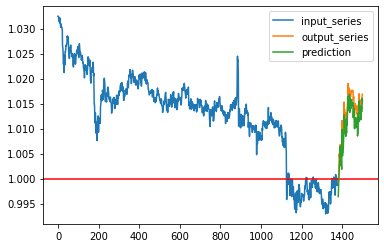

In [24]:
idx = 300
# train data 중 sample_id 1121에 해당하는 x_series로 모델을 학습한 후
# y_sereis를 추론
x_series = train_x_array[idx,:,1]
y_series = train_y_array[idx,:,1]

# pred_dim1 = np.zeros(120)
# pred_dim1 = preds[0,,0]
# pred_dim1.shape

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), test_pred_array[idx], label = 'prediction')
plt.legend()
plt.show()

# 투자 후 금액 계산하기

In [31]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index


def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_momey      = 10000 # dolors
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

In [32]:
total_momey, total_momey_list = COIN(valid_y_df,
                                     valid_submission)

In [33]:
# 투자 후 금액
print(total_momey)

10071.639156524609


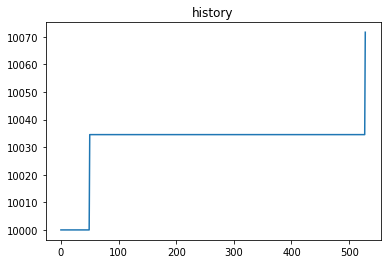

In [34]:
# 투자 히스토리
plt.plot(total_momey_list)
plt.title("history")
plt.show()

---

In [25]:
# def plot_series(x_series, y_series):
#     #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
#     plt.plot(x_series, label = 'input_series')
#     plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
#              y_series, label = 'output_series')
#     plt.axhline(1, c = 'red')
#     plt.legend()

In [26]:
    # #학습
    # x_series = np.reshape(valid_x_array[idx,:,1], (1, 1380,1))
    # y_series = np.reshape(valid_y_array[idx,:,1], (1, 120, 1))
    # test_x_series = np.reshape(test_x_array[idx,:,1], (1, 1380,1)) #각 open 값의 3차원형

    # preds = model.predict(test_x_series)
    # test_pred_array[idx,:] = preds

    # model.fit(x_series, y_series, epochs = 10, batch_size = 32)

    # #여기서 predict를 바로 해야 함
    # preds = model.predict(test_x_series)
    # test_pred_array[idx,:] = preds

In [27]:
# idx = 300  #529보다 작아야 함
# # train data 중 sample_id 300에 해당하는 x_series로 모델과 을 학습한 후
# # y_sereis를 추론
# sample_x = np.reshape(valid_x_array[idx,:,1], (1, 1380,1))
# sample_y = np.reshape(valid_y_array[idx,:,1], (1, 120, 1))
# sample_test_x = np.reshape(test_x_array[idx,:,1], (1, 1380,1))

# model.fit(sample_x, sample_y, epochs = 10, batch_size = 32)
# preds = model.predict(sample_test_x)

# #train_pred_array 3차원에서 2차원으로 바꾸기
# sample_x_conversion = np.zeros([1, 120])
# sample_x_conversion[0, :] = preds[0, :, 0]
# sample_x_conversion





In [28]:
# x = train_x_array[idx,:,1]
# y = train_y_array[idx,:,1]

# plot_series(x, y)
# plt.plot(np.arange(1380, 1380+120), sample_x_conversion[0], label = 'prediction')
# plt.legend()
# plt.show()

제대로 학습되지 않고 있다는 것을 알 수 있다.

In [29]:
# 정확도 측정(수정필요)
# # Test RMSE 측정하기
# from sklearn.metrics import mean_squared_error, r2_score
# from math import sqrt

# rmse = sqrt(mean_squared_error(pred_y, test_y))
# print(rmse)